# PDAC Adaptive Modules — DepMap & Clinical Cohorts (Notebook)
This notebook reproduces the final two **Results** analyses:

1) **DepMap integration** — module scores vs. CRISPR **Chronos** gene dependencies and **PRISM** drug AUC.
2) **Clinical validation** — module scores across patient cohorts (COMPASS, Puleo, TCGA-PAAD), subtype comparisons, and survival.

> If you use this code, please acknowledge: *“Analysis notebook scaffold generated with assistance from ChatGPT.”*

In [88]:

import os
import pandas as pd
from pathlib import Path

# ---------------- paths ----------------
# Your Google Drive base
BASE = Path("/Users/scottpowers/Library/CloudStorage/GoogleDrive-Scott.Powers@stonybrook.edu/My Drive/Imputed Folder")

# DepMap (update these two if you’ve moved them)
DEP_EXP   = BASE / "PDAC_celllines_expression.csv"      # genes x cell_lines
DEP_CHRON = BASE / "PDAC_gene_dependencies.csv"         # genes x cell_lines

# Use the outputs we just generated on Desktop
PRISM_LONG   = Path("~/Desktop/PRISM_AUC_PDAC_long.csv").expanduser()     # depmap_id, ccle_name, compound, auc
PRISM_MATRIX = Path("~/Desktop/PRISM_AUC_PDAC_matrix.csv").expanduser()   # rows=cell_lines, cols=compounds
PRISM_PARAMS = Path("~/Desktop/secondary-screen-dose-response-curve-parameters.csv").expanduser()  # for target/MOA

# Clinical cohorts (leave as-is until you point them to real files)
COMPASS_EXPR = Path("/path/to/clin/COMPASS_expr.csv")
COMPASS_META = Path("/path/to/clin/COMPASS_meta.csv")

PULEO_EXPR   = Path("/path/to/clin/Puleo_expr.csv")
PULEO_META   = Path("/path/to/clin/Puleo_meta.csv")

TCGA_EXPR    = Path("/path/to/clin/TCGA_expr.csv")
TCGA_META    = Path("/path/to/clin/TCGA_meta.csv")

# Output dir
OUTDIR = Path("./out_modules_notebook")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---------------- helpers ----------------
def read_any(path: Path) -> pd.DataFrame:
    """Smart CSV/TSV reader with header guess; returns DataFrame."""
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    try:
        return pd.read_csv(path)
    except Exception:
        try:
            return pd.read_csv(path, sep="\t")
        except Exception:
            return pd.read_csv(path, sep=None, engine="python")

# ---------------- load PRISM ----------------
# Matrix we made is cell_lines x compounds; your code wants drugs x cell_lines
A = read_any(PRISM_MATRIX)
# Ensure the first column is the index if it got saved with an unnamed index
if A.columns[0].lower() in {"unnamed: 0", ""}:
    A = A.set_index(A.columns[0])

# A: rows = cell_lines, cols = compounds
# Convert to drugs x cell_lines
DEP_PRISM = A.T.copy()
DEP_PRISM.index.name = "compound"     # drugs
DEP_PRISM.columns.name = "ccle_name"  # cell lines

# Optional: build annotation from the params file (target/MOA)
annot = None
if PRISM_PARAMS.exists():
    params = read_any(PRISM_PARAMS)
    # normalize headers
    params.columns = [str(c).strip().lower() for c in params.columns]
    # In your file drug name is 'name'; align to 'compound'
    cols_to_keep = [c for c in ["name", "compound", "target", "moa"] if c in params.columns]
    if "name" in cols_to_keep and "compound" not in cols_to_keep:
        params = params.rename(columns={"name": "compound"})
    annot = params[["compound"] + [c for c in ["target", "moa"] if c in params.columns]].drop_duplicates()
    # Keep only drugs present in the matrix
    annot = annot[annot["compound"].isin(DEP_PRISM.index)].set_index("compound")
    annot.to_csv(OUTDIR / "PRISM_drug_annotations.csv")

# Save the drug x cell_lines AUC matrix for downstream code expecting that orientation
DEP_PRISM_PATH = OUTDIR / "PRISM_AUC_PDAC_drugs_by_celllines.csv"
DEP_PRISM.to_csv(DEP_PRISM_PATH)

print("PRISM (drugs x cell_lines):", DEP_PRISM.shape, "->", DEP_PRISM_PATH)

# ---------------- load expression/dependency (optional, if paths are real) ---
def try_load(label, p: Path):
    try:
        df = read_any(p)
        print(f"{label}:", df.shape, "from", p)
        return df
    except FileNotFoundError:
        print(f"{label}: MISSING -> {p}")
        return None

EXP   = try_load("Expression", DEP_EXP)
CHRON = try_load("Dependencies", DEP_CHRON)

# ---------------- stubs for clinical cohorts ----------------
for label, p in [
    ("COMPASS expr", COMPASS_EXPR),
    ("COMPASS meta", COMPASS_META),
    ("Puleo expr",   PULEO_EXPR),
    ("Puleo meta",   PULEO_META),
    ("TCGA expr",    TCGA_EXPR),
    ("TCGA meta",    TCGA_META),
]:
    if Path(p).exists():
        print(label, "OK:", p)
    else:
        print(label, "MISSING ->", p)

# ---------------- quick preview ----------------
print("\nPreview AUC (first 5 drugs × 5 lines):")
display(DEP_PRISM.iloc[:5, :5])

if annot is not None:
    print("\nPreview annotations (first 10):")
    display(annot.head(10))


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/2470016835.py:39: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


PRISM (drugs x cell_lines): (1449, 33) -> out_modules_notebook/PRISM_AUC_PDAC_drugs_by_celllines.csv
Expression: (51, 19099) from /Users/scottpowers/Library/CloudStorage/GoogleDrive-Scott.Powers@stonybrook.edu/My Drive/Imputed Folder/PDAC_celllines_expression.csv
Dependencies: (45, 17917) from /Users/scottpowers/Library/CloudStorage/GoogleDrive-Scott.Powers@stonybrook.edu/My Drive/Imputed Folder/PDAC_gene_dependencies.csv
COMPASS expr MISSING -> /path/to/clin/COMPASS_expr.csv
COMPASS meta MISSING -> /path/to/clin/COMPASS_meta.csv
Puleo expr MISSING -> /path/to/clin/Puleo_expr.csv
Puleo meta MISSING -> /path/to/clin/Puleo_meta.csv
TCGA expr MISSING -> /path/to/clin/TCGA_expr.csv
TCGA meta MISSING -> /path/to/clin/TCGA_meta.csv

Preview AUC (first 5 drugs × 5 lines):


ccle_name,0,1,2,3,4
compound,,,,,
ccle_name,ASPC1_PANCREAS,BXPC3_PANCREAS,CAPAN2_PANCREAS,CFPAC1_PANCREAS,DANG_PANCREAS
1-azakenpaullone,1.422871,1.442328,1.1974,1.143525,0.847678
1-naphthyl-PP1,0.868061,1.004497,0.865685,0.861098,NaN
1-phenylbiguanide,0.943366,1.345432,0.884344,0.954388,0.907823
10-deacetylbaccatin,0.887246,NaN,0.858276,0.889449,0.747788



Preview annotations (first 10):


,target,moa
compound,,
cytarabine,"POLA1, POLB, POLD1, POLE",ribonucleotide reductase inhibitor
epinastine,"ADRA1A, ADRA2A, HRH1, HRH2, HTR2A, HTR7",histamine receptor antagonist
floxuridine,TYMS,DNA synthesis inhibitor
valrubicin,TOP2A,"DNA inhibitor, topoisomerase inhibitor"
adapalene,"RARA, RARB, RARG, RXRA, RXRB, RXRG",retinoid receptor agonist
colforsin-daproate,NaN,adenylyl cyclase activator
sulfamethazine,NaN,PABA antagonist
niridazole,NaN,phosphofructokinase inhibitor
amprolium,NaN,thiamine uptake blocker


In [89]:
# --- GSE71729 Series Matrix → Puleo_expr.csv + Puleo_meta.csv (robust) ---
import io, gzip, re, shutil, requests
import pandas as pd
from pathlib import Path

DESKTOP = Path("~/Desktop").expanduser()
DESKTOP.mkdir(parents=True, exist_ok=True)

MATRIX_URL = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE71nnn/GSE71729/matrix/GSE71729_series_matrix.txt.gz"
matrix_gz_path = DESKTOP / "GSE71729_series_matrix.txt.gz"

# ---------- Download with requests (uses certifi CA) ----------
if not matrix_gz_path.exists():
    print("Downloading:", MATRIX_URL)
    with requests.get(MATRIX_URL, stream=True, timeout=180) as r:
        r.raise_for_status()
        with open(matrix_gz_path, "wb") as f:
            shutil.copyfileobj(r.raw, f)
else:
    print("Found existing:", matrix_gz_path)

# ---------- Read all lines ----------
with gzip.open(matrix_gz_path, "rt", encoding="utf-8", errors="ignore") as fh:
    lines = fh.readlines()

# ---------- Helper: parse "!Sample_<field> = ..." arrays ----------
def parse_field_to_list(s, field):
    s = s.strip()
    prefix = f"!Sample_{field} = "
    if not s.startswith(prefix):
        return None
    val = s[len(prefix):].strip()
    # Standard format is quoted list: "v1" "v2" "v3" ...
    if val.startswith('"') and val.endswith('"'):
        return re.findall(r'"(.*?)"', val)
    # Fallback: split on tabs/semicolons/commas if unquoted
    for sep in ("\t", ";", ","):
        if sep in val:
            return [x.strip().strip('"') for x in val.split(sep)]
    return [val]

# ---------- Try to collect sample arrays from header lines ----------
fields_wanted = ["geo_accession", "title", "characteristics_ch1", "source_name_ch1", "organism_ch1"]
arrays = {}
for line in lines:
    if not line.startswith("!Sample_"):
        continue
    for f in fields_wanted:
        parts = parse_field_to_list(line, f)
        if parts is not None:
            arrays[f] = parts  # last one wins (GEO consolidates per field)

# ---------- Extract the expression table block ----------
try:
    begin_idx = next(i for i, s in enumerate(lines) if s.startswith("!series_matrix_table_begin"))
    end_idx   = next(i for i, s in enumerate(lines) if s.startswith("!series_matrix_table_end"))
except StopIteration:
    raise ValueError("Could not find matrix begin/end markers in the series matrix file.")

table_block = "".join(lines[begin_idx+1 : end_idx])
expr_df = pd.read_csv(io.StringIO(table_block), sep="\t", dtype=str)
gene_col = expr_df.columns[0]
expr_df = expr_df.set_index(gene_col)
expr_df = expr_df.apply(pd.to_numeric, errors="coerce")

# ---------- Clean gene index ----------
idx = expr_df.index.astype(str)
mask_junk = idx.str.startswith("?") | (idx.str.strip() == "") | (idx.str.lower() == "na")
expr_df = expr_df[~mask_junk]
expr_df = expr_df[~expr_df.index.duplicated(keep="first")]

# ---------- Build rich metadata (handles multiple characteristics lines) ----------
import re

# 1) Get core sample arrays
fields_wanted = ["geo_accession", "title", "source_name_ch1", "organism_ch1"]
arrays = {}
for line in lines:
    if not line.startswith("!Sample_"):
        continue
    for f in fields_wanted:
        parts = parse_field_to_list(line, f)
        if parts is not None:
            arrays[f] = parts  # last one wins (ok: these are single-occurrence fields)

# 2) Collect ALL characteristics lines (can be many; each with "key: value")
char_arrays = []
for line in lines:
    if line.startswith("!Sample_characteristics_ch1"):
        parts = parse_field_to_list(line, "characteristics_ch1")
        if parts is not None:
            char_arrays.append(parts)

# Figure out N samples (prefer geo_accession length; else expression column count)
if "geo_accession" in arrays:
    N = len(arrays["geo_accession"])
else:
    N = expr_df.shape[1]

def get_array(name, default=""):
    arr = arrays.get(name, [])
    if len(arr) == N:
        return arr
    if len(arr) == 0:
        return [default] * N
    # pad/trim
    return (arr + [default] * N)[:N]

# 3) Parse key:value per sample across all characteristics lines
def norm_key(k: str) -> str:
    k = k.strip().strip(':').lower()
    k = re.sub(r"[^0-9a-zA-Z]+", "_", k)
    k = re.sub(r"(^_+|_+$)", "", k)
    return k or "characteristic"

meta_rows = []
for i in range(N):
    row = {
        "geo_accession": get_array("geo_accession", "")[i],
        "title": get_array("title", "")[i],
        "source_name_ch1": get_array("source_name_ch1", "")[i],
        "organism_ch1": get_array("organism_ch1", "")[i],
    }
    # accumulate characteristics
    for arr in char_arrays:
        if i >= len(arr):
            continue
        txt = (arr[i] or "").strip().strip('"')
        if not txt:
            continue
        if ":" in txt:
            key, val = txt.split(":", 1)
            key = norm_key(key)
            val = val.strip()
        else:
            # no explicit key -> put into a generic bucket (or append)
            key = "characteristic"
            val = txt
        if key in row and row[key] and val:
            row[key] = f"{row[key]}; {val}"
        else:
            row[key] = val
    meta_rows.append(row)

meta_df = pd.DataFrame(meta_rows)

# 4) Index by geo_accession when available; otherwise by expression column headers
if "geo_accession" in meta_df.columns and meta_df["geo_accession"].notna().all() and (meta_df["geo_accession"] != "").all():
    meta_df = meta_df.set_index("geo_accession")
else:
    meta_df.index = expr_df.columns
    meta_df.index.name = "sample"

# If expression columns are GSM IDs, reindex metadata to match their order
if all(re.match(r"^GSM\d+$", str(c)) for c in expr_df.columns):
    meta_df = meta_df.reindex(expr_df.columns)

# 5) (Optional) tidy column order: core fields first
core = ["title", "source_name_ch1", "organism_ch1"]
cols = [c for c in core if c in meta_df.columns] + [c for c in meta_df.columns if c not in core]
meta_df = meta_df.loc[:, cols]

# ---------- Save ----------
expr_out = DESKTOP / "Puleo_expr.csv"
meta_out = DESKTOP / "Puleo_meta.csv"
expr_df.to_csv(expr_out)
meta_df.to_csv(meta_out)

print("✅ Saved:")
print("  -", expr_out, f"(shape: {expr_df.shape})")
print("  -", meta_out, f"(shape: {meta_df.shape})")

# ---------- Preview ----------
display(expr_df.iloc[:5, :5])
display(meta_df.head(5))


Found existing: /Users/scottpowers/Desktop/GSE71729_series_matrix.txt.gz
✅ Saved:
  - /Users/scottpowers/Desktop/Puleo_expr.csv (shape: (19749, 357))
  - /Users/scottpowers/Desktop/Puleo_meta.csv (shape: (357, 4))


sample,GSM1843893,GSM1843894,GSM1843895,GSM1843896,GSM1843897
ID_REF,,,,,
A1BG,1.685,1.540,1.541,1.641,1.744
A1CF,1.373,1.109,1.402,1.379,1.468
A2BP1,0.926,1.294,0.933,0.828,1.043
A2LD1,2.950,4.954,4.645,3.691,3.814
A2M,3.090,2.536,2.731,3.141,2.905


,title,source_name_ch1,organism_ch1,geo_accession
sample,,,,
GSM1843893,,,,
GSM1843894,,,,
GSM1843895,,,,
GSM1843896,,,,
GSM1843897,,,,


In [90]:
import pandas as pd
from pathlib import Path

# --- point to your file on Desktop ---
TCGA_EXPR = Path("~/Desktop/PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt").expanduser()

# --- load it ---
df_tcga = pd.read_csv(TCGA_EXPR, sep="\t", low_memory=False)
print("Raw shape:", df_tcga.shape)
print("First columns:", list(df_tcga.columns[:10]))

# often TCGA files have a column named "gene_id" or "Hybridization REF" or similar
# detect automatically:
gene_col = None
for c in df_tcga.columns:
    if "gene" in c.lower() or "hybridization" in c.lower():
        gene_col = c
        break

if gene_col is None:
    raise ValueError("Couldn't find gene column — check file header.")

# set gene column as index
df_tcga = df_tcga.set_index(gene_col)
print("Processed shape:", df_tcga.shape)

# --- optional: save as clean CSV for future quick loading ---
out_csv = TCGA_EXPR.with_suffix(".csv")
df_tcga.to_csv(out_csv)
print("Saved cleaned CSV to:", out_csv)

# quick preview
display(df_tcga.head())


Raw shape: (20532, 184)
First columns: ['Hybridization REF', 'TCGA-2J-AAB1-01A-11R-A41B-07', 'TCGA-2J-AAB4-01A-12R-A41B-07', 'TCGA-2J-AAB6-01A-11R-A41B-07', 'TCGA-2J-AAB8-01A-12R-A41B-07', 'TCGA-2J-AAB9-01A-11R-A41B-07', 'TCGA-2J-AABA-01A-21R-A41B-07', 'TCGA-2J-AABE-01A-12R-A41B-07', 'TCGA-2J-AABF-01A-31R-A41B-07', 'TCGA-2J-AABH-01A-21R-A41B-07']
Processed shape: (20532, 183)
Saved cleaned CSV to: /Users/scottpowers/Desktop/PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.csv


,TCGA-2J-AAB1-01A-11R-A41B-07,TCGA-2J-AAB4-01A-12R-A41B-07,TCGA-2J-AAB6-01A-11R-A41B-07,TCGA-2J-AAB8-01A-12R-A41B-07,TCGA-2J-AAB9-01A-11R-A41B-07,TCGA-2J-AABA-01A-21R-A41B-07,TCGA-2J-AABE-01A-12R-A41B-07,TCGA-2J-AABF-01A-31R-A41B-07,TCGA-2J-AABH-01A-21R-A41B-07,TCGA-2J-AABI-01A-12R-A41B-07,...,TCGA-XD-AAUH-01A-42R-A41B-07,TCGA-XD-AAUI-01A-42R-A41B-07,TCGA-XD-AAUL-01A-21R-A39D-07,TCGA-XN-A8T3-01A-11R-A36G-07,TCGA-XN-A8T5-01A-12R-A36G-07,TCGA-YB-A89D-11A-11R-A36G-07,TCGA-YB-A89D-01A-12R-A36G-07,TCGA-YH-A8SY-01A-11R-A37L-07,TCGA-YY-A8LH-01A-11R-A36G-07,TCGA-Z5-AAPL-01A-12R-A41B-07
Hybridization REF,,,,,,,,,,,,,,,,,,,,,
gene_id,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,...,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count,normalized_count
?|100130426,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
?|100133144,8.5512,23.9941,1.7836,3.5159,1.0718,12.5881,6.2957,13.5235,5.3397,14.5972,...,0.0000,4.7895,6.2661,13.2700,6.5912,0.0000,4.6506,8.4755,6.3411,0.0000
?|100134869,8.5220,8.8342,4.0643,15.2855,15.0054,27.4933,20.8355,13.4101,8.1620,38.7409,...,5.2056,10.0693,13.6923,7.2996,10.6913,9.9059,8.7102,4.3750,24.5265,11.3960
?|10357,110.7707,81.9234,176.5906,95.2197,84.0622,67.7000,102.3709,119.5535,108.5932,105.2576,...,80.3904,87.0332,131.9252,141.0918,81.4243,96.7013,107.1942,101.8925,118.8888,146.8376


In [91]:
import pandas as pd
from pathlib import Path

# --- Load file ---
TCGA_EXPR = Path("~/Desktop/PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt").expanduser()
df = pd.read_csv(TCGA_EXPR, sep="\t", low_memory=False)

# --- Set gene column as index ---
df = df.set_index("Hybridization REF")

# --- Remove rows with junk IDs ---
# 1. Drop rows starting with '?'
df = df[~df.index.str.startswith("?")]

# 2. Drop empty or whitespace-only gene names
df = df[df.index.str.strip() != ""]

# 3. Drop duplicate gene names (if any, keep first occurrence)
df = df[~df.index.duplicated(keep="first")]

# --- Save cleaned file ---
CLEAN_PATH = TCGA_EXPR.with_name("PAAD_RSEM_genes_normalized_CLEAN.csv")
df.to_csv(CLEAN_PATH)

print(f"✅ Cleaned expression matrix saved to: {CLEAN_PATH}")
print(f"New shape: {df.shape}")
print("Example rows after cleanup:")
print(df.head())


✅ Cleaned expression matrix saved to: /Users/scottpowers/Desktop/PAAD_RSEM_genes_normalized_CLEAN.csv
New shape: (20503, 183)
Example rows after cleanup:
                  TCGA-2J-AAB1-01A-11R-A41B-07 TCGA-2J-AAB4-01A-12R-A41B-07  \
Hybridization REF                                                             
gene_id                       normalized_count             normalized_count   
A1BG|1                                 81.9122                      56.7551   
A1CF|29974                             25.3659                      53.4512   
A2BP1|54715                             0.4878                       2.1044   
A2LD1|87769                           180.4976                     111.0774   

                  TCGA-2J-AAB6-01A-11R-A41B-07 TCGA-2J-AAB8-01A-12R-A41B-07  \
Hybridization REF                                                             
gene_id                       normalized_count             normalized_count   
A1BG|1                                 82.5497         

In [92]:
from pathlib import Path
import pandas as pd

# point to your file on Desktop
TCGA_META = Path("~/Desktop/PAAD.clin.merged.txt").expanduser()

# load
meta = pd.read_csv(TCGA_META, sep="\t", low_memory=False)
print("Shape:", meta.shape)
print("Columns:", list(meta.columns[:15]))

# optional: save as clean CSV
meta.to_csv(TCGA_META.with_suffix(".csv"), index=False)


Shape: (1321, 186)
Columns: ['admin.batch_number', '424.43.0', '424.43.0.1', '392.47.0', '410.44.0', '392.47.0.1', '284.60.0', '424.43.0.2', '106.60.0', '284.60.0.1', '195.62.0', '284.60.0.2', '369.51.0', '369.51.0.1', '195.62.0.1']


## 2) Define module gene sets
Replace the placeholders with your finalized core gene lists. You can also load from CSVs.

In [93]:
# === Fix loading, set paths, rescore TCGA + Puleo ============================
import pandas as pd, numpy as np, gzip, io, re
from pathlib import Path
import matplotlib.pyplot as plt

DESKTOP = Path("~/Desktop").expanduser()
OUTDIR  = Path("./out_modules_notebook"); OUTDIR.mkdir(parents=True, exist_ok=True)

# ---- 1) Locate TCGA file on Desktop (prefer CLEAN CSV, else raw Firehose txt) ----
def find_tcga_expr():
    # Prefer a cleaned CSV you saved earlier
    cand = list(DESKTOP.glob("*RSEM*normalized*_*CLEAN*.csv")) + list(DESKTOP.glob("*RSEM*normalized*data*.csv"))
    if cand: return cand[0]
    # Fall back to the raw Level_3 text
    cand = list(DESKTOP.glob("*RSEM*normalized*data*.txt"))
    return cand[0] if cand else None

TCGA_EXPR = find_tcga_expr()
PULEO_EXPR = DESKTOP / "Puleo_expr.csv"  # produced earlier by the download/parse step

print("TCGA_EXPR:", TCGA_EXPR)
print("PULEO_EXPR:", PULEO_EXPR if PULEO_EXPR.exists() else "NOT FOUND")

# ---- 2) Robust loader for expression matrices (genes x samples) ----
def smart_read_expr(path: Path) -> pd.DataFrame:
    """Load CSV/TSV/GEO matrix; set gene column correctly; numeric; no samples→retry."""
    if path is None or not Path(path).exists():
        raise FileNotFoundError(f"Missing expression file: {path}")
    p = Path(path)
    # handle gz
    if p.suffix == ".gz":
        with gzip.open(p, "rt", encoding="utf-8", errors="ignore") as fh:
            txt = fh.read()
        # If this is a GEO series matrix block (has begin/end markers)
        if "!series_matrix_table_begin" in txt:
            beg = txt.index("!series_matrix_table_begin") + len("!series_matrix_table_begin")
            end = txt.index("!series_matrix_table_end")
            tab = txt[beg:end].lstrip("\n")
            df = pd.read_csv(io.StringIO(tab), sep="\t", dtype=str)
        else:
            df = pd.read_csv(io.StringIO(txt), sep=None, engine="python", dtype=str, comment="!")
    else:
        # try csv, then tsv, then auto
        try:
            df = pd.read_csv(p, dtype=str)
        except Exception:
            try:
                df = pd.read_csv(p, sep="\t", dtype=str)
            except Exception:
                df = pd.read_csv(p, sep=None, engine="python", dtype=str, comment="!")

    # If a standard gene column exists, set it as index
    gene_like = [c for c in df.columns if c.lower() in {"hybridization ref","hybridization_ref","gene","gene_symbol","genes","id_ref","symbol"}]
    if gene_like:
        df = df.set_index(gene_like[0])
    else:
        # If first column looks like gene keys and others look like samples, use first col
        if df.shape[1] > 1:
            df = df.set_index(df.columns[0])

    # Drop completely empty columns (just in case)
    df = df.dropna(axis=1, how="all")
    # Convert to numeric where possible
    df = df.apply(pd.to_numeric, errors="coerce")

    # If we still ended up with 0 samples because of separator issues, re-read with the other sep
    if df.shape[1] == 0:
        # try the opposite separator quickly
        raw = Path(path).read_text(errors="ignore") if p.suffix != ".gz" else txt
        sep = "\t" if "," in raw.splitlines()[0] else ","
        df = pd.read_csv(io.StringIO(raw), sep=sep, dtype=str)
        if df.shape[1] > 1:
            df = df.set_index(df.columns[0])
            df = df.apply(pd.to_numeric, errors="coerce")

    return df

# ---- 3) Normalize gene index (SYMBOL|ENTREZ → SYMBOL; uppercase; collapse dups) ----
def normalize_gene_index(expr: pd.DataFrame) -> pd.DataFrame:
    idx = expr.index.astype(str).str.strip()
    idx = idx.str.replace(r"\|.*$", "", regex=True)     # keep before '|'
    idx = idx.str.replace(r"\.\d+$", "", regex=True)    # drop .version
    idx = idx.str.upper()
    out = expr.copy(); out.index = idx
    return out.groupby(out.index).mean()

# ---- 4) IGE gene sets ----
IGE_UP = [
    "PFN2","SET","LGALS1","PDLIM4","EIF5A","F8A1","BANF1","CTDNEP1","TRAPPC1","AMZ2","PTGES3","ST13",
    "FTH1","PCBP1","NAA10","ARPC5L","ETFB","CCDC124","SSR2","PGLS","SELENOH","GSTP1","NDUFB7","AURKAIP1",
    "GCHFR","MYL6","AP2S1","S100A13","C9ORF16","KRT8","PRKCSH","CST3","PET100","DNAJA2","VPS35","VDAC1",
    "MGST3","PRR13","OCIAD2","FUOM","MIA","RPN1","FUCA2","TMED4","ERGIC3","DDOST","NAXE","SNRPD1","SKP1",
    "CNBP","ATP5MC3","SLC25A5","LSM4","NDUFAB1","PCBD1","HINT1","ADI1","NENF","MRPL43","VKORC1","EMC4",
    "COA3","NEDD8","CHCHD2","PRDX5","WDR83OS","NDUFA4","GABARAP","PHPT1","UFC1","MDH1","ATP5F1E","MRPL41",
    "UBL5","COX5B","ELOB","ATP5ME","UQCRB","SEM1","NDUFB1","COX6C","ATP6V1F","HNRNPA1","HIGD2A","POLR2I",
    "METTL26","NDUFB4","OST4","C19ORF53","RPL36AL","PPIA","COPS9","COX8A","COX5A","RPL36","RPS15","RPS27",
    "RPS11","FTL","SNHG29","NACA","RPS17","RPL23","RPL39","RPS21","RPL9","RPL15","RPL34","RPL27A","RPL36A",
    "RPL38","RPS26","RPS14","RPL35","RPL37A","RPL37","RPL12","RPS29"
]
IGE_DOWN = [
    "STT3A","SGPP1","LINGO1","ASS1","CETN2","HNRNPH1","STN1","NRG4","IQSEC2","IYD","CHD9","APBB1IP",
    "TMEM238","REX1BD","IFI27","CYBA","METRNL","AKR7A2","SULT1A1","ARHGEF35","AC008397.1","KLK11",
    "DELE1","MISP","FAM234A","CMBL"
]

# ---- 5) Scoring helpers ----
def zscore_by_gene(expr):
    mu = expr.mean(axis=1)
    sd = expr.std(axis=1, ddof=0).replace(0, np.nan)
    return (expr.sub(mu, axis=0)).div(sd, axis=0)

def score_signed_module(expr, up_genes, down_genes, min_genes=10):
    expr = expr.copy()
    expr.index = expr.index.astype(str).str.upper()
    UP   = pd.Index(map(str.upper, up_genes))
    DOWN = pd.Index(map(str.upper, down_genes))
    up_present   = expr.index.intersection(UP)
    down_present = expr.index.intersection(DOWN)
    Z = zscore_by_gene(expr)
    up_mean   = Z.loc[up_present].mean(axis=0)   if len(up_present)   else pd.Series(0.0, index=Z.columns)
    down_mean = Z.loc[down_present].mean(axis=0) if len(down_present) else pd.Series(0.0, index=Z.columns)
    scores = (up_mean - down_mean).astype(float)
    cov = {"up_total": len(UP), "up_used": len(up_present), "down_total": len(DOWN), "down_used": len(down_present)}
    if cov["up_used"] < min_genes or cov["down_used"] < min_genes:
        print(f"[warn] coverage: UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")
    if cov["up_used"] == 0 and cov["down_used"] == 0:
        scores[:] = np.nan
    return scores, cov

def zscore_series(s):
    mu, sd = s.mean(), s.std(ddof=0)
    return (s - mu) / sd if sd and not np.isnan(sd) else s*0

# ---- 6) Load cohorts robustly ----
cohorts = []
if TCGA_EXPR:  # TCGA
    try:
        tcga = smart_read_expr(TCGA_EXPR)
        print("Loaded TCGA (raw):", tcga.shape)
        tcga = normalize_gene_index(tcga)
        print("TCGA after gene normalization:", tcga.shape)
        cohorts.append(("TCGA", tcga))
    except Exception as e:
        print("TCGA load failed:", e)

if PULEO_EXPR.exists():
    try:
        puleo = smart_read_expr(PULEO_EXPR)
        print("Loaded Puleo (raw):", puleo.shape)
        puleo = normalize_gene_index(puleo)
        print("Puleo after gene normalization:", puleo.shape)
        cohorts.append(("Puleo", puleo))
    except Exception as e:
        print("Puleo load failed:", e)
else:
    print("⚠️ Puleo_expr.csv not found on Desktop. Run the earlier download/parse step.")

# ---- 7) Score & save ----
for label, expr in cohorts:
    scores, cov = score_signed_module(expr, IGE_UP, IGE_DOWN, min_genes=10)
    raw_path = OUTDIR / f"{label}_IGE_signed_scores.csv"
    z_path   = OUTDIR / f"{label}_IGE_signed_scores_Z.csv"
    scores.rename("IGE_signed_score").to_csv(raw_path)
    z = zscore_series(scores).rename("IGE_signed_score_Z")
    z.to_csv(z_path)
    print(f"✅ {label}: {expr.shape[0]} genes × {expr.shape[1]} samples")
    print(f"   Saved: {raw_path.name}, {z_path.name}")
    print(f"   Coverage: UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")


TCGA_EXPR: /Users/scottpowers/Desktop/PAAD_RSEM_genes_normalized_CLEAN.csv
PULEO_EXPR: /Users/scottpowers/Desktop/Puleo_expr.csv
Loaded TCGA (raw): (20503, 183)
TCGA after gene normalization: (20502, 183)
Loaded Puleo (raw): (19749, 357)
Puleo after gene normalization: (19736, 357)
✅ TCGA: 20502 genes × 183 samples
   Saved: TCGA_IGE_signed_scores.csv, TCGA_IGE_signed_scores_Z.csv
   Coverage: UP 102/118 | DOWN 19/26
✅ Puleo: 19736 genes × 357 samples
   Saved: Puleo_IGE_signed_scores.csv, Puleo_IGE_signed_scores_Z.csv
   Coverage: UP 100/118 | DOWN 18/26


In [94]:
import pandas as pd

ige = pd.read_csv("out_modules_notebook/TCGA_IGE_signed_scores_Z.csv")
print(ige.head())
print("shape:", ige.shape)


                     Unnamed: 0  IGE_signed_score_Z
0  TCGA-2J-AAB1-01A-11R-A41B-07           -0.243979
1  TCGA-2J-AAB4-01A-12R-A41B-07           -0.496232
2  TCGA-2J-AAB6-01A-11R-A41B-07            0.600294
3  TCGA-2J-AAB8-01A-12R-A41B-07            0.012602
4  TCGA-2J-AAB9-01A-11R-A41B-07            0.222417
shape: (183, 2)


In [95]:
import re, numpy as np, pandas as pd

def _num(s):
    return pd.to_numeric(s, errors="coerce")

def _rowmax(df, cols):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return pd.Series(np.nan, index=df.index)
    return pd.concat([_num(df[c]) for c in cols], axis=1).max(axis=1)

def derive_tcga_survival_auto(clin_df: pd.DataFrame, barcode_col_guess=("patient.bcr_patient_barcode", "bcr_patient_barcode"), verbose=True):
    df = clin_df.copy()
    # index to patient barcode (12-char)
    bc = None
    for col in barcode_col_guess:
        if col in df.columns:
            bc = col; break
    if bc is None:
        # fall back: if index looks like TCGA barcodes, use it
        df.index = df.index.astype(str)
    else:
        df = df.set_index(bc)
    df.index = df.index.astype(str).str[:12]

    cols = df.columns.astype(str)

    # discover candidate columns
    vital_cols = [c for c in cols if re.search(r'vital[\s_]*status', c, re.I)]
    death_cols = [c for c in cols if re.search(r'days?\s*_?\s*to\s*_?.*death', c, re.I)]
    lfu_cols   = [c for c in cols if re.search(r'days?\s*_?\s*to\s*_?.*(last|lst).*follow', c, re.I)]

    if verbose:
        print("[SURV-AUTO] discovered columns:")
        print("  vital:", vital_cols[:10])
        print("  death:", death_cols[:10])
        print("  last follow-up:", lfu_cols[:10])

    # event from vital if present
    OS_event = pd.Series(np.nan, index=df.index, dtype="float")
    if vital_cols:
        v = df[vital_cols[0]].astype(str).str.strip().str.lower()
        OS_event = v.replace({
            "dead":1, "deceased":1, "1":1, "true":1, "yes":1,
            "alive":0, "living":0, "0":0, "false":0, "no":0
        })
        OS_event = pd.to_numeric(OS_event, errors="coerce")

    # if still all NA, infer from days_to_death presence
    dtd = _rowmax(df, death_cols)
    lfu = _rowmax(df, lfu_cols)

    if OS_event.isna().all():
        OS_event = pd.Series(np.nan, index=df.index, dtype="float")
        # event=1 if any death days present and >0
        OS_event[(~dtd.isna()) & (dtd > 0)] = 1
        # event=0 if no death, but has follow-up time
        OS_event[(dtd.isna() | (dtd <= 0)) & (~lfu.isna()) & (lfu >= 0)] = 0

    # time = death if event==1 else last follow-up
    OS_time = np.where(OS_event == 1, dtd, lfu)
    OS_time = pd.to_numeric(OS_time, errors="coerce")

    out = pd.DataFrame({"OS_time": OS_time, "OS_event": OS_event}, index=df.index)

    if verbose:
        print("[SURV-AUTO] rows:", len(out))
        print("[SURV-AUTO] OS_event counts:\n", out["OS_event"].value_counts(dropna=False))
        if out["OS_time"].notna().any():
            print("[SURV-AUTO] OS_time (days) min/median/max:",
                  np.nanmin(out["OS_time"]), np.nanmedian(out["OS_time"]), np.nanmax(out["OS_time"]))
        else:
            print("[SURV-AUTO] OS_time appears all NA")

    return out

# ---- run on your loaded clinical table ----
tcga_surv = derive_tcga_survival_auto(clin, verbose=True)


[SURV-AUTO] discovered columns:
  vital: []
  death: []
  last follow-up: []
[SURV-AUTO] rows: 184
[SURV-AUTO] OS_event counts:
 OS_event
NaN    184
Name: count, dtype: int64
[SURV-AUTO] OS_time appears all NA


In [96]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- load the clinical file ---
clin_cbio = pd.read_csv(Path.home() / "Desktop" / "paad_tcga_pan_can_atlas_2018_clinical_data.csv", low_memory=False)

# --- standardize index ---
if "patientId" in clin_cbio.columns:
    clin_cbio = clin_cbio.set_index("patientId")
clin_cbio.index = clin_cbio.index.astype(str).str[:12]  # make sure it's 12-char TCGA barcode

# --- build OS_event ---
# OS_STATUS is typically "DECEASED" or "LIVING"
os_status = clin_cbio["OS_STATUS"].astype(str).str.upper().str.strip()
OS_event = os_status.str.contains("DECEASED").astype(float)  # 1 if deceased, 0 if living

# --- build OS_time ---
# OS_MONTHS is survival time in months; convert to days
OS_time = pd.to_numeric(clin_cbio["OS_MONTHS"], errors="coerce") * 30.4375

# --- assemble ---
tcga_surv = pd.DataFrame({
    "OS_time": OS_time,
    "OS_event": OS_event
}, index=clin_cbio.index)

print("[SURV] rows:", len(tcga_surv))
print("[SURV] OS_event counts:\n", tcga_surv["OS_event"].value_counts(dropna=False))
print("[SURV] OS_time (days): min", np.nanmin(OS_time), "median", np.nanmedian(OS_time), "max", np.nanmax(OS_time))

tcga_surv.head()


[SURV] rows: 184
[SURV] OS_event counts:
 OS_event
1.0    99
0.0    85
Name: count, dtype: int64
[SURV] OS_time (days): min 0.0 median 466.8144047234375 max 2742.8473386112496


,OS_time,OS_event
patientId,,
TCGA-3A-A9IN,2085.404543,0.0
TCGA-2J-AAB4,729.491321,0.0
TCGA-HV-A5A3,128.086268,1.0
TCGA-FZ-5922,1101.742036,1.0
TCGA-HZ-7925,614.413815,1.0


In [97]:
# === Point to your matrices + preflight to ensure genes x samples ============
import pandas as pd
from pathlib import Path

DESKTOP = Path.home() / "Desktop"

# --- Set paths you actually have ---
TCGA_EXPR  = DESKTOP / "PAAD_RSEM_genes_normalized_CLEAN.csv"   # TCGA-PAAD expression
PULEO_EXPR = DESKTOP / "Puleo_expr.csv"                         # Puleo expression
# If you also have COMPASS, add it here:
# COMPASS_EXPR = DESKTOP / "COMPASS_expr.csv"

def load_expr_matrix(path: Path, cohort_label: str) -> pd.DataFrame:
    """
    Loads a matrix and enforces genes x samples orientation,
    unique gene symbols, and TCGA barcode normalization where needed.
    """
    if not path.exists():
        raise FileNotFoundError(f"{cohort_label}: file not found -> {path}")

    df = pd.read_csv(path, index_col=0, low_memory=False)

    # Heuristics: if there are way more rows than columns, it's probably genes x samples already.
    # If not, try transpose.
    if df.shape[0] < df.shape[1]:
        # If columns look like HGNC symbols, transpose
        # (HGNC-ish columns are often uppercase with few digits)
        # Safer: check if >60% of index are uppercase-ish gene names;
        # if not, transpose.
        df = df.T

    # Deduplicate gene symbols by averaging duplicates
    df.index = df.index.astype(str)
    if df.index.duplicated().any():
        df = df.groupby(df.index).mean()

    # TCGA: normalize sample barcodes to 12-char patient IDs (if columns look like TCGA)
    if cohort_label.upper() == "TCGA":
        df.columns = df.columns.astype(str).str[:12]

    # Make sure everything is numeric
    df = df.apply(pd.to_numeric, errors="coerce")

    # Basic sanity print
    print(f"[{cohort_label}] shape (genes x samples): {df.shape}")
    print(f"[{cohort_label}] missing values: {df.isna().sum().sum():,}")
    return df

expr_tcga  = load_expr_matrix(TCGA_EXPR,  "TCGA")
expr_puleo = load_expr_matrix(PULEO_EXPR, "PULEO")

# If you don't have COMPASS, just keep the two cohorts
cohorts = [("TCGA", expr_tcga), ("PULEO", expr_puleo)]

# Optional: quickly check overlap with your gene lists if you've already defined them
try:
    up_cov  = len(set(IGE_UP) & set(expr_tcga.index))
    down_cov= len(set(IGE_DOWN) & set(expr_tcga.index))
    print(f"[TCGA] coverage preview — UP: {up_cov}/{len(IGE_UP)}  DOWN: {down_cov}/{len(IGE_DOWN)}")
except NameError:
    pass


[TCGA] shape (genes x samples): (20503, 183)
[TCGA] missing values: 183
[PULEO] shape (genes x samples): (19749, 357)
[PULEO] missing values: 0
[TCGA] coverage preview — UP: 0/118  DOWN: 0/26


In [98]:
# === Setup: scoring function, cohorts, and output dir =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple

# ---- 1) Signed score function (mean of z-scored UP − mean of z-scored DOWN) ---
def score_signed_module(expr: pd.DataFrame,
                        up_genes: List[str],
                        down_genes: List[str],
                        min_genes: int = 10) -> Tuple[pd.Series, Dict[str, int]]:
    """
    expr: genes x samples (index=HGNC symbols, columns=samples)
    Returns (scores Series indexed by samples, coverage dict).
    """
    # z-score per gene across samples to equalize scale
    Z = expr.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)

    up = pd.Index(up_genes).intersection(Z.index)
    dn = pd.Index(down_genes).intersection(Z.index)

    cov = {
        "up_used": int(up.size), "up_total": int(len(up_genes)),
        "down_used": int(dn.size), "down_total": int(len(down_genes))
    }

    # If insufficient coverage, return NaNs
    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns), cov

    up_score = Z.loc[up].mean(axis=0)
    dn_score = Z.loc[dn].mean(axis=0)
    scores = (up_score - dn_score).rename("IGE_signed_score")
    return scores, cov

# ---- 2) Provide your gene lists (or load from files) --------------------------
# If you already defined IGE_UP / IGE_DOWN elsewhere, keep them; otherwise:
try:
    IGE_UP, IGE_DOWN  # do nothing if they already exist
except NameError:
    # PLACEHOLDER lists — replace with your curated genes or load from CSV
    IGE_UP = [
    "PFN2","SET","LGALS1","PDLIM4","EIF5A","F8A1","BANF1","CTDNEP1","TRAPPC1","AMZ2","PTGES3",
    "ST13","FTH1","PCBP1","NAA10","ARPC5L","ETFB","CCDC124","SSR2","PGLS","SELENOH","GSTP1",
    "NDUFB7","AURKAIP1","GCHFR","MYL6","AP2S1","S100A13","C9orf16","KRT8","PRKCSH","CST3",
    "PET100","DNAJA2","VPS35","VDAC1","MGST3","PRR13","OCIAD2","FUOM","MIA","RPN1","FUCA2",
    "TMED4","ERGIC3","DDOST","NAXE","SNRPD1","SKP1","CNBP","ATP5MC3","SLC25A5","LSM4",
    "NDUFAB1","PCBD1","HINT1","ADI1","NENF","MRPL43","VKORC1","EMC4","COA3","NEDD8","CHCHD2",
    "PRDX5","WDR83OS","NDUFA4","GABARAP","PHPT1","UFC1","MDH1","ATP5F1E","MRPL41","UBL5",
    "COX5B","ELOB","ATP5ME","UQCRB","SEM1","NDUFB1","COX6C","ATP6V1F","HNRNPA1","HIGD2A",
    "POLR2I","METTL26","NDUFB4","OST4","C19orf53","RPL36AL","PPIA","COPS9","COX8A","COX5A",
    "RPL36","RPS15","RPS27","RPS11","FTL","SNHG29","NACA","RPS17","RPL23","RPL39","RPS21",
    "RPL9","RPL15","RPL34","RPL27A","RPL36A","RPL38","RPS26","RPS14","RPL35","RPL37A",
    "RPL37","RPL12","RPS29"
]

IGE_DOWN = [
    "STN1","NRG4","IQSEC2","IYD","CHD9","APBB1IP","TMEM238","REX1BD","IFI27","CYBA","METRNL",
    "AKR7A2","SULT1A1","ARHGEF35","AC008397.1","KLK11","DELE1","MISP","FAM234A","CMBL"
]
# ---- 3) Build 'cohorts' = [(label, expr_df), ...] ----------------------------
# If you have variables like COMPASS_EXPR/PULEO_EXPR/TCGA_EXPR pointing to CSVs:
def _load_expr_if_exists(path):
    return pd.read_csv(path, index_col=0) if (isinstance(path, str) and Path(path).exists()) else None

cohorts = [
    ("TCGA", expr_tcga),
    ("PULEO", expr_puleo),
]
print(f"[INFO] Loaded cohorts: {[label for label, _ in cohorts]}")
# Try common vars from earlier cells; each should be genes x samples
for label_var, path_var in [("COMPASS","COMPASS_EXPR"), ("PULEO","PULEO_EXPR"), ("TCGA","TCGA_EXPR")]:
    if path_var in globals():
        expr = _load_expr_if_exists(globals()[path_var])
        if expr is not None:
            cohorts.append((label_var, expr))

# If you prefer to specify manually, uncomment and edit:
# cohorts = [
#     ("COMPASS", pd.read_csv("/path/to/COMPASS_expr.csv", index_col=0)),
#     ("PULEO",   pd.read_csv("/path/to/Puleo_expr.csv",   index_col=0)),
#     ("TCGA",    pd.read_csv("/path/to/TCGA_expr.csv",    index_col=0)),
# ]

if len(cohorts) == 0:
    raise ValueError("No cohorts loaded. Define COMPASS_EXPR/PULEO_EXPR/TCGA_EXPR paths, or build 'cohorts' manually.")

# ---- 4) Output directory ------------------------------------------------------
try:
    OUTDIR  # keep if already defined
except NameError:
    OUTDIR = Path("./out_IGE_scores")
OUTDIR.mkdir(parents=True, exist_ok=True)

# === Per-cohort z-normalization + histograms for IGE signed score =============
def zscore_series(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return s * 0  # all zeros if no variation
    return (s - mu) / sd

for label, expr in cohorts:
    # compute (or recompute) the signed score
    scores, cov = score_signed_module(expr, IGE_UP, IGE_DOWN, min_genes=10)
    raw_path = OUTDIR / f"{label}_IGE_signed_scores.csv"
    z_path   = OUTDIR / f"{label}_IGE_signed_scores_Z.csv"
    scores.rename("IGE_signed_score").to_csv(raw_path)

    scores_z = zscore_series(scores).rename("IGE_signed_score_Z")
    scores_z.to_csv(z_path)

    print(f"✅ {label} saved:")
    print(f"   - raw scores: {raw_path} (n={scores.shape[0]})")
    print(f"   - z scores  : {z_path} (mean={scores_z.mean():.3f}, sd={scores_z.std(ddof=0):.3f})")
    print(f"   Coverage: UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")

    # --- QC histograms (Matplotlib; no seaborn, no explicit colors) ---
    # Raw
    plt.figure(figsize=(6,4))
    plt.hist(scores.dropna().values, bins=30)
    plt.title(f"{label} IGE signed score (raw)")
    plt.xlabel("IGE score")
    plt.ylabel("Count")
    plt.tight_layout()
    raw_png = OUTDIR / f"{label}_IGE_signed_scores_hist.png"
    plt.savefig(raw_png, dpi=160)
    plt.close()

    # Z
    plt.figure(figsize=(6,4))
    plt.hist(scores_z.dropna().values, bins=30)
    plt.title(f"{label} IGE signed score (Z)")
    plt.xlabel("IGE score (Z)")
    plt.ylabel("Count")
    plt.tight_layout()
    z_png = OUTDIR / f"{label}_IGE_signed_scores_Z_hist.png"
    plt.savefig(z_png, dpi=160)
    plt.close()

    print(f"   - histograms: {raw_png.name}, {z_png.name}\n")


[INFO] Loaded cohorts: ['TCGA', 'PULEO']
✅ TCGA saved:
   - raw scores: out_modules_notebook/TCGA_IGE_signed_scores.csv (n=183)
   - z scores  : out_modules_notebook/TCGA_IGE_signed_scores_Z.csv (mean=nan, sd=nan)
   Coverage: UP 0/118 | DOWN 0/20
   - histograms: TCGA_IGE_signed_scores_hist.png, TCGA_IGE_signed_scores_Z_hist.png

✅ PULEO saved:
   - raw scores: out_modules_notebook/PULEO_IGE_signed_scores.csv (n=357)
   - z scores  : out_modules_notebook/PULEO_IGE_signed_scores_Z.csv (mean=-0.000, sd=1.000)
   Coverage: UP 98/118 | DOWN 12/20
   - histograms: PULEO_IGE_signed_scores_hist.png, PULEO_IGE_signed_scores_Z_hist.png



In [99]:
import pandas as pd
import numpy as np
from pathlib import Path

DESKTOP = Path.home() / "Desktop"

# Load metadata
puleo_meta = pd.read_csv(DESKTOP / "Puleo_meta.csv", dtype=str)

# Inspect columns to find survival fields
print(puleo_meta.columns.tolist()[:30])
puleo_meta.head(3)


['sample', 'title', 'source_name_ch1', 'organism_ch1', 'geo_accession']


,sample,title,source_name_ch1,organism_ch1,geo_accession
0,GSM1843893,NaN,NaN,NaN,NaN
1,GSM1843894,NaN,NaN,NaN,NaN
2,GSM1843895,NaN,NaN,NaN,NaN


In [100]:
%pip install lifelines



[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [101]:
%pip install --upgrade matplotlib



[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [102]:
# --- TCGA PAAD survival with IGE signed score (robust loader) ---

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# lifelines (install once if needed):
# %pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# ----------------- INPUTS (edit these two if your paths differ) -----------------
DESKTOP = Path.home() / "Desktop"

# Expression: prefer CLEAN if you have it; else the Level_3 file
expr_paths = [
    DESKTOP / "PAAD_RSEM_genes_normalized_CLEAN.csv",
    DESKTOP / "PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.csv",
]
clin_path = DESKTOP / "paad_tcga_pan_can_atlas_2018_clinical_data.csv"

# Your module genes (from your message)
IGE_UP = [
"PFN2","SET","LGALS1","PDLIM4","EIF5A","F8A1","BANF1","CTDNEP1","TRAPPC1","AMZ2","PTGES3","ST13","FTH1","PCBP1",
"NAA10","ARPC5L","ETFB","CCDC124","SSR2","PGLS","SELENOH","GSTP1","NDUFB7","AURKAIP1","GCHFR","MYL6","AP2S1",
"S100A13","C9orf16","KRT8","PRKCSH","CST3","PET100","DNAJA2","VPS35","VDAC1","MGST3","PRR13","OCIAD2","FUOM","MIA",
"RPN1","FUCA2","TMED4","ERGIC3","DDOST","NAXE","SNRPD1","SKP1","CNBP","ATP5MC3","SLC25A5","LSM4","NDUFAB1","PCBD1",
"HINT1","ADI1","NENF","MRPL43","VKORC1","EMC4","COA3","NEDD8","CHCHD2","PRDX5","WDR83OS","NDUFA4","GABARAP","PHPT1",
"UFC1","MDH1","ATP5F1E","MRPL41","UBL5","COX5B","ELOB","ATP5ME","UQCRB","SEM1","NDUFB1","COX6C","ATP6V1F","HNRNPA1",
"HIGD2A","POLR2I","METTL26","NDUFB4","OST4","C19orf53","RPL36AL","PPIA","COPS9","COX8A","COX5A","RPL36","RPS15",
"RPS27","RPS11","FTL","SNHG29","NACA","RPS17","RPL23","RPL39","RPS21","RPL9","RPL15","RPL34","RPL27A","RPL36A",
"RPL38","RPS26","RPS14","RPL35","RPL37A","RPL37","RPL12","RPS29"
]
IGE_DOWN = ["STN1","NRG4","IQSEC2","IYD","CHD9","APBB1IP","TMEM238","REX1BD","IFI27","CYBA","METRNL","AKR7A2",
            "SULT1A1","ARHGEF35","AC008397.1","KLK11","DELE1","MISP","FAM234A","CMBL"]

# ----------------- helper functions -----------------
def load_tcga_expr(expr_paths):
    path = next((p for p in expr_paths if p.exists()), None)
    if path is None:
        raise FileNotFoundError("No TCGA PAAD expression file found on Desktop.")
    print(f"[TCGA] Loading expression from: {path.name}")

    df = pd.read_csv(path, low_memory=False)
    # Heuristics for gene column name
    gene_col = None
    for c in ["Hugo_Symbol", "gene", "Gene", "GeneSymbol", "gene_name", df.columns[0]]:
        if c in df.columns:
            gene_col = c
            break
    df = df.rename(columns={gene_col: "Gene"})
    # Split "A1BG|1" -> "A1BG"
    df["Gene"] = df["Gene"].astype(str).str.split("|").str[0]
    df = df.set_index("Gene")

    # Coerce all values to numeric (cell-wise), keep shape
    df = df.apply(pd.to_numeric, errors="coerce")
    # Drop rows with no numeric values at all
    df = df.dropna(how="all", axis=0)
    # Keep columns that have at least one numeric value
    df = df.dropna(how="all", axis=1)

    # Collapse aliquots to patientId (first 12 chars)
    new_cols = pd.Index([str(c)[:12] for c in df.columns], name="patientId")
    df.columns = new_cols
    # Average duplicated patientId columns
    df = df.groupby(df.columns, axis=1).mean(numeric_only=True)

    print(f"[TCGA] patient-level shape (genes x patients): {df.shape}")
    return df

def score_signed_module(expr, up_genes, down_genes, min_genes=10):
    # z-score per gene across patients
    Z = expr.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)

    up = pd.Index(up_genes).intersection(Z.index)
    dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes),
           "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name="IGE_signed_score"), cov

    score = (Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)).rename("IGE_signed_score")
    return score, cov

def load_tcga_clin_pan_can(path):
    if not path.exists():
        raise FileNotFoundError("PanCan clinical file not found on Desktop.")
    clin = pd.read_csv(path)
    # keep columns we need
    need = ["patientId","OS_MONTHS","OS_STATUS"]
    missing = [c for c in need if c not in clin.columns]
    if missing:
        raise ValueError(f"Missing columns in clinical file: {missing}")
    clin["patientId"] = clin["patientId"].astype(str).str[:12]
    # OS_STATUS: "DECEASED" vs "LIVING"
    status = clin["OS_STATUS"].astype(str).str.upper().str.contains("DECEASED")
    out = pd.DataFrame({
        "patientId": clin["patientId"],
        "OS_time_months": pd.to_numeric(clin["OS_MONTHS"], errors="coerce"),
        "OS_event": status.astype(float)  # 1.0 died, 0.0 alive
    }).dropna(subset=["OS_time_months","OS_event"])
    out = out.drop_duplicates(subset=["patientId"]).set_index("patientId")
    print(f"[CLIN] rows with OS: {out.shape[0]}")
    return out

def zscore_series(s):
    mu, sd = s.mean(), s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return s*0
    return (s - mu) / sd

# ----------------- run -----------------
expr_tcga = load_tcga_expr(expr_paths)
scores, cov = score_signed_module(expr_tcga, IGE_UP, IGE_DOWN, min_genes=10)
print(f"[COVERAGE] UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")

clin = load_tcga_clin_pan_can(clin_path)

# align
df = pd.concat([scores.rename("IGE"), clin], axis=1, join="inner").dropna(subset=["IGE","OS_time_months","OS_event"])
print(f"[MERGE] N with score+OS: {df.shape[0]}")
if df.shape[0] < 10:
    print("Not enough cases for KM (need >=10). Check alignment/coverage.")
else:
    # median split
    med = df["IGE"].median()
    df["group"] = np.where(df["IGE"] >= med, "High IGE", "Low IGE")

    

[TCGA] Loading expression from: PAAD_RSEM_genes_normalized_CLEAN.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/834756978.py:68: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)


[TCGA] patient-level shape (genes x patients): (20502, 178)
[COVERAGE] UP 102/118 | DOWN 13/20
[CLIN] rows with OS: 184
[MERGE] N with score+OS: 177


In [103]:
# --- KM plot without pandas' plotting backend ---
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from pathlib import Path

OUTDIR = Path("out_tcga_ige_survival")
OUTDIR.mkdir(exist_ok=True, parents=True)

# df must already exist with columns: OS_time_months (numeric), OS_event (0/1), group ("High IGE"/"Low IGE")
assert {"OS_time_months","OS_event","group"}.issubset(df.columns), df.columns.tolist()

# sanity: ensure numeric + drop NA
df = df.copy()
df["OS_time_months"] = pd.to_numeric(df["OS_time_months"], errors="coerce")
df["OS_event"] = pd.to_numeric(df["OS_event"], errors="coerce")
df = df.dropna(subset=["OS_time_months","OS_event"])
print(f"[KM] N after NA-drop: {df.shape[0]} (High={sum(df['group']=='High IGE')}, Low={sum(df['group']=='Low IGE')})")

km = KaplanMeierFitter()
plt.figure(figsize=(6.5,5))

curves = {}
for grp in ["High IGE","Low IGE"]:
    sub = df[df["group"] == grp]
    if sub.empty:
        print(f"[WARN] No samples in group: {grp}")
        continue
    km.fit(durations=sub["OS_time_months"], event_observed=sub["OS_event"], label=grp)
    # step survival curve
    sf = km.survival_function_
    t = sf.index.values
    y = sf.iloc[:, 0].values
    line = plt.step(t, y, where="post", label=grp)[0]
    # optional CI band
    ci = km.confidence_interval_
    lo = ci.iloc[:, 0].values
    hi = ci.iloc[:, 1].values
    plt.fill_between(t, lo, hi, step="post", alpha=0.20)
    curves[grp] = (t, y)

plt.xlabel("Overall survival (months)")
plt.ylabel("Survival probability")
plt.title("TCGA-PAAD: IGE signed score (median split)")
plt.legend()
plt.tight_layout()

fig_path = OUTDIR / "TCGA_IGE_KM.png"
plt.savefig(fig_path, dpi=160)
plt.show()
print(f"[SAVE] KM figure -> {fig_path}")

# Log-rank test
hi = df[df["group"]=="High IGE"]
lo = df[df["group"]=="Low IGE"]
if (len(hi) > 0) and (len(lo) > 0):
    res = logrank_test(hi["OS_time_months"], lo["OS_time_months"],
                       event_observed_A=hi["OS_event"], event_observed_B=lo["OS_event"])
    print(f"[LOG-RANK] p = {res.p_value:.4g}  (chi2={res.test_statistic:.3f}, dof=1)")
else:
    print("[LOG-RANK] Skipped (one group has 0 samples).")

# save the merged table you just analyzed
csv_path = OUTDIR / "TCGA_IGE_scores_OS_group.csv"
df.to_csv(csv_path)
print(f"[SAVE] KM input table -> {csv_path}")


[KM] N after NA-drop: 177 (High=89, Low=88)
[SAVE] KM figure -> out_tcga_ige_survival/TCGA_IGE_KM.png
[LOG-RANK] p = 0.9304  (chi2=0.008, dof=1)
[SAVE] KM input table -> out_tcga_ige_survival/TCGA_IGE_scores_OS_group.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/1049815803.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from pathlib import Path

# --- GLOBAL STYLE (do this once) ---
plt.rcParams.update({
    "font.size": 11,           # base font size
    "axes.titlesize": 13,      # panel title
    "axes.labelsize": 12,      # x/y labels
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

def plot_km_module(df, group_col, time_col, event_col,
                   high_label, low_label,
                   panel_title, outdir, filename,
                   panel_letter=None):
    """
    df: DataFrame with time, event, group columns
    group_col: e.g. "group"
    time_col:  e.g. "OS_time_months"
    event_col: e.g. "OS_event"
    high_label/low_label: strings used in group_col
    panel_title: title for this KM panel
    outdir: Path or str
    filename: e.g. "TCGA_IGE_KM.png"
    panel_letter: optional ("A", "B", "C", "D") to draw in upper-left
    """

    outdir = Path(outdir)
    outdir.mkdir(exist_ok=True, parents=True)

    df = df.copy()
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df[event_col] = pd.to_numeric(df[event_col], errors="coerce")
    df = df.dropna(subset=[time_col, event_col])

    km = KaplanMeierFitter()
    plt.figure(figsize=(4.0, 3.6))  # same size for all panels

    colors = {
        high_label: "#1f77b4",   # blue
        low_label:  "#ff7f0e",   # orange
    }

    for grp in [high_label, low_label]:
        sub = df[df[group_col] == grp]
        if sub.empty:
            continue
        km.fit(durations=sub[time_col],
               event_observed=sub[event_col],
               label=grp)
        sf = km.survival_function_
        t = sf.index.values
        y = sf.iloc[:, 0].values

        line = plt.step(
            t, y, where="post",
            label=grp,
            linewidth=1.8,
            color=colors.get(grp, None)
        )[0]

        # CI band
        ci = km.confidence_interval_
        lo = ci.iloc[:, 0].values
        hi = ci.iloc[:, 1].values
        plt.fill_between(
            t, lo, hi,
            step="post",
            alpha=0.20,
            color=line.get_color()
        )

    plt.xlabel("Overall survival (months)")
    plt.ylabel("Survival probability")
    plt.title(panel_title)
    plt.legend(frameon=False, loc="best")
    plt.tight_layout()

    # Optional panel letter in upper-left
    if panel_letter is not None:
        plt.text(
            0.02, 0.98, panel_letter,
            transform=plt.gca().transAxes,
            ha="left", va="top",
            fontsize=14, fontweight="bold"
        )

    fig_path = outdir / filename
    plt.savefig(fig_path, dpi=300)
    plt.close()
    print(f"[SAVE] KM figure -> {fig_path}")

    # Log-rank test
    hi = df[df[group_col] == high_label]
    lo = df[df[group_col] == low_label]
    if (len(hi) > 0) and (len(lo) > 0):
        res = logrank_test(
            hi[time_col], lo[time_col],
            event_observed_A=hi[event_col],
            event_observed_B=lo[event_col]
        )
        print(
            f"[LOG-RANK {panel_title}] "
            f"p = {res.p_value:.4g} "
            f"(chi2={res.test_statistic:.3f})"
        )

    # Optional: save the table used
    df.to_csv(outdir / (filename.replace(".png", "_KM_input.csv")),
              index=False)


In [105]:
df_tcga.columns.tolist()


['TCGA-2J-AAB1-01A-11R-A41B-07',
 'TCGA-2J-AAB4-01A-12R-A41B-07',
 'TCGA-2J-AAB6-01A-11R-A41B-07',
 'TCGA-2J-AAB8-01A-12R-A41B-07',
 'TCGA-2J-AAB9-01A-11R-A41B-07',
 'TCGA-2J-AABA-01A-21R-A41B-07',
 'TCGA-2J-AABE-01A-12R-A41B-07',
 'TCGA-2J-AABF-01A-31R-A41B-07',
 'TCGA-2J-AABH-01A-21R-A41B-07',
 'TCGA-2J-AABI-01A-12R-A41B-07',
 'TCGA-2J-AABK-01A-31R-A41B-07',
 'TCGA-2J-AABO-01A-21R-A41B-07',
 'TCGA-2J-AABP-01A-11R-A41B-07',
 'TCGA-2J-AABR-01A-11R-A41B-07',
 'TCGA-2J-AABT-01A-11R-A41B-07',
 'TCGA-2J-AABU-01A-11R-A41B-07',
 'TCGA-2J-AABV-01A-12R-A41B-07',
 'TCGA-2L-AAQA-01A-21R-A38C-07',
 'TCGA-2L-AAQE-01A-11R-A39D-07',
 'TCGA-2L-AAQI-01A-12R-A39D-07',
 'TCGA-2L-AAQJ-01A-12R-A39D-07',
 'TCGA-2L-AAQL-01A-11R-A38C-07',
 'TCGA-2L-AAQM-01A-11R-A39D-07',
 'TCGA-3A-A9I5-01A-11R-A38C-07',
 'TCGA-3A-A9I7-01A-21R-A38C-07',
 'TCGA-3A-A9I9-01A-11R-A38C-07',
 'TCGA-3A-A9IB-01A-21R-A39D-07',
 'TCGA-3A-A9IC-01A-11R-A38C-07',
 'TCGA-3A-A9IH-01A-12R-A39D-07',
 'TCGA-3A-A9IJ-01A-11R-A39D-07',
 'TCGA-3A-

In [106]:
# df_tcga must contain:
# OS_time_months, OS_event, IGE_score, SAT_score, IL2_score, MPC_score

# Helper to create High/Low split
def make_module_df(df, module_col, module_name):
    df_mod = df.copy()
    median = df_mod[module_col].median()
    df_mod["group"] = np.where(
        df_mod[module_col] >= median,
        f"High {module_name}",
        f"Low {module_name}"
    )
    return df_mod

df_ige = make_module_df(df_tcga, "IGE_score", "IGE")
df_sat = make_module_df(df_tcga, "SAT_score", "SAT")
df_il2 = make_module_df(df_tcga, "IL2_score", "IL2")
df_mpc = make_module_df(df_tcga, "MPC_score", "MPC")

print(df_ige.head())


KeyError: 'IGE_score'

In [107]:
plot_km_module(
    df=df_ige,
    group_col="group",
    time_col="OS_time_months",
    event_col="OS_event",
    high_label="High IGE",
    low_label="Low IGE",
    panel_title="TCGA-PAAD: IGE module",
    outdir="KM_panels",
    filename="TCGA_IGE_KM.png",
    panel_letter="D",
)

plot_km_module(
    df=df_sat,
    group_col="group",
    time_col="OS_time_months",
    event_col="OS_event",
    high_label="High SAT",
    low_label="Low SAT",
    panel_title="TCGA-PAAD: SAT module",
    outdir="KM_panels",
    filename="TCGA_SAT_KM.png",
    panel_letter="A",
)
# ... similarly for IL2, MPC


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/2198067257.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, loc="best")


[SAVE] KM figure -> KM_panels/TCGA_IGE_KM.png
[SAVE] KM figure -> KM_panels/TCGA_SAT_KM.png


In [108]:
# --- TCGA PAAD survival • IGE signed score (single-module script) ---

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# ----------------- INPUTS -----------------
DESKTOP = Path.home() / "Desktop"
expr_paths = [
    DESKTOP / "PAAD_RSEM_genes_normalized_CLEAN.csv",
    DESKTOP / "PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.csv",
]
clin_path = DESKTOP / "paad_tcga_pan_can_atlas_2018_clinical_data.csv"
OUTDIR = DESKTOP / "tcga_paad_IGE_module_survival_out" / "IGE"
OUTDIR.mkdir(parents=True, exist_ok=True)

# IGE genes
IGE_UP = [
"PFN2","SET","LGALS1","PDLIM4","EIF5A","F8A1","BANF1","CTDNEP1","TRAPPC1","AMZ2","PTGES3","ST13","FTH1","PCBP1",
"NAA10","ARPC5L","ETFB","CCDC124","SSR2","PGLS","SELENOH","GSTP1","NDUFB7","AURKAIP1","GCHFR","MYL6","AP2S1",
"S100A13","C9orf16","KRT8","PRKCSH","CST3","PET100","DNAJA2","VPS35","VDAC1","MGST3","PRR13","OCIAD2","FUOM","MIA",
"RPN1","FUCA2","TMED4","ERGIC3","DDOST","NAXE","SNRPD1","SKP1","CNBP","ATP5MC3","SLC25A5","LSM4","NDUFAB1","PCBD1",
"HINT1","ADI1","NENF","MRPL43","VKORC1","EMC4","COA3","NEDD8","CHCHD2","PRDX5","WDR83OS","NDUFA4","GABARAP","PHPT1",
"UFC1","MDH1","ATP5F1E","MRPL41","UBL5","COX5B","ELOB","ATP5ME","UQCRB","SEM1","NDUFB1","COX6C","ATP6V1F","HNRNPA1",
"HIGD2A","POLR2I","METTL26","NDUFB4","OST4","C19orf53","RPL36AL","PPIA","COPS9","COX8A","COX5A","RPL36","RPS15",
"RPS27","RPS11","FTL","SNHG29","NACA","RPS17","RPL23","RPL39","RPS21","RPL9","RPL15","RPL34","RPL27A","RPL36A",
"RPL38","RPS26","RPS14","RPL35","RPL37A","RPL37","RPL12","RPS29"
]
IGE_DOWN = ["STN1","NRG4","IQSEC2","IYD","CHD9","APBB1IP","TMEM238","REX1BD","IFI27","CYBA","METRNL","AKR7A2",
            "SULT1A1","ARHGEF35","AC008397.1","KLK11","DELE1","MISP","FAM234A","CMBL"]

# ----------------- helpers -----------------
def load_tcga_expr(expr_paths):
    path = next((p for p in expr_paths if p.exists()), None)
    if path is None:
        raise FileNotFoundError("No TCGA PAAD expression file found on Desktop.")
    print(f"[TCGA] Loading expression from: {path.name}")
    df = pd.read_csv(path, low_memory=False)
    gene_col = None
    for c in ["Hugo_Symbol","gene","Gene","GeneSymbol","gene_name", df.columns[0]]:
        if c in df.columns: gene_col = c; break
    if gene_col is None: raise ValueError("Could not infer gene column.")
    df = df.rename(columns={gene_col: "Gene"})
    df["Gene"] = df["Gene"].astype(str).str.split("|").str[0]
    df = df.set_index("Gene")
    df = df.apply(pd.to_numeric, errors="coerce").dropna(how="all", axis=0).dropna(how="all", axis=1)
    df.columns = pd.Index([str(c)[:12] for c in df.columns], name="patientId")
    df = df.groupby(df.columns, axis=1).mean(numeric_only=True)
    print(f"[TCGA] patient-level shape (genes x patients): {df.shape}")
    return df

def score_signed(expr, up_genes, down_genes, min_genes=10, name="signed_score"):
    Z = expr.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)
    up = pd.Index(up_genes).intersection(Z.index); dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes), "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name=name), cov
    return (Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)).rename(name), cov

def load_clin(path):
    if not path.exists(): raise FileNotFoundError("PanCan clinical file not found on Desktop.")
    clin = pd.read_csv(path)
    need = ["patientId","OS_MONTHS","OS_STATUS"]
    miss = [c for c in need if c not in clin.columns]
    if miss: raise ValueError(f"Missing columns in clinical file: {miss}")
    clin["patientId"] = clin["patientId"].astype(str).str[:12]
    status = clin["OS_STATUS"].astype(str).str.upper().str.contains("DECEASED")
    out = pd.DataFrame({
        "patientId": clin["patientId"],
        "OS_time_months": pd.to_numeric(clin["OS_MONTHS"], errors="coerce"),
        "OS_event": status.astype(float)
    }).dropna(subset=["OS_time_months","OS_event"]).drop_duplicates(subset=["patientId"]).set_index("patientId")
    print(f"[CLIN] rows with OS: {out.shape[0]}")
    return out

def zscore_series(s):
    mu, sd = s.mean(), s.std(ddof=0)
    return s*0 if (sd == 0 or np.isnan(sd)) else (s - mu) / sd

def km_plot_and_logrank(df, score_col, title, out_png, hi_label="High IGE", lo_label="Low IGE"):
    med = df[score_col].median()
    df = df.assign(group=np.where(df[score_col] >= med, hi_label, lo_label)).copy()
    hi = df["group"] == hi_label; lo = df["group"] == lo_label
    lr = logrank_test(df.loc[hi,"OS_time_months"], df.loc[lo,"OS_time_months"],
                      event_observed_A=df.loc[hi,"OS_event"], event_observed_B=df.loc[lo,"OS_event"])
    pval = float(lr.p_value)
    km = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(6.5,5), dpi=160)
    for label in (hi_label, lo_label):
        sub = df[df["group"] == label]
        if sub.empty: continue
        km.fit(sub["OS_time_months"], sub["OS_event"], label=label)
        sf = km.survival_function_.iloc[:,0]; t = sf.index.values; y = sf.values
        ax.step(t, y, where="post", label=label)
        ci = km.confidence_interval_; lo_ci = ci.iloc[:,0].values; hi_ci = ci.iloc[:,1].values
        ax.fill_between(t, lo_ci, hi_ci, step="post", alpha=0.20)
    ax.set_xlabel("Time (months)"); ax.set_ylabel("Overall survival probability")
    ax.set_title(f"{title}\nlog-rank p = {pval:.3g}"); ax.legend(); fig.tight_layout()
    fig.savefig(out_png, bbox_inches="tight"); plt.close(fig)
    return pval, float(med)

# ----------------- run -----------------
expr = load_tcga_expr(expr_paths)
scores, cov = score_signed(expr, IGE_UP, IGE_DOWN, min_genes=10, name="IGE")
print(f"[COVERAGE] UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")
clin = load_clin(clin_path)

df = pd.concat([scores, clin], axis=1, join="inner").dropna(subset=["IGE","OS_time_months","OS_event"])
print(f"[MERGE] N with score+OS: {df.shape[0]}")
(scores.rename("IGE").to_csv(OUTDIR / "IGE_signed_scores.csv"))
zscore_series(scores).rename("IGE_Z").to_csv(OUTDIR / "IGE_signed_scores_Z.csv")

if df.shape[0] >= 10 and np.isfinite(df["IGE"]).any():
    p, med = km_plot_and_logrank(df, "IGE", "TCGA-PAAD: IGE signed score (median split)", OUTDIR / "IGE_KM.png")
    print(f"[KM] IGE: p={p:.3g}, median={med:.3f} -> {OUTDIR/'IGE_KM.png'}")
    df_out = df.assign(group=np.where(df["IGE"]>=med, "High IGE", "Low IGE"))
    df_out.to_csv(OUTDIR / "IGE_scores_OS_group.csv")
else:
    print("[SKIP] Not enough valid cases for KM.")


[TCGA] Loading expression from: PAAD_RSEM_genes_normalized_CLEAN.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/2690094429.py:50: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)


[TCGA] patient-level shape (genes x patients): (20502, 178)
[COVERAGE] UP 102/118 | DOWN 13/20
[CLIN] rows with OS: 184
[MERGE] N with score+OS: 177
[KM] IGE: p=0.93, median=-0.077 -> /Users/scottpowers/Desktop/tcga_paad_IGE_module_survival_out/IGE/IGE_KM.png


In [109]:
# --- TCGA PAAD survival • IL2 signed score (single-module script) ---

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

DESKTOP = Path.home() / "Desktop"
expr_paths = [
    DESKTOP / "PAAD_RSEM_genes_normalized_CLEAN.csv",
    DESKTOP / "PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.csv",
]
clin_path = DESKTOP / "paad_tcga_pan_can_atlas_2018_clinical_data.csv"
OUTDIR = DESKTOP / "tcga_paad_IL2_module_survival_out" / "IL2"
OUTDIR.mkdir(parents=True, exist_ok=True)

IL2_UP = [
    "ABHD15-AS1","AC007780.1","AC008105.3","AC008964.1","AC016831.1","AC016831.5","AC090772.1","AC108863.2",
    "ADARB1","ALOX5AP","ANKH","ANKRD44","APOBEC3G","ARHGDIB","ARL6IP5","ARSG","ATP10D","BCL11B","BORCS5",
    "CAMK1D","CD4","CD84","CD96","CDC42EP3","CELF2","CERS4","CLEC2D","CNOT6L","CRYBG1","CTSW","DSE","FGD3",
    "FMNL1","FOXN3","FOXO1","FYB1","GFI1","GNAO1","GPRIN3","HOPX","IGF1","IKZF3","IL18R1","INKA2","INSYN2B",
    "IQSEC1","ITPRIPL1","JAK3","KLRC2","KLRC3","KLRF1","KLRG1","LAPTM5","LCP1","LEPROTL1","LINC00513",
    "LINC01237","MAN1A1","MAPRE2","MPHOSPH9","MPP7","MVB12B","MYO5A","NIN","PARP11","PARP15","PCED1B-AS1",
    "PDE3B","PIP4K2A","PLCL1","PLEKHA2","PPP3CC","PRKCH","PRKCQ","PRKD3","PRKX","PTPN22","RAC2","RASGRF2",
    "RFX3","RIPOR2","RNF166","S1PR4","SAMD3","SENP7","SH2B3","SH2D2A","SMARCA2","SNHG26","SPOCK2","SRGN",
    "ST8SIA1","STAT5A","STAT5B","STIM1","STK17A","TMEM200A","TMX4","TRBC2","TRDC","TRIM22","TTN","VAV3",
    "WNT5A-AS1","ZNF101","ZNF471"
]
IL2_DOWN = [
    "RBP7","OVCA2","PLAC4","AC026785.3","LINC02212","LINC00605","AC246817.2","FOXCUT","VGLL2","ZIC4","FOLR3",
    "ECEL1","AC024337.1","C5orf58","AC060814.3","B4GALNT1","UCHL1","VAX1","AL451042.1","COMMD8","IFI30",
    "AL096794.1","RGS10"
]

def load_tcga_expr(expr_paths):
    path = next((p for p in expr_paths if p.exists()), None)
    if path is None: raise FileNotFoundError("No TCGA PAAD expression file found on Desktop.")
    print(f"[TCGA] Loading expression from: {path.name}")
    df = pd.read_csv(path, low_memory=False)
    gene_col = None
    for c in ["Hugo_Symbol","gene","Gene","GeneSymbol","gene_name", df.columns[0]]:
        if c in df.columns: gene_col = c; break
    if gene_col is None: raise ValueError("Could not infer gene column.")
    df = df.rename(columns={gene_col: "Gene"})
    df["Gene"] = df["Gene"].astype(str).str.split("|").str[0]
    df = df.set_index("Gene")
    df = df.apply(pd.to_numeric, errors="coerce").dropna(how="all", axis=0).dropna(how="all", axis=1)
    df.columns = pd.Index([str(c)[:12] for c in df.columns], name="patientId")
    df = df.groupby(df.columns, axis=1).mean(numeric_only=True)
    print(f"[TCGA] patient-level shape (genes x patients): {df.shape}")
    return df

def score_signed(expr, up_genes, down_genes, min_genes=10, name="signed_score"):
    Z = expr.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)
    up = pd.Index(up_genes).intersection(Z.index); dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes), "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name=name), cov
    return (Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)).rename(name), cov

def load_clin(path):
    if not path.exists(): raise FileNotFoundError("PanCan clinical file not found on Desktop.")
    clin = pd.read_csv(path)
    need = ["patientId","OS_MONTHS","OS_STATUS"]
    miss = [c for c in need if c not in clin.columns]
    if miss: raise ValueError(f"Missing columns in clinical file: {miss}")
    clin["patientId"] = clin["patientId"].astype(str).str[:12]
    status = clin["OS_STATUS"].astype(str).str.upper().str.contains("DECEASED")
    out = pd.DataFrame({
        "patientId": clin["patientId"],
        "OS_time_months": pd.to_numeric(clin["OS_MONTHS"], errors="coerce"),
        "OS_event": status.astype(float)
    }).dropna(subset=["OS_time_months","OS_event"]).drop_duplicates(subset=["patientId"]).set_index("patientId")
    print(f"[CLIN] rows with OS: {out.shape[0]}")
    return out

def zscore_series(s):
    mu, sd = s.mean(), s.std(ddof=0)
    return s*0 if (sd == 0 or np.isnan(sd)) else (s - mu) / sd

def km_plot_and_logrank(df, score_col, title, out_png, hi_label="High IL2", lo_label="Low IL2"):
    med = df[score_col].median()
    df = df.assign(group=np.where(df[score_col] >= med, hi_label, lo_label)).copy()
    hi = df["group"] == hi_label; lo = df["group"] == lo_label
    lr = logrank_test(df.loc[hi,"OS_time_months"], df.loc[lo,"OS_time_months"],
                      event_observed_A=df.loc[hi,"OS_event"], event_observed_B=df.loc[lo,"OS_event"])
    pval = float(lr.p_value)
    km = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(6.5,5), dpi=160)
    for label in (hi_label, lo_label):
        sub = df[df["group"] == label]
        if sub.empty: continue
        km.fit(sub["OS_time_months"], sub["OS_event"], label=label)
        sf = km.survival_function_.iloc[:,0]; t = sf.index.values; y = sf.values
        ax.step(t, y, where="post", label=label)
        ci = km.confidence_interval_; lo_ci = ci.iloc[:,0].values; hi_ci = ci.iloc[:,1].values
        ax.fill_between(t, lo_ci, hi_ci, step="post", alpha=0.20)
    ax.set_xlabel("Time (months)"); ax.set_ylabel("Overall survival probability")
    ax.set_title(f"{title}\nlog-rank p = {pval:.3g}"); ax.legend(); fig.tight_layout()
    fig.savefig(out_png, bbox_inches="tight"); plt.close(fig)
    return pval, float(med)

# ----------------- run -----------------
expr = load_tcga_expr(expr_paths)
scores, cov = score_signed(expr, IL2_UP, IL2_DOWN, min_genes=10, name="IL2")
print(f"[COVERAGE] UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")
clin = load_clin(clin_path)

df = pd.concat([scores, clin], axis=1, join="inner").dropna(subset=["IL2","OS_time_months","OS_event"])
print(f"[MERGE] N with score+OS: {df.shape[0]}")
scores.rename("IL2").to_csv(OUTDIR / "IL2_signed_scores.csv")
zscore_series(scores).rename("IL2_Z").to_csv(OUTDIR / "IL2_signed_scores_Z.csv")

if df.shape[0] >= 10 and np.isfinite(df["IL2"]).any():
    p, med = km_plot_and_logrank(df, "IL2", "TCGA-PAAD: IL2 signed score (median split)", OUTDIR / "IL2_KM.png")
    print(f"[KM] IL2: p={p:.3g}, median={med:.3f} -> {OUTDIR/'IL2_KM.png'}")
    df_out = df.assign(group=np.where(df["IL2"]>=med, "High IL2", "Low IL2"))
    df_out.to_csv(OUTDIR / "IL2_scores_OS_group.csv")
else:
    print("[SKIP] Not enough valid cases for KM.")


[TCGA] Loading expression from: PAAD_RSEM_genes_normalized_CLEAN.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/3468198473.py:50: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)


[TCGA] patient-level shape (genes x patients): (20502, 178)
[COVERAGE] UP 83/106 | DOWN 14/23
[CLIN] rows with OS: 184
[MERGE] N with score+OS: 177
[KM] IL2: p=0.848, median=-0.034 -> /Users/scottpowers/Desktop/tcga_paad_IL2_module_survival_out/IL2/IL2_KM.png


In [110]:
# --- TCGA PAAD survival • MOD3 signed score (single-module script) ---

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

DESKTOP = Path.home() / "Desktop"
expr_paths = [
    DESKTOP / "PAAD_RSEM_genes_normalized_CLEAN.csv",
    DESKTOP / "PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.csv",
]
clin_path = DESKTOP / "paad_tcga_pan_can_atlas_2018_clinical_data.csv"
OUTDIR = DESKTOP / "tcga_paad_MPC_module_survival_out" / "MOD3"
OUTDIR.mkdir(parents=True, exist_ok=True)

MPC_UP = [
    "KIAA1211L","CASC4","AHR","YY1AP1","COPA","RELL1","FBXW2","CARMIL1","NUBPL","ZC3H18","AGK","HLCS",
    "TMEM241","URGCP","CADPS2","COBL","ARHGAP42","AC138305.1","FAM135A","SLC41A2","TACC2","MCU","FMN1",
    "LGR4","BAIAP2L1","SGPP2","RGS12","PTPN3","IBTK","SPRY4-AS1","UGT8","PNN","SP140L","PIK3CA","CNOT2",
    "ZFC3H1","UBE2K","STRN3","STAG2","KDM5A","RC3H2","TP53BP1","SLC9A8","ATF7IP","MLLT10","SCAPER","CPSF6",
    "KLC1","HUWE1","TAOK3","ROCK1","MAN2A1","ZNF44","ARGLU1","EHMT1","HTT","SIN3A","RSBN1L","MLLT3","RABGAP1",
    "SCFD1","NEMF","DMXL1","RCOR3","NAA35","WWP1","VPS41","PRRC2B","STX16","ANKRD11","ARHGEF7","SOS2","SLAIN2",
    "LUC7L2","SRPK2","TYW1","HMBOX1","LMBR1","TCF12","MBD5","MON2","COG5","LONP2","RAB3GAP2","LARP4B","NUMB",
    "NF1","NCOA2","ZNF710","CSNK1G1","WDR37","NUTM2B-AS1","ITFG1","UBE3C","MFSD14C","SPG11","PTK2","LPP",
    "ZBTB20","FCHO2","PTPN12","DCUN1D4","KDM7A","SLMAP","KIF13B","MIB1","DIP2C","LRCH1","TNIK","TNKS","SMC5",
    "ANKIB1","RBM33","TNPO3","OSBPL3","RAPGEF2","MED13L","FBXL20","KIAA0232","ITCH","MARCH6","ARID4B","PLEKHA6",
    "FNBP1L","KIAA1217","FARP2","MAGI3","DIAPH2","VPS13A","DGKH","GNAQ","ARHGEF12","MYO1D","CDC42BPA","TTC7A",
    "TRIM44","NSD3","NCOA3","ADNP","RUFY3","RUNX1","TRRAP","PTBP2","ZNF609","CHD7","PARP8","ARIH1","ZHX2",
    "ETV6","CUL1","CDK13","BRAF","MBTD1","AUH","STX17","POLR2J3","KLHDC10","TAF1","TOGARAM1","WRN","ADK",
    "TASOR2","NUDCD3","TBL1X","MOSMO","USP42","CRCP","GALNT11","DDI2","TTC14","UPF2","PDXDC1","ETFDH","SEL1L3",
    "HEATR5A","PSMD5","TBC1D2B","NUP214","GAPVD1","RNF19A","SMURF2","NRIP1","WDFY2","TBK1","LCORL","USP25",
    "RABGEF1","CASD1","RBPJ","AEBP2","MALAT1","MAML2","RBMS1","CRIM1","SNX29","PPFIBP1","SVIL","DDX24","G2E3",
    "RASA1","FAM160A1","RNF24","ESYT2","EPS8","SESTD1","ATP2B4","PELI1","RNF145","B4GALT5","PPP2R2A","NOS1AP",
    "EGFR","CPNE8","ARHGAP21","SMAD3","DAPK1","IGF1R","AFAP1","KLF7","DOCK5","MINDY2","ZXDC","NEDD4","METTL15",
    "FNIP2","NEAT1","CELF1","DANT2","SYT17","TMEM245","ERICH1","ADPGK","LMBRD1","MFSD11","GOLGA2","SCNN1A",
    "XDH","PLEKHA1","PPP2CB","GTF2E2","KCNK1","SPATS2L","RTF1","UACA","VAV2","MDFIC","STAM","CLIP4","KYAT1",
    "MECP2","NUP160","THOC1","LINC-PINT","MCPH1","DISC1","UBA6-AS1","AAK1","NRF1","PHF20","RNF216","PCM1","SAFB2",
    "FAM133B","NR6A1","ATL2","C1orf21","MTUS1","PARD3B","EXT1","ST5","ABI2","INTS6L","TRIM56","PTER","PRR12",
    "RSPH3","TMC5","MECOM","ARHGEF10L","HNF4G","PPM1H","AP005230.1","AC119674.1","ZSCAN18","NOL4L","PDPK1",
    "RSU1","TTC39C","COL27A1","SEC16B","AC005162.3","RASAL1","IL17RA","SPART-AS1","CDC37","MUCL3","TMEM178B",
    "LINC02614","EREG","ELK3","TMTC1","PALM2-AKAP2","RAB31","EMP3"
]


MPC_DOWN = [
    "MRPS15","TALDO1","MDH2","PSMB5","PIK3CD-AS2","DUSP9","POPDC3","AKR1C3","MRPS18A","EIF3H","UQCRC2",
    "IFT22","RAB11B","MBOAT7"
]

def load_tcga_expr(paths):
    path = next((p for p in paths if p.exists()), None)
    if path is None: raise FileNotFoundError("No TCGA PAAD expression file found on Desktop.")
    print(f"[TCGA] Loading expression from: {path.name}")
    df = pd.read_csv(path, low_memory=False)
    gene_col = None
    for c in ["Hugo_Symbol","gene","Gene","GeneSymbol","gene_name", df.columns[0]]:
        if c in df.columns: gene_col = c; break
    if gene_col is None: raise ValueError("Could not infer gene column.")
    df = df.rename(columns={gene_col:"Gene"})
    df["Gene"] = df["Gene"].astype(str).str.split("|").str[0]
    df = df.set_index("Gene")
    df = df.apply(pd.to_numeric, errors="coerce").dropna(how="all", axis=0).dropna(how="all", axis=1)
    df.columns = pd.Index([str(c)[:12] for c in df.columns], name="patientId")
    df = df.groupby(df.columns, axis=1).mean(numeric_only=True)
    print(f"[TCGA] patient-level shape (genes x patients): {df.shape}")
    return df

def score_signed(expr, up_genes, down_genes, min_genes=10, name="signed_score"):
    Z = expr.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)
    up = pd.Index(up_genes).intersection(Z.index); dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes), "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name=name), cov
    return (Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)).rename(name), cov

def load_clin(path):
    if not path.exists(): raise FileNotFoundError("PanCan clinical file not found on Desktop.")
    clin = pd.read_csv(path)
    for c in ["patientId","OS_MONTHS","OS_STATUS"]:
        if c not in clin.columns: raise ValueError("Missing columns in clinical file.")
    clin["patientId"] = clin["patientId"].astype(str).str[:12]
    status = clin["OS_STATUS"].astype(str).str.upper().str.contains("DECEASED")
    out = pd.DataFrame({
        "patientId": clin["patientId"],
        "OS_time_months": pd.to_numeric(clin["OS_MONTHS"], errors="coerce"),
        "OS_event": status.astype(float)
    }).dropna(subset=["OS_time_months","OS_event"]).drop_duplicates(subset=["patientId"]).set_index("patientId")
    print(f"[CLIN] rows with OS: {out.shape[0]}")
    return out

def zscore_series(s):
    mu, sd = s.mean(), s.std(ddof=0)
    return s*0 if (sd == 0 or np.isnan(sd)) else (s - mu) / sd

def km_plot_and_logrank(df, score_col, title, out_png, hi_label="High MOD3", lo_label="Low MOD3"):
    med = df[score_col].median()
    df = df.assign(group=np.where(df[score_col] >= med, hi_label, lo_label)).copy()
    hi = df["group"] == hi_label; lo = df["group"] == lo_label
    lr = logrank_test(df.loc[hi,"OS_time_months"], df.loc[lo,"OS_time_months"],
                      event_observed_A=df.loc[hi,"OS_event"], event_observed_B=df.loc[lo,"OS_event"])
    pval = float(lr.p_value)
    km = KaplanMeierFitter()
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(6.5,5), dpi=160)
    for label in (hi_label, lo_label):
        sub = df[df["group"] == label]
        if sub.empty: continue
        km.fit(sub["OS_time_months"], sub["OS_event"], label=label)
        sf = km.survival_function_.iloc[:,0]; t = sf.index.values; y = sf.values
        ax.step(t, y, where="post", label=label)
        ci = km.confidence_interval_; lo_ci = ci.iloc[:,0].values; hi_ci = ci.iloc[:,1].values
        ax.fill_between(t, lo_ci, hi_ci, step="post", alpha=0.20)
    ax.set_xlabel("Time (months)"); ax.set_ylabel("Overall survival probability")
    ax.set_title(f"{title}\nlog-rank p = {pval:.3g}"); ax.legend(); fig.tight_layout()
    fig.savefig(out_png, bbox_inches="tight"); plt.close(fig)
    return pval, float(med)

# ----------------- run -----------------
expr = load_tcga_expr(expr_paths)
scores, cov = score_signed(expr, MPC_UP, MPC_DOWN, min_genes=10, name="MPC")
print(f"[COVERAGE] UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")
clin = load_clin(clin_path)

df = pd.concat([scores, clin], axis=1, join="inner").dropna(subset=["MPC","OS_time_months","OS_event"])
print(f"[MERGE] N with score+OS: {df.shape[0]}")
scores.rename("MPC").to_csv(OUTDIR / "MPC_signed_scores.csv")
zscore_series(scores).rename("MPC_Z").to_csv(OUTDIR / "MPC_signed_scores_Z.csv")

if df.shape[0] >= 10 and np.isfinite(df["MPC"]).any():
    p, med = km_plot_and_logrank(df, "MPC", "TCGA-PAAD: MPC signed score (median split)", OUTDIR / "MPC_KM.png")
    print(f"[KM] MPC: p={p:.3g}, median={med:.3f} -> {OUTDIR/'MOD3_KM.png'}")
    df.assign(group=np.where(df["MPC"]>=med, "High MPC","Low MPC")).to_csv(OUTDIR / "MPC_scores_OS_group.csv")
else:
    print("[SKIP] Not enough valid cases for KM.")


[TCGA] Loading expression from: PAAD_RSEM_genes_normalized_CLEAN.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/1272072538.py:66: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)


[TCGA] patient-level shape (genes x patients): (20502, 178)
[COVERAGE] UP 273/304 | DOWN 12/14
[CLIN] rows with OS: 184
[MERGE] N with score+OS: 177
[KM] MPC: p=0.922, median=0.068 -> /Users/scottpowers/Desktop/tcga_paad_MPC_module_survival_out/MOD3/MOD3_KM.png


In [111]:
# ---- Compute MPC signed score ----
mpc_scores, mpc_cov = score_signed(
    expr,
    MPC_UP,
    MPC_DOWN,
    min_genes=10,
    name="MPC"
)

print("[MPC] Coverage:", mpc_cov)


[MPC] Coverage: {'up_used': 273, 'up_total': 304, 'down_used': 12, 'down_total': 14}


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

plt.rcParams["font.family"] = "Arial"

# -------------------------
# Build MPC dataframe
# -------------------------
df_mpc = pd.concat([
    mpc_scores.rename("MPC"),   # <-- your MPC signed score Series
    clin
], axis=1, join="inner").dropna(
    subset=["MPC", "OS_time_months", "OS_event"]
)

# -------------------------
# Optimal cut search
# -------------------------
scores_sorted = df_mpc["MPC"].sort_values()
n = len(scores_sorted)

qmin = int(n * 0.20)
qmax = int(n * 0.80)
candidates = scores_sorted.iloc[qmin:qmax]

best_cut, best_p = None, 1.0

for cut in candidates:
    grp = scores_sorted >= cut
    hi = df_mpc.loc[grp]
    lo = df_mpc.loc[~grp]

    if len(hi) < 5 or len(lo) < 5:
        continue

    lr = logrank_test(
        hi["OS_time_months"], lo["OS_time_months"],
        event_observed_A=hi["OS_event"],
        event_observed_B=lo["OS_event"]
    )

    if lr.p_value < best_p:
        best_p = float(lr.p_value)
        best_cut = float(cut)

# fallback median
if best_cut is None:
    best_cut = float(scores_sorted.median())
    best_p = float("nan")

# -------------------------
# Plot MPC KM panel
# -------------------------
df_mpc = df_mpc.assign(
    group=np.where(df_mpc["MPC"] >= best_cut, "MPC high", "MPC low")
)

km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(4.2, 3.5), dpi=200)

for grp in ["MPC high", "MPC low"]:
    sub = df_mpc[df_mpc["group"] == grp]
    km.fit(sub["OS_time_months"], sub["OS_event"],
           label=f"{grp} (n={len(sub)})")
    km.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Overall survival probability")
ax.set_title(f"TCGA-PAAD: MPC module\ncut={best_cut:.3f}, p={best_p:.3g}")
ax.legend(frameon=False)

fig.tight_layout()
OUT = OUTDIR / "KM_MPC.png"
fig.savefig(OUT, bbox_inches="tight")
plt.close(fig)

print("Saved MPC KM plot →", OUT)
print("Optimal cut =", best_cut, "   p-value =", best_p)


Saved MPC KM plot → /Users/scottpowers/Desktop/tcga_paad_MPC_module_survival_out/MOD3/KM_MPC.png
Optimal cut = 0.5160185362790477    p-value = 0.39405365788921465


In [113]:
# recompute IL2 quickly
il2_scores, il2_cov = score_signed(expr, IL2_UP, IL2_DOWN, min_genes=10, name="IL2")
print(il2_cov)


{'up_used': 83, 'up_total': 106, 'down_used': 14, 'down_total': 23}


In [114]:
sat_scores, sat_cov = score_signed(expr, SAT_UP, SAT_DOWN, min_genes=10, name="SAT")
print(sat_cov)


{'up_used': 113, 'up_total': 185, 'down_used': 15, 'down_total': 25}


In [115]:
print("SAT size:", sat_scores.shape, "NA:", sat_scores.isna().sum())
print("MPC size:", mpc_scores.shape, "NA:", mpc_scores.isna().sum())
print("IL2 size:", il2_scores.shape, "NA:", il2_scores.isna().sum())

df_check = pd.concat([sat_scores.rename("SAT"),
                      mpc_scores.rename("MPC"),
                      il2_scores.rename("IL2"),
                      clin],
                     axis=1, join="inner")

print("\n[MERGED CHECK] shape:", df_check.shape)
print(df_check.head())

print("\nNA per column:")
print(df_check.isna().sum())


SAT size: (178,) NA: 0
MPC size: (178,) NA: 0
IL2 size: (178,) NA: 0

[MERGED CHECK] shape: (177, 5)
                   SAT       MPC       IL2  OS_time_months  OS_event
patientId                                                           
TCGA-2J-AAB1 -0.255525 -0.091211 -0.091641        2.169839       1.0
TCGA-2J-AAB4 -0.426443  0.178417 -0.033635       23.966861       0.0
TCGA-2J-AAB6  0.072369 -0.735729 -0.401843        9.632771       1.0
TCGA-2J-AAB8  0.104286  0.046135 -0.271959        2.630108       0.0
TCGA-2J-AAB9  0.155583 -0.048975  0.022216       20.613473       1.0

NA per column:
SAT               0
MPC               0
IL2               0
OS_time_months    0
OS_event          0
dtype: int64


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

plt.rcParams["font.family"] = "Arial"

# -------------------------------------------------------------------
# 1) Build combined score from the three module score Series
# -------------------------------------------------------------------
# Assumes:
#   sat_scores   (Series indexed by patientId)
#   mpc_scores   (Series indexed by patientId)
#   il2_scores   (Series indexed by patientId)
#   clin         (DataFrame with OS_time_months and OS_event)
#   OUTDIR       (Path)

# Z-score each
SAT_Z = (sat_scores - sat_scores.mean()) / sat_scores.std(ddof=0)
MPC_Z = (mpc_scores - mpc_scores.mean()) / mpc_scores.std(ddof=0)
IL2_Z = (il2_scores - il2_scores.mean()) / il2_scores.std(ddof=0)

# Combined biologic burden score
combo = (SAT_Z + MPC_Z - IL2_Z).rename("COMBO_SCORE")

# -------------------------------------------------------------------
# 2) Merge with clinical
# -------------------------------------------------------------------
df_combo = pd.concat([combo, clin], axis=1, join="inner").dropna(
    subset=["COMBO_SCORE", "OS_time_months", "OS_event"]
)

print("[COMBO] N with score+OS:", df_combo.shape[0])

# -------------------------------------------------------------------
# 3) Optimal cut search (20–80% range)
# -------------------------------------------------------------------
scores_sorted = df_combo["COMBO_SCORE"].sort_values()
n = len(scores_sorted)

qmin = int(n * 0.20)
qmax = int(n * 0.80)
candidates = scores_sorted.iloc[qmin:qmax]

best_cut, best_p = None, 1.0

for cut in candidates:
    grp = scores_sorted >= cut
    hi = df_combo.loc[grp]
    lo = df_combo.loc[~grp]

    if len(hi) < 5 or len(lo) < 5:
        continue

    lr = logrank_test(
        hi["OS_time_months"], lo["OS_time_months"],
        event_observed_A=hi["OS_event"],
        event_observed_B=lo["OS_event"]
    )

    if lr.p_value < best_p:
        best_p = float(lr.p_value)
        best_cut = float(cut)

if best_cut is None:
    best_cut = float(scores_sorted.median())
    best_p = float("nan")

# -------------------------------------------------------------------
# 4) Plot KM for COMBO
# -------------------------------------------------------------------
df_combo = df_combo.assign(
    group=np.where(df_combo["COMBO_SCORE"] >= best_cut,
                   "Combined high",
                   "Combined low")
)

km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(4.2, 3.5), dpi=200)

for group in ["Combined high", "Combined low"]:
    sub = df_combo[df_combo["group"] == group]
    km.fit(sub["OS_time_months"], sub["OS_event"], label=f"{group} (n={len(sub)})")
    km.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Overall survival probability")
ax.set_title(f"TCGA-PAAD: Combined Module\ncut={best_cut:.3f}, p={best_p:.3g}")
ax.legend(frameon=False)

fig.tight_layout()

OUT = OUTDIR / "KM_COMBO.png"
fig.savefig(OUT, bbox_inches="tight")
plt.close(fig)

print("Saved combined KM plot →", OUT)
print("Optimal cut =", best_cut, "   p-value =", best_p)


[COMBO] N with score+OS: 177
Saved combined KM plot → /Users/scottpowers/Desktop/tcga_paad_MPC_module_survival_out/MOD3/KM_COMBO.png
Optimal cut = 0.8003307884498878    p-value = 0.03602022158904903


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

plt.rcParams["font.family"] = "Arial"

# -------------------------
# Build MPC dataframe
# -------------------------
df_mpc = pd.concat([
    mpc_score.rename("MPC"),   # <-- your MPC signed scores
    clin
], axis=1, join="inner").dropna(
    subset=["MPC", "OS_time_months", "OS_event"]
)

# -------------------------
# Find optimal cut
# -------------------------
scores_sorted = df_mpc["MPC"].sort_values()
n = len(scores_sorted)

qmin = int(n * 0.20)
qmax = int(n * 0.80)
candidates = scores_sorted.iloc[qmin:qmax]

best_cut, best_p = None, 1.0

for cut in candidates:
    grp = scores_sorted >= cut
    hi = df_mpc.loc[grp]
    lo = df_mpc.loc[~grp]

    if len(hi) < 5 or len(lo) < 5:
        continue

    lr = logrank_test(
        hi["OS_time_months"], lo["OS_time_months"],
        event_observed_A=hi["OS_event"],
        event_observed_B=lo["OS_event"]
    )

    if lr.p_value < best_p:
        best_p = float(lr.p_value)
        best_cut = float(cut)

# fallback median
if best_cut is None:
    best_cut = float(scores_sorted.median())
    best_p = float("nan")

# -------------------------
# Plot MPC KM panel
# -------------------------
df_mpc = df_mpc.assign(
    group=np.where(df_mpc["MPC"] >= best_cut, "MPC high", "MPC low")
)

km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(4.2, 3.5), dpi=200)

for grp in ["MPC high", "MPC low"]:
    sub = df_mpc[df_mpc["group"] == grp]
    km.fit(sub["OS_time_months"], sub["OS_event"],
           label=f"{grp} (n={len(sub)})")
    km.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Overall survival probability")
ax.set_title(f"TCGA-PAAD: MPC module\ncut={best_cut:.3f}, p={best_p:.3g}")
ax.legend(frameon=False)

fig.tight_layout()
OUT = OUTDIR / "KM_MPC.png"
fig.savefig(OUT, bbox_inches="tight")
plt.close(fig)

print("Saved MPC KM plot →", OUT)
print("Optimal cut =", best_cut, "   p-value =", best_p)


NameError: name 'mpc_score' is not defined

In [118]:
# --- TCGA PAAD survival • SAT signed score (single-module script) ---

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

DESKTOP = Path.home() / "Desktop"
expr_paths = [
    DESKTOP / "PAAD_RSEM_genes_normalized_CLEAN.csv",
    DESKTOP / "PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.csv",
]
clin_path = DESKTOP / "paad_tcga_pan_can_atlas_2018_clinical_data.csv"
OUTDIR = DESKTOP / "tcga_paad_SAT_module_survival_out" / "SAT"
OUTDIR.mkdir(parents=True, exist_ok=True)

SAT_UP = [
    "ABHD8","AC004870.4","AC005920.1","AC009041.1","AC009309.1","AC011498.1","AC012447.1","AC018521.5",
    "AC018754.1","AC027237.2","AC068338.2","AC072061.1","AC079305.3","AC079807.1","AC087623.2","AC090403.1",
    "AC091271.1","AC092287.1","AC092910.3","AC093323.1","AC099778.1","AC107959.2","AC125611.3","AC144652.1",
    "AC239799.2","AC253572.2","ACBD7","AFMID","AHCY","AL021155.5","AL022069.1","AL031963.3","AL049869.2",
    "AL121574.1","AL133523.1","AL139106.1","AL139246.5","AL355075.4","AL360012.1","AL365436.2","AL592295.5",
    "AL662844.4","AP001160.1","AP002381.2","AP002813.1","ARL4D","ATP2B1-AS1","ATRIP","BAMBI","BHLHE40-AS1",
    "BOLA1","BUD23","C12orf65","C19orf48","C2CD4B","C6orf120","CABYR","CCDC9","CCNE2","CDKN2AIP","CHCHD7",
    "CITED2","CROCC","CSKMT","CTH","DALRD3","DRAIC","DUSP28","EAF2","EIF4A3","FOXA3","FOXL1","GADD45B","GLA",
    "GOT1","GRPEL1","GTF2A1","GTF2B","HEXIM1","HIST1H2AG","HIST1H2AH","HIST1H2AL","HIST1H2BJ","HIST1H2BN",
    "HIST1H3A","HIST1H3J","HIST1H4A","HIST1H4C","HIST1H4E","HIST2H2AC","HIST2H3PS2","HIST3H2A","HIST4H4","HMBS",
    "HSPA2","ID2","IDI1","ING1","KCTD5","KIF9","KLHL11","LAP3","LIFR-AS1","LINC01970","LINC02029","LINC02363",
    "LRG1","LRTOMT","MAFB","MED29","MEPCE","MIR17HG","MORF4L2-AS1","MTHFD2","MYCL","MYOSLID","NANOS1","NPW",
    "NRARP","OAT","OSER1-DT","OSGIN1","PHYH","PICART1","PIEZO1","PIK3R3","PLIN5","PLK2","PMAIP1","PMEL","PNKD",
    "POU3F1","PPP1R3C","PRMT5-AS1","PRR3","PTCH2","PTPN6","RAB26","RALY-AS1","RASL11A","RND1","RNF223","RUVBL2",
    "SAE1","SENP8","SIAH2-AS1","SIRT2","SLC7A5","SNHG12","SNHG5","SNHG8","SREBF2-AS1","SRSF7","STARD5","TBPL1",
    "TCTA","THAP9","TLCD1","TM7SF2","TMEM107","TMEM171","TMEM69","TNFRSF10D","TNK1","TRAM2-AS1","TTC33","UAP1",
    "UBAC2-AS1","UBE2D3-AS1","UBE2S","UGDH","WDR74","Z93241.1","Z99127.4","ZC3H10","ZCWPW1","ZFAS1","ZFX-AS1",
    "ZNF574","ZNF584","ZNF622","ZNF687-AS1","ZNF844","ZNF92","ZSWIM3"
]
SAT_DOWN = [
    "PAX5","AC117386.2","PRSS55","RPS16","GDF7","PAK4","AC022144.1","AC092745.5","AL670729.3",
    "DLEU2L","ELP3","KCNC2","MAP4K1","AL161729.4","SV2C","RGS11","AC005498.1","WFDC5","PSENEN",
    "LINC01956","AC115485.1","CYSLTR2","ASMTL-AS1","AP002001.3","FAM153B"
]

def load_tcga_expr(paths):
    path = next((p for p in paths if p.exists()), None)
    if path is None: raise FileNotFoundError("No TCGA PAAD expression file found on Desktop.")
    print(f"[TCGA] Loading expression from: {path.name}")
    df = pd.read_csv(path, low_memory=False)
    gene_col = None
    for c in ["Hugo_Symbol","gene","Gene","GeneSymbol","gene_name", df.columns[0]]:
        if c in df.columns: gene_col = c; break
    if gene_col is None: raise ValueError("Could not infer gene column.")
    df = df.rename(columns={gene_col:"Gene"})
    df["Gene"] = df["Gene"].astype(str).str.split("|").str[0]
    df = df.set_index("Gene")
    df = df.apply(pd.to_numeric, errors="coerce").dropna(how="all", axis=0).dropna(how="all", axis=1)
    df.columns = pd.Index([str(c)[:12] for c in df.columns], name="patientId")
    df = df.groupby(df.columns, axis=1).mean(numeric_only=True)
    print(f"[TCGA] patient-level shape (genes x patients): {df.shape}")
    return df

def score_signed(expr, up_genes, down_genes, min_genes=10, name="signed_score"):
    Z = expr.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)
    up = pd.Index(up_genes).intersection(Z.index); dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes), "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name=name), cov
    return (Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)).rename(name), cov

def load_clin(path):
    if not path.exists(): raise FileNotFoundError("PanCan clinical file not found on Desktop.")
    clin = pd.read_csv(path)
    for c in ["patientId","OS_MONTHS","OS_STATUS"]:
        if c not in clin.columns: raise ValueError("Missing columns in clinical file.")
    clin["patientId"] = clin["patientId"].astype(str).str[:12]
    status = clin["OS_STATUS"].astype(str).str.upper().str.contains("DECEASED")
    out = pd.DataFrame({
        "patientId": clin["patientId"],
        "OS_time_months": pd.to_numeric(clin["OS_MONTHS"], errors="coerce"),
        "OS_event": status.astype(float)
    }).dropna(subset=["OS_time_months","OS_event"]).drop_duplicates(subset=["patientId"]).set_index("patientId")
    print(f"[CLIN] rows with OS: {out.shape[0]}")
    return out

def zscore_series(s):
    mu, sd = s.mean(), s.std(ddof=0)
    return s*0 if (sd == 0 or np.isnan(sd)) else (s - mu) / sd

def km_plot_and_logrank(df, score_col, title, out_png, hi_label="High SAT", lo_label="Low SAT"):
    med = df[score_col].median()
    df = df.assign(group=np.where(df[score_col] >= med, hi_label, lo_label)).copy()
    hi = df["group"] == hi_label; lo = df["group"] == lo_label
    lr = logrank_test(df.loc[hi,"OS_time_months"], df.loc[lo,"OS_time_months"],
                      event_observed_A=df.loc[hi,"OS_event"], event_observed_B=df.loc[lo,"OS_event"])
    pval = float(lr.p_value)
    km = KaplanMeierFitter()
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(6.5,5), dpi=160)
    for label in (hi_label, lo_label):
        sub = df[df["group"] == label]
        if sub.empty: continue
        km.fit(sub["OS_time_months"], sub["OS_event"], label=label)
        sf = km.survival_function_.iloc[:,0]; t = sf.index.values; y = sf.values
        ax.step(t, y, where="post", label=label)
        ci = km.confidence_interval_; lo_ci = ci.iloc[:,0].values; hi_ci = ci.iloc[:,1].values
        ax.fill_between(t, lo_ci, hi_ci, step="post", alpha=0.20)
    ax.set_xlabel("Time (months)"); ax.set_ylabel("Overall survival probability")
    ax.set_title(f"{title}\nlog-rank p = {pval:.3g}"); ax.legend(); fig.tight_layout()
    fig.savefig(out_png, bbox_inches="tight"); plt.close(fig)
    return pval, float(med)

# ----------------- run -----------------
expr = load_tcga_expr(expr_paths)
scores, cov = score_signed(expr, SAT_UP, SAT_DOWN, min_genes=10, name="SAT")
print(f"[COVERAGE] UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")
clin = load_clin(clin_path)

df = pd.concat([scores, clin], axis=1, join="inner").dropna(subset=["SAT","OS_time_months","OS_event"])
print(f"[MERGE] N with score+OS: {df.shape[0]}")
scores.rename("SAT").to_csv(OUTDIR / "SAT_signed_scores.csv")
zscore_series(scores).rename("SAT_Z").to_csv(OUTDIR / "SAT_signed_scores_Z.csv")

if df.shape[0] >= 10 and np.isfinite(df["SAT"]).any():
    p, med = km_plot_and_logrank(df, "SAT", "TCGA-PAAD: SAT signed score (median split)", OUTDIR / "SAT_KM.png")
    print(f"[KM] SAT: p={p:.3g}, median={med:.3f} -> {OUTDIR/'SAT_KM.png'}")
    df.assign(group=np.where(df["SAT"]>=med, "High SAT","Low SAT")).to_csv(OUTDIR / "SAT_scores_OS_group.csv")
else:
    print("[SKIP] Not enough valid cases for KM.")


[TCGA] Loading expression from: PAAD_RSEM_genes_normalized_CLEAN.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/3880301122.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)


[TCGA] patient-level shape (genes x patients): (20502, 178)
[COVERAGE] UP 113/185 | DOWN 15/25
[CLIN] rows with OS: 184
[MERGE] N with score+OS: 177
[KM] SAT: p=0.674, median=0.020 -> /Users/scottpowers/Desktop/tcga_paad_SAT_module_survival_out/SAT/SAT_KM.png


In [119]:
# --- TCGA PAAD survival • IGE signed score (optimal KM cut) ---

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# ----------------- INPUTS -----------------
DESKTOP = Path.home() / "Desktop"
expr_paths = [
    DESKTOP / "PAAD_RSEM_genes_normalized_CLEAN.csv",
    DESKTOP / "PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.csv",
]
clin_path = DESKTOP / "paad_tcga_pan_can_atlas_2018_clinical_data.csv"
OUTDIR = DESKTOP / "tcga_paad_IGE_KM_module_survival_out" / "IGE_opt"
OUTDIR.mkdir(parents=True, exist_ok=True)

# IGE genes
IGE_UP = [
"PFN2","SET","LGALS1","PDLIM4","EIF5A","F8A1","BANF1","CTDNEP1","TRAPPC1","AMZ2","PTGES3","ST13","FTH1","PCBP1",
"NAA10","ARPC5L","ETFB","CCDC124","SSR2","PGLS","SELENOH","GSTP1","NDUFB7","AURKAIP1","GCHFR","MYL6","AP2S1",
"S100A13","C9orf16","KRT8","PRKCSH","CST3","PET100","DNAJA2","VPS35","VDAC1","MGST3","PRR13","OCIAD2","FUOM","MIA",
"RPN1","FUCA2","TMED4","ERGIC3","DDOST","NAXE","SNRPD1","SKP1","CNBP","ATP5MC3","SLC25A5","LSM4","NDUFAB1","PCBD1",
"HINT1","ADI1","NENF","MRPL43","VKORC1","EMC4","COA3","NEDD8","CHCHD2","PRDX5","WDR83OS","NDUFA4","GABARAP","PHPT1",
"UFC1","MDH1","ATP5F1E","MRPL41","UBL5","COX5B","ELOB","ATP5ME","UQCRB","SEM1","NDUFB1","COX6C","ATP6V1F","HNRNPA1",
"HIGD2A","POLR2I","METTL26","NDUFB4","OST4","C19orf53","RPL36AL","PPIA","COPS9","COX8A","COX5A","RPL36","RPS15",
"RPS27","RPS11","FTL","SNHG29","NACA","RPS17","RPL23","RPL39","RPS21","RPL9","RPL15","RPL34","RPL27A","RPL36A",
"RPL38","RPS26","RPS14","RPL35","RPL37A","RPL37","RPL12","RPS29"
]
IGE_DOWN = ["STN1","NRG4","IQSEC2","IYD","CHD9","APBB1IP","TMEM238","REX1BD","IFI27","CYBA","METRNL","AKR7A2",
            "SULT1A1","ARHGEF35","AC008397.1","KLK11","DELE1","MISP","FAM234A","CMBL"]

# ----------------- helpers -----------------
def load_tcga_expr(expr_paths):
    path = next((p for p in expr_paths if p.exists()), None)
    if path is None: raise FileNotFoundError("No TCGA PAAD expression file found on Desktop.")
    print(f"[TCGA] Loading expression from: {path.name}")
    df = pd.read_csv(path, low_memory=False)
    gene_col = None
    for c in ["Hugo_Symbol","gene","Gene","GeneSymbol","gene_name", df.columns[0]]:
        if c in df.columns: gene_col = c; break
    if gene_col is None: raise ValueError("Could not infer gene column.")
    df = df.rename(columns={gene_col:"Gene"})
    df["Gene"] = df["Gene"].astype(str).str.split("|").str[0]
    df = df.set_index("Gene")
    df = df.apply(pd.to_numeric, errors="coerce").dropna(how="all", axis=0).dropna(how="all", axis=1)
    df.columns = pd.Index([str(c)[:12] for c in df.columns], name="patientId")
    df = df.groupby(df.columns, axis=1).mean(numeric_only=True)
    print(f"[TCGA] patient-level shape (genes x patients): {df.shape}")
    return df

def score_signed(expr, up_genes, down_genes, min_genes=10, name="signed_score"):
    Z = expr.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)
    up = pd.Index(up_genes).intersection(Z.index); dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes), "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name=name), cov
    return (Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)).rename(name), cov

def load_clin(path):
    if not path.exists(): raise FileNotFoundError("PanCan clinical file not found on Desktop.")
    clin = pd.read_csv(path)
    need = ["patientId","OS_MONTHS","OS_STATUS"]
    miss = [c for c in need if c not in clin.columns]
    if miss: raise ValueError(f"Missing columns in clinical file: {miss}")
    clin["patientId"] = clin["patientId"].astype(str).str[:12]
    status = clin["OS_STATUS"].astype(str).str.upper().str.contains("DECEASED")
    out = pd.DataFrame({
        "patientId": clin["patientId"],
        "OS_time_months": pd.to_numeric(clin["OS_MONTHS"], errors="coerce"),
        "OS_event": status.astype(float)
    }).dropna(subset=["OS_time_months","OS_event"]).drop_duplicates(subset=["patientId"]).set_index("patientId")
    print(f"[CLIN] rows with OS: {out.shape[0]}")
    return out

def zscore_series(s):
    mu, sd = s.mean(), s.std(ddof=0)
    return s*0 if (sd == 0 or np.isnan(sd)) else (s - mu) / sd

def km_plot_and_logrank_optimal(df, score_col, title, out_png,
                                min_quantile=0.2, max_quantile=0.8,
                                hi_label="High IGE", lo_label="Low IGE"):
    scores = df[score_col].dropna().sort_values()
    n = len(scores)
    best_cut, best_p, best_lr = None, 1.0, None
    qmin = int(n * min_quantile); qmax = int(n * max_quantile)
    candidates = scores.iloc[qmin:qmax]
    for cut in candidates:
        group = scores >= cut
        hi = df.loc[group, "OS_time_months"]; lo = df.loc[~group, "OS_time_months"]
        hi_e = df.loc[group, "OS_event"];     lo_e = df.loc[~group, "OS_event"]
        if len(hi) < 5 or len(lo) < 5: continue
        lr = logrank_test(hi, lo, event_observed_A=hi_e, event_observed_B=lo_e)
        if lr.p_value < best_p: best_p, best_cut, best_lr = lr.p_value, float(cut), lr
    if best_cut is None:
        print("[WARN] No valid cutpoint in range — using median.")
        best_cut = float(scores.median())
        best_p = float("nan")

    df = df.assign(group=np.where(df[score_col] >= best_cut, hi_label, lo_label))
    km = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(6.5,5), dpi=160)
    for label in (hi_label, lo_label):
        sub = df[df["group"] == label]
        if sub.empty: continue
        km.fit(sub["OS_time_months"], sub["OS_event"], label=f"{label} (n={len(sub)})")
        sf = km.survival_function_.iloc[:,0]; t = sf.index.values; y = sf.values
        ax.step(t, y, where="post", label=km._label)
        ci = km.confidence_interval_; ax.fill_between(t, ci.iloc[:,0].values, ci.iloc[:,1].values, step="post", alpha=0.20)
    ax.set_xlabel("Time (months)"); ax.set_ylabel("Overall survival probability")
    ax.set_title(f"{title}\noptimal cut={best_cut:.3f}, p={best_p:.3g}")
    ax.legend(); fig.tight_layout(); fig.savefig(out_png, bbox_inches="tight"); plt.close(fig)
    return best_cut, best_p

# ----------------- run -----------------
expr = load_tcga_expr(expr_paths)
scores, cov = score_signed(expr, IGE_UP, IGE_DOWN, min_genes=10, name="IGE")
print(f"[COVERAGE] UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")
clin = load_clin(clin_path)

df = pd.concat([scores, clin], axis=1, join="inner").dropna(subset=["IGE","OS_time_months","OS_event"])
print(f"[MERGE] N with score+OS: {df.shape[0]}")
scores.rename("IGE").to_csv(OUTDIR / "IGE_signed_scores.csv")
zscore_series(scores).rename("IGE_Z").to_csv(OUTDIR / "IGE_signed_scores_Z.csv")

if df.shape[0] >= 10 and np.isfinite(df["IGE"]).any():
    cut, p = km_plot_and_logrank_optimal(df, "IGE", "TCGA-PAAD: IGE signed score (optimal cut)", OUTDIR / "IGE_KM_opt.png")
    print(f"[KM optimal] IGE: cut={cut:.3f}, p={p:.3g} -> {OUTDIR/'IGE_KM_opt.png'}")
    df.assign(group=np.where(df["IGE"]>=cut, "High IGE", "Low IGE")).to_csv(OUTDIR / "IGE_scores_OS_group_opt.csv")
else:
    print("[SKIP] Not enough valid cases for KM.")


[TCGA] Loading expression from: PAAD_RSEM_genes_normalized_CLEAN.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/1066461206.py:49: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)


[TCGA] patient-level shape (genes x patients): (20502, 178)
[COVERAGE] UP 102/118 | DOWN 13/20
[CLIN] rows with OS: 184
[MERGE] N with score+OS: 177
[KM optimal] IGE: cut=0.194, p=0.387 -> /Users/scottpowers/Desktop/tcga_paad_IGE_KM_module_survival_out/IGE_opt/IGE_KM_opt.png


In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

plt.rcParams["font.family"] = "Arial"

# -------------------------
# Build IGE dataframe
# -------------------------
df_ige = pd.concat([
    scores.rename("IGE"),    # your IGE signed scores
    clin
], axis=1, join="inner").dropna(
    subset=["IGE", "OS_time_months", "OS_event"]
)

# -------------------------
# Optimal cut search
# -------------------------
scores_sorted = df_ige["IGE"].sort_values()
n = len(scores_sorted)

qmin = int(n * 0.20)
qmax = int(n * 0.80)
candidates = scores_sorted.iloc[qmin:qmax]

best_cut, best_p = None, 1.0

for cut in candidates:
    grp = scores_sorted >= cut
    hi = df_ige.loc[grp]
    lo = df_ige.loc[~grp]

    if len(hi) < 5 or len(lo) < 5:
        continue

    lr = logrank_test(
        hi["OS_time_months"], lo["OS_time_months"],
        event_observed_A=hi["OS_event"],
        event_observed_B=lo["OS_event"]
    )

    if lr.p_value < best_p:
        best_p = float(lr.p_value)
        best_cut = float(cut)

# fallback median
if best_cut is None:
    best_cut = float(scores_sorted.median())
    best_p = float("nan")

# -------------------------
# Plot KM for IGE
# -------------------------
df_ige = df_ige.assign(
    group=np.where(df_ige["IGE"] >= best_cut, "IGE high", "IGE low")
)

km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(4.2, 3.5), dpi=200)

for grp in ["IGE high", "IGE low"]:
    sub = df_ige[df_ige["group"] == grp]
    km.fit(sub["OS_time_months"], sub["OS_event"], label=f"{grp} (n={len(sub)})")
    km.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Overall survival probability")
ax.set_title(f"TCGA-PAAD: IGE module\ncut={best_cut:.3f}, p={best_p:.3g}")
ax.legend(frameon=False)

fig.tight_layout()
OUT = OUTDIR / "KM_IGE.png"
fig.savefig(OUT, bbox_inches="tight")
plt.close(fig)

print("Saved IGE KM plot →", OUT)
print("Optimal cut =", best_cut, "   p-value =", best_p)


Saved IGE KM plot → /Users/scottpowers/Desktop/tcga_paad_IGE_KM_module_survival_out/IGE_opt/KM_IGE.png
Optimal cut = 0.19400999499702265    p-value = 0.38711776921505847


In [121]:
# --- TCGA PAAD survival • SAT signed score (optimal KM cut) ---

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

DESKTOP = Path.home() / "Desktop"
expr_paths = [
    DESKTOP / "PAAD_RSEM_genes_normalized_CLEAN.csv",
    DESKTOP / "PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.csv",
]
clin_path = DESKTOP / "paad_tcga_pan_can_atlas_2018_clinical_data.csv"
OUTDIR = DESKTOP / "tcga_paad_SAT_KM_module_survival_out" / "SAT_opt"
OUTDIR.mkdir(parents=True, exist_ok=True)

# SAT gene sets (from your lists)
SAT_UP = [
    "ABHD8","AC004870.4","AC005920.1","AC009041.1","AC009309.1","AC011498.1","AC012447.1","AC018521.5",
    "AC018754.1","AC027237.2","AC068338.2","AC072061.1","AC079305.3","AC079807.1","AC087623.2","AC090403.1",
    "AC091271.1","AC092287.1","AC092910.3","AC093323.1","AC099778.1","AC107959.2","AC125611.3","AC144652.1",
    "AC239799.2","AC253572.2","ACBD7","AFMID","AHCY","AL021155.5","AL022069.1","AL031963.3","AL049869.2",
    "AL121574.1","AL133523.1","AL139106.1","AL139246.5","AL355075.4","AL360012.1","AL365436.2","AL592295.5",
    "AL662844.4","AP001160.1","AP002381.2","AP002813.1","ARL4D","ATP2B1-AS1","ATRIP","BAMBI","BHLHE40-AS1",
    "BOLA1","BUD23","C12orf65","C19orf48","C2CD4B","C6orf120","CABYR","CCDC9","CCNE2","CDKN2AIP","CHCHD7",
    "CITED2","CROCC","CSKMT","CTH","DALRD3","DRAIC","DUSP28","EAF2","EIF4A3","FOXA3","FOXL1","GADD45B","GLA",
    "GOT1","GRPEL1","GTF2A1","GTF2B","HEXIM1","HIST1H2AG","HIST1H2AH","HIST1H2AL","HIST1H2BJ","HIST1H2BN",
    "HIST1H3A","HIST1H3J","HIST1H4A","HIST1H4C","HIST1H4E","HIST2H2AC","HIST2H3PS2","HIST3H2A","HIST4H4","HMBS",
    "HSPA2","ID2","IDI1","ING1","KCTD5","KIF9","KLHL11","LAP3","LIFR-AS1","LINC01970","LINC02029","LINC02363",
    "LRG1","LRTOMT","MAFB","MED29","MEPCE","MIR17HG","MORF4L2-AS1","MTHFD2","MYCL","MYOSLID","NANOS1","NPW",
    "NRARP","OAT","OSER1-DT","OSGIN1","PHYH","PICART1","PIEZO1","PIK3R3","PLIN5","PLK2","PMAIP1","PMEL","PNKD",
    "POU3F1","PPP1R3C","PRMT5-AS1","PRR3","PTCH2","PTPN6","RAB26","RALY-AS1","RASL11A","RND1","RNF223","RUVBL2",
    "SAE1","SENP8","SIAH2-AS1","SIRT2","SLC7A5","SNHG12","SNHG5","SNHG8","SREBF2-AS1","SRSF7","STARD5","TBPL1",
    "TCTA","THAP9","TLCD1","TM7SF2","TMEM107","TMEM171","TMEM69","TNFRSF10D","TNK1","TRAM2-AS1","TTC33","UAP1",
    "UBAC2-AS1","UBE2D3-AS1","UBE2S","UGDH","WDR74","Z93241.1","Z99127.4","ZC3H10","ZCWPW1","ZFAS1","ZFX-AS1",
    "ZNF574","ZNF584","ZNF622","ZNF687-AS1","ZNF844","ZNF92","ZSWIM3"
]
SAT_DOWN = [
    "PAX5","AC117386.2","PRSS55","RPS16","GDF7","PAK4","AC022144.1","AC092745.5","AL670729.3",
    "DLEU2L","ELP3","KCNC2","MAP4K1","AL161729.4","SV2C","RGS11","AC005498.1","WFDC5","PSENEN",
    "LINC01956","AC115485.1","CYSLTR2","ASMTL-AS1","AP002001.3","FAM153B"
]

def load_tcga_expr(paths):
    path = next((p for p in paths if p.exists()), None)
    if path is None: raise FileNotFoundError("No TCGA PAAD expression file found on Desktop.")
    print(f"[TCGA] Loading expression from: {path.name}")
    df = pd.read_csv(path, low_memory=False)
    gene_col = None
    for c in ["Hugo_Symbol","gene","Gene","GeneSymbol","gene_name", df.columns[0]]:
        if c in df.columns: gene_col = c; break
    if gene_col is None: raise ValueError("Could not infer gene column.")
    df = df.rename(columns={gene_col:"Gene"})
    df["Gene"] = df["Gene"].astype(str).str.split("|").str[0]
    df = df.set_index("Gene")
    df = df.apply(pd.to_numeric, errors="coerce").dropna(how="all", axis=0).dropna(how="all", axis=1)
    df.columns = pd.Index([str(c)[:12] for c in df.columns], name="patientId")
    df = df.groupby(df.columns, axis=1).mean(numeric_only=True)
    print(f"[TCGA] patient-level shape (genes x patients): {df.shape}")
    return df

def score_signed(expr, up_genes, down_genes, min_genes=10, name="signed_score"):
    Z = expr.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)
    up = pd.Index(up_genes).intersection(Z.index); dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes), "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name=name), cov
    return (Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)).rename(name), cov

def load_clin(path):
    if not path.exists(): raise FileNotFoundError("PanCan clinical file not found on Desktop.")
    clin = pd.read_csv(path)
    need = ["patientId","OS_MONTHS","OS_STATUS"]
    miss = [c for c in need if c not in clin.columns]
    if miss: raise ValueError(f"Missing columns in clinical file: {miss}")
    clin["patientId"] = clin["patientId"].astype(str).str[:12]
    status = clin["OS_STATUS"].astype(str).str.upper().str.contains("DECEASED")
    out = pd.DataFrame({
        "patientId": clin["patientId"],
        "OS_time_months": pd.to_numeric(clin["OS_MONTHS"], errors="coerce"),
        "OS_event": status.astype(float)
    }).dropna(subset=["OS_time_months","OS_event"]).drop_duplicates(subset=["patientId"]).set_index("patientId")
    print(f"[CLIN] rows with OS: {out.shape[0]}")
    return out

def zscore_series(s):
    mu, sd = s.mean(), s.std(ddof=0)
    return s*0 if (sd == 0 or np.isnan(sd)) else (s - mu) / sd

def km_plot_and_logrank_optimal(df, score_col, title, out_png,
                                min_quantile=0.2, max_quantile=0.8,
                                hi_label="High SAT", lo_label="Low SAT"):
    scores = df[score_col].dropna().sort_values()
    n = len(scores)
    best_cut, best_p = None, 1.0
    qmin = int(n * min_quantile); qmax = int(n * max_quantile)
    candidates = scores.iloc[qmin:qmax]
    for cut in candidates:
        group = scores >= cut
        hi = df.loc[group, "OS_time_months"]; lo = df.loc[~group, "OS_time_months"]
        hi_e = df.loc[group, "OS_event"];     lo_e = df.loc[~group, "OS_event"]
        if len(hi) < 5 or len(lo) < 5: continue
        lr = logrank_test(hi, lo, event_observed_A=hi_e, event_observed_B=lo_e)
        if lr.p_value < best_p: best_p, best_cut = float(lr.p_value), float(cut)
    if best_cut is None:
        print("[WARN] No valid cutpoint in range — using median.")
        best_cut = float(scores.median()); best_p = float("nan")

    df = df.assign(group=np.where(df[score_col] >= best_cut, hi_label, lo_label))
    km = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(6.5,5), dpi=160)
    for label in (hi_label, lo_label):
        sub = df[df["group"] == label]
        if sub.empty: continue
        km.fit(sub["OS_time_months"], sub["OS_event"], label=f"{label} (n={len(sub)})")
        sf = km.survival_function_.iloc[:,0]; t = sf.index.values; y = sf.values
        ax.step(t, y, where="post", label=km._label)
        ci = km.confidence_interval_; ax.fill_between(t, ci.iloc[:,0].values, ci.iloc[:,1].values, step="post", alpha=0.20)
    ax.set_xlabel("Time (months)"); ax.set_ylabel("Overall survival probability")
    ax.set_title(f"{title}\noptimal cut={best_cut:.3f}, p={best_p:.3g}")
    ax.legend(); fig.tight_layout(); fig.savefig(out_png, bbox_inches="tight"); plt.close(fig)
    return best_cut, best_p

# ----------------- run -----------------
expr = load_tcga_expr(expr_paths)
scores, cov = score_signed(expr, SAT_UP, SAT_DOWN, min_genes=10, name="SAT")
print(f"[COVERAGE] UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")
clin = load_clin(clin_path)

df = pd.concat([scores, clin], axis=1, join="inner").dropna(subset=["SAT","OS_time_months","OS_event"])
print(f"[MERGE] N with score+OS: {df.shape[0]}")
scores.rename("SAT").to_csv(OUTDIR / "SAT_signed_scores.csv")
zscore_series(scores).rename("SAT_Z").to_csv(OUTDIR / "SAT_signed_scores_Z.csv")

if df.shape[0] >= 10 and np.isfinite(df["SAT"]).any():
    cut, p = km_plot_and_logrank_optimal(df, "SAT", "TCGA-PAAD: SAT signed score (optimal cut)", OUTDIR / "SAT_KM_opt.png")
    print(f"[KM optimal] SAT: cut={cut:.3f}, p={p:.3g} -> {OUTDIR/'SAT_KM_opt.png'}")
    df.assign(group=np.where(df["SAT"]>=cut, "High SAT", "Low SAT")).to_csv(OUTDIR / "SAT_scores_OS_group_opt.csv")
else:
    print("[SKIP] Not enough valid cases for KM.")


[TCGA] Loading expression from: PAAD_RSEM_genes_normalized_CLEAN.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/3031472702.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)


[TCGA] patient-level shape (genes x patients): (20502, 178)
[COVERAGE] UP 113/185 | DOWN 15/25
[CLIN] rows with OS: 184
[MERGE] N with score+OS: 177
[KM optimal] SAT: cut=0.144, p=0.0384 -> /Users/scottpowers/Desktop/tcga_paad_SAT_KM_module_survival_out/SAT_opt/SAT_KM_opt.png


In [122]:
# --- DIAGNOSTIC: what did the old SAT pipeline rely on? ---

print("\n========= 1) EXPRESSION MATRIX (expr) =========")
try:
    print("Shape:", expr.shape)
    print("Example genes:", expr.index[:5].tolist())
    print("Example patient IDs:", expr.columns[:5].tolist())
except Exception as e:
    print("ERROR: expr is not defined or failed to load:", e)

print("\n========= 2) SAT SCORES (scores) =========")
try:
    print("Length:", scores.shape)
    print("NA count:", scores.isna().sum())
    print(scores.head())
except Exception as e:
    print("ERROR: scores not defined:", e)

print("\n========= 3) CLINICAL DATA (clin) =========")
try:
    print("Shape:", clin.shape)
    print(clin.head())
    print("OS_event counts:", clin["OS_event"].value_counts(dropna=False))
except Exception as e:
    print("ERROR: clin not defined:", e)

print("\n========= 4) MERGED DF (df) — what KM truly uses =========")
try:
    print("Shape:", df.shape)
    print(df.head())

    print("\nColumns:", df.columns.tolist())

    # Summary statistics
    try:
        print("\nSAT summary:")
        print(df["SAT"].describe())
        print("\nOS_time_months summary:")
        print(df["OS_time_months"].describe())
        print("\nOS_event summary:")
        print(df["OS_event"].value_counts(dropna=False))
    except Exception as stat_err:
        print("Could not summarize SAT/OS:", stat_err)

except Exception as e:
    print("ERROR: df not defined:", e)

print("\n========= END DIAGNOSTIC =========\n")



========= 1) EXPRESSION MATRIX (expr) =========
Shape: (20502, 178)
Example genes: ['A1BG', 'A1CF', 'A2BP1', 'A2LD1', 'A2ML1']
Example patient IDs: ['TCGA-2J-AAB1', 'TCGA-2J-AAB4', 'TCGA-2J-AAB6', 'TCGA-2J-AAB8', 'TCGA-2J-AAB9']

========= 2) SAT SCORES (scores) =========
Length: (178,)
NA count: 0
patientId
TCGA-2J-AAB1   -0.255525
TCGA-2J-AAB4   -0.426443
TCGA-2J-AAB6    0.072369
TCGA-2J-AAB8    0.104286
TCGA-2J-AAB9    0.155583
Name: SAT, dtype: float64

========= 3) CLINICAL DATA (clin) =========
Shape: (184, 2)
              OS_time_months  OS_event
patientId                             
TCGA-3A-A9IN       68.514318       0.0
TCGA-2J-AAB4       23.966861       0.0
TCGA-HV-A5A3        4.208173       1.0
TCGA-FZ-5922       36.196864       1.0
TCGA-HZ-7925       20.186080       1.0
OS_event counts: OS_event
1.0    99
0.0    85
Name: count, dtype: int64

========= 4) MERGED DF (df) — what KM truly uses =========
Shape: (177, 3)
                   SAT  OS_time_months  OS_event
patient

In [49]:
cut, p = km_plot_and_logrank_optimal(
    df,
    score_col="SAT",
    title="TCGA-PAAD: SAT signed score (optimal cut)",
    out_png=OUTDIR / "SAT_KM_opt.png"
)

print("\n[KM RESULT]")
print("Optimal cut:", cut)
print("p-value:", p)
print("Output figure:", OUTDIR / "SAT_KM_opt.png")



[KM RESULT]
Optimal cut: 0.14439319910447584
p-value: 0.038365137174561165
Output figure: /Users/scottpowers/Desktop/tcga_paad_SAT_KM_module_survival_out/SAT_opt/SAT_KM_opt.png


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Use Arial
plt.rcParams["font.family"] = "Arial"

# -------------------------
# Build SAT dataframe
# -------------------------
df_sat = pd.concat([
    scores.rename("SAT"),    # your SAT signed scores
    clin                     # clinical DF with OS_time_months + OS_event
], axis=1, join="inner").dropna(
    subset=["SAT", "OS_time_months", "OS_event"]
)

# -------------------------
# Find optimal cut
# -------------------------
scores_sorted = df_sat["SAT"].sort_values()
n = len(scores_sorted)

qmin = int(n * 0.20)
qmax = int(n * 0.80)
candidates = scores_sorted.iloc[qmin:qmax]

best_cut, best_p = None, 1.0

for cut in candidates:
    grp = scores_sorted >= cut
    hi, lo = df_sat.loc[grp], df_sat.loc[~grp]

    if len(hi) < 5 or len(lo) < 5:
        continue

    lr = logrank_test(
        hi["OS_time_months"], lo["OS_time_months"],
        event_observed_A=hi["OS_event"],
        event_observed_B=lo["OS_event"]
    )
    if lr.p_value < best_p:
        best_p = float(lr.p_value)
        best_cut = float(cut)

# fallback median
if best_cut is None:
    best_cut = float(scores_sorted.median())
    best_p = float("nan")

# -------------------------
# KM plot
# -------------------------
df_sat = df_sat.assign(
    group=np.where(df_sat["SAT"] >= best_cut, "SAT high", "SAT low")
)

km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(4.2, 3.5), dpi=200)

for group in ["SAT high", "SAT low"]:
    sub = df_sat[df_sat["group"] == group]
    km.fit(sub["OS_time_months"], sub["OS_event"], label=f"{group} (n={len(sub)})")
    km.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Overall survival probability")
ax.set_title(f"TCGA-PAAD: SAT module\ncut={best_cut:.3f}, p={best_p:.3g}")
ax.legend(frameon=False)

fig.tight_layout()

OUT = OUTDIR / "KM_SAT.png"
fig.savefig(OUT, bbox_inches="tight")
plt.close(fig)

print("Saved SAT KM plot →", OUT)
print("Optimal cut =", best_cut, "   p-value =", best_p)


Saved SAT KM plot → /Users/scottpowers/Desktop/tcga_paad_SAT_KM_module_survival_out/SAT_opt/KM_SAT.png
Optimal cut = 0.14439319910447584    p-value = 0.038365137174561165


In [54]:
# --- TCGA PAAD survival • IL2 signed score (optimal KM cut) ---

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

DESKTOP = Path.home() / "Desktop"
expr_paths = [
    DESKTOP / "PAAD_RSEM_genes_normalized_CLEAN.csv",
    DESKTOP / "PAAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.csv",
]
clin_path = DESKTOP / "paad_tcga_pan_can_atlas_2018_clinical_data.csv"
OUTDIR = DESKTOP / "tcga_paad_IL2_KM_module_survival_out" / "IL2_opt"
OUTDIR.mkdir(parents=True, exist_ok=True)

IL2_UP = [
    "ABHD15-AS1","AC007780.1","AC008105.3","AC008964.1","AC016831.1","AC016831.5","AC090772.1","AC108863.2",
    "ADARB1","ALOX5AP","ANKH","ANKRD44","APOBEC3G","ARHGDIB","ARL6IP5","ARSG","ATP10D","BCL11B","BORCS5",
    "CAMK1D","CD4","CD84","CD96","CDC42EP3","CELF2","CERS4","CLEC2D","CNOT6L","CRYBG1","CTSW","DSE","FGD3",
    "FMNL1","FOXN3","FOXO1","FYB1","GFI1","GNAO1","GPRIN3","HOPX","IGF1","IKZF3","IL18R1","INKA2","INSYN2B",
    "IQSEC1","ITPRIPL1","JAK3","KLRC2","KLRC3","KLRF1","KLRG1","LAPTM5","LCP1","LEPROTL1","LINC00513",
    "LINC01237","MAN1A1","MAPRE2","MPHOSPH9","MPP7","MVB12B","MYO5A","NIN","PARP11","PARP15","PCED1B-AS1",
    "PDE3B","PIP4K2A","PLCL1","PLEKHA2","PPP3CC","PRKCH","PRKCQ","PRKD3","PRKX","PTPN22","RAC2","RASGRF2",
    "RFX3","RIPOR2","RNF166","S1PR4","SAMD3","SENP7","SH2B3","SH2D2A","SMARCA2","SNHG26","SPOCK2","SRGN",
    "ST8SIA1","STAT5A","STAT5B","STIM1","STK17A","TMEM200A","TMX4","TRBC2","TRDC","TRIM22","TTN","VAV3",
    "WNT5A-AS1","ZNF101","ZNF471"
]
IL2_DOWN = [
    "RBP7","OVCA2","PLAC4","AC026785.3","LINC02212","LINC00605","AC246817.2","FOXCUT","VGLL2","ZIC4","FOLR3",
    "ECEL1","AC024337.1","C5orf58","AC060814.3","B4GALNT1","UCHL1","VAX1","AL451042.1","COMMD8","IFI30",
    "AL096794.1","RGS10"
]

# helpers reused from IGE script (identical)
def load_tcga_expr(paths):
    path = next((p for p in paths if p.exists()), None)
    if path is None: raise FileNotFoundError("No TCGA PAAD expression file found on Desktop.")
    print(f"[TCGA] Loading expression from: {path.name}")
    df = pd.read_csv(path, low_memory=False)
    gene_col = None
    for c in ["Hugo_Symbol","gene","Gene","GeneSymbol","gene_name", df.columns[0]]:
        if c in df.columns: gene_col = c; break
    if gene_col is None: raise ValueError("Could not infer gene column.")
    df = df.rename(columns={gene_col:"Gene"})
    df["Gene"] = df["Gene"].astype(str).str.split("|").str[0]
    df = df.set_index("Gene")
    df = df.apply(pd.to_numeric, errors="coerce").dropna(how="all", axis=0).dropna(how="all", axis=1)
    df.columns = pd.Index([str(c)[:12] for c in df.columns], name="patientId")
    df = df.groupby(df.columns, axis=1).mean(numeric_only=True)
    print(f"[TCGA] patient-level shape (genes x patients): {df.shape}")
    return df

def score_signed(expr, up_genes, down_genes, min_genes=10, name="signed_score"):
    Z = expr.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)
    up = pd.Index(up_genes).intersection(Z.index); dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes), "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name=name), cov
    return (Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)).rename(name), cov

def load_clin(path):
    if not path.exists(): raise FileNotFoundError("PanCan clinical file not found on Desktop.")
    clin = pd.read_csv(path)
    need = ["patientId","OS_MONTHS","OS_STATUS"]
    miss = [c for c in need if c not in clin.columns]
    if miss: raise ValueError(f"Missing columns in clinical file: {miss}")
    clin["patientId"] = clin["patientId"].astype(str).str[:12]
    status = clin["OS_STATUS"].astype(str).str.upper().str.contains("DECEASED")
    out = pd.DataFrame({
        "patientId": clin["patientId"],
        "OS_time_months": pd.to_numeric(clin["OS_MONTHS"], errors="coerce"),
        "OS_event": status.astype(float)
    }).dropna(subset=["OS_time_months","OS_event"]).drop_duplicates(subset=["patientId"]).set_index("patientId")
    print(f"[CLIN] rows with OS: {out.shape[0]}")
    return out

def zscore_series(s):
    mu, sd = s.mean(), s.std(ddof=0)
    return s*0 if (sd == 0 or np.isnan(sd)) else (s - mu) / sd

def km_plot_and_logrank_optimal(df, score_col, title, out_png,
                                min_quantile=0.2, max_quantile=0.8,
                                hi_label="High IL2", lo_label="Low IL2"):
    scores = df[score_col].dropna().sort_values()
    n = len(scores)
    best_cut, best_p = None, 1.0
    qmin = int(n * min_quantile); qmax = int(n * max_quantile)
    candidates = scores.iloc[qmin:qmax]
    for cut in candidates:
        group = scores >= cut
        hi = df.loc[group, "OS_time_months"]; lo = df.loc[~group, "OS_time_months"]
        hi_e = df.loc[group, "OS_event"];     lo_e = df.loc[~group, "OS_event"]
        if len(hi) < 5 or len(lo) < 5: continue
        lr = logrank_test(hi, lo, event_observed_A=hi_e, event_observed_B=lo_e)
        if lr.p_value < best_p: best_p, best_cut = float(lr.p_value), float(cut)
    if best_cut is None:
        print("[WARN] No valid cutpoint in range — using median.")
        best_cut = float(scores.median()); best_p = float("nan")

    df = df.assign(group=np.where(df[score_col] >= best_cut, hi_label, lo_label))
    km = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(6.5,5), dpi=160)
    for label in (hi_label, lo_label):
        sub = df[df["group"] == label]
        if sub.empty: continue
        km.fit(sub["OS_time_months"], sub["OS_event"], label=f"{label} (n={len(sub)})")
        sf = km.survival_function_.iloc[:,0]; t = sf.index.values; y = sf.values
        ax.step(t, y, where="post", label=km._label)
        ci = km.confidence_interval_; ax.fill_between(t, ci.iloc[:,0].values, ci.iloc[:,1].values, step="post", alpha=0.20)
    ax.set_xlabel("Time (months)"); ax.set_ylabel("Overall survival probability")
    ax.set_title(f"{title}\noptimal cut={best_cut:.3f}, p={best_p:.3g}")
    ax.legend(); fig.tight_layout(); fig.savefig(out_png, bbox_inches="tight"); plt.close(fig)
    return best_cut, best_p

# ----------------- run -----------------
expr = load_tcga_expr(expr_paths)
scores, cov = score_signed(expr, IL2_UP, IL2_DOWN, min_genes=10, name="IL2")
print(f"[COVERAGE] UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")
clin = load_clin(clin_path)

df = pd.concat([scores, clin], axis=1, join="inner").dropna(subset=["IL2","OS_time_months","OS_event"])
print(f"[MERGE] N with score+OS: {df.shape[0]}")
scores.rename("IL2").to_csv(OUTDIR / "IL2_signed_scores.csv")
zscore_series(scores).rename("IL2_Z").to_csv(OUTDIR / "IL2_signed_scores_Z.csv")

if df.shape[0] >= 10 and np.isfinite(df["IL2"]).any():
    cut, p = km_plot_and_logrank_optimal(df, "IL2", "TCGA-PAAD: IL2 signed score (optimal cut)", OUTDIR / "IL2_KM_opt.png")
    print(f"[KM optimal] IL2: cut={cut:.3f}, p={p:.3g} -> {OUTDIR/'IL2_KM_opt.png'}")
    df.assign(group=np.where(df["IL2"]>=cut, "High IL2", "Low IL2")).to_csv(OUTDIR / "IL2_scores_OS_group_opt.csv")
else:
    print("[SKIP] Not enough valid cases for KM.")


[TCGA] Loading expression from: PAAD_RSEM_genes_normalized_CLEAN.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/3692135367.py:51: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)


[TCGA] patient-level shape (genes x patients): (20502, 178)
[COVERAGE] UP 83/106 | DOWN 14/23
[CLIN] rows with OS: 184
[MERGE] N with score+OS: 177
[KM optimal] IL2: cut=-0.331, p=0.422 -> /Users/scottpowers/Desktop/tcga_paad_IL2_KM_module_survival_out/IL2_opt/IL2_KM_opt.png


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

plt.rcParams["font.family"] = "Arial"

# -------------------------
# Build IL2 dataframe
# -------------------------
df_il2 = pd.concat([
    scores.rename("IL2"),    # your IL2 signed scores
    clin                     # clinical DF
], axis=1, join="inner").dropna(
    subset=["IL2", "OS_time_months", "OS_event"]
)

# -------------------------
# Optimal cut search
# -------------------------
scores_sorted = df_il2["IL2"].sort_values()
n = len(scores_sorted)

qmin = int(n * 0.20)
qmax = int(n * 0.80)
candidates = scores_sorted.iloc[qmin:qmax]

best_cut, best_p = None, 1.0

for cut in candidates:
    grp = scores_sorted >= cut
    hi = df_il2.loc[grp]
    lo = df_il2.loc[~grp]

    if len(hi) < 5 or len(lo) < 5:
        continue

    lr = logrank_test(
        hi["OS_time_months"], lo["OS_time_months"],
        event_observed_A=hi["OS_event"],
        event_observed_B=lo["OS_event"]
    )

    if lr.p_value < best_p:
        best_p = float(lr.p_value)
        best_cut = float(cut)

# fallback median
if best_cut is None:
    best_cut = float(scores_sorted.median())
    best_p = float("nan")

# -------------------------
# Plot KM for IL2
# -------------------------
df_il2 = df_il2.assign(
    group=np.where(df_il2["IL2"] >= best_cut, "IL2 high", "IL2 low")
)

km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(4.2, 3.5), dpi=200)

for grp in ["IL2 high", "IL2 low"]:
    sub = df_il2[df_il2["group"] == grp]
    km.fit(sub["OS_time_months"], sub["OS_event"], label=f"{grp} (n={len(sub)})")
    km.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Overall survival probability")
ax.set_title(f"TCGA-PAAD: IL2 module\ncut={best_cut:.3f}, p={best_p:.3g}")
ax.legend(frameon=False)

fig.tight_layout()
OUT = OUTDIR / "KM_IL2.png"
fig.savefig(OUT, bbox_inches="tight")
plt.close(fig)

print("Saved IL2 KM plot →", OUT)
print("Optimal cut =", best_cut, "   p-value =", best_p)


Saved IL2 KM plot → /Users/scottpowers/Desktop/tcga_paad_IL2_KM_module_survival_out/IL2_opt/KM_IL2.png
Optimal cut = -0.33103009561635677    p-value = 0.4219072463284781


In [23]:
# --- E-MTAB-6134 (Puleo 2018) • Build survival even if SDRF lacks "Characteristics[...]"
# Saves: ~/Desktop/Puleo_survival_from_SDRF.csv
import re, requests, pandas as pd, numpy as np
from pathlib import Path

DESKTOP = Path("~/Desktop").expanduser()
DESKTOP.mkdir(exist_ok=True, parents=True)

SDRF_URL = "https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-6134/E-MTAB-6134.sdrf.txt"
SDRF = DESKTOP / "E-MTAB-6134.sdrf.txt"

# Download once (delete to re-download)
if not SDRF.exists():
    r = requests.get(SDRF_URL, timeout=120)
    r.raise_for_status()
    SDRF.write_bytes(r.content)

sdrf = pd.read_csv(SDRF, sep="\t", dtype=str).fillna("")

print("[SDRF] columns (count={}):".format(len(sdrf.columns)))
for i, c in enumerate(sdrf.columns):
    print(f"  {i:>3} | {c}")

# ---------- Choose an ID column to index samples ----------
id_col = None
for c in ["Assay Name", "Sample Name", "Source Name", "Scan Name", "Array Data File", "Derived Array Data File"]:
    if c in sdrf.columns:
        id_col = c
        break
if id_col is None:
    raise ValueError("No suitable ID column found in SDRF.")

sdrf["_id"] = sdrf[id_col].astype(str).str.strip()

# ---------- Collect any clinical-ish columns ----------
# We will include:
#   • Characteristics[...] (if present)
#   • Factor Value[...] (often used in AE)
#   • Any column whose name hints at survival/time/vital status, regardless of bracket patterns
def norm_label(colname: str) -> str:
    # pull text in brackets if present; else use the whole name
    m = re.search(r"\[(.+?)\]", colname)
    lab = (m.group(1) if m else colname).strip().lower()
    lab = re.sub(r"[^a-z0-9]+", "_", lab)
    lab = re.sub(r"(^_+|_+$)", "", lab)
    return lab

clin_like_regex = re.compile(
    r"(characteristics\s*\[.+?\]|factor value\s*\[.+?\]|"
    r"surviv|overall|os|vital|status|alive|dead|deceased|follow|death|days|months?)",
    re.I
)

wide_map = {"_id": sdrf["_id"]}
picked_cols = []

for c in sdrf.columns:
    if c == "_id":
        continue
    if clin_like_regex.search(c):
        picked_cols.append(c)
        wide_map[norm_label(c)] = sdrf[c].astype(str)

if len(picked_cols) == 0:
    print("[INFO] No Characteristics/Factor Value/clinical-looking columns found. "
          "Will still try free-text on *all* columns.")

# As a last resort, build a free-text matrix of ALL columns (kept separate)
all_text = sdrf.drop(columns=["_id"]).astype(str)

wide = pd.DataFrame(wide_map).set_index("_id")
print(f"[WIDE] built with {wide.shape[1]} columns (normalized).")

# ---------- Extract survival: time_months and event ----------
time_month_labels = [k for k in wide.columns if re.search(r"(overall|os|survival|time).*month|^months$", k)]
time_day_labels   = [k for k in wide.columns if re.search(r"(overall|os|survival|time).*day|days_to_(death|follow)", k)]
status_labels     = [k for k in wide.columns if re.search(r"(vital.*status|status|event|alive|dead|deceased)", k)]

def to_num(s):
    m = re.search(r"([0-9]+(?:\.[0-9]+)?)", str(s))
    return float(m.group(1)) if m else np.nan

def to_event(v):
    s = str(v).strip().lower()
    if any(x in s for x in ["dead","deceased","died","death"]): return 1.0
    if any(x in s for x in ["alive","living"]):                 return 0.0
    if s.startswith("1"): return 1.0
    if s.startswith("0"): return 0.0
    return np.nan

surv = pd.DataFrame(index=wide.index, columns=["time_months","event"], dtype=float)

# Months directly
for k in time_month_labels:
    vals = wide[k].map(to_num)
    surv["time_months"] = surv["time_months"].fillna(vals)

# Days -> months
for k in time_day_labels:
    vals = wide[k].map(to_num) / 30.44
    surv["time_months"] = surv["time_months"].fillna(vals)

# Event/status
for k in status_labels:
    surv["event"] = surv["event"].fillna(wide[k].map(to_event))

# ---------- Free-text fallback over ALL *picked* columns ----------
def parse_free_row(row) -> dict:
    try:
        t = " ; ".join([str(x) for x in row if isinstance(x, str)]).lower()
    except Exception:
        t = ""
    out = {}

    m = re.search(r"(overall|os|survival|time)\W*(months|mos)\W*([0-9.]+)", t, re.I)
    if m: out["time_months"] = float(m.group(3))

    m = re.search(r"(overall|os|survival|time)\W*(days)\W*([0-9.]+)", t, re.I)
    if m and "time_months" not in out:
        out["time_months"] = float(m.group(3)) / 30.44

    m = re.search(r"days\W*to\W*death\W*([0-9.]+)", t, re.I)
    if m:
        out["event"] = 1.0
        out["time_months"] = float(m.group(1)) / 30.44

    m = re.search(r"(days\W*to\W*last\W*follow(?:-|\s)?up)\W*([0-9.]+)", t, re.I)
    if m and "time_months" not in out:
        out["event"] = 0.0
        out["time_months"] = float(m.group(2)) / 30.44

    m = re.search(r"(vital|status|event|deceased|dead|alive)\W*[:=]?\W*([a-z0-9 _()-]+)", t, re.I)
    if m:
        ev = to_event(m.group(2))
        if not np.isnan(ev): out["event"] = ev

    return out

if wide.shape[1] > 0:
    free = wide.apply(parse_free_row, axis=1)
    tm = free.map(lambda d: d.get("time_months", np.nan) if isinstance(d, dict) else np.nan)
    ev = free.map(lambda d: d.get("event", np.nan)       if isinstance(d, dict) else np.nan)
    surv["time_months"] = surv["time_months"].fillna(tm)
    surv["event"]       = surv["event"].fillna(ev)
else:
    # Absolute last resort: free-text scan across ALL SDRF columns
    free = all_text.apply(parse_free_row, axis=1)
    tm = free.map(lambda d: d.get("time_months", np.nan) if isinstance(d, dict) else np.nan)
    ev = free.map(lambda d: d.get("event", np.nan)       if isinstance(d, dict) else np.nan)
    surv = pd.DataFrame({
        "time_months": tm.values,
        "event": ev.values
    }, index=sdrf["_id"])

# ---------- Final tidy + save ----------
surv = surv.dropna(subset=["time_months"])
surv["event"] = surv["event"].fillna(0.0).clip(0,1)
surv.index.name = "sample_id"

out_csv = DESKTOP / "Puleo_survival_from_SDRF.csv"
surv.to_csv(out_csv)
print(f"\n✅ Puleo survival rows: {surv.shape[0]}  -> {out_csv}")

# ---------- If still zero, show a compact explorer so we can hard-wire column names ----------
if surv.shape[0] == 0:
    print("\n[EXPLORER] No survival parsed. Let's inspect.")
    print("ID column used:", id_col)
    print("\nTop 60 header names:")
    for i, c in enumerate(sdrf.columns[:60]):
        print(f"  {i:>3} | {c}")

    # Find all columns that might plausibly carry clinical info
    hint_cols = [c for c in sdrf.columns if re.search(
        r"(characteristics|factor value|comment|surviv|overall|os|vital|status|alive|dead|deceased|follow|death|days|months?)",
        c, re.I)]
    print("\nCandidate clinical-ish columns ({} found):".format(len(hint_cols)))
    for c in hint_cols[:50]:
        print(" ", c)

    # Peek a few rows for those columns
    if hint_cols:
        print("\n[PEEK clinical-ish columns] first 5 rows:")
        print(sdrf[["_id"] + hint_cols].head(5).to_string(index=False))
    else:
        print("\n[PEEK first 8 rows of SDRF]:")
        print(sdrf.head(8).to_string(index=False))


[SDRF] columns (count=51):
    0 | Source Name
    1 | Characteristics[organism]
    2 | Characteristics[developmental stage]
    3 | Characteristics[sex]
    4 | Characteristics[organism part]
    5 | Characteristics[disease]
    6 | Characteristics[sampling site]
    7 | Characteristics[tumor grading]
    8 | Characteristics[TNM tumour grading]
    9 | Characteristics[resection margin]
   10 | Characteristics[clinical center]
   11 | Characteristics[ffpeblock age]
   12 | Unit[time unit]
   13 | Term Source REF
   14 | Term Accession Number
   15 | Characteristics[os.delay]
   16 | Unit[time unit].1
   17 | Term Source REF.1
   18 | Term Accession Number.1
   19 | Characteristics[os.event]
   20 | Characteristics[dfs.delay]
   21 | Unit[time unit].2
   22 | Term Source REF.2
   23 | Term Accession Number.2
   24 | Characteristics[dfs.event]
   25 | Characteristics[hightumcellclassif]
   26 | Characteristics[wholetumclassif]
   27 | Characteristics[average vaf]
   28 | Characteristics

In [24]:
# --- E-MTAB-6134 (Puleo 2018) • OS survival from SDRF explicit columns ---
# Uses: Characteristics[os.delay], Unit[time unit].1 (if present), Characteristics[os.event]
# Saves: ~/Desktop/Puleo_survival_from_SDRF.csv
import re, pandas as pd, numpy as np
from pathlib import Path

DESKTOP = Path("~/Desktop").expanduser()
SDRF = DESKTOP / "E-MTAB-6134.sdrf.txt"

sdrf = pd.read_csv(SDRF, sep="\t", dtype=str).fillna("")

# Pick a stable ID (ArrayExpress: 'Assay Name' is best)
id_col = "Assay Name" if "Assay Name" in sdrf.columns else None
for c in ["Sample Name", "Source Name", "Array Data File", "Derived Array Data File"]:
    if id_col is None and c in sdrf.columns:
        id_col = c
if id_col is None:
    raise ValueError("No suitable ID column in SDRF.")
sdrf["_id"] = sdrf[id_col].astype(str).str.strip()

# Required fields
time_col  = "Characteristics[os.delay]"
event_col = "Characteristics[os.event]"
if time_col not in sdrf.columns or event_col not in sdrf.columns:
    raise ValueError("Expected OS columns not found. Need 'Characteristics[os.delay]' and 'Characteristics[os.event]'.")

# Try to pick the unit column immediately after os.delay (as in your header listing)
unit_col = None
cols = list(sdrf.columns)
if time_col in cols:
    ix = cols.index(time_col)
    if ix+1 < len(cols) and cols[ix+1].startswith("Unit[time unit]"):
        unit_col = cols[ix+1]
# Fallback: any Unit[...] column
if unit_col is None:
    for c in sdrf.columns:
        if c.startswith("Unit[time unit]"):
            unit_col = c
            break

def to_float_num(s: str) -> float:
    m = re.search(r"([0-9]+(?:\.[0-9]+)?)", str(s))
    return float(m.group(1)) if m else np.nan

def to_event(v) -> float:
    s = str(v).strip().lower()
    if s in {"1","yes","true","event","dead","deceased","died","death"}: return 1.0
    if s in {"0","no","false","alive","living","censored"}:               return 0.0
    # tolerate "1 (dead)" / "0 (alive)"
    if s.startswith("1"): return 1.0
    if s.startswith("0"): return 0.0
    return np.nan

# Parse time and convert units if needed
time_vals = sdrf[time_col].map(to_float_num)
if unit_col and unit_col in sdrf.columns:
    units = sdrf[unit_col].astype(str).str.lower().str.strip()
    # If explicitly "days", convert to months; if "months"/empty/missing, leave as-is
    is_days = units.str.contains("day", na=False)
    time_vals = np.where(is_days, time_vals/30.44, time_vals)

event_vals = sdrf[event_col].map(to_event)

surv = pd.DataFrame({
    "time_months": time_vals,
    "event": event_vals
}, index=sdrf["_id"])

# Clean up
surv = surv.dropna(subset=["time_months"])
surv["event"] = surv["event"].fillna(0.0).clip(0,1)
surv.index.name = "sample_id"

out_csv = DESKTOP / "Puleo_survival_from_SDRF.csv"
surv.to_csv(out_csv)
print(f"✅ Puleo survival rows: {surv.shape[0]}  -> {out_csv}")
print("[checks] unit column used:", unit_col)
print(surv["event"].value_counts(dropna=False))
print(surv["time_months"].describe())


✅ Puleo survival rows: 288  -> /Users/scottpowers/Desktop/Puleo_survival_from_SDRF.csv
[checks] unit column used: Unit[time unit].1
event
0.0    288
Name: count, dtype: int64
count    288.000000
mean      29.812847
std       26.907389
min        1.120000
25%       11.855000
50%       20.855000
75%       37.107500
max      146.400000
Name: time_months, dtype: float64


In [25]:
# --- E-MTAB-6134 (Puleo 2018) • Download & build processed expression (FTP→HTTPS fix) ---
# Outputs:
#   ~/Desktop/E-MTAB-6134_expression.csv  (genes x samples; columns = Assay Name where possible)
#   Overlap report with ~/Desktop/Puleo_survival_from_SDRF.csv (if present)

import os, re, zipfile, requests, pandas as pd, numpy as np
from pathlib import Path

DESKTOP = Path("~/Desktop").expanduser()
OUTDIR  = DESKTOP / "E-MTAB-6134_processed"
OUTDIR.mkdir(parents=True, exist_ok=True)

SDRF = DESKTOP / "E-MTAB-6134.sdrf.txt"   # make sure you ran the SDRF step first
SURV = DESKTOP / "Puleo_survival_from_SDRF.csv"

if not SDRF.exists():
    raise FileNotFoundError("Missing E-MTAB-6134.sdrf.txt on Desktop. Run the SDRF step first.")

# --- Load SDRF
sdrf = pd.read_csv(SDRF, sep="\t", dtype=str).fillna("")

# Choose ID column (Assay Name best)
id_col = "Assay Name" if "Assay Name" in sdrf.columns else None
for c in ["Sample Name", "Source Name", "Array Data File", "Derived Array Data File"]:
    if id_col is None and c in sdrf.columns:
        id_col = c
if id_col is None:
    raise ValueError("No suitable ID column found in SDRF.")
sdrf["_id"] = sdrf[id_col].astype(str).str.strip()

# Build filename stem -> Assay Name map from Array/Derived files
def stem(s):
    s = str(s)
    s = s.split("/")[-1]  # strip path
    s = re.sub(r"\.(txt|tsv|csv|gct|cel)(\.gz)?$|\.zip$", "", s, flags=re.I)
    return s.strip()

file_cols = [c for c in ["Array Data File","Derived Array Data File"] if c in sdrf.columns]
fname_to_assay = {}
for c in file_cols:
    for _, row in sdrf[[c, "_id"]].iterrows():
        fn = stem(row[c])
        if fn:
            fname_to_assay[fn] = row["_id"]

# Collect processed ZIP URLs, normalize FTP→HTTPS
url_col = None
for c in ["Comment [Derived ArrayExpress FTP file]", "Comment [ArrayExpress FTP file]"]:
    if c in sdrf.columns:
        url_col = c
        break
if url_col is None:
    raise ValueError("No FTP file URL columns found in SDRF.")

def normalize_url(u: str) -> str:
    u = u.strip()
    # Primary: swap ftp://ftp.ebi.ac.uk → https://ftp.ebi.ac.uk
    if u.lower().startswith("ftp://ftp.ebi.ac.uk"):
        return "https://" + u[len("ftp://"):]
    # Sometimes URLs start with http://; upgrade to https
    if u.lower().startswith("http://"):
        return "https://" + u[7:]
    return u  # already https

zip_urls = sorted(set(sdrf[url_col].dropna().astype(str)))
zip_urls = [normalize_url(u) for u in zip_urls if u.lower().endswith(".zip")]

if not zip_urls:
    raise ValueError("No processed ZIP URLs found in SDRF.")

print(f"[DL] Found {len(zip_urls)} ZIP(s):")
for u in zip_urls:
    print("   ", u)

# Download & extract
local_zips = []
for u in zip_urls:
    name = u.split("/")[-1]
    lp = OUTDIR / name
    if not lp.exists():
        print("[DL] downloading ->", name)
        with requests.get(u, stream=True, timeout=300) as r:
            r.raise_for_status()
            with open(lp, "wb") as f:
                for chunk in r.iter_content(1<<20):
                    if chunk: f.write(chunk)
    else:
        print("[DL] exists ->", name)
    local_zips.append(lp)

# Extract all text-ish files
extract_dir = OUTDIR / "unzipped"
extract_dir.mkdir(exist_ok=True)
candidates = []
for zp in local_zips:
    try:
        with zipfile.ZipFile(zp) as zf:
            for info in zf.infolist():
                if info.is_dir():
                    continue
                fn = info.filename
                if re.search(r"\.(txt|tsv|csv|gct)(\.gz)?$", fn, re.I):
                    dst = extract_dir / Path(fn).name
                    if not dst.exists():
                        with zf.open(info) as src, open(dst, "wb") as out:
                            out.write(src.read())
                    candidates.append(dst)
    except zipfile.BadZipFile:
        print("[WARN] Bad zip:", zp)

if not candidates:
    raise FileNotFoundError("No txt/tsv/csv/gct files found in processed ZIPs.")

# Pick likely matrix: largest table-like file
candidates = sorted(candidates, key=lambda p: p.stat().st_size, reverse=True)
print("\n[CANDIDATES] potential matrices (largest first):")
for p in candidates[:10]:
    print(f"  {p.name:40s}  {p.stat().st_size/1e6:6.2f} MB")

# Try reading candidates until one looks like genes x samples
def try_read(path: Path):
    # Guess sep by extension
    if path.suffix.lower() == ".csv":
        df = pd.read_csv(path, dtype=str)
    else:
        df = pd.read_csv(path, sep="\t", dtype=str)
    return df

expr_df = None
picked = None
for path in candidates:
    try:
        df = try_read(path)
        if df.shape[1] < 10 or df.shape[0] < 1000:
            continue
        first_col = df.columns[0]
        # first column should look gene-like
        gene_like = df[first_col].astype(str).str.match(r"^[A-Za-z0-9._-]+$", na=False).mean() > 0.8
        if not gene_like:
            continue
        df = df.set_index(first_col)
        # numeric conversion
        for c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df = df.dropna(axis=1, how="all")

        # Map column names (often file stems) → Assay Name via SDRF
        cols = df.columns.astype(str).str.strip()
        stems = cols.str.replace(r"\.(txt|tsv|csv|gct)$", "", regex=True, flags=re.I)
        mapped = []
        mapped_ok = 0
        for s in stems:
            if s in fname_to_assay:
                mapped.append(fname_to_assay[s])
                mapped_ok += 1
            else:
                mapped.append(s)  # might already be Assay Name
        df.columns = pd.Index(mapped, name="AssayName_or_stem")
        # collapse duplicates (e.g., multi-file per assay) by mean
        df = df.groupby(df.columns, axis=1).mean(numeric_only=True)

        expr_df = df
        picked = path
        break
    except Exception as e:
        # Uncomment to debug specific file failures:
        # print(f"[skip] {path.name}: {e}")
        continue

if expr_df is None:
    raise RuntimeError("Failed to auto-detect a usable expression matrix from processed ZIPs.")

# Clean gene index
idx = expr_df.index.astype(str)
mask_bad = idx.str.fullmatch(r"\s*|\?+|NA", case=False) | idx.str.startswith("?")
expr_df = expr_df[~mask_bad]
expr_df = expr_df[~expr_df.index.duplicated(keep="first")]

# Save expression
expr_out = DESKTOP / "E-MTAB-6134_expression.csv"
expr_df.to_csv(expr_out)
print(f"\n✅ Saved expression: {expr_out} (genes={expr_df.shape[0]}, samples={expr_df.shape[1]})")
print("  picked file:", picked.name)

# If survival exists, report overlap
if SURV.exists():
    surv = pd.read_csv(SURV, index_col=0)
    surv.index = surv.index.astype(str).str.strip()
    common = expr_df.columns.intersection(surv.index)
    print(f"[OVERLAP] expression vs survival (Assay Name): {len(common)} / {expr_df.shape[1]}")
    if len(common) < 10:
        print("  Note: if columns still look like file stems, mapping used Array/Derived file stems → Assay Name.")
else:
    print(f"[NOTE] Survival CSV not found at {SURV}. Build it first if you want overlap reported.")


[DL] Found 1 ZIP(s):
    https://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-6134/E-MTAB-6134.processed.1.zip
[DL] exists -> E-MTAB-6134.processed.1.zip

[CANDIDATES] potential matrices (largest first):
  ProcessedExpression.tsv                   258.47 MB


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/1006120790.py:160: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)



✅ Saved expression: /Users/scottpowers/Desktop/E-MTAB-6134_expression.csv (genes=49386, samples=308)
  picked file: ProcessedExpression.tsv
[OVERLAP] expression vs survival (Assay Name): 0 / 308
  Note: if columns still look like file stems, mapping used Array/Derived file stems → Assay Name.


In [26]:
# --- Map E-MTAB-6134 expression columns to Assay Name using SDRF (robust) ---
import re, pandas as pd, numpy as np
from pathlib import Path

DESKTOP = Path("~/Desktop").expanduser()
SDRF = DESKTOP / "E-MTAB-6134.sdrf.txt"
EXPR = DESKTOP / "E-MTAB-6134_expression.csv"   # from previous step
SURV = DESKTOP / "Puleo_survival_from_SDRF.csv" # from previous step

# Load
sdrf = pd.read_csv(SDRF, sep="\t", dtype=str).fillna("")
expr = pd.read_csv(EXPR, index_col=0)
print(f"[LOAD] expr shape: {expr.shape}")

# Choose ID = Assay Name
id_col = "Assay Name" if "Assay Name" in sdrf.columns else None
for c in ["Sample Name", "Source Name", "Array Data File", "Derived Array Data File"]:
    if id_col is None and c in sdrf.columns:
        id_col = c
if id_col is None:
    raise ValueError("No suitable ID column found.")
sdrf["_id"] = sdrf[id_col].astype(str).str.strip()

# Helper normalizers
def basename(p):
    s = str(p)
    s = s.split("/")[-1]
    return s

def strip_ext(s):
    return re.sub(r"\.(txt|tsv|csv|gct|cel)(\.gz)?$", "", str(s), flags=re.I)

def norm(s):
    s = str(s).strip().lower()
    # unify common separators and remove non-alnum
    s = re.sub(r"[._\- ]+", "", s)
    return s

# Build a big dictionary of candidate → Assay Name
cand_to_assay = {}

def add_cand(key, assay):
    if key:
        cand_to_assay.setdefault(key, assay)

file_cols = [c for c in ["Array Data File","Derived Array Data File"] if c in sdrf.columns]

for _, row in sdrf.iterrows():
    assay = str(row["_id"]).strip()
    # direct Assay Name itself
    add_cand(norm(assay), assay)

    # file-based candidates
    for c in file_cols:
        val = row.get(c, "")
        if not val: 
            continue
        b = basename(val)
        st = strip_ext(b)

        # raw variants
        for v in [b, st]:
            add_cand(norm(v), assay)
            add_cand(norm(v.replace(" ", "")), assay)

        # also try removing common processed suffixes
        for v in [st]:
            v2 = re.sub(r"(_normalized|_processed|_proc|_signal|_matrix)$", "", v, flags=re.I)
            if v2 != v:
                add_cand(norm(v2), assay)

# Try mapping each expression column
expr_cols = pd.Index(expr.columns.astype(str).str.strip())
mapped = []
unmapped = []

for c in expr_cols:
    c_norms = {
        norm(c),
        norm(strip_ext(c)),
        norm(basename(c)),
        norm(strip_ext(basename(c))),
    }
    hit = None
    for k in c_norms:
        if k in cand_to_assay:
            hit = cand_to_assay[k]
            break
    if hit is None:
        unmapped.append(c)
        mapped.append(c)  # keep original for now
    else:
        mapped.append(hit)

expr.columns = pd.Index(mapped, name="AssayName_or_stem")

# Collapse duplicates after mapping
expr = expr.groupby(expr.columns, axis=1).mean(numeric_only=True)

# Save remapped expression
remap_out = DESKTOP / "E-MTAB-6134_expression_ASSAY.csv"
expr.to_csv(remap_out)
print(f"✅ Saved remapped expression: {remap_out} (genes={expr.shape[0]}, samples={expr.shape[1]})")

# Report mapping quality
mapped_n = sum(1 for c in mapped if c in sdrf["_id"].values)
print(f"[MAP] columns matching Assay Name now: {mapped_n} / {len(mapped)}")

if unmapped:
    print("\n[UNMAPPED sample columns] showing up to 12:")
    for u in unmapped[:12]:
        print("  -", u)

# Overlap with survival
if SURV.exists():
    surv = pd.read_csv(SURV, index_col=0)
    surv.index = surv.index.astype(str).str.strip()
    common = expr.columns.intersection(surv.index)
    print(f"\n[OVERLAP] expression vs survival: {len(common)} / {expr.shape[1]}")
    if len(common) < 10 and unmapped:
        print("Tip: the above UNMAPPED column examples will help refine mapping if needed.")
else:
    print(f"[NOTE] Survival not found at {SURV}")



[LOAD] expr shape: (49386, 308)


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/1754427058.py:98: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  expr = expr.groupby(expr.columns, axis=1).mean(numeric_only=True)


✅ Saved remapped expression: /Users/scottpowers/Desktop/E-MTAB-6134_expression_ASSAY.csv (genes=49386, samples=308)
[MAP] columns matching Assay Name now: 0 / 308

[UNMAPPED sample columns] showing up to 12:
  - PANC1
  - PANC10
  - PANC100
  - PANC101
  - PANC103
  - PANC104
  - PANC105
  - PANC106
  - PANC107
  - PANC108
  - PANC109
  - PANC11

[OVERLAP] expression vs survival: 0 / 308
Tip: the above UNMAPPED column examples will help refine mapping if needed.


In [27]:
# --- Build PANC### → Assay Name mapping, remap expression columns, and re-check overlap ---
import re, pandas as pd, numpy as np
from pathlib import Path

DESKTOP = Path("~/Desktop").expanduser()
SDRF = DESKTOP / "E-MTAB-6134.sdrf.txt"
EXPR = DESKTOP / "E-MTAB-6134_expression.csv"            # (genes x samples) columns = PANC###
SURV = DESKTOP / "Puleo_survival_from_SDRF.csv"
UNZ  = DESKTOP / "E-MTAB-6134_processed" / "unzipped"    # extracted files live here

# ---- helpers ----
PANC_RE = re.compile(r"^PANC\d+$", re.I)

def norm(s): return str(s).strip()

def collect_panc_in_df(df):
    """Return dict {PANC#: True} if any entries look like PANC IDs."""
    vals = set()
    for col in df.columns:
        ser = df[col].astype(str)
        vals |= {v for v in ser[ser.str.match(PANC_RE, na=False)]}
    return {v: True for v in vals}

def try_build_map_from_df(df, assay_series):
    """
    Try to build {PANC#: AssayName} from a DF that contains a PANC column and a column we can tie to assay.
    We use same-row matching via columns that frequently appear in SDRF/side files.
    """
    cand_cols = [c for c in df.columns if df[c].astype(str).str.match(PANC_RE, na=False).any()]
    if not cand_cols:
        return {}
    out = {}
    # Try to find a column that equals Assay Name or can map to it via SDRF fields
    # First: exact 'Assay Name'
    for panc_col in cand_cols:
        if "Assay Name" in df.columns:
            for _, row in df[[panc_col, "Assay Name"]].iterrows():
                p = str(row[panc_col]).strip()
                a = str(row["Assay Name"]).strip()
                if PANC_RE.match(p) and a:
                    out[p] = a
        # Next: try via Array/Derived file → Assay Name map (using SDRF)
        for file_col in ["Array Data File","Derived Array Data File","filename","file","File","FILE"]:
            if file_col in df.columns and file_col in sdrf.columns:
                # Build filename->Assay map from SDRF
                fname_map = {}
                for _, srow in sdrf[[file_col, "Assay Name"]].dropna().iterrows():
                    fn = str(srow[file_col]).split("/")[-1]
                    if fn:
                        fname_map[fn] = str(srow["Assay Name"]).strip()
                for _, row in df[[panc_col, file_col]].iterrows():
                    p = str(row[panc_col]).strip()
                    fn = str(row[file_col]).split("/")[-1]
                    a = fname_map.get(fn, "")
                    if PANC_RE.match(p) and a:
                        out[p] = a
    return out

# ---- 1) Try to get mapping directly from SDRF ----
sdrf = pd.read_csv(SDRF, sep="\t", dtype=str).fillna("")
if "Assay Name" not in sdrf.columns:
    raise ValueError("SDRF lacks 'Assay Name' column unexpectedly.")

panc_map = {}
# Search every SDRF column for PANC tokens and map row-wise to Assay Name
for c in sdrf.columns:
    if c == "Assay Name": 
        continue
    col = sdrf[c].astype(str)
    mask = col.str.match(PANC_RE, na=False)
    if mask.any():
        sub = sdrf.loc[mask, [c, "Assay Name"]]
        for _, row in sub.iterrows():
            panc = str(row[c]).strip()
            assay = str(row["Assay Name"]).strip()
            if panc and assay:
                panc_map[panc] = assay

print(f"[SDRF] direct PANC→Assay matches: {len(panc_map)}")

# ---- 2) If still empty, scan unzipped files for a mapping table ----
if len(panc_map) == 0 and UNZ.exists():
    for path in sorted(UNZ.glob("*")):
        if not path.suffix.lower() in [".txt", ".tsv", ".csv", ".gct"]:
            continue
        try:
            # try tsv first, fallback to csv
            sep = "\t" if path.suffix.lower() != ".csv" else ","
            df = pd.read_csv(path, sep=sep, dtype=str).fillna("")
            if df.shape[1] > 1:
                # quick check: does this file contain PANC IDs
                panc_vals = collect_panc_in_df(df)
                if not panc_vals:
                    continue
                # try to build mapping from this file
                df_cols_lower = {c.lower(): c for c in df.columns}
                # harmonize column names for convenience
                for alias in ["assay name","AssayName","assay","ASSAY_NAME"]:
                    if alias in df_cols_lower:
                        df.rename(columns={df_cols_lower[alias]:"Assay Name"}, inplace=True)
                        break
                # attempt mapping
                m = try_build_map_from_df(df, sdrf["Assay Name"])
                if m:
                    panc_map.update(m)
                    print(f"[MAPPING] found {len(m)} mappings in {path.name}")
        except Exception:
            pass

print(f"[TOTAL MAP] PANC→Assay entries: {len(panc_map)}")

# ---- 3) Apply mapping to expression columns ----
expr = pd.read_csv(EXPR, index_col=0)
cols = expr.columns.astype(str)

mapped_cols = []
mapped_count = 0
for c in cols:
    key = c.strip()
    if key in panc_map:
        mapped_cols.append(panc_map[key])
        mapped_count += 1
    else:
        mapped_cols.append(c)  # keep original if not mapped

expr.columns = pd.Index(mapped_cols, name="sample_id")
# collapse duplicates if multiple PANC map to same assay
expr = expr.groupby(expr.columns, axis=1).mean(numeric_only=True)

remap_out = DESKTOP / "E-MTAB-6134_expression_ASSAY.csv"
expr.to_csv(remap_out)
print(f"✅ Saved remapped expression: {remap_out} (genes={expr.shape[0]}, samples={expr.shape[1]})")
print(f"[MAP] columns mapped to Assay Name: {mapped_count} / {len(cols)}")

# ---- 4) Overlap with survival ----
if SURV.exists():
    surv = pd.read_csv(SURV, index_col=0)
    surv.index = surv.index.astype(str).str.strip()
    common = expr.columns.intersection(surv.index)
    print(f"[OVERLAP] expression vs survival: {len(common)} / {expr.shape[1]}")
    if len(common) == 0:
        # help: dump first 50 PANC IDs to inspect
        panc_list = [c for c in cols if PANC_RE.match(c)]
        dump = DESKTOP / "E-MTAB-6134_PANC_unmapped_preview.txt"
        with open(dump, "w") as f:
            f.write("\n".join(panc_list[:50]))
        print(f"[AID] Wrote first 50 expression column IDs to {dump} — "
              f"send me this alongside any SDRF column that contains PANC values, and I'll hard-wire mapping.")
else:
    print(f"[NOTE] Survival not found at {SURV}")


[SDRF] direct PANC→Assay matches: 309
[TOTAL MAP] PANC→Assay entries: 309


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/924114064.py:128: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  expr = expr.groupby(expr.columns, axis=1).mean(numeric_only=True)


✅ Saved remapped expression: /Users/scottpowers/Desktop/E-MTAB-6134_expression_ASSAY.csv (genes=49386, samples=308)
[MAP] columns mapped to Assay Name: 308 / 308
[OVERLAP] expression vs survival: 287 / 308


In [28]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ================== Paths ==================
DESKTOP = Path.home() / "Desktop"
PULEO_EXPR = DESKTOP / "Puleo_expr.csv"
PULEO_META = DESKTOP / "Puleo_meta.csv"
OUTDIR = Path("./out_puleo_IL2"); OUTDIR.mkdir(parents=True, exist_ok=True)

# ================== IL2 gene lists ==================
def parse_genes(txt: str):
    return pd.unique([g.strip().upper() for g in txt.splitlines() if g.strip()])

UP_TEXT = """ABHD15-AS1
AC007780.1
AC008105.3
AC008964.1
AC016831.1
AC016831.5
AC090772.1
AC108863.2
ADARB1
ALOX5AP
ANKH
ANKRD44
APOBEC3G
ARHGDIB
ARL6IP5
ARSG
ATP10D
BCL11B
BORCS5
CAMK1D
CD4
CD84
CD96
CDC42EP3
CELF2
CERS4
CLEC2D
CNOT6L
CRYBG1
CTSW
DSE
FGD3
FMNL1
FOXN3
FOXO1
FYB1
GFI1
GNAO1
GPRIN3
HOPX
IGF1
IKZF3
IL18R1
INKA2
INSYN2B
IQSEC1
ITPRIPL1
JAK3
KLRC2
KLRC3
KLRF1
KLRG1
LAPTM5
LCP1
LEPROTL1
LINC00513
LINC01237
MAN1A1
MAPRE2
MPHOSPH9
MPP7
MVB12B
MYO5A
NIN
PARP11
PARP15
PCED1B-AS1
PDE3B
PIP4K2A
PLCL1
PLEKHA2
PPP3CC
PRKCH
PRKCQ
PRKD3
PRKX
PTPN22
RAC2
RASGRF2
RFX3
RIPOR2
RNF166
S1PR4
SAMD3
SENP7
SH2B3
SH2D2A
SMARCA2
SNHG26
SPOCK2
SRGN
ST8SIA1
STAT5A
STAT5B
STIM1
STK17A
TMEM200A
TMX4
TRBC2
TRDC
TRIM22
TTN
VAV3
WNT5A-AS1
ZNF101
ZNF471
"""
DOWN_TEXT = """RBP7
OVCA2
PLAC4
AC026785.3
LINC02212
LINC00605
AC246817.2
FOXCUT
VGLL2
ZIC4
FOLR3
ECEL1
AC024337.1
C5orf58
AC060814.3
B4GALNT1
UCHL1
VAX1
AL451042.1
COMMD8
IFI30
AL096794.1
RGS10
"""
UP = parse_genes(UP_TEXT); DN = parse_genes(DOWN_TEXT)
print(f"[IL2] UP={len(UP)}  DOWN={len(DN)}")

# ================== Robust loader for Puleo ==================
def load_puleo_expr(expr_path: Path, meta_path: Path) -> pd.DataFrame:
    # Read as strings first to avoid dtype traps, then coerce
    expr_raw = pd.read_csv(expr_path, index_col=0, dtype=str, low_memory=False)
    # Drop obvious non-gene rows: empty index or index that equals the header label like "ID_REF"
    bad_idx = expr_raw.index.isna() | (expr_raw.index.astype(str).str.upper().isin(["", "ID_REF", "FEATURE", "PROBE", "NA"]))
    if bad_idx.any():
        expr_raw = expr_raw.loc[~bad_idx]

    # Coerce to numeric; non-numeric becomes NaN
    expr_num = expr_raw.apply(pd.to_numeric, errors="coerce")

    # Drop columns that are entirely NaN (e.g., if some header row slipped in)
    before_cols = expr_num.shape[1]
    expr_num = expr_num.loc[:, expr_num.notna().any(axis=0)]
    after_cols = expr_num.shape[1]

    # Uppercase gene symbols and collapse duplicates
    expr_num.index = expr_num.index.astype(str).str.upper()
    expr_num = expr_num.groupby(expr_num.index, sort=False).mean(numeric_only=True)

    # Align to meta geo_accession if present (keeps ordering and filters to valid samples)
    try:
        meta = pd.read_csv(meta_path, dtype=str)
        if "geo_accession" in meta.columns:
            gacc = meta["geo_accession"].astype(str)
            keep = gacc[gacc.isin(expr_num.columns)]
            if len(keep):
                expr_num = expr_num.loc[:, keep]
    except Exception as e:
        print("[META] warning, could not refine by meta:", e)

    # Final clean: drop rows/cols all-NaN
    expr_num = expr_num.dropna(how="all", axis=0).dropna(how="all", axis=1)
    return expr_num

expr = load_puleo_expr(PULEO_EXPR, PULEO_META)
print(f"[PULEO] expr numeric shape: {expr.shape}")
print(f"[PULEO] example cols: {list(expr.columns[:5])}")

if expr.shape[1] == 0:
    raise RuntimeError("Expression matrix has 0 usable columns after numeric coercion. "
                       "Open the CSV and confirm the GSM columns are numeric (no stray header rows).")

# ================== Score function ==================
def z_per_gene(df: pd.DataFrame):
    # z across samples per gene
    return df.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=1)

def score_signed(df: pd.DataFrame, up, dn, min_genes=10):
    Z = z_per_gene(df)
    up_i = pd.Index(up).intersection(Z.index)
    dn_i = pd.Index(dn).intersection(Z.index)
    cov = {"up_used": int(up_i.size), "up_total": len(up),
           "down_used": int(dn_i.size), "down_total": len(dn)}
    if up_i.size < min_genes or dn_i.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name="IL2_score"), cov
    s = (Z.loc[up_i].mean(axis=0) - Z.loc[dn_i].mean(axis=0)).rename("IL2_score")
    return s, cov

scores, cov = score_signed(expr, UP, DN, min_genes=10)
print(f"[COVERAGE] UP {cov['up_used']}/{cov['up_total']} | DOWN {cov['down_used']}/{cov['down_total']}")
print(f"[SCORES] non-NA: {scores.notna().sum()} of {scores.shape[0]} samples")

# If everything became NaN, show quick gene overlap debug and bail
if scores.notna().sum() == 0:
    up_overlap = pd.Index(UP).intersection(expr.index)
    dn_overlap = pd.Index(DN).intersection(expr.index)
    print("[DEBUG] UP overlap:", len(up_overlap), "example:", list(up_overlap[:10]))
    print("[DEBUG] DN overlap:", len(dn_overlap), "example:", list(dn_overlap[:10]))
    raise RuntimeError("All scores are NaN; likely too few genes overlapped or expression still non-numeric.")

# ================== Save outputs ==================
def zscore_series(s: pd.Series):
    mu, sd = s.mean(), s.std(ddof=0)
    return (s - mu) / (sd if (sd is not None and sd != 0 and not np.isnan(sd)) else 1.0)

raw_path = OUTDIR / "Puleo_IL2_scores.csv"
z_path   = OUTDIR / "Puleo_IL2_scores_Z.csv"
q_path   = OUTDIR / "Puleo_IL2_scores_with_quartiles.csv"
png_path = OUTDIR / "Puleo_IL2_scores_hist.png"

scores.to_csv(raw_path)

scores_z = zscore_series(scores).rename("IL2_score_Z")
scores_z.to_csv(z_path)

q25, q75 = scores.quantile(0.25), scores.quantile(0.75)
labels = pd.Series(np.where(scores >= q75, "Top25%",
                     np.where(scores <= q25, "Bottom25%", "Middle")),
                   index=scores.index, name="quartile")
out_tbl = pd.concat([scores, scores_z, labels], axis=1)
out_tbl.to_csv(q_path)

plt.figure(figsize=(6,4))
plt.hist(scores.dropna().values, bins=30)
plt.title("Puleo IL2 signed score")
plt.xlabel("IL2 score")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(png_path, dpi=160)
plt.close()

print(f"[SAVE] {raw_path}")
print(f"[SAVE] {z_path}")
print(f"[SAVE] {q_path}")
print(f"[SAVE] {png_path}")


[IL2] UP=106  DOWN=23


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/3983449935.py:13: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.unique([g.strip().upper() for g in txt.splitlines() if g.strip()])


[PULEO] expr numeric shape: (19749, 357)
[PULEO] example cols: ['GSM1843893', 'GSM1843894', 'GSM1843895', 'GSM1843896', 'GSM1843897']
[COVERAGE] UP 81/106 | DOWN 12/23
[SCORES] non-NA: 357 of 357 samples
[SAVE] out_puleo_IL2/Puleo_IL2_scores.csv
[SAVE] out_puleo_IL2/Puleo_IL2_scores_Z.csv
[SAVE] out_puleo_IL2/Puleo_IL2_scores_with_quartiles.csv
[SAVE] out_puleo_IL2/Puleo_IL2_scores_hist.png


In [81]:
# --- Recreate IGE scores (drop-in) ---

# Load expression again (if not in memory)
expr = load_tcga_expr(expr_paths)

# Gene lists (same ones from your IL2/IGE scripts)
IGE_UP = [
"PFN2","SET","LGALS1","PDLIM4","EIF5A","F8A1","BANF1","CTDNEP1","TRAPPC1","AMZ2","PTGES3","ST13","FTH1","PCBP1",
"NAA10","ARPC5L","ETFB","CCDC124","SSR2","PGLS","SELENOH","GSTP1","NDUFB7","AURKAIP1","GCHFR","MYL6","AP2S1",
"S100A13","C9orf16","KRT8","PRKCSH","CST3","PET100","DNAJA2","VPS35","VDAC1","MGST3","PRR13","OCIAD2","FUOM","MIA",
"RPN1","FUCA2","TMED4","ERGIC3","DDOST","NAXE","SNRPD1","SKP1","CNBP","ATP5MC3","SLC25A5","LSM4","NDUFAB1","PCBD1",
"HINT1","ADI1","NENF","MRPL43","VKORC1","EMC4","COA3","NEDD8","CHCHD2","PRDX5","WDR83OS","NDUFA4","GABARAP","PHPT1",
"UFC1","MDH1","ATP5F1E","MRPL41","UBL5","COX5B","ELOB","ATP5ME","UQCRB","SEM1","NDUFB1","COX6C","ATP6V1F","HNRNPA1",
"HIGD2A","POLR2I","METTL26","NDUFB4","OST4","C19orf53","RPL36AL","PPIA","COPS9","COX8A","COX5A","RPL36","RPS15",
"RPS27","RPS11","FTL","SNHG29","NACA","RPS17","RPL23","RPL39","RPS21","RPL9","RPL15","RPL34","RPL27A","RPL36A",
"RPL38","RPS26","RPS14","RPL35","RPL37A","RPL37","RPL12","RPS29"
]

IGE_DOWN = ["STN1","NRG4","IQSEC2","IYD","CHD9","APBB1IP","TMEM238","REX1BD","IFI27","CYBA","METRNL","AKR7A2",
            "SULT1A1","ARHGEF35","AC008397.1","KLK11","DELE1","MISP","FAM234A","CMBL"]

# Recompute signed IGE scores
ige_scores, ige_cov = score_signed(expr, IGE_UP, IGE_DOWN, min_genes=10, name="IGE")
print("IGE scores loaded. Shape:", ige_scores.shape, "NA:", ige_scores.isna().sum())


[TCGA] Loading expression from: PAAD_RSEM_genes_normalized_CLEAN.csv


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/1272072538.py:66: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(df.columns, axis=1).mean(numeric_only=True)


[TCGA] patient-level shape (genes x patients): (20502, 178)
IGE scores loaded. Shape: (178,) NA: 0


In [123]:
# --- Contribution of each module to survival (multivariable Cox) ---

import numpy as np
import pandas as pd
from pathlib import Path
from lifelines import CoxPHFitter

# 1) Merge modules + clinical on patientId
df_mod = pd.concat(
    [
        sat_scores.rename("SAT"),
        mpc_scores.rename("MPC"),
        il2_scores.rename("IL2"),
        ige_scores.rename("IGE"),
        clin[["OS_time_months", "OS_event"]],
    ],
    axis=1,
    join="inner",
)

# Keep only rows with all four modules and OS info
df_mod = df_mod.dropna(subset=["SAT", "MPC", "IL2", "IGE", "OS_time_months", "OS_event"])
print("[COMBO ANALYSIS] N with all 4 modules + OS:", df_mod.shape[0])

# 2) Z-score each module so coefficients are comparable
for col in ["SAT", "MPC", "IL2", "IGE"]:
    mu = df_mod[col].mean()
    sd = df_mod[col].std(ddof=0)
    if sd == 0 or np.isnan(sd):
        df_mod[col + "_Z"] = 0.0
    else:
        df_mod[col + "_Z"] = (df_mod[col] - mu) / sd

# 3) Fit multivariable Cox model with all four z-scored modules
cph = CoxPHFitter()
cph.fit(
    df_mod[["OS_time_months", "OS_event", "SAT_Z", "MPC_Z", "IL2_Z", "IGE_Z"]],
    duration_col="OS_time_months",
    event_col="OS_event",
)

print("\n[COX MULTIVARIABLE RESULTS]")
print(
    cph.summary[["coef", "exp(coef)", "p"]]
    .rename(columns={"coef": "beta", "exp(coef)": "HR"})
)

# Interpretation:
# - beta > 0 (HR > 1): higher module score = worse survival (risk module)
# - beta < 0 (HR < 1): higher module score = better survival (protective module)
# Magnitude of |beta| tells you relative contribution per 1 SD change.

# 4) Cox-based combined risk score (linear predictor / partial hazard)
df_mod["COX_COMBINED"] = cph.predict_partial_hazard(df_mod)

out_path = Path.home() / "Desktop" / "TCGA_PADD_module_cox_combined_score.csv"
df_mod[["COX_COMBINED"]].to_csv(out_path)
print(f"\n[COX] Saved combined risk score to: {out_path}")


[COMBO ANALYSIS] N with all 4 modules + OS: 177

[COX MULTIVARIABLE RESULTS]
               beta        HR         p
covariate                              
SAT_Z      0.132908  1.142144  0.339553
MPC_Z      0.005679  1.005695  0.975132
IL2_Z      0.069517  1.071991  0.691925
IGE_Z     -0.076826  0.926051  0.592142

[COX] Saved combined risk score to: /Users/scottpowers/Desktop/TCGA_PADD_module_cox_combined_score.csv


In [129]:
# 1) Recompute z-scored IGE for all patients
ige_raw = df_ige["IGE"]                    # raw IGE module scores
ige_z_all = zscore_series(ige_raw)        # z-score across patients

# 2) Align to the DataFrame you're using for KM (your current `df`)
#    df currently has index = patientId and columns: ['SAT', 'OS_time_months', 'OS_event']
ige_z_aligned = ige_z_all.loc[df.index]

# 3) Add it as a new column
df["IGE_Z"] = ige_z_aligned
print(df[["SAT", "IGE_Z", "OS_time_months", "OS_event"]].head())


                   SAT     IGE_Z  OS_time_months  OS_event
patientId                                                 
TCGA-2J-AAB1 -0.255525 -0.805599        2.169839       1.0
TCGA-2J-AAB4 -0.426443 -0.348372       23.966861       0.0
TCGA-2J-AAB6  0.072369  0.958580        9.632771       1.0
TCGA-2J-AAB8  0.104286  0.065783        2.630108       0.0
TCGA-2J-AAB9  0.155583  0.255268       20.613473       1.0


In [131]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1) Build a clean survival DF for IGE
#     (uses existing objects: ige_scores, OS_time, OS_event)
# ---------------------------------------------------
df_ige_opt = (
    pd.concat(
        [
            ige_scores.rename("IGE"),
            OS_time.rename("OS_time_months"),
            OS_event.rename("OS_event"),
        ],
        axis=1,
        join="inner",
    )
    .dropna()
)

print(f"N rows after merge + dropna: {len(df_ige_opt)}")

# ---------------------------------------------------
# 2) Recompute IGE Z-score
# ---------------------------------------------------
mu = df_ige_opt["IGE"].mean()
sd = df_ige_opt["IGE"].std(ddof=0)
df_ige_opt["IGE_Z"] = (df_ige_opt["IGE"] - mu) / sd

# Standardize column names for downstream code
df = df_ige_opt.rename(columns={
    "OS_time_months": "os_months",
    "OS_event": "os_event"
})

# ---------------------------------------------------
# 3) Scan for optimal IGE_Z cutoff (log-rank)
# ---------------------------------------------------
vals   = df["IGE_Z"].values
times  = df["os_months"].values
events = df["os_event"].values

# Candidate cutpoints between 10th and 90th percentile
cand = np.linspace(
    np.quantile(vals, 0.10),
    np.quantile(vals, 0.90),
    50
)

best_cut, best_p = None, 1.0
for c in cand:
    hi = vals >= c
    lo = ~hi
    # require reasonable group sizes
    if hi.sum() < 10 or lo.sum() < 10:
        continue

    res = logrank_test(
        times[hi], times[lo],
        event_observed_A=events[hi],
        event_observed_B=events[lo]
    )
    p = res.p_value
    if p < best_p:
        best_p, best_cut = p, c

print(f"[IGE optimal] cut = {best_cut:.3f}, logrank p = {best_p:.3g}")

# ---------------------------------------------------
# 4) KM plot using the optimal cutoff
# ---------------------------------------------------
df["IGE_high"] = (df["IGE_Z"] >= best_cut).astype(int)

km_hi = KaplanMeierFitter()
km_lo = KaplanMeierFitter()

mask_hi = df["IGE_high"] == 1
mask_lo = ~mask_hi

fig, ax = plt.subplots(figsize=(5,5))

km_hi.fit(df.loc[mask_hi, "os_months"],
          df.loc[mask_hi, "os_event"],
          label="High IGE (z ≥ cut)")
km_lo.fit(df.loc[mask_lo, "os_months"],
          df.loc[mask_lo, "os_event"],
          label="Low IGE (z < cut)")

km_hi.plot(ax=ax, ci_show=False)
km_lo.plot(ax=ax, ci_show=False)

ax.set_xlabel("Overall survival (months)")
ax.set_ylabel("Survival probability")
ax.set_title(
    f"TCGA-PAAD: IGE module (optimal z-score split)\n"
    f"cut = {best_cut:.2f}, logrank p = {best_p:.3g}"
)

plt.tight_layout()
plt.savefig("TCGA_IGE_KM_optimal.png", dpi=300)
plt.close()

print("Saved → TCGA_IGE_KM_optimal.png")


N rows after merge + dropna: 177
[IGE optimal] cut = 0.918, logrank p = 0.0721
Saved → TCGA_IGE_KM_optimal.png


In [128]:
whos

Variable                      Type                       Data/Info
------------------------------------------------------------------
A                             DataFrame                               ccle_name  1<...>n[33 rows x 1449 columns]
ABS_R                         float                      0.2
ABS_R_MIN                     float                      0.05
ANNO                          PosixPath                  /Users/scottpowers/Desktop/GPL13667-15572.txt
ASSAYS                        set                        {'A2299_077', 'H08G2028_A<...>268155_H03', 'A2299_011'}
BASE                          PosixPath                  /Users/scottpowers/Librar<...>u/My Drive/Imputed Folder
C                             DataFrame                  module       SAT       IG<...>49642  0.767857       NaN
CBAR_LABEL                    str                        Correlation
CHRON                         DataFrame                      Unnamed: 0      A1BG <...>[45 rows x 17917 columns]
CLEAN_

expr_sym                      DataFrame                                A11_C05   A<...>20182 rows x 309 columns]
expr_sym_col                  DataFrame                              gene_symbol  <...>20182 rows x 310 columns]
expr_tcga                     DataFrame                  patientId  TCGA-2J-AAB1  <...>20502 rows x 178 columns]
ext                           str                        pdf
extract_dir                   PosixPath                  /Users/scottpowers/Deskto<...>B-6134_processed/unzipped
f                             str                        organism_ch1
fh                            TextIOWrapper              <_io.TextIOWrapper name='<...>txt.gz' encoding='utf-8'>
fields_wanted                 list                       n=4
fig                           Figure                     Figure(840x700)
fig_path                      PosixPath                  out_tcga_ige_survival/TCGA_IGE_KM.png
file_cols                     list                       n=2
find_tcga_expr

In [83]:
# --- COMBO4 KM: SAT_Z + MPC_Z − IL2_Z − IGE_Z (optimal cut) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Where to save
DESKTOP = Path.home() / "Desktop"
OUTDIR_COMBO4 = DESKTOP / "tcga_paad_COMBO4_KM_out"
OUTDIR_COMBO4.mkdir(parents=True, exist_ok=True)
out_png = OUTDIR_COMBO4 / "COMBO4_KM_opt.png"

# Use Arial if available
plt.rcParams["font.family"] = "Arial"

# ---------- 1) Align modules + clinical on common patients ----------
required = [
    sat_scores.rename("SAT"),
    mpc_scores.rename("MPC"),
    il2_scores.rename("IL2"),
    ige_scores.rename("IGE"),
]

# Inner-join on index (patientId)
modules_df = pd.concat(required, axis=1, join="inner")

# Bring in OS info and drop any missing
df_combo = pd.concat(
    [modules_df, clin[["OS_time_months", "OS_event"]]],
    axis=1,
    join="inner"
).dropna(subset=["SAT", "MPC", "IL2", "IGE", "OS_time_months", "OS_event"])

print(f"[COMBO4] N with all 4 modules + OS: {df_combo.shape[0]}")

if df_combo.shape[0] < 10:
    print("[COMBO4] Not enough patients for KM; skipping.")
else:
    # ---------- 2) Z-score each module ----------
    def zscore(s):
        mu = s.mean()
        sd = s.std(ddof=0)
        return s*0 if (sd == 0 or np.isnan(sd)) else (s - mu) / sd

    df_combo["SAT_Z"] = zscore(df_combo["SAT"])
    df_combo["MPC_Z"] = zscore(df_combo["MPC"])
    df_combo["IL2_Z"] = zscore(df_combo["IL2"])
    df_combo["IGE_Z"] = zscore(df_combo["IGE"])

    # Combined “biologic burden” score:
    # SAT & MPC = risk; IL2 & IGE = protective → subtract the protective ones
    df_combo["COMBO4"] = df_combo["SAT_Z"] + df_combo["MPC_Z"] - df_combo["IL2_Z"] - df_combo["IGE_Z"]

    # ---------- 3) Optimal cut KM on COMBO4 ----------
    scores = df_combo["COMBO4"].dropna().sort_values()
    n = len(scores)

    best_cut, best_p = None, 1.0
    min_q, max_q = 0.2, 0.8
    qmin = int(n * min_q)
    qmax = int(n * max_q)
    candidates = scores.iloc[qmin:qmax]

    for cut in candidates:
        group = scores >= cut
        hi = df_combo.loc[group, "OS_time_months"]
        lo = df_combo.loc[~group, "OS_time_months"]
        hi_e = df_combo.loc[group, "OS_event"]
        lo_e = df_combo.loc[~group, "OS_event"]
        if len(hi) < 5 or len(lo) < 5:
            continue
        lr = logrank_test(hi, lo, event_observed_A=hi_e, event_observed_B=lo_e)
        if lr.p_value < best_p:
            best_p = float(lr.p_value)
            best_cut = float(cut)

    if best_cut is None:
        print("[COMBO4] No valid cut in 20–80% range; using median.")
        best_cut = float(scores.median())
        best_p = float("nan")

    # Assign groups
    df_combo["group"] = np.where(df_combo["COMBO4"] >= best_cut, "Combined high", "Combined low")

    # ---------- 4) Plot KM ----------
    km = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(6.5, 5), dpi=160)

    for group_label in ["Combined high", "Combined low"]:
        sub = df_combo[df_combo["group"] == group_label]
        if sub.empty:
            continue
        km.fit(sub["OS_time_months"], sub["OS_event"], label=f"{group_label} (n={len(sub)})")
        sf = km.survival_function_.iloc[:, 0]
        t = sf.index.values
        y = sf.values
        ax.step(t, y, where="post", label=km._label)
        ci = km.confidence_interval_
        ax.fill_between(
            t,
            ci.iloc[:, 0].values,
            ci.iloc[:, 1].values,
            step="post",
            alpha=0.20,
        )

    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Overall survival probability")
    ax.set_title(f"TCGA-PAAD: Combined module score (COMBO4)\n"
                 f"SAT_Z + MPC_Z − IL2_Z − IGE_Z\n"
                 f"optimal cut={best_cut:.3f}, p={best_p:.3g}")
    ax.legend()
    fig.tight_layout()
    fig.savefig(out_png, bbox_inches="tight")
    plt.close(fig)

    print(f"[COMBO4 KM] cut={best_cut:.3f}, p={best_p:.3g} -> {out_png}")
    # Optional: save the dataframe with group labels
    df_combo.to_csv(OUTDIR_COMBO4 / "COMBO4_scores_OS_group_opt.csv")


[COMBO4] N with all 4 modules + OS: 177
[COMBO4 KM] cut=-0.759, p=0.176 -> /Users/scottpowers/Desktop/tcga_paad_COMBO4_KM_out/COMBO4_KM_opt.png


In [84]:
# --- Combined module interaction KM: Maladaptive vs Adaptive ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Use Arial if available
plt.rcParams["font.family"] = "Arial"

# 1) Merge modules + clinical on patientId
df_mod = pd.concat(
    [
        sat_scores.rename("SAT"),
        mpc_scores.rename("MPC"),
        il2_scores.rename("IL2"),
        ige_scores.rename("IGE"),
        clin[["OS_time_months", "OS_event"]],
    ],
    axis=1,
    join="inner",
)

# Keep only rows with all four modules + OS info
df_mod = df_mod.dropna(subset=["SAT", "MPC", "IL2", "IGE", "OS_time_months", "OS_event"])
print("[COMBO INTERACTION] N with all 4 modules + OS:", df_mod.shape[0])

# 2) Z-score each module
for col in ["SAT", "MPC", "IL2", "IGE"]:
    mu = df_mod[col].mean()
    sd = df_mod[col].std(ddof=0)
    if sd == 0 or np.isnan(sd):
        df_mod[col + "_Z"] = 0.0
    else:
        df_mod[col + "_Z"] = (df_mod[col] - mu) / sd

# 3) Define axes
# Maladaptive axis: SAT + MPC - IL2 (higher = worse biology)
df_mod["MAL_Z"] = df_mod["SAT_Z"] + df_mod["MPC_Z"] - df_mod["IL2_Z"]

# Adaptive axis: IGE (higher = better biology)
df_mod["ADAPT_Z"] = df_mod["IGE_Z"]

# 4) Dichotomize both axes at their medians
mal_med = df_mod["MAL_Z"].median()
ad_med  = df_mod["ADAPT_Z"].median()

def quadrant_label(row):
    mal = "High MAL" if row["MAL_Z"] >= mal_med else "Low MAL"
    ad  = "High ADAPT" if row["ADAPT_Z"] >= ad_med else "Low ADAPT"
    return f"{mal} / {ad}"

df_mod["group"] = df_mod.apply(quadrant_label, axis=1)

print("\n[GROUP COUNTS]")
print(df_mod["group"].value_counts())

# (Optional) collapse labels into more intuitive wording in the legend
label_order = [
    "Low MAL / High ADAPT",   # expected best prognosis
    "Low MAL / Low ADAPT",
    "High MAL / High ADAPT",
    "High MAL / Low ADAPT",   # expected worst prognosis
]

# 5) KM plot for the four interaction groups
km = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(6.5, 5), dpi=160)

for label in label_order:
    sub = df_mod[df_mod["group"] == label]
    if sub.empty:
        continue
    km.fit(
        durations=sub["OS_time_months"],
        event_observed=sub["OS_event"],
        label=f"{label} (n={len(sub)})",
    )
    km.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Overall survival probability")
ax.set_title("TCGA-PAAD: Interaction of module burden\n(Maladaptive vs Adaptive axes)")
ax.legend()
fig.tight_layout()

out_path = Path.home() / "Desktop" / "TCGA_PADD_COMBO_4way_MAL_ADAPT_KM.png"
fig.savefig(out_path, bbox_inches="tight")
plt.close(fig)

print(f"\n[OUTPUT] Saved 4-group interaction KM to: {out_path}")


[COMBO INTERACTION] N with all 4 modules + OS: 177

[GROUP COUNTS]
group
High MAL / High ADAPT    46
Low MAL / Low ADAPT      45
Low MAL / High ADAPT     43
High MAL / Low ADAPT     43
Name: count, dtype: int64

[OUTPUT] Saved 4-group interaction KM to: /Users/scottpowers/Desktop/TCGA_PADD_COMBO_4way_MAL_ADAPT_KM.png


In [29]:
# --- E-MTAB-6134: probes→symbols, remap to Assay, save, score SAT, merge survival ---

import re, pandas as pd, numpy as np
from pathlib import Path
import io, gzip

# ===== Paths =====
DESKTOP = Path("~/Desktop").expanduser()
SDRF = DESKTOP / "E-MTAB-6134.sdrf.txt"
UNZ  = DESKTOP / "E-MTAB-6134_processed" / "unzipped"
RAW  = UNZ / "ProcessedExpression.tsv"                  # from the zip
SURV = DESKTOP / "Puleo_survival_from_SDRF.csv"
ANNO = DESKTOP / "GPL570-55999.txt"                     # <-- set to your GPL570 annotation file (csv/tsv/txt/gz ok)

assert RAW.exists(), f"Missing {RAW}"
assert SDRF.exists(), f"Missing {SDRF}"
assert SURV.exists(), f"Missing {SURV}"
assert ANNO.exists(), f"Missing annotation: {ANNO} (put your GPL570 annot here)"

# ===== Load SDRF and helpers (PANC### → Assay Name) =====
sdrf = pd.read_csv(SDRF, sep="\t", dtype=str).fillna("")
assay_col = "Assay Name" if "Assay Name" in sdrf.columns else None
if assay_col is None:
    for c in ["Sample Name","Source Name"]:
        if c in sdrf.columns: assay_col = c; break
if assay_col is None:
    raise ValueError("No Assay/Sample ID column found in SDRF.")

ASSAYS = set(sdrf[assay_col].astype(str).str.strip())
PANC_RE = re.compile(r"^PANC\d+$", re.I)

panc_map = {}
for c in sdrf.columns:
    if c == assay_col: 
        continue
    ser = sdrf[c].astype(str)
    mask = ser.str.match(PANC_RE, na=False)
    if mask.any():
        sub = sdrf.loc[mask, [c, assay_col]]
        for _, row in sub.iterrows():
            panc_map[str(row[c]).strip()] = str(row[assay_col]).strip()

def to_assay(colname: str) -> str:
    c = str(colname).strip()
    if c in ASSAYS: 
        return c
    if PANC_RE.match(c) and c in panc_map:
        return panc_map[c]
    return c  # leave as-is

# ===== 1) Load ProcessedExpression as probes × samples =====
df = pd.read_csv(RAW, sep="\t", index_col=0)
print("[RAW] shape:", df.shape)
print("[RAW] example columns:", df.columns[:10].tolist())
if df.shape[0] == 0 or df.shape[1] == 0:
    raise RuntimeError("ProcessedExpression.tsv loaded empty; check the file.")

# coerce numeric
df = df.apply(pd.to_numeric, errors="coerce")

# ===== 2) Remap columns PANC### → Assay Name and collapse duplicates =====
df.columns = [to_assay(c) for c in map(str, df.columns)]
expr_probes = (df.T.groupby(level=0).mean(numeric_only=True)).T
print("[STEP] probes×samples after assay remap:", expr_probes.shape)

# ===== 3) Probe → Symbol using GPL570 annotation =====
def _open_any(path: Path):
    b = path.read_bytes()
    if len(b) >= 2 and b[0] == 0x1F and b[1] == 0x8B:
        return io.StringIO(gzip.decompress(b).decode("utf-8", errors="replace"))
    return io.StringIO(b.decode("utf-8", errors="replace"))

def _clean_symbol_field(s: str) -> str:
    if s is None: return ""
    s = str(s).strip()
    if not s or s in {"---",".","NA","na","NaN"}: return ""
    s = (s.replace("///","|").replace("//","|").replace(";", "|")
           .replace(",", "|").replace("\t","|"))
    toks = [t.strip().upper() for t in s.split("|") if t.strip()]
    toks = [re.sub(r"\.\d+$","", t) for t in toks]  # drop version suffixes like AC018521.5
    ok = [t for t in toks if re.fullmatch(r"[A-Z0-9][A-Z0-9\.\-]{1,19}", t)]
    if not ok: return ""
    non_mi = [t for t in ok if not t.startswith("MIR")]
    return non_mi[0] if non_mi else ok[0]

# normalize probe IDs to lowercase for matching (GPL files typically lowercase)
expr_probes.index = expr_probes.index.astype(str).str.strip().str.lower()

buf = _open_any(ANNO)
buf.seek(0)
anno = pd.read_csv(buf, sep=None, engine="python", dtype=str)
norm_cols = {re.sub(r"\W+","", c).lower(): c for c in anno.columns}

id_col = None
for k in ["id","probesetid","probeset","probesetname","probe_set_id"]:
    if k in norm_cols: id_col = norm_cols[k]; break
if id_col is None:
    raise ValueError("No probe ID column (e.g., 'ID') found in the annotation.")

sym_col = None
for k in ["genesymbol","symbol","gene_symbol","hugosymbol","hgnc"]:
    if k in norm_cols: sym_col = norm_cols[k]; break
if sym_col is None:
    raise ValueError("No 'Gene Symbol' column found in the annotation.")

map_df = anno[[id_col, sym_col]].rename(columns={id_col:"probe_id", sym_col:"gene_symbol"}).dropna()
map_df["probe_id"] = map_df["probe_id"].astype(str).str.strip().str.lower()
map_df["gene_symbol"] = map_df["gene_symbol"].map(_clean_symbol_field)
map_df = map_df[map_df["gene_symbol"] != ""].drop_duplicates(subset=["probe_id"], keep="first")
probe_to_symbol = map_df.set_index("probe_id")["gene_symbol"]

present = probe_to_symbol.index.intersection(expr_probes.index)
den = max(1, expr_probes.shape[0])  # safe for logging
print(f"[MAP] Symbols for {present.size} / {expr_probes.shape[0]} probes (~{present.size/den:.1%}).")
if present.size == 0:
    # helpful peek
    print("Examples (matrix probe → in annot?):", [(p, p in probe_to_symbol.index) for p in expr_probes.index[:5]])
    raise RuntimeError("No probe IDs matched the annotation; check ANNO matches platform (GPL570) and file columns.")

# collapse to symbols (median across probes per gene)
df_sym = expr_probes.loc[present].copy()
df_sym.insert(0, "gene_symbol", probe_to_symbol.loc[present].values)
expr_sym = df_sym.groupby("gene_symbol").median(numeric_only=True)
print("[STEP] symbols×samples:", expr_sym.shape)

# ===== 4) Save matrices (with and without explicit gene_symbol column) =====
sym_out_idx = DESKTOP / "E-MTAB-6134_expression_GENESxASSAY.csv"
expr_sym.to_csv(sym_out_idx)
expr_sym_col = expr_sym.copy()
expr_sym_col.insert(0, "gene_symbol", expr_sym_col.index.astype(str))
sym_out_col = DESKTOP / "E-MTAB-6134_expression_GENESxASSAY_with_gene_symbol_col.csv"
expr_sym_col.to_csv(sym_out_col, index=False)
print("✅ Saved:", sym_out_idx)
print("✅ Saved:", sym_out_col)

# ===== 5) SAT scoring =====
SAT_UP = [
    "ABHD8","AC004870.4","AC005920.1","AC009041.1","AC009309.1","AC011498.1","AC012447.1","AC018521.5",
    "AC018754.1","AC027237.2","AC068338.2","AC072061.1","AC079305.3","AC079807.1","AC087623.2","AC090403.1",
    "AC091271.1","AC092287.1","AC092910.3","AC093323.1","AC099778.1","AC107959.2","AC125611.3","AC144652.1",
    "AC239799.2","AC253572.2","ACBD7","AFMID","AHCY","AL021155.5","AL022069.1","AL031963.3","AL049869.2",
    "AL121574.1","AL133523.1","AL139106.1","AL139246.5","AL355075.4","AL360012.1","AL365436.2","AL592295.5",
    "AL662844.4","AP001160.1","AP002381.2","AP002813.1","ARL4D","ATP2B1-AS1","ATRIP","BAMBI","BHLHE40-AS1",
    "BOLA1","BUD23","C12orf65","C19orf48","C2CD4B","C6orf120","CABYR","CCDC9","CCNE2","CDKN2AIP","CHCHD7",
    "CITED2","CROCC","CSKMT","CTH","DALRD3","DRAIC","DUSP28","EAF2","EIF4A3","FOXA3","FOXL1","GADD45B","GLA",
    "GOT1","GRPEL1","GTF2A1","GTF2B","HEXIM1","HIST1H2AG","HIST1H2AH","HIST1H2AL","HIST1H2BJ","HIST1H2BN",
    "HIST1H3A","HIST1H3J","HIST1H4A","HIST1H4C","HIST1H4E","HIST2H2AC","HIST2H3PS2","HIST3H2A","HIST4H4","HMBS",
    "HSPA2","ID2","IDI1","ING1","KCTD5","KIF9","KLHL11","LAP3","LIFR-AS1","LINC01970","LINC02029","LINC02363",
    "LRG1","LRTOMT","MAFB","MED29","MEPCE","MIR17HG","MORF4L2-AS1","MTHFD2","MYCL","MYOSLID","NANOS1","NPW",
    "NRARP","OAT","OSER1-DT","OSGIN1","PHYH","PICART1","PIEZO1","PIK3R3","PLIN5","PLK2","PMAIP1","PMEL","PNKD",
    "POU3F1","PPP1R3C","PRMT5-AS1","PRR3","PTCH2","PTPN6","RAB26","RALY-AS1","RASL11A","RND1","RNF223","RUVBL2",
    "SAE1","SENP8","SIAH2-AS1","SIRT2","SLC7A5","SNHG12","SNHG5","SNHG8","SREBF2-AS1","SRSF7","STARD5","TBPL1",
    "TCTA","THAP9","TLCD1","TM7SF2","TMEM107","TMEM171","TMEM69","TNFRSF10D","TNK1","TRAM2-AS1","TTC33","UAP1",
    "UBAC2-AS1","UBE2D3-AS1","UBE2S","UGDH","WDR74","Z93241.1","Z99127.4","ZC3H10","ZCWPW1","ZFAS1","ZFX-AS1",
    "ZNF574","ZNF584","ZNF622","ZNF687-AS1","ZNF844","ZNF92","ZSWIM3"
]
SAT_DOWN = [
    "PAX5","AC117386.2","PRSS55","RPS16","GDF7","PAK4","AC022144.1","AC092745.5","AL670729.3",
    "DLEU2L","ELP3","KCNC2","MAP4K1","AL161729.4","SV2C","RGS11","AC005498.1","WFDC5","PSENEN",
    "LINC01956","AC115485.1","CYSLTR2","ASMTL-AS1","AP002001.3","FAM153B"
]
SAT_UP = [g.strip().upper() for g in SAT_UP]
SAT_DOWN = [g.strip().upper() for g in SAT_DOWN]

def score_signed(expr_df, up_genes, down_genes, min_genes=10):
    # Row-wise Z
    mu = expr_df.mean(axis=1)
    sd = expr_df.std(axis=1, ddof=0).replace(0, np.nan)
    Z = expr_df.sub(mu, axis=0).div(sd, axis=0)

    up = pd.Index(up_genes).intersection(Z.index)
    dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes),
           "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        print(f"[COVERAGE] SAT up {cov['up_used']} / {cov['up_total']} | down {cov['down_used']} / {cov['down_total']} (insufficient)")
        return pd.Series(np.nan, index=Z.columns, name="SAT"), cov
    score = Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)
    score.name = "SAT"
    print(f"[COVERAGE] SAT up {cov['up_used']} / {cov['up_total']} | down {cov['down_used']} / {cov['down_total']}")
    return score, cov

sat_scores, cov = score_signed(expr_sym, SAT_UP, SAT_DOWN, min_genes=10)

# ===== 6) Survival merge =====
surv = pd.read_csv(SURV, index_col=0)
surv.index = pd.Index([to_assay(str(x).strip()) for x in surv.index], name="Assay Name")
merged = pd.concat([sat_scores.rename("SAT"), surv[["time_months","event"]]], axis=1, join="inner").dropna()
print("[MERGE] N =", merged.shape[0])

# ===== Quick diags =====
if sat_scores.notna().any():
    s = sat_scores.dropna().sort_values()
    print("[SAT] lowest 5:", list(zip(s.index[:5], s.values[:5])))
    print("[SAT] highest 5:", list(zip(s.index[-5:], s.values[-5:])))
else:
    # show coverage and a few found genes for debugging
    print("Expr symbols:", expr_sym.shape[0], "Assays:", expr_sym.shape[1])
    print("UP found:", sum(g in expr_sym.index for g in SAT_UP), "/", len(SAT_UP))
    print("DN found:", sum(g in expr_sym.index for g in SAT_DOWN), "/", len(SAT_DOWN))


[RAW] shape: (49386, 309)
[RAW] example columns: ['PANC102', 'PANC103', 'PANC104', 'PANC105', 'PANC106', 'PANC107', 'PANC108', 'PANC109', 'PANC110', 'PANC111']
[STEP] probes×samples after assay remap: (49386, 309)
[MAP] Symbols for 10 / 49386 probes (~0.0%).
[STEP] symbols×samples: (3, 309)
✅ Saved: /Users/scottpowers/Desktop/E-MTAB-6134_expression_GENESxASSAY.csv
✅ Saved: /Users/scottpowers/Desktop/E-MTAB-6134_expression_GENESxASSAY_with_gene_symbol_col.csv
[COVERAGE] SAT up 0 / 185 | down 0 / 25 (insufficient)
[MERGE] N = 0
Expr symbols: 3 Assays: 309
UP found: 0 / 185
DN found: 0 / 25


In [85]:
# --- 2D scatter: Maladaptive vs Adaptive (IGE) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Use Arial if available
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# 1) Merge modules + clinical for alignment
df_mod = pd.concat(
    [
        sat_scores.rename("SAT"),
        mpc_scores.rename("MPC"),
        il2_scores.rename("IL2"),
        ige_scores.rename("IGE"),
    ],
    axis=1,
    join="inner",
).dropna()

print("[SCATTER] N with all 4 modules:", df_mod.shape[0])

# 2) Z-score each module
def z(s):
    sd = s.std(ddof=0)
    return s*0 if (sd == 0 or np.isnan(sd)) else (s - s.mean()) / sd

df_mod["SAT_Z"] = z(df_mod["SAT"])
df_mod["MPC_Z"] = z(df_mod["MPC"])
df_mod["IL2_Z"] = z(df_mod["IL2"])
df_mod["IGE_Z"] = z(df_mod["IGE"])

# 3) Define axes
df_mod["MAL_Z"]   = df_mod["SAT_Z"] + df_mod["MPC_Z"] - df_mod["IL2_Z"]  # maladaptive, higher = worse
df_mod["ADAPT_Z"] = df_mod["IGE_Z"]                                     # adaptive, higher = better

# Medians for quadrant lines
mal_med = df_mod["MAL_Z"].median()
ad_med  = df_mod["ADAPT_Z"].median()

# Optional quadrant labels
def quadrant(r):
    mal = "High MAL" if r["MAL_Z"]   >= mal_med else "Low MAL"
    ad  = "High IGE" if r["ADAPT_Z"] >= ad_med  else "Low IGE"
    return f"{mal} / {ad}"

df_mod["quad"] = df_mod.apply(quadrant, axis=1)

# Colors per quadrant
quad_colors = {
    "Low MAL / High IGE":  "#2b8cbe",   # best prognosis (blue)
    "Low MAL / Low IGE":   "#a6bddb",
    "High MAL / High IGE": "#fcae91",
    "High MAL / Low IGE":  "#fb6a4a",   # worst prognosis (red)
}

# 4) Scatter plot
fig, ax = plt.subplots(figsize=(6.8, 6.2), dpi=160)

for q, color in quad_colors.items():
    sub = df_mod[df_mod["quad"] == q]
    ax.scatter(
        sub["MAL_Z"],
        sub["ADAPT_Z"],
        s=28,
        alpha=0.75,
        color=color,
        label=f"{q} (n={len(sub)})"
    )

# Median lines
ax.axvline(mal_med, color="black", lw=1.2, linestyle="--", alpha=0.7)
ax.axhline(ad_med,  color="black", lw=1.2, linestyle="--", alpha=0.7)

ax.set_xlabel("Maladaptive burden (SAT + MPC − IL2)  — higher = worse", fontsize=11)
ax.set_ylabel("Adaptive housekeeping (IGE)  — higher = better", fontsize=11)
ax.set_title("TCGA-PAAD: Two-axis structure of PDAC transcriptional programs", fontsize=13)
ax.legend(frameon=False, fontsize=9, loc="upper left")

fig.tight_layout()
out_path = Path.home() / "Desktop" / "TCGA_PADD_MAL_vs_IGE_scatter.png"
fig.savefig(out_path, bbox_inches="tight")
plt.close(fig)

print(f"[OUTPUT] Saved scatter plot to: {out_path}")


[SCATTER] N with all 4 modules: 178
[OUTPUT] Saved scatter plot to: /Users/scottpowers/Desktop/TCGA_PADD_MAL_vs_IGE_scatter.png


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Output directory
OUT = Path.home() / "Desktop" / "PDAC_Fig6"
OUT.mkdir(exist_ok=True)

# Font
plt.rcParams["font.family"] = "Arial"

# Merge all modules + clinical for alignment
df = pd.concat(
    [
        sat_scores.rename("SAT"),
        mpc_scores.rename("MPC"),
        il2_scores.rename("IL2"),
        ige_scores.rename("IGE"),
        clin[["OS_time_months", "OS_event"]],
    ],
    axis=1,
    join="inner"
).dropna()

print("N available:", df.shape[0])

# Z-score all modules
def z(s):
    m, sd = s.mean(), s.std(ddof=0)
    return (s - m) / sd if sd > 0 else s*0

df["SAT_Z"] = z(df["SAT"])
df["MPC_Z"] = z(df["MPC"])
df["IL2_Z"] = z(df["IL2"])
df["IGE_Z"] = z(df["IGE"])

# Define axes
df["MAL_Z"]   = df["SAT_Z"] + df["MPC_Z"] - df["IL2_Z"]      # maladaptive axis
df["ADAPT_Z"] = df["IGE_Z"]                                   # adaptive / housekeeping axis

# Median splits
mal_med = df["MAL_Z"].median()
ad_med  = df["ADAPT_Z"].median()

def quad(row):
    mal = "High MAL" if row["MAL_Z"] >= mal_med else "Low MAL"
    ad  = "High IGE" if row["ADAPT_Z"] >= ad_med  else "Low IGE"
    return f"{mal} / {ad}"

df["quad"] = df.apply(quad, axis=1)

print(df["quad"].value_counts())


N available: 177
quad
High MAL / High IGE    46
Low MAL / Low IGE      45
Low MAL / High IGE     43
High MAL / Low IGE     43
Name: count, dtype: int64


In [87]:
# FIG 6A — scatter of MAL_Z vs ADAPT_Z (quadrants)

quad_colors = {
    "Low MAL / High IGE":  "#2b8cbe",  # best prognosis (blue)
    "Low MAL / Low IGE":   "#9ecae1",
    "High MAL / High IGE": "#fcae91",
    "High MAL / Low IGE":  "#fb6a4a",  # worst prognosis (red)
}

fig, ax = plt.subplots(figsize=(6.5,6.0), dpi=160)

for q, col in quad_colors.items():
    sub = df[df["quad"] == q]
    ax.scatter(sub["MAL_Z"], sub["ADAPT_Z"], s=32, alpha=0.8, color=col, label=f"{q} (n={len(sub)})")

# Median lines
ax.axvline(mal_med, color="black", lw=1.1, ls="--", alpha=0.6)
ax.axhline(ad_med,  color="black", lw=1.1, ls="--", alpha=0.6)

ax.set_xlabel("Maladaptive burden (SAT_Z + MPC_Z − IL2_Z)", fontsize=12)
ax.set_ylabel("Adaptive housekeeping (IGE_Z)", fontsize=12)
ax.set_title("Figure 6A — Two functional axes of PDAC adaptation", fontsize=13)
ax.legend(frameon=False, fontsize=9, loc="upper left")

fig.tight_layout()
fig.savefig(OUT / "Fig6A_scatter_axes.png", bbox_inches="tight")
plt.close(fig)


In [30]:
print("[ANNOT] using ID col:", id_col, "| Symbol col:", sym_col, "| rows:", len(anno))
assert expr_sym.shape[0] > 0 and expr_sym.shape[1] > 0, "Symbol matrix is empty after mapping."
for g in ["KRT17","GATA6","MTHFD2","ID2"]:
    print(g, "→", g in expr_sym.index)




[ANNOT] using ID col: ID | Symbol col: Gene Symbol | rows: 54675
KRT17 → False
GATA6 → False
MTHFD2 → False
ID2 → False


In [31]:
# --- E-MTAB-6134 (HG-U219/GPL13667): probes→symbols (multi-symbol), remap to Assay, save, score SAT, merge survival ---

import re, pandas as pd, numpy as np
from pathlib import Path
import io, gzip

# ===== Paths =====
DESKTOP = Path("~/Desktop").expanduser()
SDRF = DESKTOP / "E-MTAB-6134.sdrf.txt"
UNZ  = DESKTOP / "E-MTAB-6134_processed" / "unzipped"
RAW  = UNZ / "ProcessedExpression.tsv"                  # from the zip
SURV = DESKTOP / "Puleo_survival_from_SDRF.csv"
ANNO = DESKTOP / "GPL13667-15572.txt"                  # <-- your HG-U219 annotation

assert RAW.exists(), f"Missing {RAW}"
assert SDRF.exists(), f"Missing {SDRF}"
assert SURV.exists(), f"Missing {SURV}"
assert ANNO.exists(), f"Missing annotation: {ANNO}"

# ===== Load SDRF and helpers (PANC### → Assay Name) =====
sdrf = pd.read_csv(SDRF, sep="\t", dtype=str).fillna("")
assay_col = "Assay Name" if "Assay Name" in sdrf.columns else None
if assay_col is None:
    for c in ["Sample Name","Source Name"]:
        if c in sdrf.columns: assay_col = c; break
if assay_col is None:
    raise ValueError("No Assay/Sample ID column found in SDRF.")

ASSAYS = set(sdrf[assay_col].astype(str).str.strip())
PANC_RE = re.compile(r"^PANC\d+$", re.I)

panc_map = {}
for c in sdrf.columns:
    if c == assay_col: 
        continue
    ser = sdrf[c].astype(str)
    mask = ser.str.match(PANC_RE, na=False)
    if mask.any():
        sub = sdrf.loc[mask, [c, assay_col]]
        for _, row in sub.iterrows():
            panc_map[str(row[c]).strip()] = str(row[assay_col]).strip()

def to_assay(colname: str) -> str:
    c = str(colname).strip()
    if c in ASSAYS: 
        return c
    if PANC_RE.match(c) and c in panc_map:
        return panc_map[c]
    return c  # leave as-is

# ===== 1) Load ProcessedExpression as probes × samples =====
df = pd.read_csv(RAW, sep="\t", index_col=0)
print("[RAW] shape:", df.shape)
print("[RAW] example columns:", df.columns[:10].tolist())
if df.shape[0] == 0 or df.shape[1] == 0:
    raise RuntimeError("ProcessedExpression.tsv loaded empty; check the file.")

# coerce numeric
df = df.apply(pd.to_numeric, errors="coerce")

# ===== 2) Remap columns PANC### → Assay Name and collapse duplicate assays =====
df.columns = [to_assay(c) for c in map(str, df.columns)]
expr_probes = (df.T.groupby(level=0).mean(numeric_only=True)).T
expr_probes.index = expr_probes.index.astype(str).str.strip().str.lower()  # match annot casing
print("[STEP] probes×samples after assay remap:", expr_probes.shape)

# ===== 3) Probe → Symbol using GPL13667 (skip '#' comment lines; multi-symbol aware) =====
def _parse_symbol_tokens(s: str) -> list[str]:
    if s is None:
        return []
    s = str(s).strip()
    if not s or s in {"---",".","NA","na","NaN"}:
        return []
    s = (s.replace("///","|").replace("//","|").replace(";", "|")
           .replace(",", "|").replace("\t","|"))
    toks = [t.strip().upper() for t in s.split("|") if t.strip()]
    toks = [re.sub(r"\.\d+$","", t) for t in toks]  # drop trailing .1, .2
    ok = [t for t in toks if re.fullmatch(r"[A-Z0-9][A-Z0-9\.\-]{1,19}", t)]
    if not ok:
        return []
    non_mi = [t for t in ok if not t.startswith("MIR")]
    return non_mi if non_mi else ok

# Read annotation: tab-delimited, with many '#' comment lines to skip
anno = pd.read_csv(ANNO, sep="\t", dtype=str, comment="#", engine="python")
norm_cols = {re.sub(r"\W+","", c).lower(): c for c in anno.columns}

id_col = None
for k in ["id","probesetid","probeset","probesetname","probe_set_id"]:
    if k in norm_cols: id_col = norm_cols[k]; break
sym_col = None
for k in ["genesymbol","symbol","gene_symbol","hugosymbol","hgnc"]:
    if k in norm_cols: sym_col = norm_cols[k]; break
if not id_col or not sym_col:
    raise ValueError(f"Could not find ID/Symbol columns in {ANNO.name}")

print(f"[ANNOT] using ID col: {id_col} | Symbol col: {sym_col} | rows: {len(anno)}")

map_df = anno[[id_col, sym_col]].rename(columns={id_col:"probe_id", sym_col:"gene_symbol_raw"}).dropna()
map_df["probe_id"] = map_df["probe_id"].astype(str).str.strip().str.lower()
map_df["gene_symbol"] = map_df["gene_symbol_raw"].map(_parse_symbol_tokens)
map_df = map_df.explode("gene_symbol").dropna(subset=["gene_symbol"]).drop_duplicates(subset=["probe_id","gene_symbol"])

present_mask = map_df["probe_id"].isin(expr_probes.index)
map_df_present = map_df.loc[present_mask].copy()
den = max(1, expr_probes.shape[0])
print(f"[MAP] Probe rows with ≥1 symbol: {map_df_present['probe_id'].nunique()} "
      f"matching probes of {expr_probes.shape[0]} (~{map_df_present['probe_id'].nunique()/den:.1%}).")

if map_df_present.empty:
    # show a few probes for debugging if needed
    check = [(p, p in set(map_df['probe_id'])) for p in expr_probes.index[:10]]
    print("[DEBUG] first 10 probes present in annotation?:", check)
    raise RuntimeError("No probe IDs from the matrix matched the annotation indices. Check file & casing.")

# Join expression, replicate rows for multi-symbol probes, then collapse to symbol median
df_sym = expr_probes.loc[map_df_present["probe_id"].unique()].copy()
df_sym = df_sym.join(map_df_present.set_index("probe_id")["gene_symbol"], how="left")
expr_sym = df_sym.groupby("gene_symbol").median(numeric_only=True)
expr_sym.index = expr_sym.index.str.upper()
print("[STEP] symbols×samples:", expr_sym.shape)

# quick sanity for a few genes (KRT17 is on HG-U219 as 205157_s_at with 'JUP /// KRT17')
for g in ["KRT17","GATA6","MTHFD2","ID2","HIST1H3G"]:
    print(g, "in expr_sym?", g in expr_sym.index)
assert expr_sym.shape[0] > 0 and expr_sym.shape[1] > 0, "Symbol matrix is empty after mapping."

# ===== 4) Save matrices (with and without explicit gene_symbol column) =====
sym_out_idx = DESKTOP / "E-MTAB-6134_expression_GENESxASSAY.csv"
expr_sym.to_csv(sym_out_idx)
expr_sym_col = expr_sym.copy()
expr_sym_col.insert(0, "gene_symbol", expr_sym_col.index.astype(str))
sym_out_col = DESKTOP / "E-MTAB-6134_expression_GENESxASSAY_with_gene_symbol_col.csv"
expr_sym_col.to_csv(sym_out_col, index=False)
print("✅ Saved:", sym_out_idx)
print("✅ Saved:", sym_out_col)

# ===== 5) SAT scoring =====
SAT_UP = [
    "ABHD8","AC004870.4","AC005920.1","AC009041.1","AC009309.1","AC011498.1","AC012447.1","AC018521.5",
    "AC018754.1","AC027237.2","AC068338.2","AC072061.1","AC079305.3","AC079807.1","AC087623.2","AC090403.1",
    "AC091271.1","AC092287.1","AC092910.3","AC093323.1","AC099778.1","AC107959.2","AC125611.3","AC144652.1",
    "AC239799.2","AC253572.2","ACBD7","AFMID","AHCY","AL021155.5","AL022069.1","AL031963.3","AL049869.2",
    "AL121574.1","AL133523.1","AL139106.1","AL139246.5","AL355075.4","AL360012.1","AL365436.2","AL592295.5",
    "AL662844.4","AP001160.1","AP002381.2","AP002813.1","ARL4D","ATP2B1-AS1","ATRIP","BAMBI","BHLHE40-AS1",
    "BOLA1","BUD23","C12orf65","C19orf48","C2CD4B","C6orf120","CABYR","CCDC9","CCNE2","CDKN2AIP","CHCHD7",
    "CITED2","CROCC","CSKMT","CTH","DALRD3","DRAIC","DUSP28","EAF2","EIF4A3","FOXA3","FOXL1","GADD45B","GLA",
    "GOT1","GRPEL1","GTF2A1","GTF2B","HEXIM1","HIST1H2AG","HIST1H2AH","HIST1H2AL","HIST1H2BJ","HIST1H2BN",
    "HIST1H3A","HIST1H3J","HIST1H4A","HIST1H4C","HIST1H4E","HIST2H2AC","HIST2H3PS2","HIST3H2A","HIST4H4","HMBS",
    "HSPA2","ID2","IDI1","ING1","KCTD5","KIF9","KLHL11","LAP3","LIFR-AS1","LINC01970","LINC02029","LINC02363",
    "LRG1","LRTOMT","MAFB","MED29","MEPCE","MIR17HG","MORF4L2-AS1","MTHFD2","MYCL","MYOSLID","NANOS1","NPW",
    "NRARP","OAT","OSER1-DT","OSGIN1","PHYH","PICART1","PIEZO1","PIK3R3","PLIN5","PLK2","PMAIP1","PMEL","PNKD",
    "POU3F1","PPP1R3C","PRMT5-AS1","PRR3","PTCH2","PTPN6","RAB26","RALY-AS1","RASL11A","RND1","RNF223","RUVBL2",
    "SAE1","SENP8","SIAH2-AS1","SIRT2","SLC7A5","SNHG12","SNHG5","SNHG8","SREBF2-AS1","SRSF7","STARD5","TBPL1",
    "TCTA","THAP9","TLCD1","TM7SF2","TMEM107","TMEM171","TMEM69","TNFRSF10D","TNK1","TRAM2-AS1","TTC33","UAP1",
    "UBAC2-AS1","UBE2D3-AS1","UBE2S","UGDH","WDR74","Z93241.1","Z99127.4","ZC3H10","ZCWPW1","ZFAS1","ZFX-AS1",
    "ZNF574","ZNF584","ZNF622","ZNF687-AS1","ZNF844","ZNF92","ZSWIM3"
]
SAT_DOWN = [
    "PAX5","AC117386.2","PRSS55","RPS16","GDF7","PAK4","AC022144.1","AC092745.5","AL670729.3",
    "DLEU2L","ELP3","KCNC2","MAP4K1","AL161729.4","SV2C","RGS11","AC005498.1","WFDC5","PSENEN",
    "LINC01956","AC115485.1","CYSLTR2","ASMTL-AS1","AP002001.3","FAM153B"
]
SAT_UP = [g.strip().upper() for g in SAT_UP]
SAT_DOWN = [g.strip().upper() for g in SAT_DOWN]

def score_signed(expr_df, up_genes, down_genes, min_genes=10):
    # Row-wise Z
    mu = expr_df.mean(axis=1)
    sd = expr_df.std(axis=1, ddof=0).replace(0, np.nan)
    Z = expr_df.sub(mu, axis=0).div(sd, axis=0)

    up = pd.Index(up_genes).intersection(Z.index)
    dn = pd.Index(down_genes).intersection(Z.index)
    cov = {"up_used": int(up.size), "up_total": len(up_genes),
           "down_used": int(dn.size), "down_total": len(down_genes)}
    if up.size < min_genes or dn.size < min_genes:
        print(f"[COVERAGE] SAT up {cov['up_used']} / {cov['up_total']} | down {cov['down_used']} / {cov['down_total']} (insufficient)")
        return pd.Series(np.nan, index=Z.columns, name="SAT"), cov
    score = Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0)
    score.name = "SAT"
    print(f"[COVERAGE] SAT up {cov['up_used']} / {cov['up_total']} | down {cov['down_used']} / {cov['down_total']}")
    return score, cov

sat_scores, cov = score_signed(expr_sym, SAT_UP, SAT_DOWN, min_genes=10)

# ===== 6) Survival merge =====
surv = pd.read_csv(SURV, index_col=0)
surv.index = pd.Index([to_assay(str(x).strip()) for x in surv.index], name="Assay Name")
merged = pd.concat([sat_scores.rename("SAT"), surv[["time_months","event"]]], axis=1, join="inner").dropna()
print("[MERGE] N =", merged.shape[0])

# ===== Quick diags =====
if sat_scores.notna().any():
    s = sat_scores.dropna().sort_values()
    print("[SAT] lowest 5:", list(zip(s.index[:5], s.values[:5])))
    print("[SAT] highest 5:", list(zip(s.index[-5:], s.values[-5:])))
else:
    print("Expr symbols:", expr_sym.shape[0], "Assays:", expr_sym.shape[1])
    print("UP found:", sum(g in expr_sym.index for g in SAT_UP), "/", len(SAT_UP))
    print("DN found:", sum(g in expr_sym.index for g in SAT_DOWN), "/", len(SAT_DOWN))


[RAW] shape: (49386, 309)
[RAW] example columns: ['PANC102', 'PANC103', 'PANC104', 'PANC105', 'PANC106', 'PANC107', 'PANC108', 'PANC109', 'PANC110', 'PANC111']
[STEP] probes×samples after assay remap: (49386, 309)
[ANNOT] using ID col: ID | Symbol col: Gene Symbol | rows: 49386
[MAP] Probe rows with ≥1 symbol: 48673 matching probes of 49386 (~98.6%).
[STEP] symbols×samples: (20182, 309)
KRT17 in expr_sym? True
GATA6 in expr_sym? True
MTHFD2 in expr_sym? True
ID2 in expr_sym? True
HIST1H3G in expr_sym? True
✅ Saved: /Users/scottpowers/Desktop/E-MTAB-6134_expression_GENESxASSAY.csv
✅ Saved: /Users/scottpowers/Desktop/E-MTAB-6134_expression_GENESxASSAY_with_gene_symbol_col.csv
[COVERAGE] SAT up 112 / 185 | down 15 / 25
[MERGE] N = 288
[SAT] lowest 5: [('G047678_C07', -1.2835547656656825), ('B00212558.C22_C02', -1.0775002499936461), ('A2299_050', -0.8433922927205977), ('H08C7056_A02', -0.8186897380064072), ('G014418_G01', -0.7374385476688932)]
[SAT] highest 5: [('B00190698.B5_A09', 0.73295

In [32]:
expr_sym.to_csv(DESKTOP / "E-MTAB-6134_expr_SYMBOLSxASSAY.csv")
pd.concat([sat_scores.rename("SAT")], axis=1).to_csv(DESKTOP / "E-MTAB-6134_SAT_scores.csv")
merged.to_csv(DESKTOP / "E-MTAB-6134_SAT_survival_merged.csv")


In [33]:
missing_up  = sorted(set(SAT_UP)   - set(expr_sym.index))
missing_down= sorted(set(SAT_DOWN) - set(expr_sym.index))
print("Missing SAT_UP:", len(missing_up), "→", missing_up[:15])
print("Missing SAT_DOWN:", len(missing_down), "→", missing_down[:15])


Missing SAT_UP: 73 → ['AC004870.4', 'AC005920.1', 'AC009041.1', 'AC009309.1', 'AC011498.1', 'AC012447.1', 'AC018521.5', 'AC018754.1', 'AC027237.2', 'AC068338.2', 'AC072061.1', 'AC079305.3', 'AC079807.1', 'AC087623.2', 'AC090403.1']
Missing SAT_DOWN: 10 → ['AC005498.1', 'AC022144.1', 'AC092745.5', 'AC115485.1', 'AC117386.2', 'AL161729.4', 'AL670729.3', 'AP002001.3', 'ASMTL-AS1', 'LINC01956']


In [34]:
surv = pd.read_csv(SURV, index_col=0)

# inspect unique event values
print(surv["event"].value_counts(dropna=False))

# map common patterns to 0/1
m = {"dead": 1, "death": 1, "deceased": 1, "true": 1, "1": 1,
     "alive": 0, "censored": 0, "false": 0, "0": 0, "": 0}
surv["event"] = surv["event"].astype(str).str.strip().str.lower().map(m).fillna(0).astype(int)

print(surv["event"].value_counts())


event
0.0    288
Name: count, dtype: int64
event
0    288
Name: count, dtype: int64


[KM] events value_counts: {0: 288}
[KM] time range (months): 1.12 → 146.4
[KM] No events present; KM curves will be flat at 1.0


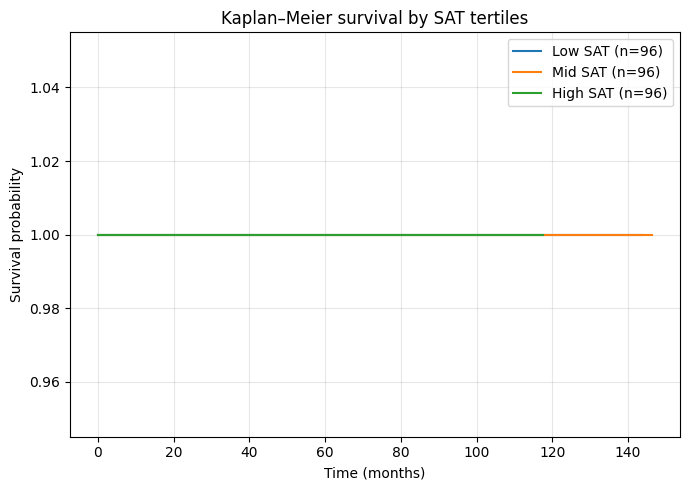

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Coerce event to 0/1 robustly ---
_event = merged["event"]
if _event.dtype == object:
    m = {
        "dead": 1, "death": 1, "deceased": 1, "event": 1, "true": 1, "1": 1, 1: 1,
        "alive": 0, "censored": 0, "false": 0, "0": 0, 0: 0, "na": 0, "": 0
    }
    ev = _event.astype(str).str.strip().str.lower().map(m).astype(float)
else:
    ev = pd.to_numeric(_event, errors="coerce").fillna(0.0)

ev = (ev > 0).astype(int)  # ensure 0/1
tm = pd.to_numeric(merged["time_months"], errors="coerce")

merged = merged.assign(event=ev, time_months=tm).dropna(subset=["time_months","event"])

# Quick sanity prints
print("[KM] events value_counts:", merged["event"].value_counts().to_dict())
print("[KM] time range (months):", float(merged["time_months"].min()), "→", float(merged["time_months"].max()))

# If no events, KM will be flat by definition
if merged["event"].sum() == 0:
    print("[KM] No events present; KM curves will be flat at 1.0")
    
# --- 2) Tertile groups from SAT ---
low_cut  = merged["SAT"].quantile(1/3)
high_cut = merged["SAT"].quantile(2/3)

def _sat_group(x):
    if x <= low_cut:  return "Low SAT"
    if x >= high_cut: return "High SAT"
    return "Mid SAT"

merged["SAT_group"] = merged["SAT"].apply(_sat_group)

# --- 3) KM estimator at unique times ---
def km_from_times_events(times: pd.Series, events: pd.Series):
    """Return stepwise KM curve: unique times, survival probs (post step)."""
    # sort by time
    ord_idx = np.argsort(times.values)
    t = times.values[ord_idx]
    e = events.values[ord_idx].astype(int)

    # unique event/censor times
    uniq_t, idx_start = np.unique(t, return_index=True)
    # counts at each time
    d_at_t = np.zeros_like(uniq_t, dtype=float)  # events
    n_at_t = np.zeros_like(uniq_t, dtype=float)  # at risk just before time

    # precompute counts <= each time (cum)
    # n_at_risk at time u is # with time >= u
    # compute cumulative number with time < u, then n_at_risk = N - cum
    N = len(t)
    # counts exactly at each unique time
    counts_at_t = np.diff(np.append(idx_start, len(t)))
    # events exactly at each unique time
    # for each block of identical times, sum e
    e_cumsum = np.cumsum(e)
    prev_end = 0
    for i, start in enumerate(idx_start):
        end = start + counts_at_t[i]
        d_at_t[i] = e_cumsum[end-1] - (e_cumsum[prev_end-1] if prev_end>0 else 0)
        prev_end = end
    # n_at_t computed from counts of times < u
    cum_counts_before = np.cumsum(np.append([0], counts_at_t[:-1]))
    n_at_t = N - cum_counts_before

    # KM product
    S = np.ones_like(uniq_t, dtype=float)
    surv = 1.0
    for i in range(len(uniq_t)):
        if n_at_t[i] > 0:
            surv *= (n_at_t[i] - d_at_t[i]) / n_at_t[i]
        S[i] = surv

    # build step arrays for plotting (start at 0 with 1.0)
    step_t = np.concatenate([[0.0], uniq_t])
    step_s = np.concatenate([[1.0], S])
    return step_t, step_s

# --- 4) Plot KM for tertiles ---
plt.figure(figsize=(7,5))
for grp in ["Low SAT", "Mid SAT", "High SAT"]:
    sub = merged.loc[merged["SAT_group"] == grp, ["time_months","event"]].dropna()
    if sub.empty:
        continue
    t, s = km_from_times_events(sub["time_months"], sub["event"])
    plt.step(t, s, where="post", label=f"{grp} (n={len(sub)})")

plt.title("Kaplan–Meier survival by SAT tertiles")
plt.xlabel("Time (months)")
plt.ylabel("Survival probability")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 3) Utilities

In [36]:

from __future__ import annotations
import numpy as np
from typing import Dict, List
from scipy import stats

# Optional packages
try:
    import gseapy as gp
except Exception:
    gp = None

def bh_fdr(p: pd.Series) -> pd.Series:
    p = pd.Series(p).astype(float)
    n = p.notna().sum()
    order = p.sort_values().index
    ranks = pd.Series(range(1, n + 1), index=order)
    q = p.copy()
    q.loc[order] = (p.loc[order] * n / ranks).cummin().clip(upper=1.0)
    return q

def zscore_mat(M: pd.DataFrame, axis: int = 0) -> pd.DataFrame:
    return M.apply(lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9), axis=axis)

def intersect_genes(genes: List[str], ref_index: pd.Index) -> List[str]:
    s = pd.Index(genes).dropna().astype(str)
    inter = s.intersection(ref_index.astype(str))
    return inter.tolist()

def module_scores_ssgsea(expr: pd.DataFrame, modules: Dict[str, List[str]], force_mean_z: bool=False) -> pd.DataFrame:
    \"\"\"expr: genes x samples -> returns modules x samples.\"\"\"
    if force_mean_z or gp is None:
        Z = zscore_mat(expr, axis=1)
        out = {}
        for m, g in modules.items():
            keep = intersect_genes(g, Z.index)
            out[m] = Z.loc[keep].mean(axis=0)
        return pd.DataFrame(out).T

    x = expr.T
    ss = gp.ssgsea(data=x, gene_sets=modules, sample_norm_method=None, outdir=None, processes=4, format="png")
    df = pd.DataFrame({k: pd.Series(v) for k, v in ss.res2dn.items()}).T
    return df

def corr_against_matrix(module_scores: pd.Series, M: pd.DataFrame, method: str = "spearman") -> pd.DataFrame:
    common = module_scores.index.intersection(M.columns)
    if len(common) < 5:
        raise ValueError("Too few overlapping samples for correlation.")
    y = module_scores.loc[common]
    X = M.loc[:, common]

    rs, ps, feats = [], [], []
    for feat, row in X.iterrows():
        feats.append(feat)
        if method == "spearman":
            r, p = stats.spearmanr(row.values, y.values, nan_policy='omit')
        else:
            r, p = stats.pearsonr(row.values, y.values)
        rs.append(r); ps.append(p)
    out = pd.DataFrame({"rho": rs, "p": ps}, index=feats)
    out["q"] = bh_fdr(out["p"])
    return out.sort_values("rho", ascending=False)


SyntaxError: unexpected character after line continuation character (2253102615.py, line 30)

## 4) DepMap integration

In [ ]:
import pandas as pd
from pathlib import Path

# ==================== CONFIG ====================
BASE = Path("~/Desktop").expanduser()
MATRIX_PATH = BASE / "gene_dependency_matrix.csv"   # your ACH-xxx gene dependency file
OUT_PATH    = BASE / "gene_dependency_with_names.csv"

# --- Manual mapping (from your list) ---
mapping_dict = {
    "ACH-000022": "PATU8988S",
    "ACH-000023": "PATU8988T",
    "ACH-000094": "HPAFII",
    "ACH-000108": "KP3",
    "ACH-000114": "SU8686",
    "ACH-000118": "HUPT3",
    "ACH-000138": "CFPAC1",
    "ACH-000178": "HS766T",
    "ACH-000205": "PK59",
    "ACH-000213": "HUPT4",
    "ACH-000222": "ASPC1",
    "ACH-000265": "KP4",
    "ACH-000307": "PK1",
    "ACH-000332": "YAPC",
    "ACH-000354": "CAPAN1",
    "ACH-000502": "TCCPAN2",
    "ACH-000517": "SNU410",
    "ACH-000652": "SUIT2",
    "ACH-000685": "L33",
    "ACH-001376": "PACADD135",
    "ACH-001379": "PACADD161",
    "ACH-001380": "PACADD165",
    "ACH-001382": "PACADD188",
    "ACH-002039": "PK8",
    "ACH-003161": "ABMT9430",
    "ACH-003433": "CCLFPANC0019T"
}

# ==================== LOAD MATRIX ====================
df = pd.read_csv(MATRIX_PATH, index_col=0)
df.index = df.index.astype(str).str.strip()

# Map to cell line names, fallback to ACH ID if not found
df.insert(0, "cell_line_name", df.index.map(lambda x: mapping_dict.get(x, x)))

# Optional: reorder columns so cell line name comes first
cols = ["cell_line_name"] + [c for c in df.columns if c != "cell_line_name"]
df = df[cols]

# ==================== SAVE ====================
df.to_csv(OUT_PATH)
print(f"✅ Saved mapped file with cell line names: {OUT_PATH}")


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
import re

# ==================== CONFIG ====================
BASE = Path("~/Desktop").expanduser()
EXPR  = BASE / "PDAC_celllines_expression.csv"     # may be genes×lines OR lines×genes
PRISM = BASE / "PRISM_AUC_PDAC_matrix.csv"         # drugs × cell lines (IDs or names)
OUTDIR = BASE / "prism_module_from_expression_out"
OUTDIR.mkdir(exist_ok=True, parents=True)

# === DepMap_ID → human-readable cell line name (PDAC panel) ===
CELLNAME_MAP = {
    "ACH-000022": "PATU8988S",
    "ACH-000023": "PATU8988T",
    "ACH-000094": "HPAFII",
    "ACH-000108": "KP3",
    "ACH-000114": "SU8686",
    "ACH-000118": "HUPT3",
    "ACH-000138": "CFPAC1",
    "ACH-000178": "HS766T",
    "ACH-000205": "PK59",
    "ACH-000213": "HUPT4",
    "ACH-000222": "ASPC1",
    "ACH-000265": "KP4",
    "ACH-000307": "PK1",
    "ACH-000332": "YAPC",
    "ACH-000354": "CAPAN1",
    "ACH-000502": "TCCPAN2",
    "ACH-000517": "SNU410",
    "ACH-000652": "SUIT2",
    "ACH-000685": "L33",
    "ACH-001376": "PACADD135",
    "ACH-001379": "PACADD161",
    "ACH-001380": "PACADD165",
    "ACH-001382": "PACADD188",
    "ACH-002039": "PK8",
    "ACH-003161": "ABMT9430",
    "ACH-003433": "CCLFPANC0019T",
}
NAME_TO_ID = {v: k for k, v in CELLNAME_MAP.items()}
ACH_RE = re.compile(r"^ACH-\d{6}$", re.I)

# --- Define module gene sets (UP/DOWN) ---
SAT_UP = [
    "ABHD8","AC004870.4","AC005920.1","AC009041.1","AC009309.1","AC011498.1","AC012447.1","AC018521.5",
    "AC018754.1","AC027237.2","AC068338.2","AC072061.1","AC079305.3","AC079807.1","AC087623.2","AC090403.1",
    "AC091271.1","AC092287.1","AC092910.3","AC093323.1","AC099778.1","AC107959.2","AC125611.3","AC144652.1",
    "AC239799.2","AC253572.2","ACBD7","AFMID","AHCY","AL021155.5","AL022069.1","AL031963.3","AL049869.2",
    "AL121574.1","AL133523.1","AL139106.1","AL139246.5","AL355075.4","AL360012.1","AL365436.2","AL592295.5",
    "AL662844.4","AP001160.1","AP002381.2","AP002813.1","ARL4D","ATP2B1-AS1","ATRIP","BAMBI","BHLHE40-AS1",
    "BOLA1","BUD23","C12orf65","C19orf48","C2CD4B","C6orf120","CABYR","CCDC9","CCNE2","CDKN2AIP","CHCHD7",
    "CITED2","CROCC","CSKMT","CTH","DALRD3","DRAIC","DUSP28","EAF2","EIF4A3","FOXA3","FOXL1","GADD45B","GLA",
    "GOT1","GRPEL1","GTF2A1","GTF2B","HEXIM1","HIST1H2AG","HIST1H2AH","HIST1H2AL","HIST1H2BJ","HIST1H2BN",
    "HIST1H3A","HIST1H3J","HIST1H4A","HIST1H4C","HIST1H4E","HIST2H2AC","HIST2H3PS2","HIST3H2A","HIST4H4","HMBS",
    "HSPA2","ID2","IDI1","ING1","KCTD5","KIF9","KLHL11","LAP3","LIFR-AS1","LINC01970","LINC02029","LINC02363",
    "LRG1","LRTOMT","MAFB","MED29","MEPCE","MIR17HG","MORF4L2-AS1","MTHFD2","MYCL","MYOSLID","NANOS1","NPW",
    "NRARP","OAT","OSER1-DT","OSGIN1","PHYH","PICART1","PIEZO1","PIK3R3","PLIN5","PLK2","PMAIP1","PMEL","PNKD",
    "POU3F1","PPP1R3C","PRMT5-AS1","PRR3","PTCH2","PTPN6","RAB26","RALY-AS1","RASL11A","RND1","RNF223","RUVBL2",
    "SAE1","SENP8","SIAH2-AS1","SIRT2","SLC7A5","SNHG12","SNHG5","SNHG8","SREBF2-AS1","SRSF7","STARD5","TBPL1",
    "TCTA","THAP9","TLCD1","TM7SF2","TMEM107","TMEM171","TMEM69","TNFRSF10D","TNK1","TRAM2-AS1","TTC33","UAP1",
    "UBAC2-AS1","UBE2D3-AS1","UBE2S","UGDH","WDR74","Z93241.1","Z99127.4","ZC3H10","ZCWPW1","ZFAS1","ZFX-AS1",
    "ZNF574","ZNF584","ZNF622","ZNF687-AS1","ZNF844","ZNF92","ZSWIM3"
]
SAT_DOWN = [
    "PAX5","AC117386.2","PRSS55","RPS16","GDF7","PAK4","AC022144.1","AC092745.5","AL670729.3",
    "DLEU2L","ELP3","KCNC2","MAP4K1","AL161729.4","SV2C","RGS11","AC005498.1","WFDC5","PSENEN",
    "LINC01956","AC115485.1","CYSLTR2","ASMTL-AS1","AP002001.3","FAM153B"
]
IGE_UP = [
    "PFN2","SET","LGALS1","PDLIM4","EIF5A","F8A1","BANF1","CTDNEP1","TRAPPC1","AMZ2","PTGES3","ST13",
    "FTH1","PCBP1","NAA10","ARPC5L","ETFB","CCDC124","SSR2","PGLS","SELENOH","GSTP1","NDUFB7","AURKAIP1",
    "GCHFR","MYL6","AP2S1","S100A13","C9ORF16","KRT8","PRKCSH","CST3","PET100","DNAJA2","VPS35","VDAC1",
    "MGST3","PRR13","OCIAD2","FUOM","MIA","RPN1","FUCA2","TMED4","ERGIC3","DDOST","NAXE","SNRPD1","SKP1",
    "CNBP","ATP5MC3","SLC25A5","LSM4","NDUFAB1","PCBD1","HINT1","ADI1","NENF","MRPL43","VKORC1","EMC4",
    "COA3","NEDD8","CHCHD2","PRDX5","WDR83OS","NDUFA4","GABARAP","PHPT1","UFC1","MDH1","ATP5F1E","MRPL41",
    "UBL5","COX5B","ELOB","ATP5ME","UQCRB","SEM1","NDUFB1","COX6C","ATP6V1F","HNRNPA1","HIGD2A","POLR2I",
    "METTL26","NDUFB4","OST4","C19ORF53","RPL36AL","PPIA","COPS9","COX8A","COX5A","RPL36","RPS15","RPS27",
    "RPS11","FTL","SNHG29","NACA","RPS17","RPL23","RPL39","RPS21","RPL9","RPL15","RPL34","RPL27A","RPL36A",
    "RPL38","RPS26","RPS14","RPL35","RPL37A","RPL37","RPL12","RPS29"
]
IGE_DOWN = [
    "STT3A","SGPP1","LINGO1","ASS1","CETN2","HNRNPH1","STN1","NRG4","IQSEC2","IYD","CHD9","APBB1IP",
    "TMEM238","REX1BD","IFI27","CYBA","METRNL","AKR7A2","SULT1A1","ARHGEF35","AC008397.1","KLK11",
    "DELE1","MISP","FAM234A","CMBL"
]
IL2_UP = [
    "ABHD15-AS1","AC007780.1","AC008105.3","AC008964.1","AC016831.1","AC016831.5","AC090772.1","AC108863.2",
    "ADARB1","ALOX5AP","ANKH","ANKRD44","APOBEC3G","ARHGDIB","ARL6IP5","ARSG","ATP10D","BCL11B","BORCS5",
    "CAMK1D","CD4","CD84","CD96","CDC42EP3","CELF2","CERS4","CLEC2D","CNOT6L","CRYBG1","CTSW","DSE","FGD3",
    "FMNL1","FOXN3","FOXO1","FYB1","GFI1","GNAO1","GPRIN3","HOPX","IGF1","IKZF3","IL18R1","INKA2","INSYN2B",
    "IQSEC1","ITPRIPL1","JAK3","KLRC2","KLRC3","KLRF1","KLRG1","LAPTM5","LCP1","LEPROTL1","LINC00513",
    "LINC01237","MAN1A1","MAPRE2","MPHOSPH9","MPP7","MVB12B","MYO5A","NIN","PARP11","PARP15","PCED1B-AS1",
    "PDE3B","PIP4K2A","PLCL1","PLEKHA2","PPP3CC","PRKCH","PRKCQ","PRKD3","PRKX","PTPN22","RAC2","RASGRF2",
    "RFX3","RIPOR2","RNF166","S1PR4","SAMD3","SENP7","SH2B3","SH2D2A","SMARCA2","SNHG26","SPOCK2","SRGN",
    "ST8SIA1","STAT5A","STAT5B","STIM1","STK17A","TMEM200A","TMX4","TRBC2","TRDC","TRIM22","TTN","VAV3",
    "WNT5A-AS1","ZNF101","ZNF471"
]
IL2_DOWN = [
    "RBP7","OVCA2","PLAC4","AC026785.3","LINC02212","LINC00605","AC246817.2","FOXCUT","VGLL2","ZIC4","FOLR3",
    "ECEL1","AC024337.1","C5orf58","AC060814.3","B4GALNT1","UCHL1","VAX1","AL451042.1","COMMD8","IFI30",
    "AL096794.1","RGS10"
]
MPC_UP = [
    "KIAA1211L","CASC4","AHR","YY1AP1","COPA","RELL1","FBXW2","CARMIL1","NUBPL","ZC3H18","AGK","HLCS",
    "TMEM241","URGCP","CADPS2","COBL","ARHGAP42","AC138305.1","FAM135A","SLC41A2","TACC2","MCU","FMN1",
    "LGR4","BAIAP2L1","SGPP2","RGS12","PTPN3","IBTK","SPRY4-AS1","UGT8","PNN","SP140L","PIK3CA","CNOT2",
    "ZFC3H1","UBE2K","STRN3","STAG2","KDM5A","RC3H2","TP53BP1","SLC9A8","ATF7IP","MLLT10","SCAPER","CPSF6",
    "KLC1","HUWE1","TAOK3","ROCK1","MAN2A1","ZNF44","ARGLU1","EHMT1","HTT","SIN3A","RSBN1L","MLLT3","RABGAP1",
    "SCFD1","NEMF","DMXL1","RCOR3","NAA35","WWP1","VPS41","PRRC2B","STX16","ANKRD11","ARHGEF7","SOS2","SLAIN2",
    "LUC7L2","SRPK2","TYW1","HMBOX1","LMBR1","TCF12","MBD5","MON2","COG5","LONP2","RAB3GAP2","LARP4B","NUMB",
    "NF1","NCOA2","ZNF710","CSNK1G1","WDR37","NUTM2B-AS1","ITFG1","UBE3C","MFSD14C","SPG11","PTK2","LPP",
    "ZBTB20","FCHO2","PTPN12","DCUN1D4","KDM7A","SLMAP","KIF13B","MIB1","DIP2C","LRCH1","TNIK","TNKS","SMC5",
    "ANKIB1","RBM33","TNPO3","OSBPL3","RAPGEF2","MED13L","FBXL20","KIAA0232","ITCH","MARCH6","ARID4B","PLEKHA6",
    "FNBP1L","KIAA1217","FARP2","MAGI3","DIAPH2","VPS13A","DGKH","GNAQ","ARHGEF12","MYO1D","CDC42BPA","TTC7A",
    "TRIM44","NSD3","NCOA3","ADNP","RUFY3","RUNX1","TRRAP","PTBP2","ZNF609","CHD7","PARP8","ARIH1","ZHX2",
    "ETV6","CUL1","CDK13","BRAF","MBTD1","AUH","STX17","POLR2J3","KLHDC10","TAF1","TOGARAM1","WRN","ADK",
    "TASOR2","NUDCD3","TBL1X","MOSMO","USP42","CRCP","GALNT11","DDI2","TTC14","UPF2","PDXDC1","ETFDH","SEL1L3",
    "HEATR5A","PSMD5","TBC1D2B","NUP214","GAPVD1","RNF19A","SMURF2","NRIP1","WDFY2","TBK1","LCORL","USP25",
    "RABGEF1","CASD1","RBPJ","AEBP2","MALAT1","MAML2","RBMS1","CRIM1","SNX29","PPFIBP1","SVIL","DDX24","G2E3",
    "RASA1","FAM160A1","RNF24","ESYT2","EPS8","SESTD1","ATP2B4","PELI1","RNF145","B4GALT5","PPP2R2A","NOS1AP",
    "EGFR","CPNE8","ARHGAP21","SMAD3","DAPK1","IGF1R","AFAP1","KLF7","DOCK5","MINDY2","ZXDC","NEDD4","METTL15",
    "FNIP2","NEAT1","CELF1","DANT2","SYT17","TMEM245","ERICH1","ADPGK","LMBRD1","MFSD11","GOLGA2","SCNN1A",
    "XDH","PLEKHA1","PPP2CB","GTF2E2","KCNK1","SPATS2L","RTF1","UACA","VAV2","MDFIC","STAM","CLIP4","KYAT1",
    "MECP2","NUP160","THOC1","LINC-PINT","MCPH1","DISC1","UBA6-AS1","AAK1","NRF1","PHF20","RNF216","PCM1","SAFB2",
    "FAM133B","NR6A1","ATL2","C1orf21","MTUS1","PARD3B","EXT1","ST5","ABI2","INTS6L","TRIM56","PTER","PRR12",
    "RSPH3","TMC5","MECOM","ARHGEF10L","HNF4G","PPM1H","AP005230.1","AC119674.1","ZSCAN18","NOL4L","PDPK1",
    "RSU1","TTC39C","COL27A1","SEC16B","AC005162.3","RASAL1","IL17RA","SPART-AS1","CDC37","MUCL3","TMEM178B",
    "LINC02614","EREG","ELK3","TMTC1","PALM2-AKAP2","RAB31","EMP3"
]
MPC_DOWN = [
    "MRPS15","TALDO1","MDH2","PSMB5","PIK3CD-AS2","DUSP9","POPDC3","AKR1C3","MRPS18A","EIF3H","UQCRC2",
    "IFT22","RAB11B","MBOAT7"
]

MODULES = {
    "SAT": (SAT_UP, SAT_DOWN),
    "IGE": (IGE_UP, IGE_DOWN),
    "IL2": (IL2_UP, IL2_DOWN),
    "MPC": (MPC_UP, MPC_DOWN),
}

# ==================== HELPERS ====================
def zscore_rows(df):
    mu = df.mean(axis=1)
    sd = df.std(axis=1, ddof=0).replace(0, np.nan)
    return df.sub(mu, axis=0).div(sd, axis=0)

def score_module(Z, up_genes, down_genes):
    up = [g for g in up_genes if g in Z.index]
    down = [g for g in down_genes if g in Z.index]
    if len(up)==0 or len(down)==0:
        return pd.Series(np.nan, index=Z.columns)
    return Z.loc[up].mean(axis=0) - Z.loc[down].mean(axis=0)

def hedges_g(x, y):
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2: return np.nan
    sp2 = ((nx-1)*np.var(x, ddof=1)+(ny-1)*np.var(y, ddof=1)) / (nx+ny-2)
    if sp2 <= 0 or np.isnan(sp2): return np.nan
    d = (x.mean()-y.mean())/np.sqrt(sp2)
    J = 1 - (3/(4*(nx+ny)-9))
    return d*J

def cliffs_delta(x,y):
    x = x.reshape(-1,1); y = y.reshape(1,-1)
    return ((x>y)-(x<y)).sum()/(x.size*y.size)

def bh_fdr(p):
    p = np.asarray(p, float); n = len(p)
    order = np.argsort(p); ranked = np.empty_like(p); prev = 1
    for i, idx in enumerate(order[::-1], start=1):
        rank = n - i + 1
        val = min(prev, p[idx] * n / rank)
        ranked[idx] = val; prev = val
    return ranked

def map_any_to_ids(labels):
    out = []
    for c in labels:
        c = str(c).strip()
        if ACH_RE.match(c):              # already an ID
            out.append(c.upper())
        elif c in NAME_TO_ID:            # name -> ID
            out.append(NAME_TO_ID[c])
        else:
            out.append(c)                # leave as-is
    return out

def ids_to_names(labels):
    return [CELLNAME_MAP.get(str(c).strip(), str(c).strip()) for c in labels]

def is_gene_like_list(vals):
    vals = [str(v) for v in vals]
    pat = re.compile(r"^[A-Za-z0-9][A-Za-z0-9\.\-]{1,19}$")
    hits = sum(bool(pat.match(v)) for v in vals)
    return hits / max(1, len(vals)) > 0.7

def is_cellline_like_list(vals):
    vals = [str(v) for v in vals]
    ach = sum(bool(ACH_RE.match(v)) for v in vals)
    names = sum(v in NAME_TO_ID for v in vals)
    return (ach + names) / max(1, len(vals)) > 0.3

# ==================== 1) LOAD EXPRESSION & FIX ORIENTATION ====================
expr_raw = pd.read_csv(EXPR, index_col=0)
idx, cols = list(expr_raw.index), list(expr_raw.columns)

rows_look_like_cells = is_cellline_like_list(idx)
cols_look_like_cells = is_cellline_like_list(cols)
rows_look_like_genes = is_gene_like_list(idx)
cols_look_like_genes = is_gene_like_list(cols)

# Decide orientation: want genes × cell lines (columns are lines)
if cols_look_like_cells and rows_look_like_genes:
    expr = expr_raw.copy()
elif rows_look_like_cells and cols_look_like_genes:
    expr = expr_raw.T.copy()   # transpose to genes × lines
else:
    # fallback: if columns count < rows count and columns look like cells, keep; else transpose
    expr = expr_raw if (len(cols) < len(idx) and cols_look_like_cells) else expr_raw.T.copy()

# Normalize cell-line columns to DepMap_IDs
expr.columns = pd.Index(map_any_to_ids(expr.columns), dtype=str)
# Collapse duplicate IDs if any (mean)
expr = (expr.T.groupby(level=0).mean(numeric_only=True)).T

# Clean genes
expr.index = pd.Index([str(g).upper().strip() for g in expr.index], dtype=str)
print(f"[EXPR] genes × lines: {expr.shape}")

Z = zscore_rows(expr)

# ==================== 2) COMPUTE MODULE SCORES ====================
module_scores = pd.DataFrame(index=expr.columns)
for mod, (up, down) in MODULES.items():
    module_scores[mod] = score_module(Z, up, down)

module_scores_named = module_scores.copy()
module_scores_named.index = ids_to_names(module_scores_named.index)
module_scores_named.to_csv(OUTDIR / "module_scores_with_names.csv")
print("[MODULE SCORES] saved module_scores_with_names.csv")

# ==================== 3) LOAD PRISM (drugs × lines) & NORMALIZE ====================
prism = pd.read_csv(PRISM, index_col=0)
prism.columns = pd.Index(map_any_to_ids(prism.columns), dtype=str)
prism = prism.loc[:, ~prism.columns.duplicated()]  # just in case

# Intersect on DepMap_IDs
shared = sorted(set(prism.columns).intersection(module_scores.index))
pd.DataFrame({"DepMap_ID": shared, "cell_line_name": ids_to_names(shared)}).to_csv(
    OUTDIR / "shared_cell_lines.csv", index=False
)

prism = prism[shared]
module_scores = module_scores.loc[shared]
print(f"[PRISM] {prism.shape[0]} drugs × {prism.shape[1]} shared PDAC lines")

# ==================== 4) ASSOCIATION TESTS ====================
def run_assoc(mod, s, prism_mat, shared_ids):
    lo, hi = s.quantile(1/3), s.quantile(2/3)
    low_ids  = s.index[s <= lo]
    high_ids = s.index[s >= hi]

    results = []
    for drug in prism_mat.index:
        y = prism_mat.loc[drug, shared_ids].astype(float)
        x = s.loc[shared_ids].astype(float)
        ok = (~y.isna()) & (~x.isna())
        if ok.sum() < 6:
            continue

        r, p_spear = stats.spearmanr(x[ok], y[ok])

        yl = prism_mat.loc[drug, low_ids].dropna().values
        yh = prism_mat.loc[drug, high_ids].dropna().values
        p_u = g_eff = d_eff = np.nan
        if (yl.size >= 4) and (yh.size >= 4):
            try:
                _, p_u = stats.mannwhitneyu(yl, yh, alternative="two-sided")
                g_eff = hedges_g(yh, yl)
                d_eff = cliffs_delta(yh, yl)
            except Exception:
                pass

        results.append([drug, r, p_spear, p_u, g_eff, d_eff])

    if not results:
        return pd.DataFrame(columns=["spearman_rho","spearman_p","spearman_q","hedges_g","u_p","u_q"])

    out = pd.DataFrame(results, columns=["drug","spearman_rho","spearman_p","u_p","hedges_g","cliffs_delta"]).set_index("drug")
    # FDRs
    out["spearman_q"] = bh_fdr(out["spearman_p"].fillna(1))
    out["u_q"]        = bh_fdr(out["u_p"].fillna(1))
    out = out.sort_values("spearman_p")
    return out

for mod in MODULES.keys():
    out = run_assoc(mod, module_scores[mod], prism, shared)
    out.to_csv(OUTDIR / f"prism_{mod}_association.csv")
    print(f"[{mod}] top 5 (Spearman):")
    print(out.head(5)[["spearman_rho","spearman_p","spearman_q","hedges_g","u_p","u_q"]])

print("✅ Done. Results written to:", OUTDIR)


In [ ]:
import re, pandas as pd
from pathlib import Path
BASE = Path("~/Desktop").expanduser()

EXPR  = pd.read_csv(BASE/"PDAC_celllines_expression.csv", index_col=0)
PRISM = pd.read_csv(BASE/"PRISM_AUC_PDAC_matrix.csv",    index_col=0)

ACH = re.compile(r"^ACH-\d{6}$", re.I)
expr_cols = list(map(str, EXPR.columns))
expr_idx  = list(map(str, EXPR.index))
prism_cols= list(map(str, PRISM.columns))

print("[expr] shape", EXPR.shape)
print("[prism] shape", PRISM.shape)

print("expr columns look like ACH?:", sum(bool(ACH.match(c)) for c in expr_cols))
print("expr index   look like genes?:", sum(bool(re.fullmatch(r"[A-Za-z0-9][A-Za-z0-9.\-]{1,19}", g)) for g in expr_idx))

print("prism columns ACH?:", sum(bool(ACH.match(c)) for c in prism_cols))

shared = sorted(set(c for c in expr_cols if ACH.match(c)).intersection(c for c in prism_cols if ACH.match(c)))
print("shared ACH IDs:", len(shared), shared[:10])


In [ ]:
import pandas as pd
from pathlib import Path
from glob import glob

# --- expr already in memory (genes x ACH columns) ---
print("[expr]", expr.shape)
print("expr ACH head:", expr.columns[:5].tolist())

HOME = Path.home()

# ---- Locate long-format PRISM file ----
long_candidates = [
    Path("PRISM_AUC_PDAC_long.csv"),
    HOME/"Desktop/PRISM_AUC_PDAC_long.csv",
    HOME/"Downloads/PRISM_AUC_PDAC_long.csv",
]
if not any(p.exists() for p in long_candidates):
    found = glob(str(HOME / "**/PRISM_AUC_PDAC_long.csv"), recursive=True)
    if found: long_candidates.insert(0, Path(found[0]))
PRISM_LONG = next((p for p in long_candidates if p.exists()), None)
assert PRISM_LONG is not None, "Could not find PRISM_AUC_PDAC_long.csv."

print(f"[prism long path] {PRISM_LONG}")

# ---- Read long file ----
long = pd.read_csv(PRISM_LONG)
print("[long] shape:", long.shape)
print("[long] columns:", long.columns.tolist()[:12])

# Identify column names (robust to variants)
cols = {c.lower(): c for c in long.columns}

ccle_col = cols.get("ccle_name") or cols.get("cclename") or cols.get("ccle") or cols.get("cell_line")
assert ccle_col, f"Need CCLE name column; available: {long.columns.tolist()}"

# Drug identifier: prefer 'compound'/'name'/'drug'/'broad_id'
drug_col = (cols.get("compound") or cols.get("drug") or cols.get("name") or 
            cols.get("pert_iname") or cols.get("broad_id") or cols.get("brd_id"))
assert drug_col, f"Need a drug/compound column; available: {long.columns.tolist()}"

# AUC value column (try common names)
auc_col = (cols.get("auc") or cols.get("area_under_curve") or cols.get("auc_mean") or 
           cols.get("auc_value") or cols.get("auc_avg"))
assert auc_col, f"Need an AUC column; available: {long.columns.tolist()}"

# Keep only what's needed
keep = long[[ccle_col, drug_col, auc_col]].copy()
keep = keep.dropna(subset=[ccle_col, drug_col, auc_col])
print("[long] non-null rows:", keep.shape[0])

# Pivot to matrix (cell lines x drugs), averaging duplicates
prism = (
    keep.groupby([ccle_col, drug_col], as_index=False)[auc_col]
        .mean()
        .pivot(index=ccle_col, columns=drug_col, values=auc_col)
)
print("[prism matrix] shape:", prism.shape)
print("index head:", prism.index[:5].tolist())
print("cols head:", prism.columns[:5].tolist())

# ---- Load DepMap model info for CCLE -> ACH mapping ----
model_candidates = [
    Path("Model.csv"), Path("sample_info.csv"),
    HOME/"Desktop/Model.csv", HOME/"Desktop/sample_info.csv",
    HOME/"Downloads/Model.csv", HOME/"Downloads/sample_info.csv",
]
if not any(p.exists() for p in model_candidates):
    found = glob(str(HOME / "**/Model.csv"), recursive=True) + glob(str(HOME / "**/sample_info.csv"), recursive=True)
    if found: model_candidates.insert(0, Path(found[0]))
MODEL = next((p for p in model_candidates if p.exists()), None)
assert MODEL is not None, "Could not find Model.csv or sample_info.csv."

info = pd.read_csv(MODEL)
icol = {c.lower(): c for c in info.columns}
ach_col = icol.get("ach_id") or icol.get("modelid") or icol.get("model_id")
ccle_info_col = icol.get("ccle_name") or icol.get("cclename")
assert ach_col and ccle_info_col, f"Model file must include CCLE_Name and ACH_ID/ModelID; found: {info.columns.tolist()}"

map_ccle_to_ach = dict(zip(info[ccle_info_col], info[ach_col]))

# Some CCLEs may have tissue suffix (e.g., ASPC1_PANCREAS)
def strip_suffix(name):
    return name.rsplit("_", 1)[0] if isinstance(name, str) and "_" in name else name

# Try direct mapping, else try stripped suffix
prism1 = prism.rename(index=map_ccle_to_ach)
shared1 = expr.columns.intersection(prism1.index)

if len(shared1) < 10:
    prism2 = prism.copy()
    prism2.index = prism2.index.map(strip_suffix)
    prism2 = prism2.rename(index=map_ccle_to_ach)
    shared2 = expr.columns.intersection(prism2.index)
    if len(shared2) >= len(shared1):
        prism_mapped, shared = prism2, shared2
        used = "stripped CCLE suffix"
    else:
        prism_mapped, shared = prism1, shared1
        used = "direct CCLE"
else:
    prism_mapped, shared = prism1, shared1
    used = "direct CCLE"

print(f"[map] method: {used}")
print(f"[align] shared ACH with expr: {len(shared)}")
print("shared head:", shared[:10].tolist())

# ---- Align and save ----
expr_aln  = expr.loc[:, shared].copy()
prism_aln = prism_mapped.loc[shared, :].copy()

print("[expr_aln]", expr_aln.shape, "| [prism_aln]", prism_aln.shape)

OUTDIR = Path("out_prism_align"); OUTDIR.mkdir(exist_ok=True)
expr_aln.to_csv(OUTDIR / "expr_genesXACH_shared.csv")
prism_aln.to_csv(OUTDIR / "prism_ACHXdrugs_shared.csv")

audit = pd.DataFrame({
    "prism_rows_total":[prism.shape[0]],
    "shared_ACH":[len(shared)],
    "expr_genes":[expr.shape[0]],
    "expr_samples":[expr.shape[1]],
    "prism_drugs":[prism_aln.shape[1]],
    "mapping_method":[used],
})
audit.to_csv(OUTDIR / "alignment_audit.csv", index=False)
audit


In [ ]:
import pandas as pd, numpy as np, re
from pathlib import Path
from collections.abc import Iterable

# expr already in memory (rows=genes, cols=ACH)
print("[expr]", expr.shape)

# ==== Paste your gene lists below ====
# You can use EITHER strings (one per line/commas ok) OR Python lists like ['GATA6','KRT17',...]
SAT_UP = [
    "ABHD8","AC004870.4","AC005920.1","AC009041.1","AC009309.1","AC011498.1","AC012447.1","AC018521.5",
    "AC018754.1","AC027237.2","AC068338.2","AC072061.1","AC079305.3","AC079807.1","AC087623.2","AC090403.1",
    "AC091271.1","AC092287.1","AC092910.3","AC093323.1","AC099778.1","AC107959.2","AC125611.3","AC144652.1",
    "AC239799.2","AC253572.2","ACBD7","AFMID","AHCY","AL021155.5","AL022069.1","AL031963.3","AL049869.2",
    "AL121574.1","AL133523.1","AL139106.1","AL139246.5","AL355075.4","AL360012.1","AL365436.2","AL592295.5",
    "AL662844.4","AP001160.1","AP002381.2","AP002813.1","ARL4D","ATP2B1-AS1","ATRIP","BAMBI","BHLHE40-AS1",
    "BOLA1","BUD23","C12orf65","C19orf48","C2CD4B","C6orf120","CABYR","CCDC9","CCNE2","CDKN2AIP","CHCHD7",
    "CITED2","CROCC","CSKMT","CTH","DALRD3","DRAIC","DUSP28","EAF2","EIF4A3","FOXA3","FOXL1","GADD45B","GLA",
    "GOT1","GRPEL1","GTF2A1","GTF2B","HEXIM1","HIST1H2AG","HIST1H2AH","HIST1H2AL","HIST1H2BJ","HIST1H2BN",
    "HIST1H3A","HIST1H3J","HIST1H4A","HIST1H4C","HIST1H4E","HIST2H2AC","HIST2H3PS2","HIST3H2A","HIST4H4","HMBS",
    "HSPA2","ID2","IDI1","ING1","KCTD5","KIF9","KLHL11","LAP3","LIFR-AS1","LINC01970","LINC02029","LINC02363",
    "LRG1","LRTOMT","MAFB","MED29","MEPCE","MIR17HG","MORF4L2-AS1","MTHFD2","MYCL","MYOSLID","NANOS1","NPW",
    "NRARP","OAT","OSER1-DT","OSGIN1","PHYH","PICART1","PIEZO1","PIK3R3","PLIN5","PLK2","PMAIP1","PMEL","PNKD",
    "POU3F1","PPP1R3C","PRMT5-AS1","PRR3","PTCH2","PTPN6","RAB26","RALY-AS1","RASL11A","RND1","RNF223","RUVBL2",
    "SAE1","SENP8","SIAH2-AS1","SIRT2","SLC7A5","SNHG12","SNHG5","SNHG8","SREBF2-AS1","SRSF7","STARD5","TBPL1",
    "TCTA","THAP9","TLCD1","TM7SF2","TMEM107","TMEM171","TMEM69","TNFRSF10D","TNK1","TRAM2-AS1","TTC33","UAP1",
    "UBAC2-AS1","UBE2D3-AS1","UBE2S","UGDH","WDR74","Z93241.1","Z99127.4","ZC3H10","ZCWPW1","ZFAS1","ZFX-AS1",
    "ZNF574","ZNF584","ZNF622","ZNF687-AS1","ZNF844","ZNF92","ZSWIM3"
]
SAT_DOWN = [
    "PAX5","AC117386.2","PRSS55","RPS16","GDF7","PAK4","AC022144.1","AC092745.5","AL670729.3",
    "DLEU2L","ELP3","KCNC2","MAP4K1","AL161729.4","SV2C","RGS11","AC005498.1","WFDC5","PSENEN",
    "LINC01956","AC115485.1","CYSLTR2","ASMTL-AS1","AP002001.3","FAM153B"
]
IGE_UP = [
    "PFN2","SET","LGALS1","PDLIM4","EIF5A","F8A1","BANF1","CTDNEP1","TRAPPC1","AMZ2","PTGES3","ST13",
    "FTH1","PCBP1","NAA10","ARPC5L","ETFB","CCDC124","SSR2","PGLS","SELENOH","GSTP1","NDUFB7","AURKAIP1",
    "GCHFR","MYL6","AP2S1","S100A13","C9ORF16","KRT8","PRKCSH","CST3","PET100","DNAJA2","VPS35","VDAC1",
    "MGST3","PRR13","OCIAD2","FUOM","MIA","RPN1","FUCA2","TMED4","ERGIC3","DDOST","NAXE","SNRPD1","SKP1",
    "CNBP","ATP5MC3","SLC25A5","LSM4","NDUFAB1","PCBD1","HINT1","ADI1","NENF","MRPL43","VKORC1","EMC4",
    "COA3","NEDD8","CHCHD2","PRDX5","WDR83OS","NDUFA4","GABARAP","PHPT1","UFC1","MDH1","ATP5F1E","MRPL41",
    "UBL5","COX5B","ELOB","ATP5ME","UQCRB","SEM1","NDUFB1","COX6C","ATP6V1F","HNRNPA1","HIGD2A","POLR2I",
    "METTL26","NDUFB4","OST4","C19ORF53","RPL36AL","PPIA","COPS9","COX8A","COX5A","RPL36","RPS15","RPS27",
    "RPS11","FTL","SNHG29","NACA","RPS17","RPL23","RPL39","RPS21","RPL9","RPL15","RPL34","RPL27A","RPL36A",
    "RPL38","RPS26","RPS14","RPL35","RPL37A","RPL37","RPL12","RPS29"
]
IGE_DOWN = [
    "STT3A","SGPP1","LINGO1","ASS1","CETN2","HNRNPH1","STN1","NRG4","IQSEC2","IYD","CHD9","APBB1IP",
    "TMEM238","REX1BD","IFI27","CYBA","METRNL","AKR7A2","SULT1A1","ARHGEF35","AC008397.1","KLK11",
    "DELE1","MISP","FAM234A","CMBL"
]
IL2_UP = [
    "ABHD15-AS1","AC007780.1","AC008105.3","AC008964.1","AC016831.1","AC016831.5","AC090772.1","AC108863.2",
    "ADARB1","ALOX5AP","ANKH","ANKRD44","APOBEC3G","ARHGDIB","ARL6IP5","ARSG","ATP10D","BCL11B","BORCS5",
    "CAMK1D","CD4","CD84","CD96","CDC42EP3","CELF2","CERS4","CLEC2D","CNOT6L","CRYBG1","CTSW","DSE","FGD3",
    "FMNL1","FOXN3","FOXO1","FYB1","GFI1","GNAO1","GPRIN3","HOPX","IGF1","IKZF3","IL18R1","INKA2","INSYN2B",
    "IQSEC1","ITPRIPL1","JAK3","KLRC2","KLRC3","KLRF1","KLRG1","LAPTM5","LCP1","LEPROTL1","LINC00513",
    "LINC01237","MAN1A1","MAPRE2","MPHOSPH9","MPP7","MVB12B","MYO5A","NIN","PARP11","PARP15","PCED1B-AS1",
    "PDE3B","PIP4K2A","PLCL1","PLEKHA2","PPP3CC","PRKCH","PRKCQ","PRKD3","PRKX","PTPN22","RAC2","RASGRF2",
    "RFX3","RIPOR2","RNF166","S1PR4","SAMD3","SENP7","SH2B3","SH2D2A","SMARCA2","SNHG26","SPOCK2","SRGN",
    "ST8SIA1","STAT5A","STAT5B","STIM1","STK17A","TMEM200A","TMX4","TRBC2","TRDC","TRIM22","TTN","VAV3",
    "WNT5A-AS1","ZNF101","ZNF471"
]
IL2_DOWN = [
    "RBP7","OVCA2","PLAC4","AC026785.3","LINC02212","LINC00605","AC246817.2","FOXCUT","VGLL2","ZIC4","FOLR3",
    "ECEL1","AC024337.1","C5orf58","AC060814.3","B4GALNT1","UCHL1","VAX1","AL451042.1","COMMD8","IFI30",
    "AL096794.1","RGS10"
]
MPC_UP = [
    "KIAA1211L","CASC4","AHR","YY1AP1","COPA","RELL1","FBXW2","CARMIL1","NUBPL","ZC3H18","AGK","HLCS",
    "TMEM241","URGCP","CADPS2","COBL","ARHGAP42","AC138305.1","FAM135A","SLC41A2","TACC2","MCU","FMN1",
    "LGR4","BAIAP2L1","SGPP2","RGS12","PTPN3","IBTK","SPRY4-AS1","UGT8","PNN","SP140L","PIK3CA","CNOT2",
    "ZFC3H1","UBE2K","STRN3","STAG2","KDM5A","RC3H2","TP53BP1","SLC9A8","ATF7IP","MLLT10","SCAPER","CPSF6",
    "KLC1","HUWE1","TAOK3","ROCK1","MAN2A1","ZNF44","ARGLU1","EHMT1","HTT","SIN3A","RSBN1L","MLLT3","RABGAP1",
    "SCFD1","NEMF","DMXL1","RCOR3","NAA35","WWP1","VPS41","PRRC2B","STX16","ANKRD11","ARHGEF7","SOS2","SLAIN2",
    "LUC7L2","SRPK2","TYW1","HMBOX1","LMBR1","TCF12","MBD5","MON2","COG5","LONP2","RAB3GAP2","LARP4B","NUMB",
    "NF1","NCOA2","ZNF710","CSNK1G1","WDR37","NUTM2B-AS1","ITFG1","UBE3C","MFSD14C","SPG11","PTK2","LPP",
    "ZBTB20","FCHO2","PTPN12","DCUN1D4","KDM7A","SLMAP","KIF13B","MIB1","DIP2C","LRCH1","TNIK","TNKS","SMC5",
    "ANKIB1","RBM33","TNPO3","OSBPL3","RAPGEF2","MED13L","FBXL20","KIAA0232","ITCH","MARCH6","ARID4B","PLEKHA6",
    "FNBP1L","KIAA1217","FARP2","MAGI3","DIAPH2","VPS13A","DGKH","GNAQ","ARHGEF12","MYO1D","CDC42BPA","TTC7A",
    "TRIM44","NSD3","NCOA3","ADNP","RUFY3","RUNX1","TRRAP","PTBP2","ZNF609","CHD7","PARP8","ARIH1","ZHX2",
    "ETV6","CUL1","CDK13","BRAF","MBTD1","AUH","STX17","POLR2J3","KLHDC10","TAF1","TOGARAM1","WRN","ADK",
    "TASOR2","NUDCD3","TBL1X","MOSMO","USP42","CRCP","GALNT11","DDI2","TTC14","UPF2","PDXDC1","ETFDH","SEL1L3",
    "HEATR5A","PSMD5","TBC1D2B","NUP214","GAPVD1","RNF19A","SMURF2","NRIP1","WDFY2","TBK1","LCORL","USP25",
    "RABGEF1","CASD1","RBPJ","AEBP2","MALAT1","MAML2","RBMS1","CRIM1","SNX29","PPFIBP1","SVIL","DDX24","G2E3",
    "RASA1","FAM160A1","RNF24","ESYT2","EPS8","SESTD1","ATP2B4","PELI1","RNF145","B4GALT5","PPP2R2A","NOS1AP",
    "EGFR","CPNE8","ARHGAP21","SMAD3","DAPK1","IGF1R","AFAP1","KLF7","DOCK5","MINDY2","ZXDC","NEDD4","METTL15",
    "FNIP2","NEAT1","CELF1","DANT2","SYT17","TMEM245","ERICH1","ADPGK","LMBRD1","MFSD11","GOLGA2","SCNN1A",
    "XDH","PLEKHA1","PPP2CB","GTF2E2","KCNK1","SPATS2L","RTF1","UACA","VAV2","MDFIC","STAM","CLIP4","KYAT1",
    "MECP2","NUP160","THOC1","LINC-PINT","MCPH1","DISC1","UBA6-AS1","AAK1","NRF1","PHF20","RNF216","PCM1","SAFB2",
    "FAM133B","NR6A1","ATL2","C1orf21","MTUS1","PARD3B","EXT1","ST5","ABI2","INTS6L","TRIM56","PTER","PRR12",
    "RSPH3","TMC5","MECOM","ARHGEF10L","HNF4G","PPM1H","AP005230.1","AC119674.1","ZSCAN18","NOL4L","PDPK1",
    "RSU1","TTC39C","COL27A1","SEC16B","AC005162.3","RASAL1","IL17RA","SPART-AS1","CDC37","MUCL3","TMEM178B",
    "LINC02614","EREG","ELK3","TMTC1","PALM2-AKAP2","RAB31","EMP3"
]
MPC_DOWN = [
    "MRPS15","TALDO1","MDH2","PSMB5","PIK3CD-AS2","DUSP9","POPDC3","AKR1C3","MRPS18A","EIF3H","UQCRC2",
    "IFT22","RAB11B","MBOAT7"
]
# =====================================

def parse_genes(obj):
    """Accept str/list/tuple/set/Series; return a clean list of symbols."""
    if obj is None:
        return []
    # pandas Series/Index
    if hasattr(obj, "tolist"):
        obj = obj.tolist()
    # list-like (but not str/bytes)
    if isinstance(obj, Iterable) and not isinstance(obj, (str, bytes)):
        flat = []
        for x in obj:
            if x is None: continue
            if hasattr(x, "tolist"):
                flat.extend(x.tolist())
            elif isinstance(x, (str, bytes)):
                flat.extend(re.split(r"[,\s]+", x.strip()))
            else:
                flat.append(str(x))
        genes = [g for g in flat if g]
        return genes
    # string path: split on commas/whitespace/newlines
    s = obj.strip()
    if not s:
        return []
    s = re.sub(r"[,\s]+", "\n", s)
    return [g for g in s.splitlines() if g]

# Build modules (normalize keys to lower-case)
MODULES = {
    "SAT": {"up": parse_genes(SAT_UP), "down": parse_genes(SAT_DOWN)},
    "IGE": {"up": parse_genes(IGE_UP), "down": parse_genes(IGE_DOWN)},
    "IL2": {"up": parse_genes(IL2_UP), "down": parse_genes(IL2_DOWN)},
    "MPC": {"up": parse_genes(MPC_UP), "down": parse_genes(MPC_DOWN)},
}

def score_signed_module(expr_df, up_genes, down_genes, method="count_weighted", min_genes=3):
    up = pd.Index([g.upper() for g in up_genes])
    dn = pd.Index([g.upper() for g in down_genes])

    expr_uc = expr_df.copy()
    expr_uc.index = expr_uc.index.astype(str).str.upper()
    expr_uc = expr_uc[~expr_uc.index.duplicated(keep="first")]

    up_in = up.intersection(expr_uc.index)
    dn_in = dn.intersection(expr_uc.index)
    n_up, n_dn = len(up_in), len(dn_in)
    print(f"[COVERAGE] UP {n_up}/{len(up)} | DOWN {n_dn}/{len(dn)}")

    if n_up + n_dn == 0:
        raise ValueError("No module genes found in expression. Check symbols.")

    if method == "count_weighted":
        # (sum(up) - sum(down)) / (n_up + n_dn)  → side with more genes has more influence
        up_sum = expr_uc.loc[up_in].sum(axis=0) if n_up else 0.0
        dn_sum = expr_uc.loc[dn_in].sum(axis=0) if n_dn else 0.0
        signed = (up_sum - dn_sum) / float(n_up + n_dn)
    elif method == "equal_sides":
        up_mean = expr_uc.loc[up_in].mean(axis=0) if n_up else 0.0
        dn_mean = expr_uc.loc[dn_in].mean(axis=0) if n_dn else 0.0
        signed = up_mean - dn_mean
    else:
        raise ValueError("method must be 'count_weighted' or 'equal_sides'")

    signed = pd.Series(signed, index=expr_uc.columns).astype(float)
    z = (signed - signed.mean()) / signed.std(ddof=0)
    return signed, z, {"n_up": n_up, "n_dn": n_dn}

OUT = Path("out_modules"); OUT.mkdir(exist_ok=True)
coverage = []
for label, gd in MODULES.items():
    print(f"\n=== {label} (count_weighted) ===")
    raw, z, cov = score_signed_module(expr, gd["up"], gd["down"], method="count_weighted", min_genes=3)
    raw.rename(f"{label}_signed_score").to_csv(OUT / f"{label}_signed_score.csv")
    z.rename(f"{label}_signed_score_Z").to_csv(OUT / f"{label}_signed_score_Z.csv")
    coverage.append({"module": label, **cov})
    print(f"[saved] {OUT / f'{label}_signed_score.csv'}")
    print(f"[saved] {OUT / f'{label}_signed_score_Z.csv'}")

pd.DataFrame(coverage).to_csv(OUT / "coverage_report.csv", index=False)
print("\n[done] Wrote Z-scores to:", OUT)


In [ ]:
import pandas as pd, numpy as np
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
from pathlib import Path

OUTDIR = Path("out_prism_corr"); OUTDIR.mkdir(exist_ok=True)

# --- load aligned data ---
expr_aln  = pd.read_csv("out_prism_align/expr_genesXACH_shared.csv", index_col=0)
prism_aln = pd.read_csv("out_prism_align/prism_ACHXdrugs_shared.csv", index_col=0)

# --- load module Z-scores ---
mods = {}
for m in ["SAT","IGE","IL2","MPC"]:
    z = pd.read_csv(f"out_modules/{m}_signed_score_Z.csv", index_col=0).squeeze("columns")
    z.name = m
    mods[m] = z

shared = prism_aln.index.intersection(expr_aln.columns)
print(f"Shared ACH lines: {len(shared)}")

prism_sub = prism_aln.loc[shared, :]

# --- correlations ---
records = []
for mod, scores in mods.items():
    s = scores.loc[shared]
    for drug in prism_sub.columns:
        y = prism_sub[drug]
        if y.isna().sum() >= len(y)-3:
            continue
        rho, p = spearmanr(s, y, nan_policy="omit")
        records.append((mod, drug, rho, p))

df = pd.DataFrame(records, columns=["module","drug","rho","pval"])
df["FDR"] = np.nan
for m in df["module"].unique():
    mask = df["module"]==m
    df.loc[mask,"FDR"] = multipletests(df.loc[mask,"pval"], method="fdr_bh")[1]

# --- save results ---
df.to_csv(OUTDIR / "module_vs_PRISM_spearman.csv", index=False)

tops = (
    df.sort_values(["module","FDR"])
      .groupby("module")
      .head(15)
      .reset_index(drop=True)
)
tops.to_csv(OUTDIR / "module_vs_PRISM_top15.csv", index=False)
print(tops.head(15))


In [ ]:
import matplotlib
matplotlib.use("Agg")  # safe, non-GUI backend to avoid local display/ttf issues

import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr

# ---------------- IO ----------------
BASE = Path(".")
CORR_PATH   = BASE/"out_prism_corr/module_vs_PRISM_spearman.csv"
PRISM_PATH  = BASE/"out_prism_align/prism_ACHXdrugs_shared.csv"
MOD_DIR     = BASE/"out_modules"
FIG_DIR     = BASE/"out_figs"; FIG_DIR.mkdir(exist_ok=True)

MODULES = ["SAT","IGE","IL2","MPC"]
TOP_N_VOLC_ANNOT = 8
TOP_N_HEATMAP    = 10
SAVE_FORMATS = ["png"]  # was ["png","svg"] # <-- no pdf

# ---------------- Load data ----------------
df = pd.read_csv(CORR_PATH)
prism = pd.read_csv(PRISM_PATH, index_col=0)

modZ = {}
for m in MODULES:
    s = pd.read_csv(MOD_DIR/f"{m}_signed_score_Z.csv", index_col=0).squeeze("columns")
    s.name = m
    modZ[m] = s

# shared ACH lines across everything
shared = prism.index
for m in MODULES:
    shared = shared.intersection(modZ[m].index)
if len(shared) == 0:
    raise RuntimeError("No shared ACH lines between PRISM and module Z-scores.")
prism = prism.loc[shared, :]
for m in MODULES:
    modZ[m] = modZ[m].loc[shared]

def neglog10(x):
    x = np.asarray(x, dtype=float)
    nz = x[x>0]
    eps = (nz.min()/2.0) if len(nz)>0 else 1e-300
    x = np.where(x>0, x, eps)
    return -np.log10(x)

def safe_name(s):
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(s))

# ---------------- Volcano plots ----------------
for m in MODULES:
    sub = df[df["module"]==m].copy()
    sub["neglog10FDR"] = neglog10(sub["FDR"])
    lab = sub.sort_values(["FDR","rho"], ascending=[True, True]).head(TOP_N_VOLC_ANNOT)

    plt.figure(figsize=(5,4))
    plt.scatter(sub["rho"], sub["neglog10FDR"], s=10)
    for _, r in lab.iterrows():
        plt.annotate(r["drug"], (r["rho"], r["neglog10FDR"]),
                     xytext=(3,3), textcoords="offset points", fontsize=7)
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.xlabel("Spearman ρ (module Z  vs  PRISM AUC)")
    plt.ylabel("-log10(FDR)")
    plt.title(f"{m}: Drug-response associations (PRISM)")
    for ext in SAVE_FORMATS:
        plt.savefig(FIG_DIR/f"{m}_volcano.{ext}", bbox_inches="tight", dpi=300)
    plt.close()

# ---------------- Heatmap ----------------
drug_set = []
for m in MODULES:
    sub = df[df["module"]==m].copy().sort_values("FDR", ascending=True).head(TOP_N_HEATMAP)
    drug_set.extend(sub["drug"].tolist())
drug_list = sorted(set(drug_set))

heat = pd.DataFrame(index=MODULES, columns=drug_list, dtype=float)
for m in MODULES:
    sub = df[df["module"]==m][["drug","rho"]].drop_duplicates().set_index("drug")["rho"]
    heat.loc[m, :] = sub.reindex(drug_list).values

H = heat.fillna(0.0).values
plt.figure(figsize=(max(8, len(drug_list)*0.22), 2.2+0.35*len(MODULES)))
im = plt.imshow(H, aspect="auto")
plt.colorbar(im, fraction=0.025, pad=0.02)
plt.xticks(range(len(drug_list)), drug_list, rotation=80, ha="right", fontsize=7)
plt.yticks(range(len(MODULES)), MODULES)
plt.title("Module × Drug correlation (ρ) — top hits union")
plt.tight_layout()
for ext in SAVE_FORMATS:
    plt.savefig(FIG_DIR/f"modules_drug_corr_heatmap.{ext}", bbox_inches="tight", dpi=300)
plt.close()

# ---------------- Exemplar scatterplots ----------------
def best_drugs_for_module(m):
    sub = df[df["module"]==m].copy()
    neg = sub.sort_values("rho", ascending=True).iloc[0]
    pos = sub.sort_values("rho", ascending=False).iloc[0]
    return neg, pos

for m in MODULES:
    s = modZ[m]
    neg, pos = best_drugs_for_module(m)

    for tag, row in [("sensitive_neg_rho", neg), ("resistant_pos_rho", pos)]:
        drug = row["drug"]
        y = prism[drug]
        valid = s.index.intersection(y.dropna().index)
        rho, p = spearmanr(s.loc[valid], y.loc[valid], nan_policy="omit")

        plt.figure(figsize=(4.2,3.6))
        plt.scatter(s.loc[valid], y.loc[valid], s=14)
        plt.xlabel(f"{m} module Z-score")
        plt.ylabel(f"{drug} PRISM AUC")
        plt.title(f"{m} vs {drug}\nρ={rho:.2f}, p={p:.2g}")
        for ext in SAVE_FORMATS:
            plt.savefig(FIG_DIR/f"{m}_{tag}_{safe_name(drug)}.{ext}", bbox_inches="tight", dpi=300)
        plt.close()

print("Saved figures to:", FIG_DIR.resolve())
for p in sorted(FIG_DIR.glob("*")):
    print(" -", p.name)


In [ ]:
# ===== Focus on vulnerabilities only: rho < 0 (module-high => more sensitive) =====
# Outputs:
#  - out_prism_corr/module_negatives_top.csv  (annotated table)
#  - out_figs/{MODULE}_neg_lollipop.png       (top sensitive drugs per module)
#  - out_figs/{MODULE}_neg_mech_meanrho.png   (mean rho by mechanism)
# ================================================================================

import matplotlib
matplotlib.use("Agg")  # safe, non-GUI backend

import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Paths / settings ----------------
BASE = Path(".")
CORR_PATH = BASE / "out_prism_corr/module_vs_PRISM_spearman.csv"
OUTDIR    = BASE / "out_prism_corr"; OUTDIR.mkdir(exist_ok=True)
FIG_DIR   = BASE / "out_figs"; FIG_DIR.mkdir(exist_ok=True)

MODULES = ["SAT","IGE","IL2","MPC"]
TOP_N_PER_MODULE = 15       # top negatives to label per module
MIN_MECH_COUNT   = 2        # group sparse mechanisms into "Other (misc.)" for cleaner plots

# ---------------- Load ----------------
df = pd.read_csv(CORR_PATH)
assert {"module","drug","rho","FDR"}.issubset(df.columns)

# Keep only requested modules and NEGATIVE rho (sensitivities)
df = df[df["module"].isin(MODULES)].copy()
neg = df[df["rho"] < 0].copy()

# ---------------- Mechanism map (edit/extend freely; case-insensitive) ----------------
MECH_MAP_RAW = {
    # DNA repair / replication stress
    "talazoparib": "PARP inhibitor / DNA repair",
    "3-amino-benzamide": "PARP inhibitor (early gen)",
    "10-hydroxycamptothecin": "Topoisomerase I inhibitor",
    "5-fluorouracil": "Antimetabolite (TS inhibitor)",
    "cyclophosphamide": "Alkylating agent (DNA cross-linker)",

    # Splicing / RNA processing
    "indisulam": "Spliceosome / RNA-processing inhibitor",

    # Oxidative / ROS / redox & checkpoint stress
    "bis(maltolato)oxovanadium(iv)": "Oxidative-stress inducer (vanadium)",
    "2,3-dcpe": "DNA damage / S-phase checkpoint inducer",
    "2-methoxyestradiol": "Microtubule disruptor / HIF-1 inhibitor",

    # RTK axis (usually appears as POS rho; included for completeness if any NEG show)
    "alpelisib": "PI3Kα inhibitor",
    "dacomitinib": "ERBB/EGFR inhibitor (pan-ERBB)",
    "bms-690514": "Multi-RTK inhibitor (ErbB/FGF/VEGFR)",
    "xl-647": "EGFR/VEGFR/ERBB inhibitor",
    "golvatinib": "MET/VEGFR/RTK inhibitor",

    # GPCR/hormonal/other (some may show NEG via off-targets)
    "bephenium-hydroxynaphthoate": "Anthelmintic (nicotinic agonist)",
    "lacitol": "Osmotic laxative / carbohydrate analog",
}

def norm_name(s: str) -> str:
    s = str(s).lower().strip()
    s = s.replace("’", "'").replace("“","\"").replace("”","\"")
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s)
    return s

MECH_MAP = {k.strip().lower(): v for k, v in MECH_MAP_RAW.items() if isinstance(k, str)}
neg["drug_norm"] = neg["drug"].map(norm_name)
neg["mechanism"] = neg["drug_norm"].map(MECH_MAP).fillna("Unknown/Other")

# ---------------- Select top (FDR, then most negative rho) per module ----------------
tops = []
for m in MODULES:
    sub = neg[neg["module"]==m].copy()
    sub = sub.sort_values(["FDR", "rho"], ascending=[True, True])  # rho ascending → most negative first
    tops.append(sub.head(TOP_N_PER_MODULE))
top_neg = pd.concat(tops, ignore_index=True)

# Save annotated table
out_csv = OUTDIR / "module_negatives_top.csv"
top_neg[["module","drug","mechanism","rho","FDR"]].to_csv(out_csv, index=False)
print(f"[saved] {out_csv}")

# ---------------- Optionally collapse sparse mechanisms for plotting ----------------
mech_counts = top_neg["mechanism"].value_counts()
sparse = set(mech_counts[mech_counts < MIN_MECH_COUNT].index)
def mech_for_plot(x): return "Other (misc.)" if x in sparse else x
top_neg["mechanism_plot"] = top_neg["mechanism"].map(mech_for_plot)

# ---------------- Per-module lollipop of top sensitive drugs ----------------
for m in MODULES:
    sub = top_neg[top_neg["module"]==m].copy()
    if sub.empty:
        print(f"[warn] No negative-rho hits for {m}.")
        continue

    # sort by rho (most negative at bottom for prettier up-left stems)
    sub = sub.sort_values("rho", ascending=True)
    ylabels = sub["drug"].tolist()
    y = np.arange(len(sub))

    plt.figure(figsize=(8, max(4, 0.35*len(sub)+1)))
    # stems
    for i, rho in enumerate(sub["rho"]):
        plt.plot([rho, 0], [i, i], linewidth=1)
    # markers at rho
    plt.scatter(sub["rho"], y, s=20)
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.yticks(y, ylabels)
    plt.xlabel("Spearman ρ (module Z vs PRISM AUC)  —  ρ < 0 ⇒ sensitivity")
    plt.title(f"{m} — Top sensitive drugs (negative ρ)")
    plt.tight_layout()
    outp = FIG_DIR / f"{m}_neg_lollipop.png"
    plt.savefig(outp, dpi=300)
    plt.close()
    print(f"[saved] {outp}")

# ---------------- Per-module mechanism summary (mean rho among negatives) ----------------
for m in MODULES:
    sub = top_neg[top_neg["module"]==m]
    if sub.empty:
        continue
    g = sub.groupby("mechanism_plot")["rho"].mean().sort_values()  # more negative on top
    plt.figure(figsize=(8, max(4, 0.4*len(g)+1)))
    y = np.arange(len(g))
    plt.barh(y, g.values)
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.yticks(y, g.index.tolist())
    plt.xlabel("Mean Spearman ρ (more negative ⇒ stronger sensitivity)")
    plt.title(f"{m} — Mechanism classes among top sensitive hits")
    plt.tight_layout()
    outp = FIG_DIR / f"{m}_neg_mech_meanrho.png"
    plt.savefig(outp, dpi=300)
    plt.close()
    print(f"[saved] {outp}")

print("\nINTERPRETATION NOTES:")
print(" - We’re showing drugs with ρ < 0 only: module-high lines are more sensitive (lower AUC).")
print(" - Lollipop: each stem ends at the drug’s ρ (more negative = stronger sensitivity).")
print(" - Mechanism plot: average ρ per mechanism among top hits (more negative = stronger class-level vulnerability).")
print(" - Refine MECH_MAP_RAW above to replace 'Unknown/Other' with precise classes (PARP, JAK/STAT, ERBB, Complex I, etc.).")


In [ ]:
# ===== Focus on vulnerabilities only: rho < 0 (module-high => more sensitive) =====
# Outputs:
#  - out_prism_corr/module_negatives_top.csv  (annotated table)
#  - out_figs/{MODULE}_neg_lollipop.png       (top sensitive drugs per module)
#  - out_figs/{MODULE}_neg_mech_meanrho.png   (mean rho by mechanism)
# ================================================================================

import matplotlib
matplotlib.use("Agg")  # safe, non-GUI backend

import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Paths / settings ----------------
BASE = Path(".")
CORR_PATH = BASE / "out_prism_corr/module_vs_PRISM_spearman.csv"
OUTDIR    = BASE / "out_prism_corr"; OUTDIR.mkdir(exist_ok=True)
FIG_DIR   = BASE / "out_figs"; FIG_DIR.mkdir(exist_ok=True)

MODULES = ["SAT","IGE","IL2","MPC"]
TOP_N_PER_MODULE = 15       # top negatives to label per module
MIN_MECH_COUNT   = 2        # group sparse mechanisms into "Other (misc.)" for cleaner plots

# ---------------- Load ----------------
df = pd.read_csv(CORR_PATH)
assert {"module","drug","rho","FDR"}.issubset(df.columns)

# Keep only requested modules and NEGATIVE rho (sensitivities)
df = df[df["module"].isin(MODULES)].copy()
neg = df[df["rho"] < 0].copy()

# ---------------- Mechanism map (edit/extend freely; case-insensitive) ----------------
MECH_MAP_RAW = {
    # DNA repair / replication stress
    "talazoparib": "PARP inhibitor / DNA repair",
    "3-amino-benzamide": "PARP inhibitor (early gen)",
    "10-hydroxycamptothecin": "Topoisomerase I inhibitor",
    "5-fluorouracil": "Antimetabolite (TS inhibitor)",
    "cyclophosphamide": "Alkylating agent (DNA cross-linker)",

    # Splicing / RNA processing
    "indisulam": "Spliceosome / RNA-processing inhibitor",

    # Oxidative / ROS / redox & checkpoint stress
    "bis(maltolato)oxovanadium(iv)": "Oxidative-stress inducer (vanadium)",
    "2,3-dcpe": "DNA damage / S-phase checkpoint inducer",
    "2-methoxyestradiol": "Microtubule disruptor / HIF-1 inhibitor",

    # RTK axis (usually appears as POS rho; included for completeness if any NEG show)
    "alpelisib": "PI3Kα inhibitor",
    "dacomitinib": "ERBB/EGFR inhibitor (pan-ERBB)",
    "bms-690514": "Multi-RTK inhibitor (ErbB/FGF/VEGFR)",
    "xl-647": "EGFR/VEGFR/ERBB inhibitor",
    "golvatinib": "MET/VEGFR/RTK inhibitor",

    # GPCR/hormonal/other (some may show NEG via off-targets)
    "bephenium-hydroxynaphthoate": "Anthelmintic (nicotinic agonist)",
    "lacitol": "Osmotic laxative / carbohydrate analog",
}

def norm_name(s: str) -> str:
    s = str(s).lower().strip()
    s = s.replace("’", "'").replace("“","\"").replace("”","\"")
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s)
    return s

MECH_MAP = {k.strip().lower(): v for k, v in MECH_MAP_RAW.items() if isinstance(k, str)}
neg["drug_norm"] = neg["drug"].map(norm_name)
neg["mechanism"] = neg["drug_norm"].map(MECH_MAP).fillna("Unknown/Other")

# ---------------- Select top (FDR, then most negative rho) per module ----------------
tops = []
for m in MODULES:
    sub = neg[neg["module"]==m].copy()
    sub = sub.sort_values(["FDR", "rho"], ascending=[True, True])  # rho ascending → most negative first
    tops.append(sub.head(TOP_N_PER_MODULE))
top_neg = pd.concat(tops, ignore_index=True)

# Save annotated table
out_csv = OUTDIR / "module_negatives_top.csv"
top_neg[["module","drug","mechanism","rho","FDR"]].to_csv(out_csv, index=False)
print(f"[saved] {out_csv}")

# ---------------- Optionally collapse sparse mechanisms for plotting ----------------
mech_counts = top_neg["mechanism"].value_counts()
sparse = set(mech_counts[mech_counts < MIN_MECH_COUNT].index)
def mech_for_plot(x): return "Other (misc.)" if x in sparse else x
top_neg["mechanism_plot"] = top_neg["mechanism"].map(mech_for_plot)

# ---------------- Per-module lollipop of top sensitive drugs ----------------
for m in MODULES:
    sub = top_neg[top_neg["module"]==m].copy()
    if sub.empty:
        print(f"[warn] No negative-rho hits for {m}.")
        continue

    # sort by rho (most negative at bottom for prettier up-left stems)
    sub = sub.sort_values("rho", ascending=True)
    ylabels = sub["drug"].tolist()
    y = np.arange(len(sub))

    plt.figure(figsize=(8, max(4, 0.35*len(sub)+1)))
    # stems
    for i, rho in enumerate(sub["rho"]):
        plt.plot([rho, 0], [i, i], linewidth=1)
    # markers at rho
    plt.scatter(sub["rho"], y, s=20)
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.yticks(y, ylabels)
    plt.xlabel("Spearman ρ (module Z vs PRISM AUC)  —  ρ < 0 ⇒ sensitivity")
    plt.title(f"{m} — Top sensitive drugs (negative ρ)")
    plt.tight_layout()
    outp = FIG_DIR / f"{m}_neg_lollipop.png"
    plt.savefig(outp, dpi=300)
    plt.close()
    print(f"[saved] {outp}")

# ---------------- Per-module mechanism summary (mean rho among negatives) ----------------
for m in MODULES:
    sub = top_neg[top_neg["module"]==m]
    if sub.empty:
        continue
    g = sub.groupby("mechanism_plot")["rho"].mean().sort_values()  # more negative on top
    plt.figure(figsize=(8, max(4, 0.4*len(g)+1)))
    y = np.arange(len(g))
    plt.barh(y, g.values)
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.yticks(y, g.index.tolist())
    plt.xlabel("Mean Spearman ρ (more negative ⇒ stronger sensitivity)")
    plt.title(f"{m} — Mechanism classes among top sensitive hits")
    plt.tight_layout()
    outp = FIG_DIR / f"{m}_neg_mech_meanrho.png"
    plt.savefig(outp, dpi=300)
    plt.close()
    print(f"[saved] {outp}")

print("\nINTERPRETATION NOTES:")
print(" - We’re showing drugs with ρ < 0 only: module-high lines are more sensitive (lower AUC).")
print(" - Lollipop: each stem ends at the drug’s ρ (more negative = stronger sensitivity).")
print(" - Mechanism plot: average ρ per mechanism among top hits (more negative = stronger class-level vulnerability).")
print(" - Refine MECH_MAP_RAW above to replace 'Unknown/Other' with precise classes (PARP, JAK/STAT, ERBB, Complex I, etc.).")


In [ ]:
# ================= DepMap Chronos (rows=samples, cols=genes) → genes×ACH; correlate vs module Z =================
import pandas as pd, numpy as np, re
from pathlib import Path
from glob import glob
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# ----- your PDAC name map -----
mapping_dict = {
    "ACH-000022": "PATU8988S", "ACH-000023": "PATU8988T", "ACH-000094": "HPAFII",
    "ACH-000108": "KP3", "ACH-000114": "SU8686", "ACH-000118": "HUPT3",
    "ACH-000138": "CFPAC1", "ACH-000178": "HS766T", "ACH-000205": "PK59",
    "ACH-000213": "HUPT4", "ACH-000222": "ASPC1", "ACH-000265": "KP4",
    "ACH-000307": "PK1", "ACH-000332": "YAPC", "ACH-000354": "CAPAN1",
    "ACH-000502": "TCCPAN2", "ACH-000517": "SNU410", "ACH-000652": "SUIT2",
    "ACH-000685": "L33", "ACH-001376": "PACADD135", "ACH-001379": "PACADD161",
    "ACH-001380": "PACADD165", "ACH-001382": "PACADD188", "ACH-002039": "PK8",
    "ACH-003161": "ABMT9430", "ACH-003433": "CCLFPANC0019T"
}
ach_to_name = {k.upper(): v for k, v in mapping_dict.items()}

# ----- paths -----
BASE       = Path(".")
ALIGN_DIR  = BASE/"out_prism_align"
MODULE_DIR = BASE/"out_modules"
OUTDIR     = BASE/"out_depmap_corr"; OUTDIR.mkdir(exist_ok=True)

# ----- shared ACH from PRISM align -----
prism_aln = pd.read_csv(ALIGN_DIR/"prism_ACHXdrugs_shared.csv", index_col=0)
shared_ach = prism_aln.index.astype(str).str.upper().tolist()
shared_set = set(shared_ach)
print(f"[align] Using {len(shared_ach)} shared ACH lines.")

# ----- find/load Chronos (the 'inverted' wide file: rows=samples, cols=genes) -----
def find_first(patterns):
    for pat in patterns:
        hits = sorted(glob(str(pat)))
        if hits: return Path(hits[0])
    return None

cand = find_first([
    BASE/"CRISPR_*Chronos*subsetted*.csv", BASE/"CRISPR_*Chronos*.csv",
    Path.home()/"Desktop/CRISPR_*Chronos*subsetted*.csv", Path.home()/"Desktop/CRISPR_*Chronos*.csv",
    Path.home()/"Downloads/CRISPR_*Chronos*subsetted*.csv", Path.home()/"Downloads/CRISPR_*Chronos*.csv",
])
assert cand is not None, "Chronos CSV not found."
dep = pd.read_csv(cand)
print("[dep raw]", dep.shape)

# Heuristic: if MANY column names look like gene symbols (A1BG, A1CF, ...),
# assume this is SAMPLES × GENES and the first column is a sample identifier.
cols_lower = [c.lower() for c in dep.columns]
# pick an ID column if present, else use first column
id_col = next((c for c in dep.columns if c.lower() in {"depmap_id","modelid","model_id","ach_id","sample","cell_line"}), dep.columns[0])
dep = dep.set_index(id_col)
print("[dep samples×genes]", dep.shape)

# ----- extract ACH IDs from the ROW index -----
def extract_ach(s):
    s = str(s)
    m = re.search(r"ACH-\d{6}", s, flags=re.IGNORECASE)
    return m.group(0).upper() if m else None

row_ach = pd.Index([extract_ach(x) for x in dep.index], name="ACH")
mask = [a in shared_set for a in row_ach]
if sum(mask) == 0:
    # sometimes the raw index IS the ACH already
    row_ach = pd.Index([x.upper() if isinstance(x,str) and x.upper().startswith("ACH-") else None for x in dep.index], name="ACH")
    mask = [a in shared_set for a in row_ach]

assert sum(mask) > 0, "Could not extract any ACH-###### from row index; show a few row names to adjust parser."

# keep only shared ACH rows & set ACH as index
dep_rows = dep.loc[mask].copy()
dep_rows.index = row_ach[mask]
dep_rows = dep_rows.loc[dep_rows.index.intersection(shared_ach)]
print("[dep filtered rows (ACH×genes)]", dep_rows.shape)

# ----- transpose to GENES × ACH (what the correlator expects) -----
wide_ach = dep_rows.T  # genes × ACH
# reorder ACH columns to shared order
wide_ach = wide_ach.reindex(columns=shared_ach)
print("[dep genes×ACH]", wide_ach.shape)

# ----- dependency strength = −Chronos (Chronos more negative = more essential) -----
dep_strength = -wide_ach

# ----- load module Z and align -----
mods = {}
for m in ["SAT","IGE","IL2","MPC"]:
    s = pd.read_csv(MODULE_DIR/f"{m}_signed_score_Z.csv", index_col=0).squeeze("columns")
    s = s.reindex(shared_ach).astype(float)
    s.name = m
    mods[m] = s

# ----- correlate (Spearman) per gene -----
records = []
for m, s in mods.items():
    D = dep_strength.loc[:, s.index]  # genes × ACH
    for gene, row in D.iterrows():
        if row.isna().sum() >= len(row) - 3:
            continue
        rho, p = spearmanr(s, row, nan_policy="omit")
        records.append((m, gene, rho, p))

res = pd.DataFrame(records, columns=["module","gene","rho","pval"])
# FDR per module
res["FDR"] = np.nan
for m in res["module"].unique():
    idx = res["module"]==m
    res.loc[idx,"FDR"] = multipletests(res.loc[idx,"pval"], method="fdr_bh")[1]

# ----- save -----
OUTDIR.mkdir(exist_ok=True)
full_path = OUTDIR/"module_vs_dependency_strength_spearman.csv"
res.to_csv(full_path, index=False)
print(f"[saved] {full_path} (rows={len(res)})")

topk = (res.sort_values(["module","FDR","rho"], ascending=[True, True, False])
          .groupby("module").head(50).reset_index(drop=True))
top_path = OUTDIR/"module_vs_dependency_strength_TOP50_per_module.csv"
topk.to_csv(top_path, index=False)
print(f"[saved] {top_path}")

# ----- small key (ACH ↔ PDAC name) for readability -----
pd.Series({ach: ach_to_name.get(ach, ach) for ach in shared_ach}, name="PDAC_line_name")\
  .to_csv(OUTDIR/"ACH_to_name_key.csv")
print(f"[saved] {OUTDIR/'ACH_to_name_key.csv'}")

# ----- quick previews -----
def preview(mod, n=12):
    sub = topk[topk["module"]==mod].head(n)
    if sub.empty:
        print(f"{mod}: (no rows)")
    else:
        print(f"\n[{mod}] top {len(sub)} (ρ>0 ⇒ module-high lines more dependent):")
        print(sub[["gene","rho","FDR"]].to_string(index=False))

for m in ["SAT","IGE","IL2","MPC"]:
    preview(m, 12)

print("\nNOTE: We detected SAMPLES×GENES input, extracted ACH IDs from the **row index**,")
print("      kept the 30 shared ACH, transposed to GENES×ACH, and used −Chronos so ρ>0 = vulnerability.")


In [ ]:
# ===== Two-sided pathway analysis on dependency correlations (robust FDR handling) =====
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gseapy as gp
from statsmodels.stats.multitest import multipletests

BASE    = Path(".")
INFILE  = BASE/"out_depmap_corr/module_vs_dependency_strength_spearman.csv"
OUTDIR  = BASE/"out_depmap_gsea"; OUTDIR.mkdir(exist_ok=True)

TOP_PLOT = 15
TOP_LE   = 10
TOPK_ORA = 300

# --- Discover available libraries and pick defaults ---
avail = set(gp.get_library_name())
def pick_lib(preferred, fallback_any=None):
    for kw in preferred:
        for lib in avail:
            if kw.lower() in lib.lower():
                return lib
    if fallback_any:
        for lib in avail:
            if fallback_any.lower() in lib.lower():
                return lib
    for lib in ["Reactome_2023","Reactome_2022","GO_Biological_Process_2023","KEGG_2021_Human"]:
        if lib in avail: return lib
    return next(iter(avail)) if avail else None

PRERANK_LIB = pick_lib(["MSigDB_Hallmark","Hallmark"])
ORA_LIB     = pick_lib(["Reactome_2023","Reactome_2022"], fallback_any="Reactome")
if PRERANK_LIB is None:
    raise RuntimeError("No gene-set libraries detected by gseapy.")
print(f"[libs] Using PRERANK_LIB={PRERANK_LIB}  |  ORA_LIB={ORA_LIB}")

# --- Load correlations ---
df = pd.read_csv(INFILE)
assert {"module","gene","rho"}.issubset(df.columns), "Input missing module/gene/rho."
modules = df["module"].dropna().unique().tolist()

def make_ranks(df_mod: pd.DataFrame) -> pd.Series:
    r = (df_mod.groupby("gene", as_index=True)["rho"].mean()).sort_values(ascending=False)
    # tiny deterministic tie-break to avoid duplicated-ranks warning
    tb = pd.Series(np.linspace(0, 1e-9, num=len(r), endpoint=False), index=r.index)
    return r + tb

def normalize_cols(res_df: pd.DataFrame) -> pd.DataFrame:
    # unify column names to snake_case lowercase
    res = res_df.copy()
    res.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in res.columns]
    return res

def ensure_fdr(res: pd.DataFrame) -> pd.DataFrame:
    # map common variants or compute from pval
    colmap = {
        "fdr_q_val": "fdr", "fdr_qval": "fdr", "fdr_q": "fdr",
        "fdr_q_value": "fdr", "fdr_q_value_adj": "fdr",
        "fdr_q_value_(bh)": "fdr", "adj_p_value": "fdr", "adjusted_p_value": "fdr",
    }
    res = res.copy()
    for src, dst in colmap.items():
        if src in res.columns and "fdr" not in res.columns:
            res["fdr"] = res[src]
            break
    if "fdr" not in res.columns:
        if "pval" in res.columns:
            res["fdr"] = multipletests(res["pval"].astype(float), method="fdr_bh")[1]
        elif "p_value" in res.columns:
            res["fdr"] = multipletests(res["p_value"].astype(float), method="fdr_bh")[1]
        else:
            # last resort: make a neutral column so downstream code runs
            res["fdr"] = np.nan
    return res

def extract_leading_edge(res_slice: pd.DataFrame) -> pd.DataFrame:
    out = []
    for term, row in res_slice.iterrows():
        for col in ["lead_genes","ledge_genes","le_genes","leading_edge"]:
            val = row.get(col, None)
            if isinstance(val, str) and val:
                genes = [g for g in val.split(",") if g]
                out.append({"term": term, "genes": ";".join(genes)})
                break
    return pd.DataFrame(out)

def preranked_module(module: str):
    sub = df[df["module"]==module].dropna(subset=["gene","rho"]).copy()
    ranks = make_ranks(sub)
    rnk_df = ranks.reset_index()
    rnk_df.columns = ["gene", "score"]

    pre = gp.prerank(
        rnk=rnk_df,
        gene_sets=PRERANK_LIB,
        threads=4,
        permutation_num=1000,
        min_size=10, max_size=500,
        outdir=None, seed=42, verbose=False,
    )
    res = normalize_cols(pre.res2d)
    res = ensure_fdr(res)

    # some gseapy versions keep gene set name as index, others as a column like 'term' or 'name'
    if "term" in res.columns and res.index.name is None:
        res = res.set_index("term")
    # Sort by FDR safely
    res = res.sort_values("fdr", ascending=True)

    out_csv = OUTDIR/f"{module}_GSEA_{PRERANK_LIB}.csv"
    res.to_csv(out_csv)
    print(f"[saved] {out_csv}")

    pos = res[res["nes"]>0].head(TOP_PLOT)
    neg = res[res["nes"]<0].head(TOP_PLOT)

    if not pos.empty:
        plt.figure(figsize=(7,5))
        plt.barh(pos.index[::-1], pos["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{module} — GSEA ({PRERANK_LIB}) top positive NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(OUTDIR/f"{module}_GSEA_{PRERANK_LIB}_topPOS.png", dpi=300)
        plt.close()

    if not neg.empty:
        plt.figure(figsize=(7,5))
        plt.barh(neg.index[::-1], neg["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{module} — GSEA ({PRERANK_LIB}) top negative NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(OUTDIR/f"{module}_GSEA_{PRERANK_LIB}_topNEG.png", dpi=300)
        plt.close()

    if not pos.empty:
        le_pos = extract_leading_edge(res.loc[pos.index].head(TOP_LE))
        if not le_pos.empty:
            le_pos.to_csv(OUTDIR/f"{module}_GSEA_{PRERANK_LIB}_leading_edge_POS.csv", index=False)
            print(f"[saved] {OUTDIR/f'{module}_GSEA_{PRERANK_LIB}_leading_edge_POS.csv'}")
    if not neg.empty:
        le_neg = extract_leading_edge(res.loc[neg.index].head(TOP_LE))
        if not le_neg.empty:
            le_neg.to_csv(OUTDIR/f"{module}_GSEA_{PRERANK_LIB}_leading_edge_NEG.csv", index=False)
            print(f"[saved] {OUTDIR/f'{module}_GSEA_{PRERANK_LIB}_leading_edge_NEG.csv'}")

    return ranks, res

def ora_on_tails(module: str, ranks: pd.Series):
    pos_genes = ranks.head(TOPK_ORA).index.tolist()
    neg_genes = ranks.tail(TOPK_ORA).index.tolist()

    enr_pos = gp.enrichr(gene_list=pos_genes, gene_sets=ORA_LIB, outdir=None, cutoff=1.0)
    res_pos = normalize_cols(enr_pos.results)
    if "adjusted_p_value" in res_pos.columns and "adjusted_p_value" != "adj_p_value":
        res_pos = res_pos.rename(columns={"adjusted_p_value":"adj_p_value"})
    res_pos.to_csv(OUTDIR/f"{module}_ORApos_{ORA_LIB}.csv", index=False)
    print(f"[saved] {OUTDIR/f'{module}_ORApos_{ORA_LIB}.csv'}")

    enr_neg = gp.enrichr(gene_list=neg_genes, gene_sets=ORA_LIB, outdir=None, cutoff=1.0)
    res_neg = normalize_cols(enr_neg.results)
    if "adjusted_p_value" in res_neg.columns and "adjusted_p_value" != "adj_p_value":
        res_neg = res_neg.rename(columns={"adjusted_p_value":"adj_p_value"})
    res_neg.to_csv(OUTDIR/f"{module}_ORAneg_{ORA_LIB}.csv", index=False)
    print(f"[saved] {OUTDIR/f'{module}_ORAneg_{ORA_LIB}.csv'}")

for m in modules:
    print(f"\n== {m} ==")
    ranks, _res = preranked_module(m)
    ora_on_tails(m, ranks)

print("\nDone. See:", OUTDIR.resolve())
print("Interpretation:")
print("  • Positive NES: pathways enriched among genes more essential in module-high lines (vulnerability biology).")
print("  • Negative NES: pathways enriched among genes less essential in module-high lines (buffering/escape).")
print("  • ORA on tails complements GSEA by focusing on strict top ρ>0 and ρ<0 gene sets.")


In [ ]:
# ===== Compare Hallmark vs Reactome vs BioPlanet for one module (default: IGE) =====
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gseapy as gp
from statsmodels.stats.multitest import multipletests

# ---------- CONFIG ----------
MODULE      = "IGE"          # <-- change to "SAT", "IL2", "MPC" as needed
INFILE      = Path("out_depmap_corr/module_vs_dependency_strength_spearman.csv")
OUTROOT     = Path("out_depmap_gsea_compare") / MODULE
OUTROOT.mkdir(parents=True, exist_ok=True)

TOP_PLOT    = 15
MIN_SIZE    = 10
MAX_SIZE    = 500
N_PERM      = 1000
THREADS     = 4
SEED        = 42

# ---------- Helpers ----------
def make_ranks(df_mod: pd.DataFrame) -> pd.DataFrame:
    # collapse duplicates, sort desc by rho, add tiny deterministic tie-break
    r = (df_mod.groupby("gene", as_index=True)["rho"].mean()).sort_values(ascending=False)
    tb = pd.Series(np.linspace(0, 1e-9, num=len(r), endpoint=False), index=r.index)
    r = r + tb
    rnk_df = r.reset_index()
    rnk_df.columns = ["gene", "score"]
    return rnk_df

def normalize_cols(res_df: pd.DataFrame) -> pd.DataFrame:
    res = res_df.copy()
    res.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in res.columns]
    # set index to term if present
    if "term" in res.columns and res.index.name is None:
        res = res.set_index("term")
    return res

def ensure_fdr(res: pd.DataFrame) -> pd.DataFrame:
    res = res.copy()
    # map common variants to 'fdr'
    colmap = {
        "fdr_q_val":"fdr","fdr_qval":"fdr","fdr_q":"fdr","fdr_q_value":"fdr",
        "adj_p_value":"fdr","adjusted_p_value":"fdr"
    }
    for src,dst in colmap.items():
        if src in res.columns:
            res["fdr"] = res[src]
            break
    if "fdr" not in res.columns:
        pcol = "pval" if "pval" in res.columns else ("p_value" if "p_value" in res.columns else None)
        if pcol:
            res["fdr"] = multipletests(res[pcol].astype(float), method="fdr_bh")[1]
        else:
            res["fdr"] = np.nan
    return res

def run_prerank(rnk_df: pd.DataFrame, gene_set_name: str, outdir: Path):
    pre = gp.prerank(
        rnk=rnk_df, gene_sets=gene_set_name, threads=THREADS,
        permutation_num=N_PERM, min_size=MIN_SIZE, max_size=MAX_SIZE,
        outdir=None, seed=SEED, verbose=False
    )
    res = ensure_fdr(normalize_cols(pre.res2d))
    res = res.sort_values("fdr", ascending=True)
    # save full result
    csv_path = outdir / f"GSEA_{gene_set_name}.csv"
    res.to_csv(csv_path)
    # plots
    pos = res[res["nes"]>0].head(TOP_PLOT)
    neg = res[res["nes"]<0].head(TOP_PLOT)
    if not pos.empty:
        plt.figure(figsize=(7,5))
        plt.barh(pos.index[::-1], pos["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{MODULE} — {gene_set_name} top positive NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(outdir / f"{gene_set_name}_topPOS.png", dpi=300)
        plt.close()
    if not neg.empty:
        plt.figure(figsize=(7,5))
        plt.barh(neg.index[::-1], neg["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{MODULE} — {gene_set_name} top negative NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(outdir / f"{gene_set_name}_topNEG.png", dpi=300)
        plt.close()
    return res

# ---------- Pick valid library names on your install ----------
avail = set(gp.get_library_name())  # requires internet for first call; then cached
def pick_like(*candidates):
    for cand in candidates:
        for lib in avail:
            if cand.lower() in lib.lower():
                return lib
    return None

LIB_HALLMARK = pick_like("MSigDB_Hallmark", "Hallmark")
LIB_REACTOME = pick_like("Reactome_2023", "Reactome_2022", "Reactome")
LIB_BIOPLANT = pick_like("BioPlanet_2019", "BioPlanet")

libs = []
if LIB_HALLMARK: libs.append(LIB_HALLMARK)
if LIB_REACTOME: libs.append(LIB_REACTOME)
if LIB_BIOPLANT: libs.append(LIB_BIOPLANT)
if not libs:
    raise RuntimeError("No Hallmark/Reactome/BioPlanet libraries found by gseapy.get_library_name().")

print("[libs]", libs)

# ---------- Load correlations and build ranks for the chosen module ----------
corr = pd.read_csv(INFILE)
assert {"module","gene","rho"}.issubset(corr.columns), "Expected columns: module, gene, rho"
sub = corr[corr["module"]==MODULE].dropna(subset=["gene","rho"]).copy()
rnk_df = make_ranks(sub)

# ---------- Run GSEA for each library and collect a compact summary ----------
summary_rows = []
for lib in libs:
    outdir = OUTROOT / lib
    outdir.mkdir(parents=True, exist_ok=True)
    res = run_prerank(rnk_df, lib, outdir)
    # capture top positives (NES>0) and top negatives (NES<0)
    top_pos = res[res["nes"]>0].head(10).assign(direction="POS", library=lib)
    top_neg = res[res["nes"]<0].head(10).assign(direction="NEG", library=lib)
    summary_rows.append(top_pos[["library","nes","fdr"]].rename_axis("term"))
    summary_rows.append(top_neg[["library","nes","fdr"]].rename_axis("term"))

summary = pd.concat(summary_rows, axis=0)
summary_path = OUTROOT / f"{MODULE}_GSEA_summary_across_libraries.csv"
summary.to_csv(summary_path)
print(f"[saved] {summary_path}")

print("\nDone. Outputs per library in:", OUTROOT.resolve())
print("Interpretation:")
print("  • Positive NES ⇒ pathways enriched among genes more essential in module-high lines (putative vulnerabilities).")
print("  • Negative NES ⇒ pathways enriched among genes less essential in module-high lines (buffering/escape).")
print("  • Hallmark gives clean overview; Reactome and BioPlanet add targetable, mechanistic detail.")


In [ ]:
# ===== Compare Hallmark vs Reactome vs BioPlanet for one module (default: SAT) =====
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gseapy as gp
from statsmodels.stats.multitest import multipletests

# ---------- CONFIG ----------
MODULE      = "SAT"          # <-- change to "SAT", "IL2", "MPC" as needed
INFILE      = Path("out_depmap_corr/module_vs_dependency_strength_spearman.csv")
OUTROOT     = Path("out_depmap_gsea_compare") / MODULE
OUTROOT.mkdir(parents=True, exist_ok=True)

TOP_PLOT    = 15
MIN_SIZE    = 10
MAX_SIZE    = 500
N_PERM      = 1000
THREADS     = 4
SEED        = 42

# ---------- Helpers ----------
def make_ranks(df_mod: pd.DataFrame) -> pd.DataFrame:
    # collapse duplicates, sort desc by rho, add tiny deterministic tie-break
    r = (df_mod.groupby("gene", as_index=True)["rho"].mean()).sort_values(ascending=False)
    tb = pd.Series(np.linspace(0, 1e-9, num=len(r), endpoint=False), index=r.index)
    r = r + tb
    rnk_df = r.reset_index()
    rnk_df.columns = ["gene", "score"]
    return rnk_df

def normalize_cols(res_df: pd.DataFrame) -> pd.DataFrame:
    res = res_df.copy()
    res.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in res.columns]
    # set index to term if present
    if "term" in res.columns and res.index.name is None:
        res = res.set_index("term")
    return res

def ensure_fdr(res: pd.DataFrame) -> pd.DataFrame:
    res = res.copy()
    # map common variants to 'fdr'
    colmap = {
        "fdr_q_val":"fdr","fdr_qval":"fdr","fdr_q":"fdr","fdr_q_value":"fdr",
        "adj_p_value":"fdr","adjusted_p_value":"fdr"
    }
    for src,dst in colmap.items():
        if src in res.columns:
            res["fdr"] = res[src]
            break
    if "fdr" not in res.columns:
        pcol = "pval" if "pval" in res.columns else ("p_value" if "p_value" in res.columns else None)
        if pcol:
            res["fdr"] = multipletests(res[pcol].astype(float), method="fdr_bh")[1]
        else:
            res["fdr"] = np.nan
    return res

def run_prerank(rnk_df: pd.DataFrame, gene_set_name: str, outdir: Path):
    pre = gp.prerank(
        rnk=rnk_df, gene_sets=gene_set_name, threads=THREADS,
        permutation_num=N_PERM, min_size=MIN_SIZE, max_size=MAX_SIZE,
        outdir=None, seed=SEED, verbose=False
    )
    res = ensure_fdr(normalize_cols(pre.res2d))
    res = res.sort_values("fdr", ascending=True)
    # save full result
    csv_path = outdir / f"GSEA_{gene_set_name}.csv"
    res.to_csv(csv_path)
    # plots
    pos = res[res["nes"]>0].head(TOP_PLOT)
    neg = res[res["nes"]<0].head(TOP_PLOT)
    if not pos.empty:
        plt.figure(figsize=(7,5))
        plt.barh(pos.index[::-1], pos["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{MODULE} — {gene_set_name} top positive NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(outdir / f"{gene_set_name}_topPOS.png", dpi=300)
        plt.close()
    if not neg.empty:
        plt.figure(figsize=(7,5))
        plt.barh(neg.index[::-1], neg["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{MODULE} — {gene_set_name} top negative NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(outdir / f"{gene_set_name}_topNEG.png", dpi=300)
        plt.close()
    return res

# ---------- Pick valid library names on your install ----------
avail = set(gp.get_library_name())  # requires internet for first call; then cached
def pick_like(*candidates):
    for cand in candidates:
        for lib in avail:
            if cand.lower() in lib.lower():
                return lib
    return None

LIB_HALLMARK = pick_like("MSigDB_Hallmark", "Hallmark")
LIB_REACTOME = pick_like("Reactome_2023", "Reactome_2022", "Reactome")
LIB_BIOPLANT = pick_like("BioPlanet_2019", "BioPlanet")

libs = []
if LIB_HALLMARK: libs.append(LIB_HALLMARK)
if LIB_REACTOME: libs.append(LIB_REACTOME)
if LIB_BIOPLANT: libs.append(LIB_BIOPLANT)
if not libs:
    raise RuntimeError("No Hallmark/Reactome/BioPlanet libraries found by gseapy.get_library_name().")

print("[libs]", libs)

# ---------- Load correlations and build ranks for the chosen module ----------
corr = pd.read_csv(INFILE)
assert {"module","gene","rho"}.issubset(corr.columns), "Expected columns: module, gene, rho"
sub = corr[corr["module"]==MODULE].dropna(subset=["gene","rho"]).copy()
rnk_df = make_ranks(sub)

# ---------- Run GSEA for each library and collect a compact summary ----------
summary_rows = []
for lib in libs:
    outdir = OUTROOT / lib
    outdir.mkdir(parents=True, exist_ok=True)
    res = run_prerank(rnk_df, lib, outdir)
    # capture top positives (NES>0) and top negatives (NES<0)
    top_pos = res[res["nes"]>0].head(10).assign(direction="POS", library=lib)
    top_neg = res[res["nes"]<0].head(10).assign(direction="NEG", library=lib)
    summary_rows.append(top_pos[["library","nes","fdr"]].rename_axis("term"))
    summary_rows.append(top_neg[["library","nes","fdr"]].rename_axis("term"))

summary = pd.concat(summary_rows, axis=0)
summary_path = OUTROOT / f"{MODULE}_GSEA_summary_across_libraries.csv"
summary.to_csv(summary_path)
print(f"[saved] {summary_path}")

print("\nDone. Outputs per library in:", OUTROOT.resolve())
print("Interpretation:")
print("  • Positive NES ⇒ pathways enriched among genes more essential in module-high lines (putative vulnerabilities).")
print("  • Negative NES ⇒ pathways enriched among genes less essential in module-high lines (buffering/escape).")
print("  • Hallmark gives clean overview; Reactome and BioPlanet add targetable, mechanistic detail.")


In [ ]:
# ===== Compare Hallmark vs Reactome vs BioPlanet for one module (default: IL2) =====
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gseapy as gp
from statsmodels.stats.multitest import multipletests

# ---------- CONFIG ----------
MODULE      = "IL2"          # <-- change to "IL2", "IL2", "MPC" as needed
INFILE      = Path("out_depmap_corr/module_vs_dependency_strength_spearman.csv")
OUTROOT     = Path("out_depmap_gsea_compare") / MODULE
OUTROOT.mkdir(parents=True, exist_ok=True)

TOP_PLOT    = 15
MIN_SIZE    = 10
MAX_SIZE    = 500
N_PERM      = 1000
THREADS     = 4
SEED        = 42

# ---------- Helpers ----------
def make_ranks(df_mod: pd.DataFrame) -> pd.DataFrame:
    # collapse duplicates, sort desc by rho, add tiny deterministic tie-break
    r = (df_mod.groupby("gene", as_index=True)["rho"].mean()).sort_values(ascending=False)
    tb = pd.Series(np.linspace(0, 1e-9, num=len(r), endpoint=False), index=r.index)
    r = r + tb
    rnk_df = r.reset_index()
    rnk_df.columns = ["gene", "score"]
    return rnk_df

def normalize_cols(res_df: pd.DataFrame) -> pd.DataFrame:
    res = res_df.copy()
    res.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in res.columns]
    # set index to term if present
    if "term" in res.columns and res.index.name is None:
        res = res.set_index("term")
    return res

def ensure_fdr(res: pd.DataFrame) -> pd.DataFrame:
    res = res.copy()
    # map common variants to 'fdr'
    colmap = {
        "fdr_q_val":"fdr","fdr_qval":"fdr","fdr_q":"fdr","fdr_q_value":"fdr",
        "adj_p_value":"fdr","adjusted_p_value":"fdr"
    }
    for src,dst in colmap.items():
        if src in res.columns:
            res["fdr"] = res[src]
            break
    if "fdr" not in res.columns:
        pcol = "pval" if "pval" in res.columns else ("p_value" if "p_value" in res.columns else None)
        if pcol:
            res["fdr"] = multipletests(res[pcol].astype(float), method="fdr_bh")[1]
        else:
            res["fdr"] = np.nan
    return res

def run_prerank(rnk_df: pd.DataFrame, gene_set_name: str, outdir: Path):
    pre = gp.prerank(
        rnk=rnk_df, gene_sets=gene_set_name, threads=THREADS,
        permutation_num=N_PERM, min_size=MIN_SIZE, max_size=MAX_SIZE,
        outdir=None, seed=SEED, verbose=False
    )
    res = ensure_fdr(normalize_cols(pre.res2d))
    res = res.sort_values("fdr", ascending=True)
    # save full result
    csv_path = outdir / f"GSEA_{gene_set_name}.csv"
    res.to_csv(csv_path)
    # plots
    pos = res[res["nes"]>0].head(TOP_PLOT)
    neg = res[res["nes"]<0].head(TOP_PLOT)
    if not pos.empty:
        plt.figure(figsize=(7,5))
        plt.barh(pos.index[::-1], pos["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{MODULE} — {gene_set_name} top positive NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(outdir / f"{gene_set_name}_topPOS.png", dpi=300)
        plt.close()
    if not neg.empty:
        plt.figure(figsize=(7,5))
        plt.barh(neg.index[::-1], neg["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{MODULE} — {gene_set_name} top negative NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(outdir / f"{gene_set_name}_topNEG.png", dpi=300)
        plt.close()
    return res

# ---------- Pick valid library names on your install ----------
avail = set(gp.get_library_name())  # requires internet for first call; then cached
def pick_like(*candidates):
    for cand in candidates:
        for lib in avail:
            if cand.lower() in lib.lower():
                return lib
    return None

LIB_HALLMARK = pick_like("MSigDB_Hallmark", "Hallmark")
LIB_REACTOME = pick_like("Reactome_2023", "Reactome_2022", "Reactome")
LIB_BIOPLANT = pick_like("BioPlanet_2019", "BioPlanet")

libs = []
if LIB_HALLMARK: libs.append(LIB_HALLMARK)
if LIB_REACTOME: libs.append(LIB_REACTOME)
if LIB_BIOPLANT: libs.append(LIB_BIOPLANT)
if not libs:
    raise RuntimeError("No Hallmark/Reactome/BioPlanet libraries found by gseapy.get_library_name().")

print("[libs]", libs)

# ---------- Load correlations and build ranks for the chosen module ----------
corr = pd.read_csv(INFILE)
assert {"module","gene","rho"}.issubset(corr.columns), "Expected columns: module, gene, rho"
sub = corr[corr["module"]==MODULE].dropna(subset=["gene","rho"]).copy()
rnk_df = make_ranks(sub)

# ---------- Run GSEA for each library and collect a compact summary ----------
summary_rows = []
for lib in libs:
    outdir = OUTROOT / lib
    outdir.mkdir(parents=True, exist_ok=True)
    res = run_prerank(rnk_df, lib, outdir)
    # capture top positives (NES>0) and top negatives (NES<0)
    top_pos = res[res["nes"]>0].head(10).assign(direction="POS", library=lib)
    top_neg = res[res["nes"]<0].head(10).assign(direction="NEG", library=lib)
    summary_rows.append(top_pos[["library","nes","fdr"]].rename_axis("term"))
    summary_rows.append(top_neg[["library","nes","fdr"]].rename_axis("term"))

summary = pd.concat(summary_rows, axis=0)
summary_path = OUTROOT / f"{MODULE}_GSEA_summary_across_libraries.csv"
summary.to_csv(summary_path)
print(f"[saved] {summary_path}")

print("\nDone. Outputs per library in:", OUTROOT.resolve())
print("Interpretation:")
print("  • Positive NES ⇒ pathways enriched among genes more essential in module-high lines (putative vulnerabilities).")
print("  • Negative NES ⇒ pathways enriched among genes less essential in module-high lines (buffering/escape).")
print("  • Hallmark gives clean overview; Reactome and BioPlanet add targetable, mechanistic detail.")


In [ ]:
# ===== Compare Hallmark vs Reactome vs BioPlanet for one module (default: MPC) =====
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gseapy as gp
from statsmodels.stats.multitest import multipletests

# ---------- CONFIG ----------
MODULE      = "MPC"          # <-- change to "MPC", "IL2", "MPC" as needed
INFILE      = Path("out_depmap_corr/module_vs_dependency_strength_spearman.csv")
OUTROOT     = Path("out_depmap_gsea_compare") / MODULE
OUTROOT.mkdir(parents=True, exist_ok=True)

TOP_PLOT    = 15
MIN_SIZE    = 10
MAX_SIZE    = 500
N_PERM      = 1000
THREADS     = 4
SEED        = 42

# ---------- Helpers ----------
def make_ranks(df_mod: pd.DataFrame) -> pd.DataFrame:
    # collapse duplicates, sort desc by rho, add tiny deterministic tie-break
    r = (df_mod.groupby("gene", as_index=True)["rho"].mean()).sort_values(ascending=False)
    tb = pd.Series(np.linspace(0, 1e-9, num=len(r), endpoint=False), index=r.index)
    r = r + tb
    rnk_df = r.reset_index()
    rnk_df.columns = ["gene", "score"]
    return rnk_df

def normalize_cols(res_df: pd.DataFrame) -> pd.DataFrame:
    res = res_df.copy()
    res.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in res.columns]
    # set index to term if present
    if "term" in res.columns and res.index.name is None:
        res = res.set_index("term")
    return res

def ensure_fdr(res: pd.DataFrame) -> pd.DataFrame:
    res = res.copy()
    # map common variants to 'fdr'
    colmap = {
        "fdr_q_val":"fdr","fdr_qval":"fdr","fdr_q":"fdr","fdr_q_value":"fdr",
        "adj_p_value":"fdr","adjusted_p_value":"fdr"
    }
    for src,dst in colmap.items():
        if src in res.columns:
            res["fdr"] = res[src]
            break
    if "fdr" not in res.columns:
        pcol = "pval" if "pval" in res.columns else ("p_value" if "p_value" in res.columns else None)
        if pcol:
            res["fdr"] = multipletests(res[pcol].astype(float), method="fdr_bh")[1]
        else:
            res["fdr"] = np.nan
    return res

def run_prerank(rnk_df: pd.DataFrame, gene_set_name: str, outdir: Path):
    pre = gp.prerank(
        rnk=rnk_df, gene_sets=gene_set_name, threads=THREADS,
        permutation_num=N_PERM, min_size=MIN_SIZE, max_size=MAX_SIZE,
        outdir=None, seed=SEED, verbose=False
    )
    res = ensure_fdr(normalize_cols(pre.res2d))
    res = res.sort_values("fdr", ascending=True)
    # save full result
    csv_path = outdir / f"GSEA_{gene_set_name}.csv"
    res.to_csv(csv_path)
    # plots
    pos = res[res["nes"]>0].head(TOP_PLOT)
    neg = res[res["nes"]<0].head(TOP_PLOT)
    if not pos.empty:
        plt.figure(figsize=(7,5))
        plt.barh(pos.index[::-1], pos["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{MODULE} — {gene_set_name} top positive NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(outdir / f"{gene_set_name}_topPOS.png", dpi=300)
        plt.close()
    if not neg.empty:
        plt.figure(figsize=(7,5))
        plt.barh(neg.index[::-1], neg["nes"][::-1])
        plt.axvline(0, ls="--", lw=1)
        plt.title(f"{MODULE} — {gene_set_name} top negative NES")
        plt.xlabel("Normalized Enrichment Score (NES)")
        plt.tight_layout()
        plt.savefig(outdir / f"{gene_set_name}_topNEG.png", dpi=300)
        plt.close()
    return res

# ---------- Pick valid library names on your install ----------
avail = set(gp.get_library_name())  # requires internet for first call; then cached
def pick_like(*candidates):
    for cand in candidates:
        for lib in avail:
            if cand.lower() in lib.lower():
                return lib
    return None

LIB_HALLMARK = pick_like("MSigDB_Hallmark", "Hallmark")
LIB_REACTOME = pick_like("Reactome_2023", "Reactome_2022", "Reactome")
LIB_BIOPLANT = pick_like("BioPlanet_2019", "BioPlanet")

libs = []
if LIB_HALLMARK: libs.append(LIB_HALLMARK)
if LIB_REACTOME: libs.append(LIB_REACTOME)
if LIB_BIOPLANT: libs.append(LIB_BIOPLANT)
if not libs:
    raise RuntimeError("No Hallmark/Reactome/BioPlanet libraries found by gseapy.get_library_name().")

print("[libs]", libs)

# ---------- Load correlations and build ranks for the chosen module ----------
corr = pd.read_csv(INFILE)
assert {"module","gene","rho"}.issubset(corr.columns), "Expected columns: module, gene, rho"
sub = corr[corr["module"]==MODULE].dropna(subset=["gene","rho"]).copy()
rnk_df = make_ranks(sub)

# ---------- Run GSEA for each library and collect a compact summary ----------
summary_rows = []
for lib in libs:
    outdir = OUTROOT / lib
    outdir.mkdir(parents=True, exist_ok=True)
    res = run_prerank(rnk_df, lib, outdir)
    # capture top positives (NES>0) and top negatives (NES<0)
    top_pos = res[res["nes"]>0].head(10).assign(direction="POS", library=lib)
    top_neg = res[res["nes"]<0].head(10).assign(direction="NEG", library=lib)
    summary_rows.append(top_pos[["library","nes","fdr"]].rename_axis("term"))
    summary_rows.append(top_neg[["library","nes","fdr"]].rename_axis("term"))

summary = pd.concat(summary_rows, axis=0)
summary_path = OUTROOT / f"{MODULE}_GSEA_summary_across_libraries.csv"
summary.to_csv(summary_path)
print(f"[saved] {summary_path}")

print("\nDone. Outputs per library in:", OUTROOT.resolve())
print("Interpretation:")
print("  • Positive NES ⇒ pathways enriched among genes more essential in module-high lines (putative vulnerabilities).")
print("  • Negative NES ⇒ pathways enriched among genes less essential in module-high lines (buffering/escape).")
print("  • Hallmark gives clean overview; Reactome and BioPlanet add targetable, mechanistic detail.")


In [68]:
import pandas as pd
from itertools import combinations

os.chdir("/Users/scottpowers/Desktop")

# --- load & clean ---
df = pd.read_csv("module_correlations.csv", skipinitialspace=True)  # comma-separated
df.columns = df.columns.str.strip().str.lower()

# keep only rows that satisfy your dependency criterion
crit = (df['rho'] < 0) & (df['pval'] < 0.05)
neg = df.loc[crit, ['module','gene']].drop_duplicates()

# set of genes per module
mods = ['IGE','SAT','IL2','MPC']
S = {m: set(neg.loc[neg.module==m, 'gene']) for m in mods}

# --- pairwise overlaps & Jaccard ---
pair_rows = []
for a,b in combinations(mods, 2):
    inter = S[a] & S[b]
    union = S[a] | S[b]
    pair_rows.append({
        'pair': f'{a}∩{b}',
        'overlap_n': len(inter),
        'size_'+a: len(S[a]),
        'size_'+b: len(S[b]),
        'jaccard': (len(inter)/len(union)) if union else 0.0
    })
pair_df = pd.DataFrame(pair_rows).sort_values('overlap_n', ascending=False)

# --- triple overlaps ---
tri_rows = []
for a,b,c in combinations(mods, 3):
    inter = S[a] & S[b] & S[c]
    tri_rows.append({'triple': f'{a}∩{b}∩{c}', 'overlap_n': len(inter)})
tri_df = pd.DataFrame(tri_rows).sort_values('overlap_n', ascending=False)

# --- genes shared by >= 2 modules ---
counts = (neg.assign(val=1)
            .pivot_table(index='gene', columns='module', values='val', fill_value=0)
            .reindex(columns=mods, fill_value=0))
counts['n_modules'] = counts.sum(1)
multi = counts[counts['n_modules']>=2].sort_values(['n_modules']+mods, ascending=False)

# save detailed outputs
counts.to_csv("dependency_flags_by_gene.csv")  # 1/0 flags per module + n_modules
pair_df.to_csv("pairwise_dependency_overlap.csv", index=False)
tri_df.to_csv("triple_dependency_overlap.csv", index=False)
multi.to_csv("genes_shared_in_2plus_modules.csv")

# quick text previews
print("Pairwise overlaps:\n", pair_df.head(10), "\n")
print("Triple overlaps:\n", tri_df, "\n")
print("Top genes present in >=2 modules:\n", multi.head(25))


Pairwise overlaps:
       pair  overlap_n  size_IGE  size_SAT   jaccard  size_IL2  size_MPC
4  SAT∩MPC         74       NaN     458.0  0.081140       NaN     528.0
3  SAT∩IL2         66       NaN     458.0  0.084942     385.0       NaN
5  IL2∩MPC         48       NaN       NaN  0.055491     385.0     528.0
0  IGE∩SAT          8     622.0     458.0  0.007463       NaN       NaN
1  IGE∩IL2          3     622.0       NaN  0.002988     385.0       NaN
2  IGE∩MPC          0     622.0       NaN  0.000000       NaN     528.0 

Triple overlaps:
         triple  overlap_n
3  SAT∩IL2∩MPC         10
0  IGE∩SAT∩IL2          1
1  IGE∩SAT∩MPC          0
2  IGE∩IL2∩MPC          0 

Top genes present in >=2 modules:
 module    IGE  SAT  IL2  MPC  n_modules
gene                                   
TBC1D7    1.0  1.0  1.0  0.0        3.0
ACO2      0.0  1.0  1.0  1.0        3.0
ARFGAP1   0.0  1.0  1.0  1.0        3.0
ASB11     0.0  1.0  1.0  1.0        3.0
ASPM      0.0  1.0  1.0  1.0        3.0
C11orf16 

In [69]:
# ==== Fig 6A — Overlap of dependency genes from shared_dependencies.csv (LONG format) ====
# CONFIG
PATH = "shared_dependencies.csv"          # long table with columns: module,gene,rho,pval,FDR
MODULES = ["SAT","IGE","IL2","MPC"]       # order will be preserved in the plot

HIT_METHOD = "fdr"    # "fdr" or "topn"
Q_MAX   = 0.10        # used if HIT_METHOD == "fdr"
ABS_R   = 0.20        # used if HIT_METHOD == "fdr"
TOP_N   = 100         # used if HIT_METHOD == "topn" or as fallback when no FDR hits

OUT = "Fig6A_UpSet"
TOP_INTERSECTIONS = 15

# ---------------------------------------------------
import pandas as pd, numpy as np, itertools, re

# Use a headless backend to avoid GUI/freetype issues
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def _clean_symbol(s):
    s = str(s)
    s = s.replace("\u00A0"," ").replace("\u2009"," ").strip()
    s = re.sub(r"\s+", "", s)  # drop internal spaces: e.g., "SOS 1" -> "SOS1"
    return s.upper()

# ---- load & standardize ----
df = pd.read_csv(PATH)
need = ["module","gene","rho","pval","FDR"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns {missing}; found {list(df.columns)}")

df["module"] = df["module"].astype(str).str.upper().str.strip()
df["gene"]   = df["gene"].map(_clean_symbol)
for c in ["rho","pval","FDR"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df[df["module"].isin([m.upper() for m in MODULES])].dropna(subset=["gene","rho"])

# ---- call hits per module ----
hits = {}
for mod in MODULES:
    sub = df[df["module"] == mod].dropna(subset=["rho"])
    if HIT_METHOD.lower() == "fdr":
        kept = sub[(sub["FDR"] <= Q_MAX) & (sub["rho"].abs() >= ABS_R)]
        if kept.empty:
            kept = sub.sort_values("rho", key=lambda s: s.abs(), ascending=False).head(TOP_N)
    elif HIT_METHOD.lower() == "topn":
        kept = sub.sort_values("rho", key=lambda s: s.abs(), ascending=False).head(TOP_N)
    else:
        raise ValueError("HIT_METHOD must be 'fdr' or 'topn'")
    genes = sorted(set(kept["gene"]))
    hits[mod] = set(genes)
    pd.Series(genes).to_csv(f"{mod}_hits.txt", index=False, header=False)

# ---- wide 0/1 table ----
all_genes = sorted(set().union(*hits.values())) if hits else []
wide = pd.DataFrame({"gene": all_genes})
for mod in MODULES:
    wide[mod] = wide["gene"].isin(hits.get(mod, set())).astype(int)
wide.to_csv("dependency_hits.csv", index=False)

# ---- membership + exclusive intersections (UpSet-style) ----
mdf = wide.set_index("gene")[MODULES].astype(bool)

def exclusive_intersections(mdf_bool):
    cols = list(mdf_bool.columns)
    rows = []
    for r in range(1, len(cols)+1):
        for comb in itertools.combinations(cols, r):
            mask = mdf_bool[list(comb)].all(axis=1)
            others = [c for c in cols if c not in comb]
            if others:
                mask &= ~mdf_bool[others].any(axis=1)
            rows.append({"intersection":"+".join(comb), "k":r, "count":int(mask.sum())})
    return pd.DataFrame(rows).sort_values(["count","k","intersection"], ascending=[False,True,True])

inter_df = exclusive_intersections(mdf)
inter_df.to_csv(f"{OUT}_intersections_all.tsv", sep="\t", index=False)
inter_top = inter_df.head(TOP_INTERSECTIONS)
inter_top.to_csv(f"{OUT}_intersections_top{TOP_INTERSECTIONS}.tsv", sep="\t", index=False)

# ---- plot (bars + dot matrix + per-set sizes) ----
set_sizes = mdf.sum(axis=0).astype(int).sort_values(ascending=False)

fig = plt.figure(figsize=(8,6), constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=5,
                      height_ratios=[5,0.4,1.8,0.2],
                      width_ratios=[5,0.6,0.6,0.6,2.0])

ax_bar  = fig.add_subplot(gs[0, 0:4])
ax_dots = fig.add_subplot(gs[2, 0:4])
ax_set  = fig.add_subplot(gs[0:3, 4])

# Bars
x = np.arange(len(inter_top))
ax_bar.bar(x, inter_top["count"].values)
ax_bar.set_ylabel("Genes in intersection")
ax_bar.set_xticks([])
ax_bar.yaxis.set_major_locator(MaxNLocator(integer=True))
ax_bar.set_title("Dependency Gene Overlap — PDAC Modules", pad=10)
ymax = inter_top["count"].max() if len(inter_top) else 0
for xi, val in zip(x, inter_top["count"].values):
    ax_bar.text(xi, val + max(1, 0.02*max(1, ymax)), str(val),
                ha="center", va="bottom", fontsize=9)

# Dot matrix
sets = MODULES[:]  # preserve order
k = len(sets)
mat = np.zeros((k, len(inter_top)), dtype=int)
for col_i, inter_name in enumerate(inter_top["intersection"].tolist()):
    active = inter_name.split("+")
    for row_i, s in enumerate(sets):
        mat[row_i, col_i] = 1 if s in active else 0
for row_i in range(k):
    where = mat[row_i]==1
    ax_dots.scatter(x[where], np.full(where.sum(), k-1-row_i), s=60)
    for col_i in range(len(x)):
        if mat[row_i, col_i]==1:
            active_rows = [ri for ri in range(k) if mat[ri, col_i]==1]
            if active_rows:
                ax_dots.plot([col_i,col_i], [k-1-active_rows[0], k-1-active_rows[-1]], linewidth=1)
ax_dots.set_yticks(range(k)); ax_dots.set_yticklabels(list(reversed(sets)))
ax_dots.set_xlabel("Intersections (top by size)")
ax_dots.set_xlim(-0.5, len(x)-0.5)
ax_dots.set_xticks(range(len(x)))
ax_dots.set_xticklabels(inter_top["intersection"].tolist(), rotation=45, ha="right", fontsize=8)
ax_dots.set_ylim(-0.5, k-0.5)

# Per-set sizes
sizes_sorted = set_sizes
y = np.arange(len(sizes_sorted))
ax_set.barh(y, sizes_sorted.values)
ax_set.set_yticks(y); ax_set.set_yticklabels(sizes_sorted.index.tolist())
ax_set.invert_yaxis()
ax_set.set_xlabel("Genes per module")
ax_set.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
# Always save PNG; try PDF but don't crash if PDF backend is broken
fig.savefig(f"{OUT}.png", dpi=300, bbox_inches="tight")
try:
    fig.savefig(f"{OUT}.pdf", dpi=300, bbox_inches="tight")
except Exception as e:
    print(f"⚠️ PDF save failed; PNG written. Reason: {e}")
plt.close(fig)

print("✅ Fig 6A built")
print(f"  - {OUT}.png (+ PDF if available)")
print("  - dependency_hits.csv + per-module *_hits.txt")
print(f"  - {OUT}_intersections_all.tsv + _top{TOP_INTERSECTIONS}.tsv")
print("Hit method:", HIT_METHOD, "| Q_MAX:", Q_MAX, "ABS_R:", ABS_R, "TOP_N:", TOP_N)


✅ Fig 6A built
  - Fig6A_UpSet.png (+ PDF if available)
  - dependency_hits.csv + per-module *_hits.txt
  - Fig6A_UpSet_intersections_all.tsv + _top15.tsv
Hit method: fdr | Q_MAX: 0.1 ABS_R: 0.2 TOP_N: 100


In [70]:
# ==== Fig 6B — Pairwise overlap (Jaccard + Fisher exact), diagonal grayed & excluded from scales ====
IN   = "dependency_hits.csv"
OUT  = "Fig6B_Overlap"
MODULES = ["SAT","IGE","IL2","MPC"]  # keep same order as Fig 6A

import pandas as pd, numpy as np
# Headless backend
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# ---------- load ----------
wide = pd.read_csv(IN)
wide["gene"] = wide["gene"].astype(str)
for m in MODULES:
    if m not in wide.columns:
        wide[m] = 0
wide = wide[["gene"] + MODULES].copy()
wide[MODULES] = wide[MODULES].astype(int)

# ---------- helpers ----------
def jaccard(a, b):
    inter = int(((a==1)&(b==1)).sum())
    union = int(((a==1)|(b==1)).sum())
    return (inter / union) if union > 0 else 0.0, inter

def fishers_exact(a, b):
    a1 = int((a==1).sum()); b1 = int((b==1).sum())
    a0 = len(a) - a1;       b0 = len(b) - b1
    a1b1 = int(((a==1)&(b==1)).sum())
    a1b0 = a1 - a1b1
    a0b1 = b1 - a1b1
    a0b0 = len(a) - (a1b1 + a1b0 + a0b1)
    try:
        from scipy.stats import fisher_exact
        _, p = fisher_exact([[a1b1, a1b0],[a0b1, a0b0]], alternative="two-sided")
    except Exception:
        # hypergeometric tail fallback
        N = len(a)
        from math import comb
        def logC(n,k): return np.log(comb(n,k))
        def pmf(x):
            return np.exp(logC(b1,x)+logC(N-b1,a1-x)-logC(N,a1))
        x_obs = a1b1
        support = range(max(0, a1+b1-N), min(a1,b1)+1)
        p_obs = pmf(x_obs)
        p = sum(pmf(x) for x in support if pmf(x) <= p_obs)
        p = min(1.0, float(p))
    return p, a1b1

# ---------- compute matrices ----------
cols = MODULES
k = len(cols)
J    = np.zeros((k,k), dtype=float)   # Jaccard
Nint = np.zeros((k,k), dtype=int)     # |A∩B|
Q    = np.ones((k,k), dtype=float)    # BH-FDR q

# raw p for BH
pairs = []
for i, mi in enumerate(cols):
    ai = wide[mi].values
    for j, mj in enumerate(cols):
        aj = wide[mj].values
        jv, inter = jaccard(ai, aj)
        J[i,j] = jv
        Nint[i,j] = inter
        if i < j:
            p, _ = fishers_exact(ai, aj)
            pairs.append(((i,j), p))

# BH-FDR on upper triangle
if pairs:
    idx, pvals = zip(*pairs)
    pvals = np.array(pvals, float)
    order = np.argsort(pvals)
    m = len(pvals)
    ranks = np.arange(1, m+1)[np.argsort(order)]
    q_sorted = np.minimum.accumulate((pvals[order] * m / np.arange(1, m+1))[::-1])[::-1]
    q = np.empty_like(pvals); q[order] = q_sorted
    for (i,j), qv in zip(idx, q):
        Q[i,j] = Q[j,i] = qv
np.fill_diagonal(Q, np.nan)  # diagonal ignored

# ---------- plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(8,4.8))
(ax1, ax2) = axes

# Panel 1: Jaccard (diagonal gray & excluded from vmin/vmax)
J_plot = J.copy().astype(float)
np.fill_diagonal(J_plot, np.nan)
offdiag_J = J_plot[~np.isnan(J_plot)]
vmin1, vmax1 = 0.0, (offdiag_J.max() if offdiag_J.size else 1.0)

cmap1 = plt.cm.viridis.copy()
cmap1.set_bad(color="lightgray")  # diagonal
im1 = ax1.imshow(J_plot, vmin=vmin1, vmax=vmax1, cmap=cmap1)
ax1.set_xticks(range(k)); ax1.set_yticks(range(k))
ax1.set_xticklabels(cols); ax1.set_yticklabels(cols)
ax1.set_title("Jaccard overlap")
# annotate with |∩| counts except diagonal
for i in range(k):
    for j in range(k):
        if i != j:
            ax1.text(j, i, f"{Nint[i,j]}", ha="center", va="center", fontsize=9)

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label("Jaccard index")

# Panel 2: Fisher −log10(q) (diagonal gray & excluded from scale)
neglogQ = -np.log10(np.clip(Q, 1e-300, 1.0))
np.fill_diagonal(neglogQ, np.nan)
offdiag_neglog = neglogQ[~np.isnan(neglogQ)]
vmin2, vmax2 = 0.0, (offdiag_neglog.max() if offdiag_neglog.size else 1.0)

cmap2 = plt.cm.magma.copy()
cmap2.set_bad(color="lightgray")  # diagonal
im2 = ax2.imshow(neglogQ, vmin=vmin2, vmax=vmax2, cmap=cmap2)
ax2.set_xticks(range(k)); ax2.set_yticks(range(k))
ax2.set_xticklabels(cols); ax2.set_yticklabels(cols)
ax2.set_title("Fisher overlap (−log10 q)")

# significance stars (skip diagonal)
def stars(q):
    if np.isnan(q): return ""
    if q < 0.001: return "***"
    if q < 0.01:  return "**"
    if q < 0.05:  return "*"
    return ""

for i in range(k):
    for j in range(k):
        s = stars(Q[i,j])
        if s:
            ax2.text(j, i, s, ha="center", va="center", fontsize=12, fontweight="bold")

cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label("−log10(q)")

plt.suptitle("Dependency Gene Overlap: Pairwise Metrics", y=0.98)
plt.tight_layout(rect=[0,0,1,0.95])

fig.savefig(f"{OUT}.png", dpi=300, bbox_inches="tight")
try:
    fig.savefig(f"{OUT}.pdf", dpi=300, bbox_inches="tight")
except Exception as e:
    print(f"⚠️ PDF save failed; PNG written. Reason: {e}")
plt.close(fig)

print("✅ Fig 6B saved as", f"{OUT}.png (+ PDF if available)")


✅ Fig 6B saved as Fig6B_Overlap.png (+ PDF if available)


In [71]:
# ==== Fig 6B (Clustered) — robust dendrograms (seaborn first, matplotlib fallback) ====
# Input: shared_dependencies.csv with columns: module,gene,rho,pval,FDR
# Output: Fig6B_DependencyCorr_CLUSTERED.png (+ PDF if possible)

PATH = "shared_dependencies.csv"
OUT  = "Fig6B_DependencyCorr_CLUSTERED"
MODULES = ["SAT","IGE","IL2","MPC"]

import pandas as pd, numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# ---- Font: Arial (fallback to DejaVu) ----
try:
    from matplotlib import font_manager
    if any("arial" in f.name.lower() for f in font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = "Arial"
    else:
        plt.rcParams["font.family"] = "DejaVu Sans"
except Exception:
    plt.rcParams["font.family"] = "DejaVu Sans"

# ---- Load & build module×module Spearman corr across genes ----
df = pd.read_csv(PATH)
df["module"] = df["module"].astype(str).str.upper().str.strip()
df = df[df["module"].isin(MODULES)]
mat = (df.pivot_table(index="gene", columns="module", values="rho")
         .reindex(columns=MODULES))
corr = mat.corr(method="spearman").astype(float)
labels = corr.index.tolist()

# Gray out diagonal for plotting
C = corr.copy()
np.fill_diagonal(C.values, np.nan)
vmin, vmax = -1.0, 1.0
cmap = plt.cm.get_cmap("coolwarm").copy()
cmap.set_bad(color="lightgray")  # diagonal

# Try seaborn.clustermap first (most reliable dendrograms)
try:
    import seaborn as sns
    from scipy.spatial.distance import squareform
    from scipy.cluster.hierarchy import linkage

    # Precompute average-linkage on 1 - corr (condensed)
    D_condensed = squareform((1.0 - corr).clip(0, 2).values, checks=False)
    Z = linkage(D_condensed, method="average")

    # Build clustermap. Use our precomputed linkages for both rows/cols.
    # Place a wider colorbar (x, y, width, height) in figure coords.
    cg = sns.clustermap(
        C, row_linkage=Z, col_linkage=Z, cmap=cmap, vmin=vmin, vmax=vmax,
        figsize=(8.2, 8.2), xticklabels=True, yticklabels=True,
        dendrogram_ratio=(0.22, 0.22), cbar_pos=(0.86, 0.25, 0.04, 0.5)
    )

    # Remove cbar outline
    try: cg.cax.outline.set_visible(False)
    except Exception: pass

    # Title
    cg.ax_heatmap.set_title("Pairwise Dependency Correlations (Spearman, clustered)")

    # Black numeric annotations for off-diagonals in the reordered matrix
    data2d = cg.data2d  # reordered DataFrame
    for i, row in enumerate(data2d.index):
        for j, col in enumerate(data2d.columns):
            val = data2d.iat[i, j]
            if not np.isnan(val):
                cg.ax_heatmap.text(j, i, f"{val:.2f}", ha="center", va="center",
                                   color="black", fontsize=9)

    # Save
    cg.fig.savefig(f"{OUT}.png", dpi=300, bbox_inches="tight")
    try:
        cg.fig.savefig(f"{OUT}.pdf", dpi=300, bbox_inches="tight")
    except Exception as e:
        print(f"⚠️ PDF save failed; PNG written. Reason: {e}")
    plt.close(cg.fig)
    print(f"✅ Saved {OUT}.png (+ PDF if available) [seaborn.clustermap]")
except Exception as seaborn_err:
    # ---- Matplotlib/SciPy fallback with explicit dendrogram axes ----
    from matplotlib.gridspec import GridSpec
    try:
        from scipy.spatial.distance import squareform
        from scipy.cluster.hierarchy import linkage, dendrogram
        D_condensed = squareform((1.0 - corr).clip(0, 2).values, checks=False)
        Z = linkage(D_condensed, method="average")
    except Exception:
        Z = None

    fig = plt.figure(figsize=(8.0, 8.0))
    gs = GridSpec(nrows=2, ncols=2, height_ratios=[0.30, 1.0], width_ratios=[0.30, 1.0], figure=fig)
    ax_dtop  = fig.add_subplot(gs[0, 1])
    ax_dleft = fig.add_subplot(gs[1, 0])
    ax_hm    = fig.add_subplot(gs[1, 1])

    # Order from Z (or eigen fallback)
    if Z is not None:
        leaves = dendrogram(Z, no_plot=True)["leaves"]
    else:
        w, v = np.linalg.eig(corr.values)
        leaves = list(np.argsort(np.real(v[:, np.argmax(np.real(w))])))

    labels_ord = [labels[i] for i in leaves]
    C_ord = C.values[np.ix_(leaves, leaves)]

    # Draw dendrograms with safe defaults (and then force line color/width)
    if Z is not None:
        dtop = dendrogram(Z, ax=ax_dtop, no_labels=True, color_threshold=None)
        ax_dtop.set_xticks([]); ax_dtop.set_yticks([])
        for spine in ax_dtop.spines.values(): spine.set_visible(False)
        for line in ax_dtop.get_lines():
            line.set_color("black"); line.set_linewidth(1.6)

        dleft = dendrogram(Z, ax=ax_dleft, orientation="right", no_labels=True, color_threshold=None)
        ax_dleft.set_xticks([]); ax_dleft.set_yticks([])
        for spine in ax_dleft.spines.values(): spine.set_visible(False)
        for line in ax_dleft.get_lines():
            line.set_color("black"); line.set_linewidth(1.6)
    else:
        ax_dtop.axis("off")
        ax_dleft.axis("off")

    # Heatmap
    im = ax_hm.imshow(C_ord, vmin=vmin, vmax=vmax, cmap=cmap)
    ax_hm.set_xticks(range(len(labels_ord))); ax_hm.set_yticks(range(len(labels_ord)))
    ax_hm.set_xticklabels(labels_ord); ax_hm.set_yticklabels(labels_ord)
    ax_hm.set_title("Pairwise Dependency Correlations (Spearman, clustered)")

    # Black numeric annotations (skip diagonal NaNs)
    for i in range(len(labels_ord)):
        for j in range(len(labels_ord)):
            if not np.isnan(C_ord[i, j]):
                ax_hm.text(j, i, f"{C_ord[i,j]:.2f}", ha="center", va="center",
                           color="black", fontsize=10)

    # Wider colorbar, no outline
    cbar = fig.colorbar(im, ax=ax_hm, fraction=0.06, pad=0.02)
    try: cbar.outline.set_visible(False)
    except Exception: pass
    cbar.set_label("Spearman correlation", rotation=90)

    plt.tight_layout()
    fig.savefig(f"{OUT}.png", dpi=300, bbox_inches="tight")
    try:
        fig.savefig(f"{OUT}.pdf", dpi=300, bbox_inches="tight")
    except Exception as e:
        print(f"⚠️ PDF save failed; PNG written. Reason: {e}")
    plt.close(fig)
    print(f"✅ Saved {OUT}.png (+ PDF if available) [matplotlib fallback]")
    if 'seaborn_err' in locals():
        print(f"(Seaborn path failed with: {seaborn_err})")


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/4217200611.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("coolwarm").copy()


✅ Saved Fig6B_DependencyCorr_CLUSTERED.png (+ PDF if available) [matplotlib fallback]
(Seaborn path failed with: module 'matplotlib.cm' has no attribute 'register_cmap')


In [72]:
#!/usr/bin/env python3
# Fig 6B — Pairwise dependency correlations (side dendrogram only, spaced colorbar)

import pandas as pd, numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

plt.rcParams.update({
    "font.size": 10, "axes.titlesize": 12, "xtick.labelsize": 11, "ytick.labelsize": 11,
    "figure.dpi": 300, "savefig.dpi": 300, "figure.facecolor": "white", "savefig.facecolor": "white",
})
try:
    from matplotlib import font_manager
    if any("arial" in f.name.lower() for f in font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = "Arial"
    else:
        plt.rcParams["font.family"] = "DejaVu Sans"
except Exception:
    plt.rcParams["font.family"] = "DejaVu Sans"

PATH = "shared_dependencies.csv"
OUT  = "Fig6B_DependencyCorr_SIDEonly_final"
MODULES = ["SAT","IGE","IL2","MPC"]

df = pd.read_csv(PATH)
df["module"] = df["module"].astype(str).str.upper().str.strip()
df = df[df["module"].isin(MODULES)]
mat = df.pivot_table(index="gene", columns="module", values="rho").reindex(columns=MODULES)
corr = mat.corr(method="spearman").astype(float)

C = corr.copy()
np.fill_diagonal(C.values, np.nan)
cmap = plt.cm.get_cmap("coolwarm").copy()
cmap.set_bad("lightgray")

D = squareform((1.0 - corr).clip(0, 2).values, checks=False)
Z = linkage(D, method="average")

sns.set_context("notebook")
cg = sns.clustermap(
    C,
    row_linkage=Z,
    col_linkage=Z,
    cmap=cmap, vmin=-1, vmax=1,
    figsize=(5.2, 5.2),
    xticklabels=True, yticklabels=True,
    dendrogram_ratio=(0.18, 0.001),      # only side dendrogram
    cbar_pos=(0.95, 0.3, 0.03, 0.5),     # more gap & simple 0.5 height
)

# Hide top dendrogram
cg.ax_col_dendrogram.set_visible(False)

# Title and cleanup
cg.ax_heatmap.set_title("Pairwise Module Dependency Correlations", pad=10)
cg.ax_heatmap.set_xlabel(""); cg.ax_heatmap.set_ylabel("")

# Style side dendrogram
for line in cg.ax_row_dendrogram.collections:
    line.set_color("black"); line.set_linewidth(1.1)
cg.ax_row_dendrogram.set_xticks([]); cg.ax_row_dendrogram.set_yticks([])
for s in cg.ax_row_dendrogram.spines.values(): s.set_visible(False)

# Colorbar with adjusted label
cbar = cg.ax_heatmap.collections[0].colorbar
cbar.set_label("Correlation", rotation=90)
try: cbar.outline.set_visible(False)
except Exception: pass

cg.fig.tight_layout()
cg.fig.savefig(f"{OUT}.png", bbox_inches="tight")
try: cg.fig.savefig(f"{OUT}.pdf", bbox_inches="tight")
except Exception as e: print(f"⚠️ PDF save failed; {e}")
try: cg.fig.savefig(f"{OUT}.svg", bbox_inches="tight")
except Exception: pass

print(f"✅ Saved {OUT}.png (+ PDF/SVG if available)")


AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

In [73]:
# === Figure 6A — Module-Specific Dependency Signatures (self-contained) ===
# Paste this as a single cell and run. No CLI args required.

import os, numpy as np, pandas as pd
import matplotlib
matplotlib.use("Agg")  # safe in notebooks & headless
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import font_manager as _fm, text as _mtext

# ---------------- USER SETTINGS ----------------
PATH_IN = None  # if None, will try "all_dependencies.csv" then "shared_dependencies.csv"
OUT     = "Fig6A_ModuleDependencyHeatmap"

MODULES = ["IGE","SAT","IL2","MPC"]

# Curated genes per module (from manuscript text)
CURATED = {
    "IGE": ["VPS4B","UTP23","HSCB","MRPL13","MRPS18B","NDUFAF3","NDUFS6",
            "POLR1A","POLR1C","EIF3C","EIF4A1","DHX37"],
    "SAT": ["HSPA5","HSP90B1","DNAJB11","PSMC3","PSMD2","VCP","ATF4","DDIT3"],
    "IL2": ["JAK1","STAT5B","IL6ST","SOCS1","SOCS3","IRF1","IRF7","PSME1","SEC61A1"],
    "MPC": ["RHOA","RAC1","CDC42","PAK4","ARF6","RAB11FIP1","VIM","CTNNB1","PTK2"],
}

# Biological category per gene (for row color strip)
CATEGORY_MAP = {
    # IGE
    "HSCB":"Mitochondrial","MRPL13":"Ribosomal","MRPS18B":"Ribosomal",
    "NDUFAF3":"Mitochondrial","NDUFS6":"Mitochondrial",
    "POLR1A":"RNA processing","POLR1C":"RNA processing","EIF3C":"RNA processing",
    "EIF4A1":"RNA processing","DHX37":"RNA processing","UTP23":"Ribosomal",
    "VPS4B":"Trafficking/Endocytosis",
    # SAT
    "HSPA5":"Proteostasis/UPR","HSP90B1":"Proteostasis/UPR","DNAJB11":"Proteostasis/UPR",
    "PSMC3":"Proteostasis/UPR","PSMD2":"Proteostasis/UPR","VCP":"Proteostasis/UPR",
    "ATF4":"Proteostasis/UPR","DDIT3":"Proteostasis/UPR",
    # IL2
    "JAK1":"Cytokine signaling","STAT5B":"Cytokine signaling","IL6ST":"Cytokine signaling",
    "SOCS1":"Cytokine signaling","SOCS3":"Cytokine signaling",
    "IRF1":"Cytokine signaling","IRF7":"Cytokine signaling",
    "PSME1":"Cytokine signaling","SEC61A1":"Trafficking/Endocytosis",
    # MPC
    "RHOA":"Cytoskeletal/Adhesion","RAC1":"Cytoskeletal/Adhesion","CDC42":"Cytoskeletal/Adhesion",
    "PAK4":"Cytoskeletal/Adhesion","ARF6":"Trafficking/Endocytosis","RAB11FIP1":"Trafficking/Endocytosis",
    "VIM":"Cytoskeletal/Adhesion","CTNNB1":"Cytoskeletal/Adhesion","PTK2":"Cytoskeletal/Adhesion",
}
CAT_PALETTE = {
    "Mitochondrial":"#2E7D32","Ribosomal":"#6A1B9A","RNA processing":"#EF6C00",
    "Proteostasis/UPR":"#1565C0","Cytokine signaling":"#AD1457",
    "Trafficking/Endocytosis":"#00838F","Cytoskeletal/Adhesion":"#5D4037",
    "Other":"#9E9E9E",
}

# Data-driven extras (optional): include additional genes per module with strong association
FDR_MAX = 0.25
ABS_R_MIN = 0.25
TOP_N_PER_MODULE = 12

# Presentation
FIGSIZE = (6.6, 8.2)     # inches
VMIN, VMAX = -1.0, 1.0
MAX_ROWS = 32            # keep compact; set None to keep all rows that have data
FONT_FAMILY = "Arial"    # will fall back to DejaVu Sans if Arial unavailable
TITLE = "Module-Specific Dependency Signatures"

# ---------------- LOAD DATA ----------------
candidates = [PATH_IN] if PATH_IN else ["all_dependencies.csv", "shared_dependencies.csv"]
PATH_USED = next((p for p in candidates if p and os.path.exists(p)), None)
if PATH_USED is None:
    raise FileNotFoundError("Could not find 'all_dependencies.csv' or 'shared_dependencies.csv'. Set PATH_IN.")

df = pd.read_csv(PATH_USED)
for col in ["module","gene"]:
    df[col] = df[col].astype(str).str.upper().str.strip()
df = df.drop_duplicates(subset=["module","gene"])
df = df[df["module"].isin(MODULES)].copy()

# ---------------- BUILD DISPLAY GENE ORDER ----------------
display_genes = []
# curated first
for m in MODULES:
    for g in CURATED[m]:
        if g not in display_genes:
            display_genes.append(g)

# optional extras meeting thresholds
extras = set()
if {"rho","FDR"}.issubset(df.columns):
    for m in MODULES:
        sub = df[df["module"] == m].copy()
        sub = sub[(sub["FDR"] <= FDR_MAX) & (sub["rho"].abs() >= ABS_R_MIN)]
        sub = sub.assign(abs_r=sub["rho"].abs()).sort_values("abs_r", ascending=False)
        extras |= set(sub["gene"].head(TOP_N_PER_MODULE))
for g in sorted(extras):
    if g not in display_genes:
        display_genes.append(g)

# pivot
mat = df.pivot_table(index="gene", columns="module", values="rho", aggfunc="mean")
# ensure curated rows exist (NaN if absent)
for g in display_genes:
    if g not in mat.index:
        mat.loc[g] = np.nan
mat = mat.loc[display_genes, MODULES]
# drop rows with no data at all
mat = mat.loc[mat.notna().any(axis=1)]

# optional cap (curated prioritized)
if MAX_ROWS is not None and mat.shape[0] > MAX_ROWS:
    curated = [g for m in MODULES for g in CURATED[m] if g in mat.index]
    extras_order = [g for g in mat.index if g not in curated]
    keep = curated + extras_order
    mat = mat.loc[keep[:MAX_ROWS]]

# Row color strip by category
def _cat(g): return CATEGORY_MAP.get(g, "Other")
row_colors = [CAT_PALETTE.get(_cat(g), CAT_PALETTE["Other"]) for g in mat.index]

# colormap with gray for missing values
CMAP = plt.cm.get_cmap("coolwarm").copy()
CMAP.set_bad("#d9d9d9")

# ---------------- PLOT ----------------
# Base rcParams (will still be hard-forced below for clustermap)
plt.rcParams.update({
    "figure.dpi":300, "savefig.dpi":300,
    "figure.facecolor":"white", "savefig.facecolor":"white",
    "font.size":8, "axes.titlesize":8, "axes.labelsize":9
})

sns.set_context("notebook")
cg = sns.clustermap(
    mat,
    row_cluster=False, col_cluster=False,  # no clustering; fixed order
    row_colors=row_colors,
    cmap=CMAP, vmin=VMIN, vmax=VMAX,
    figsize=FIGSIZE,
    linewidths=0.4, linecolor="white",
    # wider / separated colorbar (left, bottom, width, height as fractions)
    cbar_pos=(0.92, 0.22, 0.05, 0.58)
)

ax = cg.ax_heatmap
ax.set_title(TITLE, pad=8)
ax.set_xlabel("Module")
ax.set_ylabel("Gene")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Colorbar formatting: ticks every 0.5 from -1 to 1
cbar = ax.collections[0].colorbar
cbar.set_label("Dependency (ρ)")
cbar.set_ticks(np.arange(-1.0, 1.01, 0.5))
try: cbar.outline.set_visible(False)
except Exception: pass

# Category legend
handles = [Patch(facecolor=col, edgecolor="none", label=lab)
           for lab, col in CAT_PALETTE.items()]
leg = ax.legend(handles=handles, title="Category",
                loc="upper left", bbox_to_anchor=(1.02, 1.02),
                frameon=False, fontsize=9, title_fontsize=10)

# ---------------- FORCE FONTS/SIZES (clustermap-safe) ----------------
def _has_font(name: str) -> bool:
    try:
        return any(name.lower() in f.name.lower() for f in _fm.fontManager.ttflist)
    except Exception:
        return False

_family = FONT_FAMILY if _has_font(FONT_FAMILY) else "DejaVu Sans"

def _force_fonts(cg,
                 family=_family,
                 title_fs=12, label_fs=11, tick_fs=10, cbar_fs=9, legend_fs=9):
    ax = cg.ax_heatmap
    # title & labels
    ax.set_title(ax.get_title(), fontsize=title_fs, fontfamily=family, pad=8)
    ax.set_xlabel(ax.get_xaxis().get_label().get_text(), fontsize=label_fs, fontfamily=family)
    ax.set_ylabel(ax.get_yaxis().get_label().get_text(), fontsize=label_fs, fontfamily=family)
    # ticks
    ax.tick_params(axis="x", labelsize=tick_fs)
    ax.tick_params(axis="y", labelsize=tick_fs)
    for t in list(ax.get_xticklabels()) + list(ax.get_yticklabels()):
        t.set_fontsize(tick_fs); t.set_fontfamily(family)
    # colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar.ax.get_ylabel() or "Dependency (ρ)", fontsize=label_fs, fontfamily=family)
    cbar.ax.tick_params(labelsize=cbar_fs)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(cbar_fs); t.set_fontfamily(family)
    # legend
    lg = ax.get_legend() or leg
    if lg:
        if lg.get_title():
            lg.set_title(lg.get_title().get_text(), prop={"size": legend_fs, "family": family})
        for txt in lg.get_texts():
            txt.set_fontsize(legend_fs); txt.set_fontfamily(family)
    # all other text objects → ensure family
    for txt in cg.fig.findobj(_mtext.Text):
        if txt.get_text():
            try: txt.set_fontfamily(family)
            except Exception: pass

# apply (twice to beat any post-draw adjustments)
cg.fig.canvas.draw()
_force_fonts(cg)
cg.fig.canvas.draw()
_force_fonts(cg)

# Bold curated labels
curated_flat = {g for m in MODULES for g in CURATED[m]}
for lbl in ax.get_yticklabels():
    if lbl.get_text().upper() in curated_flat:
        try: lbl.set_fontweight("bold")
        except Exception: pass

# Tight layout & SAVE
cg.fig.tight_layout()
cg.fig.savefig(f"{OUT}.png", bbox_inches="tight")
for ext in ("pdf","svg"):
    try:
        cg.fig.savefig(f"{OUT}.{ext}", bbox_inches="tight")
    except Exception as e:
        print(f"⚠️ {ext.upper()} save failed; continuing. Reason: {e}")

# Export list of displayed genes + categories (for methods/caption)
(pd.DataFrame({"gene": mat.index, "category": [CATEGORY_MAP.get(g, 'Other') for g in mat.index]})
   .to_csv(f"{OUT}_genes.tsv", sep="\t", index=False))

print(f"✅ Fig 6A saved → {OUT}.png (+PDF/SVG if available)")
print(f"   Source file: {PATH_USED} | Rows plotted: {mat.shape[0]}")


AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

In [74]:
# === Fig 6A: Strong Dependency Signatures by Module (dependencies only) ===
# Inputs:  all_dependencies.csv  with columns: module,gene,rho,pval,FDR,kind
# Output:  Fig6A_StrongDependencies.png
#
# Notes:
# - We keep only "kind == dependency"
# - We include ONLY negative correlations (dependency) by default (KEEP_NEG=True)
# - We select top N by absolute rho per module, after thresholds.

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ------------------- CONFIG -------------------
CSV_IN = "all_dependencies.csv"
OUT_PNG = "Fig6A_StrongDependencies.png"

MODULES = ["IGE", "SAT", "IL2", "MPC"]   # display order
FDR_MAX   = 0.9   # allow slightly higher q-values
ABS_R_MIN = 0.05   # accept moderately strong dependencies
TOP_N_PER_MODULE = 4

KEEP_NEG = True   # True = keep rho <= -ABS_R_MIN (dependencies); False = keep rho >= +ABS_R_MIN (resistance)

# Fonts / style
matplotlib.rcParams.update({
    "font.family": "Arial",
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# Left color strip for module groups (choose any you like)
MODULE_COLORS = {
    "IGE": "#2ca25f",   # green
    "SAT": "#ef8a62",   # salmon
    "IL2": "#67a9cf",   # blue
    "MPC": "#984ea3",   # purple
}

# ------------------- LOAD -------------------
df = pd.read_csv(CSV_IN)
# Exclude spurious or irrelevant genes
EXCLUDE_GENES = {"OR1Q1","LHFPL1","KIF4B",'ASPM','C16orf89'}       # add more if needed
df = df[~df["gene"].isin(EXCLUDE_GENES)]


required = {"module","gene","rho","FDR"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in {CSV_IN}: {sorted(missing)}")

# If a 'kind' column exists, keep only 'dependency'
if "kind" in df.columns:
    df = df[df["kind"].str.lower() == "dependency"]

# Clean gene names
df["gene"] = df["gene"].astype(str).str.strip()
df["module"] = df["module"].astype(str).str.strip()

# ------------------- FILTER PER MODULE -------------------
display_rows = []   # (module, gene)
for mod in MODULES:
    sub = df[df["module"] == mod].copy()

    # Keep only strong correlation in the dependency direction
    if KEEP_NEG:
        sub = sub[(sub["rho"] <= -ABS_R_MIN) & (sub["FDR"] <= FDR_MAX)]
        # sort by most negative first
        sub = sub.sort_values("rho")  # more negative on top
    else:
        sub = sub[(sub["rho"] >= +ABS_R_MIN) & (sub["FDR"] <= FDR_MAX)]
        sub = sub.sort_values("rho", ascending=False)

    if len(sub) == 0:
        # no hits; leave empty block for this module
        continue

    # top-N for visual balance
    sub = sub.head(TOP_N_PER_MODULE)
    display_rows.extend(list(zip(sub["module"], sub["gene"])))

# If nothing passed, bail gracefully
if not display_rows:
    raise SystemExit("No genes passed the dependency-only filters. Try relaxing FDR_MAX or ABS_R_MIN.")

# Create ordered Gene index grouped by module
row_labels = []
row_modules = []
for mod in MODULES:
    genes = [g for (m,g) in display_rows if m == mod]
    for g in genes:
        row_labels.append(g)
        row_modules.append(mod)

# Build full matrix (genes x modules) from rho (can include +/- across columns for context)
mat = pd.DataFrame(index=row_labels, columns=MODULES, dtype=float)
mat[:] = np.nan
for _, r in df[df["gene"].isin(row_labels)].iterrows():
    if r["module"] in MODULES:
        # note: rows are genes; columns are *display* modules; we keep the rho for each module column where available
        # If your CSV is one row per (module,gene), this assignment fills the matching column only.
        mat.loc[r["gene"], r["module"]] = r["rho"]

# Replace remaining NaNs with 0 for display (neutral color)
mat = mat.fillna(0.0)

# ------------------- PLOT -------------------
fig = plt.figure(figsize=(7.0, 10.0), dpi=300)
# layout: [left color band | heatmap | colorbar]
gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[0.18, 0.92, 0.12], wspace=0.28)

# Left module color band
ax_band = fig.add_subplot(gs[0,0])
ax_band.set_xlim(0,1)
ax_band.set_ylim(0, len(row_labels))
y = 0
tick_positions = []
tick_labels = []
for mod in MODULES:
    n = sum(np.array(row_modules) == mod)
    if n == 0:
        continue
    ax_band.add_patch(plt.Rectangle((0, y), 1, n, color=MODULE_COLORS.get(mod, "#888888"), lw=0))
    tick_positions.append(y + n/2)
    tick_labels.append(mod)
    y += n

ax_band.set_xticks([])
ax_band.set_yticks(tick_positions, tick_labels)
for spine in ax_band.spines.values():
    spine.set_visible(False)
ax_band.invert_yaxis()
ax_band.set_title("")  # no title on the band

# Heatmap
ax_hm = fig.add_subplot(gs[0,1])
cmap = matplotlib.colormaps.get_cmap("coolwarm")
# symmetric around 0
norm = TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
im = ax_hm.imshow(mat.values, aspect="auto", cmap=cmap, norm=norm, interpolation="nearest")

ax_hm.set_xticks(np.arange(len(MODULES)))
ax_hm.set_xticklabels(MODULES)
ax_hm.set_yticks(np.arange(len(row_labels)))
ax_hm.set_yticklabels(row_labels)
ax_hm.tick_params(axis="both", length=0)

# gridlines to separate modules vertically (optional)
y0 = 0
for mod in MODULES:
    n = sum(np.array(row_modules) == mod)
    if n == 0:
        continue
    ax_hm.hlines(y0-0.5, -0.5, len(MODULES)-0.5, colors="white", linewidth=1.2)
    y0 += n
ax_hm.hlines(y0-0.5, -0.5, len(MODULES)-0.5, colors="white", linewidth=1.2)

ax_hm.set_xlabel("Module")
ax_hm.set_ylabel("Gene")
ax_hm.set_title("Strong Dependency Signatures by Module", pad=10)

# Colorbar (with 0.5 tick spacing as you preferred earlier)
ax_cb = fig.add_subplot(gs[0,2])
cbar = fig.colorbar(im, cax=ax_cb)
cbar.set_label("Correlation", rotation=90)
cbar.set_ticks([-1.0, -0.5, 0.0, 0.5, 1.0])

fig.tight_layout()
fig.savefig(OUT_PNG, bbox_inches="tight")
print(f"✅ Wrote {OUT_PNG}\n  filters: dependency-only (ρ {'≤ -' if KEEP_NEG else '≥ +'}{ABS_R_MIN}), FDR ≤ {FDR_MAX}, top {TOP_N_PER_MODULE}/module")


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/3692122939.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


✅ Wrote Fig6A_StrongDependencies.png
  filters: dependency-only (ρ ≤ -0.05), FDR ≤ 0.9, top 4/module


In [75]:
#!/usr/bin/env python3
# Figure 6A — Strong Dependency Signatures by Module (no left module labels)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# -------------------- CONFIG --------------------
CSV_PATH = "all_dependencies.csv"   # expects columns: gene,module,rho
MODULES  = ["IGE", "SAT", "IL2", "MPC"]
GENES_BY_MODULE = {
    "IGE": ["VPS4B", "CENPW", "RPA1", "SSC5D"],
    "SAT": ["CNPY3", "CABLES2", "CALU", "FAM149B1"],
    "IL2": ["ZNF837", "SPAG5", "ZNF496", "ATG12"],
    "MPC": ["ATP1B3", "GEM", "IKBKE", "ADCY4"],
}
TITLE        = "Strong Dependency Signatures by Module"
CBAR_LABEL   = "Correlation"
OUT_BASENAME = "Fig6A_StrongDeps_vertical"

# Typography
plt.rcParams.update({
    "font.family": "Arial",
    "axes.titlesize": 22,
    "axes.labelsize": 16,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
})

# -------------------- LOAD & SHAPE --------------------
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().lower() for c in df.columns]
if not {"gene","module","rho"}.issubset(df.columns):
    raise ValueError("CSV must contain columns: gene,module,rho")

mat = df.pivot_table(index="gene", columns="module", values="rho", aggfunc="mean")
mat = mat.reindex(columns=MODULES)

row_labels, row_modules = [], []
for m in MODULES:
    for g in GENES_BY_MODULE[m]:
        if g in mat.index:
            row_labels.append(g)
            row_modules.append(m)

if not row_labels:
    raise ValueError("No requested genes were found in all_dependencies.csv")

M = mat.loc[row_labels].to_numpy()

# -------------------- PLOT --------------------
fig, ax = plt.subplots(figsize=(7.0, 8.6))

vmin, vmax = -1.0, 1.0
im = ax.imshow(M, cmap=cm.get_cmap("coolwarm"), vmin=vmin, vmax=vmax,
               aspect="auto", interpolation="nearest")

# ticks
ax.set_xticks(np.arange(len(MODULES)))
ax.set_xticklabels(MODULES)
ax.set_yticks(np.arange(len(row_labels)))
ax.set_yticklabels(row_labels)

ax.set_title(TITLE, pad=12)

# cell grid
ax.set_xticks(np.arange(-.5, len(MODULES), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(row_labels), 1), minor=True)
ax.grid(which="minor", color="white", linewidth=0.8)
ax.tick_params(axis='x', bottom=False)

# horizontal separators between module blocks
start = 0
for m in MODULES[:-1]:
    start += len(GENES_BY_MODULE[m])
    ax.axhline(start - 0.5, color="white", lw=2.4)

# ---- removed: vertical module labels on the left ----

# layout (tighten left now that labels are gone)
plt.subplots_adjust(left=0.12, right=0.84, top=0.92, bottom=0.08)

# colorbar (0.5 increments)
cax = fig.add_axes([0.86, 0.17, 0.03, 0.67])
cbar = fig.colorbar(im, cax=cax, ticks=np.arange(-1.0, 1.01, 0.5))
cbar.set_label(CBAR_LABEL, rotation=270, labelpad=16)
cbar.ax.tick_params(labelsize=12)

# save
for ext in ("png", "pdf"):
    try:
        fig.savefig(f"{OUT_BASENAME}.{ext}", dpi=350, bbox_inches="tight")
    except Exception as e:
        if ext == "pdf":
            print(f"⚠️ PDF save failed; PNG written. Reason: {e}")
plt.close(fig)

print(f"✅ Saved: {OUT_BASENAME}.png (+ PDF if available)")


/var/folders/mh/r2nrb73509z0t_wjbx9r5fg00000gn/T/ipykernel_92012/3785973966.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(M, cmap=cm.get_cmap("coolwarm"), vmin=vmin, vmax=vmax,


✅ Saved: Fig6A_StrongDeps_vertical.png (+ PDF if available)


In [76]:
# --- Figure 6C bubble-strip with clear MODULE encoding ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# ---------- CONFIG ----------
CSV_PATH   = "module_vs_PRISM_top15.csv"
LABEL_MODE = "truncate"   # "truncate" or "wrap"
WRAP_WIDTH = 18
TRUNC_W    = 22
Y_FONTSZ   = 7
X_FONTSZ   = 10
FIGSIZE    = (9.5, 8.2)
OUT_PNG    = "Figure6C_bubble_strip_byMODULE.png"
OUT_PDF    = "Figure6C_bubble_strip_byMODULE.pdf"

module_order  = ['IGE','SAT','IL2','MPC']
module_colors = {'IGE':'#3B6BA5', 'SAT':'#E49C3C', 'IL2':'#CA4949', 'MPC':'#60AD7D'}
# light ribbons behind each module (same hues, high alpha)
ribbon_alpha  = 0.08
# --------------------------------

def shorten(s, width=22):
    return s if len(s) <= width else s[:width-1] + "…"

def wrap(s, width=18):
    return "\n".join(textwrap.wrap(s, width=width)) if len(s) > width else s

# Load + prep
df = pd.read_csv(CSV_PATH)
df['logp'] = -np.log10(df['pval'].clip(lower=1e-300))
df['module'] = pd.Categorical(df['module'], module_order, ordered=True)

# label compactness
if LABEL_MODE == "wrap":
    df['drug_label'] = df['drug'].apply(lambda s: wrap(s, WRAP_WIDTH))
else:
    df['drug_label'] = df['drug'].apply(lambda s: shorten(s, TRUNC_W))

# Sensitivity/resistance marker
df['effect'] = np.where(df['rho'] < 0, 'sensitive (ρ<0)', 'resistant (ρ≥0)')

# sort so modules appear as contiguous blocks
df = df.sort_values(['module','rho'], ascending=[True, True])

plt.figure(figsize=FIGSIZE)
ax = sns.scatterplot(
    data=df, x='rho', y='drug_label',
    hue='module', palette=module_colors,
    style='effect', style_order=['sensitive (ρ<0)','resistant (ρ≥0)'],
    sizes=(20, 220), size='logp',
    edgecolor='k', linewidth=0.3
)

# neutral zone + axis styling
ax.axvline(0, color='gray', lw=0.8)
ax.axvspan(-0.1, 0.1, color='lightgray', alpha=0.18, zorder=-1)
ax.set_xlim(-1.1, 1.1)
ax.set_xlabel('Spearman ρ (drug–module correlation, negative = ↑ sensitivity)', fontsize=X_FONTSZ)
ax.set_ylabel('', fontsize=Y_FONTSZ)
ax.set_title('Module-specific PRISM drug–response correlations', fontsize=14, pad=10)

# Smaller y labels
ax.tick_params(axis='y', labelsize=Y_FONTSZ, pad=1)
ax.tick_params(axis='x', labelsize=X_FONTSZ)

# OPTIONAL: faint ribbons behind each module block
# Need the y positions used by Matplotlib for each categorical label
y_labels = [t.get_text() for t in ax.get_yticklabels()]
ypos = {lab: i for i, lab in enumerate(y_labels)}  # 0 at bottom

# Determine continuous ranges for each module
for m in module_order:
    labs = df.loc[df['module']==m, 'drug_label'].tolist()
    if not labs:
        continue
    ys = sorted([ypos[l] for l in labs])
    y0, y1 = ys[0]-0.5, ys[-1]+0.5
    ax.axhspan(y0, y1, color=module_colors[m], alpha=ribbon_alpha, zorder=-2)
    # module tag on right margin at band mid
    ym = (y0 + y1)/2
    ax.text(1.06, (ym - (-0.5))/(len(y_labels)), m, color=module_colors[m],
            fontsize=10, fontweight='bold', rotation=0,
            transform=ax.get_yaxis_transform())

# Layout: room for labels + legend outside
plt.subplots_adjust(left=0.36, right=0.77, top=0.92, bottom=0.08)
leg = ax.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', frameon=True, borderpad=0.6, title=None)

# Save (non-interactive safe)
plt.savefig(OUT_PNG, dpi=300, bbox_inches='tight')
plt.savefig(OUT_PDF, dpi=300, bbox_inches='tight')
print(f"Saved: {OUT_PNG} and {OUT_PDF}")


AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

In [77]:
import networkx as nx
G = nx.Graph()
modules = ['IGE','SAT','IL2','MPC']
for m in modules:
    G.add_node(m)
for i,a in enumerate(modules):
    for b in modules[i+1:]:
        shared = set(df[df['module']==a]['drug']) & set(df[df['module']==b]['drug'])
        if shared:
            G.add_edge(a,b,weight=len(shared))
pos = nx.circular_layout(G)
w = [d['weight'] for (_,_,d) in G.edges(data=True)]
nx.draw(G,pos,width=[0.3*x for x in w],with_labels=True,node_color='white',edge_color='gray',node_size=1500)
plt.title('Shared drug associations between modules')
plt.show()


KeyError: 'drug'

In [78]:
import plotly.graph_objects as go
modules = df['module'].unique()
moa_map = {'talazoparib':'PARP','alpelisib':'PI3K','HSP90 inhibitor':'HSP90', ...}
df['MOA'] = df['drug'].map(moa_map)
links = df.groupby(['module','MOA']).size().reset_index(name='count')
labels = list(modules) + list(links['MOA'].dropna().unique())
src = [labels.index(x) for x in links['module']]
tgt = [labels.index(x) for x in links['MOA']]
val = links['count']
go.Figure(go.Sankey(node=dict(label=labels),
                    link=dict(source=src,target=tgt,value=val))
          ).update_layout(title='Module-to-MOA drug-response mapping').show()


SyntaxError: ':' expected after dictionary key (256565829.py, line 3)

## 5) Clinical cohorts — scoring, subtype comparison, survival

In [79]:

from typing import Tuple
try:
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test
    lifelines_ok = True
except Exception:
    lifelines_ok = False

def infer_cols(meta: pd.DataFrame) -> Tuple[str,str,str]:
    time = event = subtype = None
    for c in meta.columns:
        lc = c.lower()
        if lc in ("os_time","os","time","days_to_death","overall_survival") and time is None: time = c
        if lc in ("os_event","event","status","vital_status","death_event") and event is None: event = c
        if any(k in lc for k in ["subtype","basal","classical","purist","moffitt","collisson"]) and subtype is None: subtype = c
    return time, event, subtype

def score_cohort(expr_path, meta_path, tag):
    if not (os.path.exists(expr_path) and os.path.exists(meta_path)):
        print(f"[{tag}] paths missing; skipping.")
        return None, None
    EXP = pd.read_csv(expr_path, index_col=0)
    META = pd.read_csv(meta_path, index_col=0)
    common = EXP.columns.intersection(META.index)
    EXP = EXP.loc[:, common]
    META = META.loc[common]

    scores = module_scores_ssgsea(EXP, MODULES)
    scores = scores.apply(pd.to_numeric, errors='coerce')
    scores.T.to_csv(os.path.join(OUTDIR, f"{tag}_module_scores.csv"))

    # Subtype boxplots (matplotlib-only)
    time_col, event_col, subtype_col = infer_cols(META)
    if subtype_col:
        S = scores.T.copy()
        S["subtype"] = META[subtype_col]
        S = S.dropna(subset=["subtype"])
        if len(S):
            plt.figure(figsize=(8,4))
            modules = scores.index.tolist()
            subtypes = S["subtype"].astype(str).unique().tolist()
            positions = []
            data = []
            pos = 1
            for m in modules:
                for st in subtypes:
                    vals = S.loc[S["subtype"]==st, m].dropna().values
                    if len(vals):
                        data.append(vals)
                        positions.append(pos)
                    pos += 1
                pos += 0.5  # gap between modules
            plt.boxplot(data, positions=positions, widths=0.6, showfliers=False)
            # x ticks
            xticks = []
            xtlbls = []
            pos = 1
            for m in modules:
                xticks.append(pos + (len(subtypes)-1)/2)
                xtlbls.append(m)
                pos += len(subtypes) + 1.5
            plt.xticks(xticks, xtlbls, rotation=45, ha='right')
            plt.title(f"{tag}: Module scores by subtype")
            plt.tight_layout()
            plt.savefig(os.path.join(OUTDIR, f"{tag}_subtypes.png"), dpi=200)
            plt.show()

    # Survival (KM median split) if available and lifelines present
    if lifelines_ok and time_col and event_col:
        DF = META[[time_col, event_col]].join(scores.T).dropna()
        for mod in scores.index:
            try:
                m = DF[mod].median()
                grp = (DF[mod] >= m).map({True:"High", False:"Low"})
                if grp.value_counts().min() < 5:
                    continue
                km = KaplanMeierFitter()
                plt.figure(figsize=(4,3))
                for g in ["Low","High"]:
                    mask = (grp == g)
                    km.fit(DF.loc[mask, time_col], DF.loc[mask, event_col], label=g)
                    km.plot(ci_show=False)
                try:
                    lr = logrank_test(DF.loc[grp=="High", time_col], DF.loc[grp=="Low", time_col], DF.loc[grp=="High", event_col], DF.loc[grp=="Low", event_col])
                    pval = lr.p_value
                except Exception:
                    pval = float('nan')
                plt.title(f"{tag} — {mod} (median split) p={pval:.3g}")
                plt.xlabel("Time"); plt.ylabel("Survival probability")
                plt.tight_layout()
                plt.savefig(os.path.join(OUTDIR, f"{tag}_KM_{mod}.png"), dpi=200)
                plt.show()
            except Exception as e:
                print(f"KM failed for {mod}: {e}")

    return scores, META

# Run cohorts
_ = score_cohort(COMPASS_EXPR, COMPASS_META, tag="COMPASS")
_ = score_cohort(PULEO_EXPR,   PULEO_META,   tag="PULEO")
_ = score_cohort(TCGA_EXPR,    TCGA_META,    tag="TCGA")

print("Clinical analyses complete. Artifacts in:", OUTDIR)


[COMPASS] paths missing; skipping.


NameError: name 'module_scores_ssgsea' is not defined